In [ ]:
import ast
import math
import pickle
from collections import Counter, deque
import warnings
import numpy as np
import pandas as pd
import torch
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import (accuracy_score, average_precision_score, f1_score,
                             precision_score, recall_score, roc_auc_score)
from sklearn.preprocessing import MultiLabelBinarizer
from torch import nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import networkx as nx
import obonet
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import StandardScaler
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit
import random
import json

from utils_corrected import process_GO_data

# Keep  custom implementations of these functions since they have different signatures/implementations:
# - evaluate_annotations 
# - threshold_performance_metrics 
# - _calculate_metrics_at_threshold 
# - process_threshold

data_train_embeddings_path = r'processed_data_90_30/process_train.npy'
data_train_tsv_path = r'processed_data_90_30/proceess_train.tsv'
data_val_embeddings_path = r'processed_data_90_30/process_val.npy'
data_val_tsv_path = r'processed_data_90_30/process_val.tsv'

data_train_embeddings = np.load(data_train_embeddings_path)
data_val_embeddings = np.load(data_val_embeddings_path)
print(data_train_embeddings.shape, data_val_embeddings.shape)

data_train_tsv, data_train_embeddings, data_train_GO_list, data_train_GO_annotated = process_GO_data(data_train_tsv_path, data_train_embeddings)
data_val_tsv, data_val_embeddings, data_val_GO_list, data_val_GO_annotated = process_GO_data(data_val_tsv_path, data_val_embeddings)

print(data_train_tsv.shape, data_val_tsv.shape)

data_mlb = MultiLabelBinarizer()

data_train_labels = data_mlb.fit_transform(data_train_GO_list)
data_val_labels = data_mlb.transform(data_val_GO_list)
unique_data_train_terms = data_mlb.classes_


with open('./data_mlb.pkl', 'wb') as f:
    pickle.dump(data_mlb, f)


print(data_train_labels.shape, data_val_labels.shape)

(227756, 512) (24531, 512)
(227756, 14) (24531, 14)
(227756, 1548) (24531, 1548)


In [ ]:
def evaluate_annotations(ic_dict, real_annots, pred_annots):
    """
    Evaluates precision, recall, F1-score, remaining uncertainty (ru), and misinformation (mi)
    for a given set of real and predicted annotations using the IC dictionary.

    Parameters:
    ic_dict: Dictionary mapping GO terms to IC values
    real_annots: List of true annotations for each protein
    pred_annots: List of predicted annotations for each protein
    
    Returns:
    f (float): F1-score
    p (float): Precision
    r (float): Recall
    s (float): Combined ru and mi metric
    ru (float): Remaining uncertainty (false negatives)
    mi (float): Misinformation (false positives)
    fps (list): False positives per protein
    fns (list): False negatives per protein
    """
    total = 0
    p_sum = 0.0
    r_sum = 0.0
    p_total = 0
    ru = 0.0
    mi = 0.0
    fps = []
    fns = []
    tp_global, fp_global, fn_global = 0, 0, 0  # Micro-averaging variables
    
    for i in range(len(real_annots)):
        if len(real_annots[i]) == 0:
            continue
        
        tp = set(real_annots[i]).intersection(set(pred_annots[i]))
        fp = pred_annots[i] - tp
        fn = real_annots[i] - tp
        
        tp_global += len(tp)
        fp_global += len(fp)
        fn_global += len(fn)
        
        # Misinformation (mi) as sum of IC for false positives
        for go_id in fp:
            if go_id in ic_dict:
                mi += ic_dict[go_id]
        
        # Remaining uncertainty (ru) as sum of IC for false negatives
        for go_id in fn:
            if go_id in ic_dict:
                ru += ic_dict[go_id]
        
        fps.append(fp)
        fns.append(fn)
        total += 1
        
        # Recall and precision per protein
        recall = len(tp) / (len(tp) + len(fn)) if (len(tp) + len(fn)) > 0 else 0
        precision = len(tp) / (len(tp) + len(fp)) if (len(tp) + len(fp)) > 0 else 0
        
        r_sum += recall
        if len(pred_annots[i]) > 0:
            p_total += 1
            p_sum += precision
    
    # Macro-averaged precision and recall
    r = r_sum / total if total > 0 else 0
    p = p_sum / p_total if p_total > 0 else 0
    
    # Micro-averaged precision and recall
    p_micro = tp_global / (tp_global + fp_global) if (tp_global + fp_global) > 0 else 0
    r_micro = tp_global / (tp_global + fn_global) if (tp_global + fn_global) > 0 else 0
    
    # F1-score for macro
    f = 2 * p * r / (p + r) if (p + r) > 0 else 0
    # F1-score for micro
    f_micro = 2 * p_micro * r_micro / (p_micro + r_micro) if (p_micro + r_micro) > 0 else 0
    
    # Average ru and mi over total proteins
    ru /= total
    mi /= total
    
    # Combined metric s (from ru and mi)
    s = math.sqrt(ru * ru + mi * mi)
    
    return f, p, r, s, ru, mi, f_micro, p_micro, r_micro, tp_global, fp_global, fn_global






def process_threshold(threshold, ic_dict, y_true, y_pred_probs, mlb):
    """
    Helper function to calculate metrics at a specific threshold.
    This is called within parallelization support.

    Parameters:
    threshold: The current threshold to evaluate
    ic_dict: Dictionary mapping GO terms to IC values
    y_true: Ground truth binary annotations (2D array)
    y_pred_probs: Prediction probabilities (2D array)
    mlb: MultiLabelBinarizer object
    
    Returns:
    result (dict): Dictionary containing all calculated metrics
    """
    return _calculate_metrics_at_threshold(ic_dict, y_true, y_pred_probs, threshold, mlb)


def threshold_performance_metrics(ic_dict, y_true, y_pred_probs, threshold_range=None, set_threshold=None, n_jobs=1, mlb=None):
    """
    Calculates S-min and F-max over a range of thresholds or at a set threshold.

    Parameters:
    ic_dict: Dictionary mapping GO terms to IC values
    y_true: Ground truth binary annotations (2D array)
    y_pred_probs: Prediction probabilities (2D array)
    threshold_range: Range of thresholds to evaluate (if None, only calculates metrics at set_threshold)
    set_threshold: Specific threshold to calculate metrics (if provided)
    mlb: MultiLabelBinarizer object for converting predictions and targets back to sets of terms
    n_jobs: Number of parallel jobs
    
    Returns:
    smin (float): The minimum combined metric s
    fmax (float): The maximum F1-score
    best_threshold_s (float): The threshold that gave the best s
    best_threshold_f (float): The threshold that gave the best F1-score
    s_at_fmax (float): The S-min value at the threshold that gave the best F1-score
    results_df (pd.DataFrame): DataFrame containing detailed metrics for each threshold
    """
    
    if threshold_range is None and set_threshold is None:
        raise ValueError("Either threshold_range or set_threshold must be provided.")
    
    if set_threshold is not None:
        # Calculate metrics for the given set threshold only
        return _calculate_metrics_at_threshold(ic_dict, y_true, y_pred_probs, set_threshold, mlb)

    smin = float('inf')
    fmax = 0
    best_threshold_s = None
    best_threshold_f = None
    s_at_fmax = None
    results = []

    # Parallelization support
    if n_jobs > 1:
        with Pool(n_jobs) as pool:
            results = list(tqdm(pool.imap(lambda t: process_threshold(t, ic_dict, y_true, y_pred_probs, mlb), threshold_range), total=len(threshold_range)))
    else:
        results = [process_threshold(threshold, ic_dict, y_true, y_pred_probs, mlb) for threshold in tqdm(threshold_range, desc='Calculating Smin & Fmax')]

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Track best s and F1
    for row in results:
        if row['s'] < smin:
            smin = row['s']
            best_threshold_s = row['n']
        if row['f'] > fmax:
            fmax = row['f']
            best_threshold_f = row['n']
            s_at_fmax = row['s']  # S-min at the threshold with F-max

    # Print F-max, S-min, and S-min at F-max threshold
    print(f"F-max @ Best Threshold ({best_threshold_f}): {fmax}")
    print(f"S-min @ Best Threshold ({best_threshold_s}): {smin}")
    print(f"S-min @ F-max Threshold ({best_threshold_f}): {s_at_fmax}")

    return smin, fmax, best_threshold_s, best_threshold_f, s_at_fmax, results_df



def _calculate_metrics_at_threshold(ic_dict, y_true, y_pred_probs, threshold, mlb):
    """
    Helper function to calculate metrics at a specific threshold.

    Parameters:
    ic_dict: Dictionary mapping GO terms to IC values
    y_true: Ground truth binary annotations (2D array)
    y_pred_probs: Prediction probabilities (2D array)
    threshold: Specific threshold to calculate metrics
    mlb: MultiLabelBinarizer object
    
    Returns:
    result (dict): Dictionary containing all calculated metrics
    """
    # Convert y_pred_probs to binary predictions based on the threshold
    y_pred_binary = (y_pred_probs > threshold).astype(int)

    # Convert binary predictions to the format expected by evaluate_annotations
    pred_annotations = mlb.inverse_transform(y_pred_binary)
    pred_annots_inverse = [set(item) for item in pred_annotations]
    
    # Similarly, ensure test_targets_inverse is in the correct format
    test_targets_inverse = mlb.inverse_transform(y_true)
    real_annots_inverse = [set(item) for item in test_targets_inverse]

    # Evaluate annotations at this threshold
    f, p, r, s, ru, mi, f_micro, p_micro, r_micro, tp_global, fp_global, fn_global = evaluate_annotations(ic_dict, real_annots_inverse, pred_annots_inverse)
    
    # Calculate coverage (how many proteins had at least one prediction)
    cov = len([1 for preds in pred_annotations if len(preds) > 0]) / len(y_true)
    
    # Return metrics for this threshold
    return {
        'n': threshold, 
        'tp': tp_global, 
        'fp': fp_global, 
        'fn': fn_global, 
        'pr': p, 
        'rc': r, 
        'cov': cov, 
        'mi': mi, 
        'ru': ru, 
        'f': f, 
        's': s, 
        'pr_micro': p_micro, 
        'rc_micro': r_micro, 
        'f_micro': f_micro, 
        'cov_max': cov
    }


In [ ]:
ia_df = pd.read_csv(r'IA_all.tsv', sep='\t', header=None)
ia_df.columns = ['GO', 'IA']

ic_dict = dict(zip(ia_df['GO'], ia_df['IA']))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

data_train_dataset = TensorDataset(torch.tensor(data_train_embeddings, dtype=torch.float).to(device),
                                       torch.tensor(data_train_labels, dtype=torch.float).to(device))
data_val_dataset = TensorDataset(torch.tensor(data_val_embeddings, dtype=torch.float).to(device),
                                     torch.tensor(data_val_labels, dtype=torch.float).to(device))

data_train_loader = DataLoader(data_train_dataset, batch_size=1024, shuffle=True)
data_val_loader = DataLoader(data_val_dataset, batch_size=1024, shuffle=False)

class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, dropout_rate=0.4):
        super(FFNN, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.LeakyReLU())
        
        if dims[-1] != 2:  # Apply dropout only before the last output layer, if the last hidden layer is not 2D
            layers.append(nn.Dropout(dropout_rate))
        
        layers.append(nn.Linear(dims[-1], output_dim))  # Final layer (output layer)
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

def save_to_tsv(filename, data, mlb):
    with open(filename, 'w') as f:
        for i, row in enumerate(data):
            for j, val in enumerate(row):
                if val >= 0.01:  # Using threshold 0.5 for binary classification
                    term = mlb.classes_[j]
                    f.write(f"T_{i + 1}\t{term}\t{val:.4f}\n")

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model = model.to(device)
    train_losses = []
    val_losses = []

    print("Starting training...")
    
    for epoch in tqdm(range(num_epochs), desc=f"Epoch progress"):
        model.train()
        train_loss = 0.0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validate after each epoch
        val_loss = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch + 1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}')

    print("Training completed.")
    return train_losses, val_losses

def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    return avg_val_loss

def run_prediction_tsv(model, val_loader, mlb, num_epochs, lr, arch):
    model.eval()
    all_preds = []
    all_targets = []

    print("Generating prediction TSVs...")
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            preds = torch.sigmoid(outputs).cpu().numpy()  # Apply sigmoid for probability outputs
            all_preds.append(preds)
            all_targets.append(y_batch.cpu().numpy())

    # Stack predictions and targets into numpy arrays
    predictions = np.vstack(all_preds)

    pred_file = f"predictions_lr{lr}_arch{arch}_epochs{num_epochs}.tsv"
    save_to_tsv(pred_file, predictions, mlb)
    print(f"Saved: {pred_file}")

def save_ground_truth(val_loader, mlb):
    print("Generating ground truth TSV once...")
    all_targets = []
    with torch.no_grad():
        for _, y_batch in val_loader:
            all_targets.append(y_batch.cpu().numpy())
    
    targets = np.vstack(all_targets)
    
    truth_file = "ground_truth.tsv"
    save_to_tsv(truth_file, targets, mlb)
    print(f"Ground truth saved: {truth_file}")

architectures = [
    [256],  # 512 → 256
    [256, 128],  # 512 → 256 → 128
    [256, 128, 64],  # 512 → 256 → 128 → 64
    [256, 128, 62, 32],  # 512 → 256 → 128 → 62 → 32
    # [256, 128, 62, 32, 16],
    # [256, 128, 62, 32, 16, 8],
    # [256, 128, 62, 32, 16, 8, 4],
    # [256, 128, 62, 32, 16, 8, 4, 2]
]

learning_rates = [0.01, 0.001, 0.0001, 0.00001]
epoch_counts = [10, 15, 20, 30, 40]



Using device: cuda



Training with LR: 0.01, Arch: [256], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:03<00:31,  3.52s/it]

Epoch [1/10] | Train Loss: 0.0302 | Val Loss: 0.0137


Epoch progress:  20%|██        | 2/10 [00:04<00:17,  2.24s/it]

Epoch [2/10] | Train Loss: 0.0127 | Val Loss: 0.0116


Epoch progress:  30%|███       | 3/10 [00:06<00:12,  1.78s/it]

Epoch [3/10] | Train Loss: 0.0109 | Val Loss: 0.0111


Epoch progress:  40%|████      | 4/10 [00:07<00:09,  1.62s/it]

Epoch [4/10] | Train Loss: 0.0101 | Val Loss: 0.0105


Epoch progress:  50%|█████     | 5/10 [00:08<00:07,  1.52s/it]

Epoch [5/10] | Train Loss: 0.0097 | Val Loss: 0.0104


Epoch progress:  60%|██████    | 6/10 [00:10<00:05,  1.43s/it]

Epoch [6/10] | Train Loss: 0.0095 | Val Loss: 0.0100


Epoch progress:  70%|███████   | 7/10 [00:11<00:04,  1.40s/it]

Epoch [7/10] | Train Loss: 0.0093 | Val Loss: 0.0107


Epoch progress:  80%|████████  | 8/10 [00:12<00:02,  1.40s/it]

Epoch [8/10] | Train Loss: 0.0093 | Val Loss: 0.0103


Epoch progress:  90%|█████████ | 9/10 [00:14<00:01,  1.37s/it]

Epoch [9/10] | Train Loss: 0.0093 | Val Loss: 0.0105


Epoch progress: 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]

Epoch [10/10] | Train Loss: 0.0092 | Val Loss: 0.0106
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


F-max @ Best Threshold (0.30000000000000004): 0.8339890697101787
S-min @ Best Threshold (0.30000000000000004): 3.918649416675205
S-min @ F-max Threshold (0.30000000000000004): 3.918649416675205
Saved metrics to: BPO_metrics_lr0.01_arch[256]_epochs10.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256], EPOCHS=10

Training with LR: 0.01, Arch: [256], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:24,  1.75s/it]

Epoch [1/15] | Train Loss: 0.0298 | Val Loss: 0.0139


Epoch progress:  13%|█▎        | 2/15 [00:03<00:19,  1.48s/it]

Epoch [2/15] | Train Loss: 0.0126 | Val Loss: 0.0117


Epoch progress:  20%|██        | 3/15 [00:04<00:16,  1.38s/it]

Epoch [3/15] | Train Loss: 0.0108 | Val Loss: 0.0110


Epoch progress:  27%|██▋       | 4/15 [00:05<00:14,  1.31s/it]

Epoch [4/15] | Train Loss: 0.0101 | Val Loss: 0.0109


Epoch progress:  33%|███▎      | 5/15 [00:06<00:13,  1.32s/it]

Epoch [5/15] | Train Loss: 0.0097 | Val Loss: 0.0105


Epoch progress:  40%|████      | 6/15 [00:08<00:12,  1.34s/it]

Epoch [6/15] | Train Loss: 0.0095 | Val Loss: 0.0102


Epoch progress:  47%|████▋     | 7/15 [00:09<00:10,  1.31s/it]

Epoch [7/15] | Train Loss: 0.0094 | Val Loss: 0.0106


Epoch progress:  53%|█████▎    | 8/15 [00:10<00:09,  1.32s/it]

Epoch [8/15] | Train Loss: 0.0093 | Val Loss: 0.0108


Epoch progress:  60%|██████    | 9/15 [00:12<00:07,  1.33s/it]

Epoch [9/15] | Train Loss: 0.0093 | Val Loss: 0.0103


Epoch progress:  67%|██████▋   | 10/15 [00:13<00:06,  1.30s/it]

Epoch [10/15] | Train Loss: 0.0093 | Val Loss: 0.0108


Epoch progress:  73%|███████▎  | 11/15 [00:14<00:05,  1.31s/it]

Epoch [11/15] | Train Loss: 0.0093 | Val Loss: 0.0110


Epoch progress:  80%|████████  | 12/15 [00:16<00:04,  1.33s/it]

Epoch [12/15] | Train Loss: 0.0093 | Val Loss: 0.0111


Epoch progress:  87%|████████▋ | 13/15 [00:17<00:02,  1.35s/it]

Epoch [13/15] | Train Loss: 0.0094 | Val Loss: 0.0111


Epoch progress:  93%|█████████▎| 14/15 [00:18<00:01,  1.33s/it]

Epoch [14/15] | Train Loss: 0.0094 | Val Loss: 0.0112


Epoch progress: 100%|██████████| 15/15 [00:20<00:00,  1.34s/it]

Epoch [15/15] | Train Loss: 0.0093 | Val Loss: 0.0111
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


F-max @ Best Threshold (0.4): 0.8329079216006412
S-min @ Best Threshold (0.30000000000000004): 3.869402207725097
S-min @ F-max Threshold (0.4): 4.043988735043029
Saved metrics to: BPO_metrics_lr0.01_arch[256]_epochs15.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256], EPOCHS=15

Training with LR: 0.01, Arch: [256], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:28,  1.48s/it]

Epoch [1/20] | Train Loss: 0.0298 | Val Loss: 0.0141


Epoch progress:  10%|█         | 2/20 [00:02<00:25,  1.42s/it]

Epoch [2/20] | Train Loss: 0.0127 | Val Loss: 0.0118


Epoch progress:  15%|█▌        | 3/20 [00:04<00:22,  1.33s/it]

Epoch [3/20] | Train Loss: 0.0108 | Val Loss: 0.0110


Epoch progress:  20%|██        | 4/20 [00:05<00:21,  1.33s/it]

Epoch [4/20] | Train Loss: 0.0101 | Val Loss: 0.0107


Epoch progress:  25%|██▌       | 5/20 [00:06<00:19,  1.32s/it]

Epoch [5/20] | Train Loss: 0.0096 | Val Loss: 0.0107


Epoch progress:  30%|███       | 6/20 [00:07<00:18,  1.30s/it]

Epoch [6/20] | Train Loss: 0.0094 | Val Loss: 0.0107


Epoch progress:  35%|███▌      | 7/20 [00:09<00:17,  1.32s/it]

Epoch [7/20] | Train Loss: 0.0093 | Val Loss: 0.0104


Epoch progress:  40%|████      | 8/20 [00:10<00:16,  1.34s/it]

Epoch [8/20] | Train Loss: 0.0092 | Val Loss: 0.0106


Epoch progress:  45%|████▌     | 9/20 [00:12<00:14,  1.35s/it]

Epoch [9/20] | Train Loss: 0.0092 | Val Loss: 0.0108


Epoch progress:  50%|█████     | 10/20 [00:13<00:13,  1.31s/it]

Epoch [10/20] | Train Loss: 0.0092 | Val Loss: 0.0107


Epoch progress:  55%|█████▌    | 11/20 [00:14<00:11,  1.32s/it]

Epoch [11/20] | Train Loss: 0.0092 | Val Loss: 0.0105


Epoch progress:  60%|██████    | 12/20 [00:16<00:10,  1.34s/it]

Epoch [12/20] | Train Loss: 0.0092 | Val Loss: 0.0106


Epoch progress:  65%|██████▌   | 13/20 [00:17<00:09,  1.32s/it]

Epoch [13/20] | Train Loss: 0.0092 | Val Loss: 0.0108


Epoch progress:  70%|███████   | 14/20 [00:18<00:07,  1.33s/it]

Epoch [14/20] | Train Loss: 0.0092 | Val Loss: 0.0108


Epoch progress:  75%|███████▌  | 15/20 [00:20<00:06,  1.34s/it]

Epoch [15/20] | Train Loss: 0.0093 | Val Loss: 0.0109


Epoch progress:  80%|████████  | 16/20 [00:21<00:05,  1.35s/it]

Epoch [16/20] | Train Loss: 0.0092 | Val Loss: 0.0110


Epoch progress:  85%|████████▌ | 17/20 [00:22<00:03,  1.32s/it]

Epoch [17/20] | Train Loss: 0.0092 | Val Loss: 0.0116


Epoch progress:  90%|█████████ | 18/20 [00:24<00:02,  1.34s/it]

Epoch [18/20] | Train Loss: 0.0092 | Val Loss: 0.0112


Epoch progress:  95%|█████████▌| 19/20 [00:25<00:01,  1.35s/it]

Epoch [19/20] | Train Loss: 0.0092 | Val Loss: 0.0112


Epoch progress: 100%|██████████| 20/20 [00:26<00:00,  1.33s/it]

Epoch [20/20] | Train Loss: 0.0093 | Val Loss: 0.0116
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


F-max @ Best Threshold (0.4): 0.8352524151106655
S-min @ Best Threshold (0.2): 3.8370268778332766
S-min @ F-max Threshold (0.4): 4.084151412176189
Saved metrics to: BPO_metrics_lr0.01_arch[256]_epochs20.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256], EPOCHS=20

Training with LR: 0.01, Arch: [256], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:46,  1.61s/it]

Epoch [1/30] | Train Loss: 0.0290 | Val Loss: 0.0136


Epoch progress:   7%|▋         | 2/30 [00:02<00:39,  1.42s/it]

Epoch [2/30] | Train Loss: 0.0126 | Val Loss: 0.0117


Epoch progress:  10%|█         | 3/30 [00:04<00:36,  1.36s/it]

Epoch [3/30] | Train Loss: 0.0108 | Val Loss: 0.0108


Epoch progress:  13%|█▎        | 4/30 [00:05<00:36,  1.40s/it]

Epoch [4/30] | Train Loss: 0.0101 | Val Loss: 0.0106


Epoch progress:  17%|█▋        | 5/30 [00:07<00:35,  1.41s/it]

Epoch [5/30] | Train Loss: 0.0097 | Val Loss: 0.0104


Epoch progress:  20%|██        | 6/30 [00:08<00:33,  1.41s/it]

Epoch [6/30] | Train Loss: 0.0095 | Val Loss: 0.0106


Epoch progress:  23%|██▎       | 7/30 [00:09<00:31,  1.37s/it]

Epoch [7/30] | Train Loss: 0.0094 | Val Loss: 0.0104


Epoch progress:  27%|██▋       | 8/30 [00:11<00:30,  1.36s/it]

Epoch [8/30] | Train Loss: 0.0093 | Val Loss: 0.0105


Epoch progress:  30%|███       | 9/30 [00:12<00:28,  1.36s/it]

Epoch [9/30] | Train Loss: 0.0093 | Val Loss: 0.0106


Epoch progress:  33%|███▎      | 10/30 [00:13<00:27,  1.36s/it]

Epoch [10/30] | Train Loss: 0.0093 | Val Loss: 0.0107


Epoch progress:  37%|███▋      | 11/30 [00:15<00:25,  1.32s/it]

Epoch [11/30] | Train Loss: 0.0093 | Val Loss: 0.0107


Epoch progress:  40%|████      | 12/30 [00:16<00:23,  1.33s/it]

Epoch [12/30] | Train Loss: 0.0093 | Val Loss: 0.0110


Epoch progress:  43%|████▎     | 13/30 [00:17<00:22,  1.34s/it]

Epoch [13/30] | Train Loss: 0.0093 | Val Loss: 0.0108


Epoch progress:  47%|████▋     | 14/30 [00:19<00:21,  1.32s/it]

Epoch [14/30] | Train Loss: 0.0095 | Val Loss: 0.0112


Epoch progress:  50%|█████     | 15/30 [00:20<00:19,  1.33s/it]

Epoch [15/30] | Train Loss: 0.0094 | Val Loss: 0.0111


Epoch progress:  53%|█████▎    | 16/30 [00:21<00:18,  1.34s/it]

Epoch [16/30] | Train Loss: 0.0094 | Val Loss: 0.0112


Epoch progress:  57%|█████▋    | 17/30 [00:23<00:17,  1.36s/it]

Epoch [17/30] | Train Loss: 0.0093 | Val Loss: 0.0113


Epoch progress:  60%|██████    | 18/30 [00:24<00:15,  1.32s/it]

Epoch [18/30] | Train Loss: 0.0094 | Val Loss: 0.0114


Epoch progress:  63%|██████▎   | 19/30 [00:25<00:14,  1.34s/it]

Epoch [19/30] | Train Loss: 0.0094 | Val Loss: 0.0117


Epoch progress:  67%|██████▋   | 20/30 [00:27<00:13,  1.36s/it]

Epoch [20/30] | Train Loss: 0.0095 | Val Loss: 0.0119


Epoch progress:  70%|███████   | 21/30 [00:28<00:12,  1.34s/it]

Epoch [21/30] | Train Loss: 0.0093 | Val Loss: 0.0113


Epoch progress:  73%|███████▎  | 22/30 [00:29<00:11,  1.38s/it]

Epoch [22/30] | Train Loss: 0.0093 | Val Loss: 0.0115


Epoch progress:  77%|███████▋  | 23/30 [00:31<00:09,  1.37s/it]

Epoch [23/30] | Train Loss: 0.0091 | Val Loss: 0.0113


Epoch progress:  80%|████████  | 24/30 [00:32<00:08,  1.36s/it]

Epoch [24/30] | Train Loss: 0.0091 | Val Loss: 0.0112


Epoch progress:  83%|████████▎ | 25/30 [00:33<00:06,  1.33s/it]

Epoch [25/30] | Train Loss: 0.0091 | Val Loss: 0.0116


Epoch progress:  87%|████████▋ | 26/30 [00:35<00:05,  1.34s/it]

Epoch [26/30] | Train Loss: 0.0090 | Val Loss: 0.0110


Epoch progress:  90%|█████████ | 27/30 [00:36<00:04,  1.34s/it]

Epoch [27/30] | Train Loss: 0.0089 | Val Loss: 0.0111


Epoch progress:  93%|█████████▎| 28/30 [00:37<00:02,  1.32s/it]

Epoch [28/30] | Train Loss: 0.0090 | Val Loss: 0.0115


Epoch progress:  97%|█████████▋| 29/30 [00:39<00:01,  1.33s/it]

Epoch [29/30] | Train Loss: 0.0092 | Val Loss: 0.0114


Epoch progress: 100%|██████████| 30/30 [00:40<00:00,  1.35s/it]


Epoch [30/30] | Train Loss: 0.0088 | Val Loss: 0.0113
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


F-max @ Best Threshold (0.30000000000000004): 0.837943314479389
S-min @ Best Threshold (0.30000000000000004): 3.7611746117862195
S-min @ F-max Threshold (0.30000000000000004): 3.7611746117862195
Saved metrics to: BPO_metrics_lr0.01_arch[256]_epochs30.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256], EPOCHS=30

Training with LR: 0.01, Arch: [256], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:00,  1.55s/it]

Epoch [1/40] | Train Loss: 0.0292 | Val Loss: 0.0136


Epoch progress:   5%|▌         | 2/40 [00:02<00:51,  1.35s/it]

Epoch [2/40] | Train Loss: 0.0126 | Val Loss: 0.0118


Epoch progress:   8%|▊         | 3/40 [00:04<00:50,  1.35s/it]

Epoch [3/40] | Train Loss: 0.0108 | Val Loss: 0.0109


Epoch progress:  10%|█         | 4/40 [00:05<00:48,  1.35s/it]

Epoch [4/40] | Train Loss: 0.0101 | Val Loss: 0.0109


Epoch progress:  12%|█▎        | 5/40 [00:06<00:46,  1.34s/it]

Epoch [5/40] | Train Loss: 0.0098 | Val Loss: 0.0107


Epoch progress:  15%|█▌        | 6/40 [00:08<00:44,  1.30s/it]

Epoch [6/40] | Train Loss: 0.0095 | Val Loss: 0.0105


Epoch progress:  18%|█▊        | 7/40 [00:09<00:43,  1.31s/it]

Epoch [7/40] | Train Loss: 0.0095 | Val Loss: 0.0107


Epoch progress:  20%|██        | 8/40 [00:10<00:42,  1.32s/it]

Epoch [8/40] | Train Loss: 0.0094 | Val Loss: 0.0107


Epoch progress:  22%|██▎       | 9/40 [00:11<00:40,  1.30s/it]

Epoch [9/40] | Train Loss: 0.0093 | Val Loss: 0.0106


Epoch progress:  25%|██▌       | 10/40 [00:13<00:39,  1.33s/it]

Epoch [10/40] | Train Loss: 0.0093 | Val Loss: 0.0108


Epoch progress:  28%|██▊       | 11/40 [00:14<00:38,  1.33s/it]

Epoch [11/40] | Train Loss: 0.0093 | Val Loss: 0.0106


Epoch progress:  30%|███       | 12/40 [00:15<00:36,  1.31s/it]

Epoch [12/40] | Train Loss: 0.0093 | Val Loss: 0.0111


Epoch progress:  32%|███▎      | 13/40 [00:17<00:36,  1.35s/it]

Epoch [13/40] | Train Loss: 0.0093 | Val Loss: 0.0114


Epoch progress:  35%|███▌      | 14/40 [00:18<00:35,  1.37s/it]

Epoch [14/40] | Train Loss: 0.0093 | Val Loss: 0.0108


Epoch progress:  38%|███▊      | 15/40 [00:20<00:33,  1.36s/it]

Epoch [15/40] | Train Loss: 0.0093 | Val Loss: 0.0113


Epoch progress:  40%|████      | 16/40 [00:21<00:31,  1.32s/it]

Epoch [16/40] | Train Loss: 0.0094 | Val Loss: 0.0113


Epoch progress:  42%|████▎     | 17/40 [00:22<00:30,  1.33s/it]

Epoch [17/40] | Train Loss: 0.0094 | Val Loss: 0.0115


Epoch progress:  45%|████▌     | 18/40 [00:24<00:29,  1.33s/it]

Epoch [18/40] | Train Loss: 0.0093 | Val Loss: 0.0115


Epoch progress:  48%|████▊     | 19/40 [00:25<00:27,  1.30s/it]

Epoch [19/40] | Train Loss: 0.0093 | Val Loss: 0.0113


Epoch progress:  50%|█████     | 20/40 [00:26<00:26,  1.31s/it]

Epoch [20/40] | Train Loss: 0.0093 | Val Loss: 0.0112


Epoch progress:  52%|█████▎    | 21/40 [00:27<00:25,  1.33s/it]

Epoch [21/40] | Train Loss: 0.0093 | Val Loss: 0.0112


Epoch progress:  55%|█████▌    | 22/40 [00:29<00:24,  1.34s/it]

Epoch [22/40] | Train Loss: 0.0093 | Val Loss: 0.0113


Epoch progress:  57%|█████▊    | 23/40 [00:30<00:22,  1.31s/it]

Epoch [23/40] | Train Loss: 0.0094 | Val Loss: 0.0116


Epoch progress:  60%|██████    | 24/40 [00:31<00:21,  1.31s/it]

Epoch [24/40] | Train Loss: 0.0093 | Val Loss: 0.0111


Epoch progress:  62%|██████▎   | 25/40 [00:33<00:19,  1.30s/it]

Epoch [25/40] | Train Loss: 0.0091 | Val Loss: 0.0114


Epoch progress:  65%|██████▌   | 26/40 [00:34<00:17,  1.26s/it]

Epoch [26/40] | Train Loss: 0.0092 | Val Loss: 0.0113


Epoch progress:  68%|██████▊   | 27/40 [00:35<00:17,  1.34s/it]

Epoch [27/40] | Train Loss: 0.0090 | Val Loss: 0.0113


Epoch progress:  70%|███████   | 28/40 [00:37<00:15,  1.32s/it]

Epoch [28/40] | Train Loss: 0.0090 | Val Loss: 0.0112


Epoch progress:  72%|███████▎  | 29/40 [00:38<00:14,  1.32s/it]

Epoch [29/40] | Train Loss: 0.0089 | Val Loss: 0.0111


Epoch progress:  75%|███████▌  | 30/40 [00:39<00:13,  1.36s/it]

Epoch [30/40] | Train Loss: 0.0089 | Val Loss: 0.0112


Epoch progress:  78%|███████▊  | 31/40 [00:41<00:12,  1.38s/it]

Epoch [31/40] | Train Loss: 0.0088 | Val Loss: 0.0113


Epoch progress:  80%|████████  | 32/40 [00:42<00:11,  1.38s/it]

Epoch [32/40] | Train Loss: 0.0087 | Val Loss: 0.0110


Epoch progress:  82%|████████▎ | 33/40 [00:43<00:09,  1.34s/it]

Epoch [33/40] | Train Loss: 0.0086 | Val Loss: 0.0110


Epoch progress:  85%|████████▌ | 34/40 [00:45<00:08,  1.34s/it]

Epoch [34/40] | Train Loss: 0.0086 | Val Loss: 0.0111


Epoch progress:  88%|████████▊ | 35/40 [00:46<00:06,  1.35s/it]

Epoch [35/40] | Train Loss: 0.0085 | Val Loss: 0.0113


Epoch progress:  90%|█████████ | 36/40 [00:48<00:05,  1.39s/it]

Epoch [36/40] | Train Loss: 0.0085 | Val Loss: 0.0112


Epoch progress:  92%|█████████▎| 37/40 [00:49<00:04,  1.35s/it]

Epoch [37/40] | Train Loss: 0.0085 | Val Loss: 0.0114


Epoch progress:  95%|█████████▌| 38/40 [00:50<00:02,  1.36s/it]

Epoch [38/40] | Train Loss: 0.0084 | Val Loss: 0.0110


Epoch progress:  98%|█████████▊| 39/40 [00:52<00:01,  1.36s/it]

Epoch [39/40] | Train Loss: 0.0083 | Val Loss: 0.0109


Epoch progress: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


Epoch [40/40] | Train Loss: 0.0083 | Val Loss: 0.0108
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.26s/it]


F-max @ Best Threshold (0.4): 0.8435666030779126
S-min @ Best Threshold (0.30000000000000004): 3.6865302332175096
S-min @ F-max Threshold (0.4): 3.9017112428834904
Saved metrics to: BPO_metrics_lr0.01_arch[256]_epochs40.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256], EPOCHS=40

Training with LR: 0.01, Arch: [256, 128], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:13,  1.46s/it]

Epoch [1/10] | Train Loss: 0.0304 | Val Loss: 0.0151


Epoch progress:  20%|██        | 2/10 [00:02<00:11,  1.48s/it]

Epoch [2/10] | Train Loss: 0.0131 | Val Loss: 0.0122


Epoch progress:  30%|███       | 3/10 [00:04<00:10,  1.51s/it]

Epoch [3/10] | Train Loss: 0.0107 | Val Loss: 0.0116


Epoch progress:  40%|████      | 4/10 [00:05<00:08,  1.44s/it]

Epoch [4/10] | Train Loss: 0.0096 | Val Loss: 0.0110


Epoch progress:  50%|█████     | 5/10 [00:07<00:07,  1.46s/it]

Epoch [5/10] | Train Loss: 0.0091 | Val Loss: 0.0110


Epoch progress:  60%|██████    | 6/10 [00:08<00:05,  1.46s/it]

Epoch [6/10] | Train Loss: 0.0087 | Val Loss: 0.0109


Epoch progress:  70%|███████   | 7/10 [00:10<00:04,  1.46s/it]

Epoch [7/10] | Train Loss: 0.0084 | Val Loss: 0.0106


Epoch progress:  80%|████████  | 8/10 [00:11<00:02,  1.43s/it]

Epoch [8/10] | Train Loss: 0.0081 | Val Loss: 0.0107


Epoch progress:  90%|█████████ | 9/10 [00:13<00:01,  1.44s/it]

Epoch [9/10] | Train Loss: 0.0079 | Val Loss: 0.0108


Epoch progress: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Epoch [10/10] | Train Loss: 0.0078 | Val Loss: 0.0110
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.4): 0.8335327810026822
S-min @ Best Threshold (0.30000000000000004): 3.9152809003376943
S-min @ F-max Threshold (0.4): 4.073593722117706
Saved metrics to: BPO_metrics_lr0.01_arch[256, 128]_epochs10.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128], EPOCHS=10

Training with LR: 0.01, Arch: [256, 128], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:22,  1.60s/it]

Epoch [1/15] | Train Loss: 0.0304 | Val Loss: 0.0148


Epoch progress:  13%|█▎        | 2/15 [00:02<00:18,  1.46s/it]

Epoch [2/15] | Train Loss: 0.0133 | Val Loss: 0.0125


Epoch progress:  20%|██        | 3/15 [00:04<00:17,  1.46s/it]

Epoch [3/15] | Train Loss: 0.0109 | Val Loss: 0.0115


Epoch progress:  27%|██▋       | 4/15 [00:05<00:16,  1.46s/it]

Epoch [4/15] | Train Loss: 0.0097 | Val Loss: 0.0109


Epoch progress:  33%|███▎      | 5/15 [00:07<00:14,  1.43s/it]

Epoch [5/15] | Train Loss: 0.0091 | Val Loss: 0.0108


Epoch progress:  40%|████      | 6/15 [00:08<00:13,  1.45s/it]

Epoch [6/15] | Train Loss: 0.0086 | Val Loss: 0.0110


Epoch progress:  47%|████▋     | 7/15 [00:10<00:11,  1.44s/it]

Epoch [7/15] | Train Loss: 0.0085 | Val Loss: 0.0107


Epoch progress:  53%|█████▎    | 8/15 [00:11<00:09,  1.40s/it]

Epoch [8/15] | Train Loss: 0.0081 | Val Loss: 0.0103


Epoch progress:  60%|██████    | 9/15 [00:13<00:08,  1.45s/it]

Epoch [9/15] | Train Loss: 0.0079 | Val Loss: 0.0105


Epoch progress:  67%|██████▋   | 10/15 [00:14<00:07,  1.42s/it]

Epoch [10/15] | Train Loss: 0.0077 | Val Loss: 0.0105


Epoch progress:  73%|███████▎  | 11/15 [00:15<00:05,  1.46s/it]

Epoch [11/15] | Train Loss: 0.0077 | Val Loss: 0.0104


Epoch progress:  80%|████████  | 12/15 [00:17<00:04,  1.42s/it]

Epoch [12/15] | Train Loss: 0.0076 | Val Loss: 0.0107


Epoch progress:  87%|████████▋ | 13/15 [00:18<00:02,  1.44s/it]

Epoch [13/15] | Train Loss: 0.0074 | Val Loss: 0.0105


Epoch progress:  93%|█████████▎| 14/15 [00:20<00:01,  1.45s/it]

Epoch [14/15] | Train Loss: 0.0074 | Val Loss: 0.0106


Epoch progress: 100%|██████████| 15/15 [00:21<00:00,  1.44s/it]

Epoch [15/15] | Train Loss: 0.0074 | Val Loss: 0.0108
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.22s/it]


F-max @ Best Threshold (0.4): 0.8416031109275048
S-min @ Best Threshold (0.30000000000000004): 3.82859098627538
S-min @ F-max Threshold (0.4): 3.937631044168973
Saved metrics to: BPO_metrics_lr0.01_arch[256, 128]_epochs15.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128], EPOCHS=15

Training with LR: 0.01, Arch: [256, 128], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:30,  1.60s/it]

Epoch [1/20] | Train Loss: 0.0319 | Val Loss: 0.0155


Epoch progress:  10%|█         | 2/20 [00:03<00:27,  1.52s/it]

Epoch [2/20] | Train Loss: 0.0136 | Val Loss: 0.0124


Epoch progress:  15%|█▌        | 3/20 [00:04<00:25,  1.48s/it]

Epoch [3/20] | Train Loss: 0.0112 | Val Loss: 0.0123


Epoch progress:  20%|██        | 4/20 [00:05<00:23,  1.46s/it]

Epoch [4/20] | Train Loss: 0.0104 | Val Loss: 0.0109


Epoch progress:  25%|██▌       | 5/20 [00:07<00:21,  1.42s/it]

Epoch [5/20] | Train Loss: 0.0095 | Val Loss: 0.0108


Epoch progress:  30%|███       | 6/20 [00:08<00:20,  1.43s/it]

Epoch [6/20] | Train Loss: 0.0090 | Val Loss: 0.0105


Epoch progress:  35%|███▌      | 7/20 [00:10<00:18,  1.45s/it]

Epoch [7/20] | Train Loss: 0.0087 | Val Loss: 0.0108


Epoch progress:  40%|████      | 8/20 [00:11<00:17,  1.42s/it]

Epoch [8/20] | Train Loss: 0.0084 | Val Loss: 0.0107


Epoch progress:  45%|████▌     | 9/20 [00:13<00:15,  1.44s/it]

Epoch [9/20] | Train Loss: 0.0082 | Val Loss: 0.0109


Epoch progress:  50%|█████     | 10/20 [00:14<00:14,  1.45s/it]

Epoch [10/20] | Train Loss: 0.0080 | Val Loss: 0.0105


Epoch progress:  55%|█████▌    | 11/20 [00:15<00:12,  1.42s/it]

Epoch [11/20] | Train Loss: 0.0080 | Val Loss: 0.0102


Epoch progress:  60%|██████    | 12/20 [00:17<00:11,  1.43s/it]

Epoch [12/20] | Train Loss: 0.0078 | Val Loss: 0.0104


Epoch progress:  65%|██████▌   | 13/20 [00:18<00:10,  1.44s/it]

Epoch [13/20] | Train Loss: 0.0076 | Val Loss: 0.0104


Epoch progress:  70%|███████   | 14/20 [00:20<00:08,  1.44s/it]

Epoch [14/20] | Train Loss: 0.0076 | Val Loss: 0.0104


Epoch progress:  75%|███████▌  | 15/20 [00:21<00:07,  1.40s/it]

Epoch [15/20] | Train Loss: 0.0083 | Val Loss: 0.0116


Epoch progress:  80%|████████  | 16/20 [00:23<00:05,  1.42s/it]

Epoch [16/20] | Train Loss: 0.0086 | Val Loss: 0.0110


Epoch progress:  85%|████████▌ | 17/20 [00:24<00:04,  1.43s/it]

Epoch [17/20] | Train Loss: 0.0081 | Val Loss: 0.0112


Epoch progress:  90%|█████████ | 18/20 [00:25<00:02,  1.39s/it]

Epoch [18/20] | Train Loss: 0.0078 | Val Loss: 0.0113


Epoch progress:  95%|█████████▌| 19/20 [00:27<00:01,  1.39s/it]

Epoch [19/20] | Train Loss: 0.0077 | Val Loss: 0.0111


Epoch progress: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


Epoch [20/20] | Train Loss: 0.0076 | Val Loss: 0.0113
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


F-max @ Best Threshold (0.4): 0.8399911816871116
S-min @ Best Threshold (0.30000000000000004): 3.830797172332392
S-min @ F-max Threshold (0.4): 3.8946723911301206
Saved metrics to: BPO_metrics_lr0.01_arch[256, 128]_epochs20.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128], EPOCHS=20

Training with LR: 0.01, Arch: [256, 128], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:45,  1.56s/it]

Epoch [1/30] | Train Loss: 0.0312 | Val Loss: 0.0153


Epoch progress:   7%|▋         | 2/30 [00:02<00:41,  1.47s/it]

Epoch [2/30] | Train Loss: 0.0133 | Val Loss: 0.0124


Epoch progress:  10%|█         | 3/30 [00:04<00:39,  1.46s/it]

Epoch [3/30] | Train Loss: 0.0108 | Val Loss: 0.0116


Epoch progress:  13%|█▎        | 4/30 [00:05<00:38,  1.46s/it]

Epoch [4/30] | Train Loss: 0.0097 | Val Loss: 0.0110


Epoch progress:  17%|█▋        | 5/30 [00:07<00:36,  1.46s/it]

Epoch [5/30] | Train Loss: 0.0090 | Val Loss: 0.0109


Epoch progress:  20%|██        | 6/30 [00:08<00:34,  1.42s/it]

Epoch [6/30] | Train Loss: 0.0086 | Val Loss: 0.0107


Epoch progress:  23%|██▎       | 7/30 [00:10<00:32,  1.43s/it]

Epoch [7/30] | Train Loss: 0.0082 | Val Loss: 0.0107


Epoch progress:  27%|██▋       | 8/30 [00:11<00:31,  1.44s/it]

Epoch [8/30] | Train Loss: 0.0080 | Val Loss: 0.0108


Epoch progress:  30%|███       | 9/30 [00:12<00:29,  1.41s/it]

Epoch [9/30] | Train Loss: 0.0079 | Val Loss: 0.0109


Epoch progress:  33%|███▎      | 10/30 [00:14<00:28,  1.43s/it]

Epoch [10/30] | Train Loss: 0.0077 | Val Loss: 0.0104


Epoch progress:  37%|███▋      | 11/30 [00:15<00:27,  1.43s/it]

Epoch [11/30] | Train Loss: 0.0076 | Val Loss: 0.0105


Epoch progress:  40%|████      | 12/30 [00:17<00:25,  1.44s/it]

Epoch [12/30] | Train Loss: 0.0075 | Val Loss: 0.0105


Epoch progress:  43%|████▎     | 13/30 [00:18<00:23,  1.41s/it]

Epoch [13/30] | Train Loss: 0.0074 | Val Loss: 0.0106


Epoch progress:  47%|████▋     | 14/30 [00:20<00:22,  1.42s/it]

Epoch [14/30] | Train Loss: 0.0074 | Val Loss: 0.0107


Epoch progress:  50%|█████     | 15/30 [00:21<00:21,  1.43s/it]

Epoch [15/30] | Train Loss: 0.0076 | Val Loss: 0.0110


Epoch progress:  53%|█████▎    | 16/30 [00:22<00:19,  1.39s/it]

Epoch [16/30] | Train Loss: 0.0073 | Val Loss: 0.0105


Epoch progress:  57%|█████▋    | 17/30 [00:24<00:18,  1.40s/it]

Epoch [17/30] | Train Loss: 0.0072 | Val Loss: 0.0104


Epoch progress:  60%|██████    | 18/30 [00:25<00:17,  1.43s/it]

Epoch [18/30] | Train Loss: 0.0072 | Val Loss: 0.0107


Epoch progress:  63%|██████▎   | 19/30 [00:27<00:15,  1.44s/it]

Epoch [19/30] | Train Loss: 0.0071 | Val Loss: 0.0109


Epoch progress:  67%|██████▋   | 20/30 [00:28<00:14,  1.41s/it]

Epoch [20/30] | Train Loss: 0.0070 | Val Loss: 0.0110


Epoch progress:  70%|███████   | 21/30 [00:30<00:12,  1.43s/it]

Epoch [21/30] | Train Loss: 0.0071 | Val Loss: 0.0109


Epoch progress:  73%|███████▎  | 22/30 [00:31<00:11,  1.44s/it]

Epoch [22/30] | Train Loss: 0.0070 | Val Loss: 0.0107


Epoch progress:  77%|███████▋  | 23/30 [00:32<00:09,  1.41s/it]

Epoch [23/30] | Train Loss: 0.0069 | Val Loss: 0.0113


Epoch progress:  80%|████████  | 24/30 [00:34<00:08,  1.41s/it]

Epoch [24/30] | Train Loss: 0.0069 | Val Loss: 0.0110


Epoch progress:  83%|████████▎ | 25/30 [00:35<00:07,  1.42s/it]

Epoch [25/30] | Train Loss: 0.0070 | Val Loss: 0.0112


Epoch progress:  87%|████████▋ | 26/30 [00:37<00:05,  1.40s/it]

Epoch [26/30] | Train Loss: 0.0069 | Val Loss: 0.0112


Epoch progress:  90%|█████████ | 27/30 [00:38<00:04,  1.42s/it]

Epoch [27/30] | Train Loss: 0.0067 | Val Loss: 0.0112


Epoch progress:  93%|█████████▎| 28/30 [00:39<00:02,  1.43s/it]

Epoch [28/30] | Train Loss: 0.0067 | Val Loss: 0.0116


Epoch progress:  97%|█████████▋| 29/30 [00:41<00:01,  1.45s/it]

Epoch [29/30] | Train Loss: 0.0067 | Val Loss: 0.0113


Epoch progress: 100%|██████████| 30/30 [00:42<00:00,  1.43s/it]


Epoch [30/30] | Train Loss: 0.0065 | Val Loss: 0.0113
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


F-max @ Best Threshold (0.4): 0.848652291819989
S-min @ Best Threshold (0.30000000000000004): 3.661492950099625
S-min @ F-max Threshold (0.4): 3.7792144141402217
Saved metrics to: BPO_metrics_lr0.01_arch[256, 128]_epochs30.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128], EPOCHS=30

Training with LR: 0.01, Arch: [256, 128], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<00:59,  1.53s/it]

Epoch [1/40] | Train Loss: 0.0297 | Val Loss: 0.0150


Epoch progress:   5%|▌         | 2/40 [00:03<00:56,  1.50s/it]

Epoch [2/40] | Train Loss: 0.0133 | Val Loss: 0.0126


Epoch progress:   8%|▊         | 3/40 [00:04<00:51,  1.38s/it]

Epoch [3/40] | Train Loss: 0.0110 | Val Loss: 0.0115


Epoch progress:  10%|█         | 4/40 [00:05<00:49,  1.37s/it]

Epoch [4/40] | Train Loss: 0.0099 | Val Loss: 0.0110


Epoch progress:  12%|█▎        | 5/40 [00:07<00:48,  1.39s/it]

Epoch [5/40] | Train Loss: 0.0094 | Val Loss: 0.0110


Epoch progress:  15%|█▌        | 6/40 [00:08<00:47,  1.39s/it]

Epoch [6/40] | Train Loss: 0.0088 | Val Loss: 0.0102


Epoch progress:  18%|█▊        | 7/40 [00:09<00:44,  1.36s/it]

Epoch [7/40] | Train Loss: 0.0086 | Val Loss: 0.0103


Epoch progress:  20%|██        | 8/40 [00:11<00:45,  1.41s/it]

Epoch [8/40] | Train Loss: 0.0083 | Val Loss: 0.0104


Epoch progress:  22%|██▎       | 9/40 [00:12<00:44,  1.43s/it]

Epoch [9/40] | Train Loss: 0.0081 | Val Loss: 0.0105


Epoch progress:  25%|██▌       | 10/40 [00:14<00:41,  1.40s/it]

Epoch [10/40] | Train Loss: 0.0081 | Val Loss: 0.0107


Epoch progress:  28%|██▊       | 11/40 [00:15<00:40,  1.41s/it]

Epoch [11/40] | Train Loss: 0.0082 | Val Loss: 0.0113


Epoch progress:  30%|███       | 12/40 [00:16<00:39,  1.42s/it]

Epoch [12/40] | Train Loss: 0.0081 | Val Loss: 0.0106


Epoch progress:  32%|███▎      | 13/40 [00:18<00:38,  1.43s/it]

Epoch [13/40] | Train Loss: 0.0078 | Val Loss: 0.0108


Epoch progress:  35%|███▌      | 14/40 [00:19<00:36,  1.39s/it]

Epoch [14/40] | Train Loss: 0.0076 | Val Loss: 0.0105


Epoch progress:  38%|███▊      | 15/40 [00:21<00:35,  1.40s/it]

Epoch [15/40] | Train Loss: 0.0075 | Val Loss: 0.0107


Epoch progress:  40%|████      | 16/40 [00:22<00:33,  1.41s/it]

Epoch [16/40] | Train Loss: 0.0077 | Val Loss: 0.0109


Epoch progress:  42%|████▎     | 17/40 [00:23<00:32,  1.40s/it]

Epoch [17/40] | Train Loss: 0.0076 | Val Loss: 0.0106


Epoch progress:  45%|████▌     | 18/40 [00:25<00:31,  1.43s/it]

Epoch [18/40] | Train Loss: 0.0074 | Val Loss: 0.0109


Epoch progress:  48%|████▊     | 19/40 [00:26<00:30,  1.43s/it]

Epoch [19/40] | Train Loss: 0.0072 | Val Loss: 0.0107


Epoch progress:  50%|█████     | 20/40 [00:28<00:28,  1.44s/it]

Epoch [20/40] | Train Loss: 0.0071 | Val Loss: 0.0108


Epoch progress:  52%|█████▎    | 21/40 [00:29<00:26,  1.41s/it]

Epoch [21/40] | Train Loss: 0.0070 | Val Loss: 0.0111


Epoch progress:  55%|█████▌    | 22/40 [00:31<00:25,  1.43s/it]

Epoch [22/40] | Train Loss: 0.0070 | Val Loss: 0.0108


Epoch progress:  57%|█████▊    | 23/40 [00:32<00:24,  1.44s/it]

Epoch [23/40] | Train Loss: 0.0073 | Val Loss: 0.0114


Epoch progress:  60%|██████    | 24/40 [00:33<00:22,  1.41s/it]

Epoch [24/40] | Train Loss: 0.0073 | Val Loss: 0.0111


Epoch progress:  62%|██████▎   | 25/40 [00:35<00:21,  1.42s/it]

Epoch [25/40] | Train Loss: 0.0072 | Val Loss: 0.0112


Epoch progress:  65%|██████▌   | 26/40 [00:36<00:19,  1.43s/it]

Epoch [26/40] | Train Loss: 0.0071 | Val Loss: 0.0114


Epoch progress:  68%|██████▊   | 27/40 [00:38<00:18,  1.40s/it]

Epoch [27/40] | Train Loss: 0.0070 | Val Loss: 0.0113


Epoch progress:  70%|███████   | 28/40 [00:39<00:16,  1.41s/it]

Epoch [28/40] | Train Loss: 0.0069 | Val Loss: 0.0110


Epoch progress:  72%|███████▎  | 29/40 [00:41<00:15,  1.42s/it]

Epoch [29/40] | Train Loss: 0.0068 | Val Loss: 0.0109


Epoch progress:  75%|███████▌  | 30/40 [00:42<00:14,  1.43s/it]

Epoch [30/40] | Train Loss: 0.0067 | Val Loss: 0.0109


Epoch progress:  78%|███████▊  | 31/40 [00:43<00:12,  1.41s/it]

Epoch [31/40] | Train Loss: 0.0068 | Val Loss: 0.0108


Epoch progress:  80%|████████  | 32/40 [00:45<00:11,  1.43s/it]

Epoch [32/40] | Train Loss: 0.0068 | Val Loss: 0.0115


Epoch progress:  82%|████████▎ | 33/40 [00:46<00:10,  1.44s/it]

Epoch [33/40] | Train Loss: 0.0067 | Val Loss: 0.0115


Epoch progress:  85%|████████▌ | 34/40 [00:48<00:08,  1.40s/it]

Epoch [34/40] | Train Loss: 0.0070 | Val Loss: 0.0115


Epoch progress:  88%|████████▊ | 35/40 [00:49<00:07,  1.42s/it]

Epoch [35/40] | Train Loss: 0.0068 | Val Loss: 0.0116


Epoch progress:  90%|█████████ | 36/40 [00:50<00:05,  1.43s/it]

Epoch [36/40] | Train Loss: 0.0066 | Val Loss: 0.0115


Epoch progress:  92%|█████████▎| 37/40 [00:52<00:04,  1.43s/it]

Epoch [37/40] | Train Loss: 0.0067 | Val Loss: 0.0109


Epoch progress:  95%|█████████▌| 38/40 [00:53<00:02,  1.39s/it]

Epoch [38/40] | Train Loss: 0.0066 | Val Loss: 0.0115


Epoch progress:  98%|█████████▊| 39/40 [00:55<00:01,  1.41s/it]

Epoch [39/40] | Train Loss: 0.0065 | Val Loss: 0.0113


Epoch progress: 100%|██████████| 40/40 [00:56<00:00,  1.42s/it]


Epoch [40/40] | Train Loss: 0.0064 | Val Loss: 0.0111
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


F-max @ Best Threshold (0.4): 0.849229322023948
S-min @ Best Threshold (0.30000000000000004): 3.5981027744437
S-min @ F-max Threshold (0.4): 3.736722757297842
Saved metrics to: BPO_metrics_lr0.01_arch[256, 128]_epochs40.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128], EPOCHS=40

Training with LR: 0.01, Arch: [256, 128, 64], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:15,  1.67s/it]

Epoch [1/10] | Train Loss: 0.0340 | Val Loss: 0.0178


Epoch progress:  20%|██        | 2/10 [00:03<00:12,  1.60s/it]

Epoch [2/10] | Train Loss: 0.0163 | Val Loss: 0.0140


Epoch progress:  30%|███       | 3/10 [00:04<00:10,  1.57s/it]

Epoch [3/10] | Train Loss: 0.0133 | Val Loss: 0.0129


Epoch progress:  40%|████      | 4/10 [00:06<00:09,  1.57s/it]

Epoch [4/10] | Train Loss: 0.0118 | Val Loss: 0.0123


Epoch progress:  50%|█████     | 5/10 [00:07<00:07,  1.52s/it]

Epoch [5/10] | Train Loss: 0.0110 | Val Loss: 0.0122


Epoch progress:  60%|██████    | 6/10 [00:09<00:06,  1.53s/it]

Epoch [6/10] | Train Loss: 0.0111 | Val Loss: 0.0116


Epoch progress:  70%|███████   | 7/10 [00:10<00:04,  1.53s/it]

Epoch [7/10] | Train Loss: 0.0106 | Val Loss: 0.0119


Epoch progress:  80%|████████  | 8/10 [00:12<00:03,  1.52s/it]

Epoch [8/10] | Train Loss: 0.0103 | Val Loss: 0.0115


Epoch progress:  90%|█████████ | 9/10 [00:13<00:01,  1.52s/it]

Epoch [9/10] | Train Loss: 0.0097 | Val Loss: 0.0113


Epoch progress: 100%|██████████| 10/10 [00:15<00:00,  1.54s/it]


Epoch [10/10] | Train Loss: 0.0098 | Val Loss: 0.0114
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


F-max @ Best Threshold (0.4): 0.8193743040469131
S-min @ Best Threshold (0.30000000000000004): 4.234814151895303
S-min @ F-max Threshold (0.4): 4.385965389559251
Saved metrics to: BPO_metrics_lr0.01_arch[256, 128, 64]_epochs10.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 64], EPOCHS=10

Training with LR: 0.01, Arch: [256, 128, 64], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:20,  1.50s/it]

Epoch [1/15] | Train Loss: 0.0328 | Val Loss: 0.0177


Epoch progress:  13%|█▎        | 2/15 [00:02<00:17,  1.38s/it]

Epoch [2/15] | Train Loss: 0.0162 | Val Loss: 0.0145


Epoch progress:  20%|██        | 3/15 [00:04<00:17,  1.48s/it]

Epoch [3/15] | Train Loss: 0.0135 | Val Loss: 0.0133


Epoch progress:  27%|██▋       | 4/15 [00:05<00:16,  1.48s/it]

Epoch [4/15] | Train Loss: 0.0120 | Val Loss: 0.0129


Epoch progress:  33%|███▎      | 5/15 [00:07<00:14,  1.49s/it]

Epoch [5/15] | Train Loss: 0.0114 | Val Loss: 0.0123


Epoch progress:  40%|████      | 6/15 [00:08<00:13,  1.46s/it]

Epoch [6/15] | Train Loss: 0.0111 | Val Loss: 0.0122


Epoch progress:  47%|████▋     | 7/15 [00:10<00:11,  1.47s/it]

Epoch [7/15] | Train Loss: 0.0103 | Val Loss: 0.0115


Epoch progress:  53%|█████▎    | 8/15 [00:11<00:10,  1.48s/it]

Epoch [8/15] | Train Loss: 0.0099 | Val Loss: 0.0113


Epoch progress:  60%|██████    | 9/15 [00:13<00:08,  1.44s/it]

Epoch [9/15] | Train Loss: 0.0097 | Val Loss: 0.0119


Epoch progress:  67%|██████▋   | 10/15 [00:14<00:07,  1.44s/it]

Epoch [10/15] | Train Loss: 0.0094 | Val Loss: 0.0114


Epoch progress:  73%|███████▎  | 11/15 [00:16<00:05,  1.45s/it]

Epoch [11/15] | Train Loss: 0.0091 | Val Loss: 0.0115


Epoch progress:  80%|████████  | 12/15 [00:17<00:04,  1.46s/it]

Epoch [12/15] | Train Loss: 0.0090 | Val Loss: 0.0112


Epoch progress:  87%|████████▋ | 13/15 [00:18<00:02,  1.44s/it]

Epoch [13/15] | Train Loss: 0.0089 | Val Loss: 0.0116


Epoch progress:  93%|█████████▎| 14/15 [00:20<00:01,  1.44s/it]

Epoch [14/15] | Train Loss: 0.0087 | Val Loss: 0.0116


Epoch progress: 100%|██████████| 15/15 [00:21<00:00,  1.46s/it]


Epoch [15/15] | Train Loss: 0.0089 | Val Loss: 0.0113
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


F-max @ Best Threshold (0.4): 0.8273122443631041
S-min @ Best Threshold (0.30000000000000004): 4.194232565077538
S-min @ F-max Threshold (0.4): 4.376968523568452
Saved metrics to: BPO_metrics_lr0.01_arch[256, 128, 64]_epochs15.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 64], EPOCHS=15

Training with LR: 0.01, Arch: [256, 128, 64], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:27,  1.42s/it]

Epoch [1/20] | Train Loss: 0.0364 | Val Loss: 0.0184


Epoch progress:  10%|█         | 2/20 [00:02<00:26,  1.46s/it]

Epoch [2/20] | Train Loss: 0.0168 | Val Loss: 0.0147


Epoch progress:  15%|█▌        | 3/20 [00:04<00:25,  1.48s/it]

Epoch [3/20] | Train Loss: 0.0143 | Val Loss: 0.0137


Epoch progress:  20%|██        | 4/20 [00:05<00:23,  1.50s/it]

Epoch [4/20] | Train Loss: 0.0128 | Val Loss: 0.0130


Epoch progress:  25%|██▌       | 5/20 [00:07<00:21,  1.45s/it]

Epoch [5/20] | Train Loss: 0.0119 | Val Loss: 0.0126


Epoch progress:  30%|███       | 6/20 [00:08<00:20,  1.48s/it]

Epoch [6/20] | Train Loss: 0.0112 | Val Loss: 0.0125


Epoch progress:  35%|███▌      | 7/20 [00:10<00:19,  1.47s/it]

Epoch [7/20] | Train Loss: 0.0105 | Val Loss: 0.0118


Epoch progress:  40%|████      | 8/20 [00:11<00:17,  1.44s/it]

Epoch [8/20] | Train Loss: 0.0103 | Val Loss: 0.0123


Epoch progress:  45%|████▌     | 9/20 [00:13<00:16,  1.46s/it]

Epoch [9/20] | Train Loss: 0.0102 | Val Loss: 0.0115


Epoch progress:  50%|█████     | 10/20 [00:14<00:14,  1.47s/it]

Epoch [10/20] | Train Loss: 0.0099 | Val Loss: 0.0117


Epoch progress:  55%|█████▌    | 11/20 [00:16<00:13,  1.46s/it]

Epoch [11/20] | Train Loss: 0.0096 | Val Loss: 0.0117


Epoch progress:  60%|██████    | 12/20 [00:17<00:11,  1.42s/it]

Epoch [12/20] | Train Loss: 0.0096 | Val Loss: 0.0114


Epoch progress:  65%|██████▌   | 13/20 [00:18<00:09,  1.42s/it]

Epoch [13/20] | Train Loss: 0.0092 | Val Loss: 0.0112


Epoch progress:  70%|███████   | 14/20 [00:20<00:08,  1.42s/it]

Epoch [14/20] | Train Loss: 0.0091 | Val Loss: 0.0120


Epoch progress:  75%|███████▌  | 15/20 [00:21<00:07,  1.40s/it]

Epoch [15/20] | Train Loss: 0.0093 | Val Loss: 0.0121


Epoch progress:  80%|████████  | 16/20 [00:23<00:05,  1.43s/it]

Epoch [16/20] | Train Loss: 0.0090 | Val Loss: 0.0117


Epoch progress:  85%|████████▌ | 17/20 [00:24<00:04,  1.44s/it]

Epoch [17/20] | Train Loss: 0.0089 | Val Loss: 0.0140


Epoch progress:  90%|█████████ | 18/20 [00:25<00:02,  1.43s/it]

Epoch [18/20] | Train Loss: 0.0094 | Val Loss: 0.0116


Epoch progress:  95%|█████████▌| 19/20 [00:27<00:01,  1.49s/it]

Epoch [19/20] | Train Loss: 0.0090 | Val Loss: 0.0116


Epoch progress: 100%|██████████| 20/20 [00:29<00:00,  1.45s/it]


Epoch [20/20] | Train Loss: 0.0087 | Val Loss: 0.0111
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


F-max @ Best Threshold (0.4): 0.8296224145841703
S-min @ Best Threshold (0.30000000000000004): 4.173852619493991
S-min @ F-max Threshold (0.4): 4.376533886250093
Saved metrics to: BPO_metrics_lr0.01_arch[256, 128, 64]_epochs20.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 64], EPOCHS=20

Training with LR: 0.01, Arch: [256, 128, 64], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:46,  1.61s/it]

Epoch [1/30] | Train Loss: 0.0347 | Val Loss: 0.0182


Epoch progress:   7%|▋         | 2/30 [00:03<00:43,  1.55s/it]

Epoch [2/30] | Train Loss: 0.0166 | Val Loss: 0.0145


Epoch progress:  10%|█         | 3/30 [00:04<00:39,  1.47s/it]

Epoch [3/30] | Train Loss: 0.0138 | Val Loss: 0.0134


Epoch progress:  13%|█▎        | 4/30 [00:06<00:38,  1.49s/it]

Epoch [4/30] | Train Loss: 0.0123 | Val Loss: 0.0129


Epoch progress:  17%|█▋        | 5/30 [00:07<00:37,  1.51s/it]

Epoch [5/30] | Train Loss: 0.0112 | Val Loss: 0.0124


Epoch progress:  20%|██        | 6/30 [00:08<00:34,  1.45s/it]

Epoch [6/30] | Train Loss: 0.0108 | Val Loss: 0.0117


Epoch progress:  23%|██▎       | 7/30 [00:10<00:33,  1.46s/it]

Epoch [7/30] | Train Loss: 0.0117 | Val Loss: 0.0127


Epoch progress:  27%|██▋       | 8/30 [00:11<00:32,  1.47s/it]

Epoch [8/30] | Train Loss: 0.0106 | Val Loss: 0.0121


Epoch progress:  30%|███       | 9/30 [00:13<00:30,  1.47s/it]

Epoch [9/30] | Train Loss: 0.0099 | Val Loss: 0.0116


Epoch progress:  33%|███▎      | 10/30 [00:14<00:28,  1.44s/it]

Epoch [10/30] | Train Loss: 0.0096 | Val Loss: 0.0120


Epoch progress:  37%|███▋      | 11/30 [00:16<00:27,  1.46s/it]

Epoch [11/30] | Train Loss: 0.0093 | Val Loss: 0.0119


Epoch progress:  40%|████      | 12/30 [00:17<00:26,  1.47s/it]

Epoch [12/30] | Train Loss: 0.0091 | Val Loss: 0.0114


Epoch progress:  43%|████▎     | 13/30 [00:19<00:24,  1.45s/it]

Epoch [13/30] | Train Loss: 0.0089 | Val Loss: 0.0117


Epoch progress:  47%|████▋     | 14/30 [00:20<00:23,  1.47s/it]

Epoch [14/30] | Train Loss: 0.0092 | Val Loss: 0.0121


Epoch progress:  50%|█████     | 15/30 [00:22<00:22,  1.52s/it]

Epoch [15/30] | Train Loss: 0.0089 | Val Loss: 0.0117


Epoch progress:  53%|█████▎    | 16/30 [00:23<00:20,  1.47s/it]

Epoch [16/30] | Train Loss: 0.0088 | Val Loss: 0.0114


Epoch progress:  57%|█████▋    | 17/30 [00:25<00:19,  1.47s/it]

Epoch [17/30] | Train Loss: 0.0093 | Val Loss: 0.0118


Epoch progress:  60%|██████    | 18/30 [00:26<00:17,  1.47s/it]

Epoch [18/30] | Train Loss: 0.0089 | Val Loss: 0.0115


Epoch progress:  63%|██████▎   | 19/30 [00:28<00:16,  1.48s/it]

Epoch [19/30] | Train Loss: 0.0085 | Val Loss: 0.0118


Epoch progress:  67%|██████▋   | 20/30 [00:29<00:14,  1.44s/it]

Epoch [20/30] | Train Loss: 0.0084 | Val Loss: 0.0117


Epoch progress:  70%|███████   | 21/30 [00:31<00:13,  1.53s/it]

Epoch [21/30] | Train Loss: 0.0087 | Val Loss: 0.0118


Epoch progress:  73%|███████▎  | 22/30 [00:32<00:12,  1.51s/it]

Epoch [22/30] | Train Loss: 0.0086 | Val Loss: 0.0117


Epoch progress:  77%|███████▋  | 23/30 [00:33<00:10,  1.46s/it]

Epoch [23/30] | Train Loss: 0.0083 | Val Loss: 0.0116


Epoch progress:  80%|████████  | 24/30 [00:35<00:09,  1.55s/it]

Epoch [24/30] | Train Loss: 0.0080 | Val Loss: 0.0116


Epoch progress:  83%|████████▎ | 25/30 [00:37<00:07,  1.55s/it]

Epoch [25/30] | Train Loss: 0.0080 | Val Loss: 0.0116


Epoch progress:  87%|████████▋ | 26/30 [00:38<00:06,  1.54s/it]

Epoch [26/30] | Train Loss: 0.0079 | Val Loss: 0.0114


Epoch progress:  90%|█████████ | 27/30 [00:40<00:04,  1.49s/it]

Epoch [27/30] | Train Loss: 0.0087 | Val Loss: 0.0121


Epoch progress:  93%|█████████▎| 28/30 [00:41<00:02,  1.49s/it]

Epoch [28/30] | Train Loss: 0.0080 | Val Loss: 0.0114


Epoch progress:  97%|█████████▋| 29/30 [00:43<00:01,  1.48s/it]

Epoch [29/30] | Train Loss: 0.0081 | Val Loss: 0.0119


Epoch progress: 100%|██████████| 30/30 [00:44<00:00,  1.48s/it]

Epoch [30/30] | Train Loss: 0.0079 | Val Loss: 0.0118
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.26s/it]


F-max @ Best Threshold (0.30000000000000004): 0.8357549645784584
S-min @ Best Threshold (0.30000000000000004): 3.9813928707873902
S-min @ F-max Threshold (0.30000000000000004): 3.9813928707873902
Saved metrics to: BPO_metrics_lr0.01_arch[256, 128, 64]_epochs30.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 64], EPOCHS=30

Training with LR: 0.01, Arch: [256, 128, 64], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<00:57,  1.47s/it]

Epoch [1/40] | Train Loss: 0.0345 | Val Loss: 0.0180


Epoch progress:   5%|▌         | 2/40 [00:02<00:56,  1.49s/it]

Epoch [2/40] | Train Loss: 0.0168 | Val Loss: 0.0147


Epoch progress:   8%|▊         | 3/40 [00:04<00:54,  1.49s/it]

Epoch [3/40] | Train Loss: 0.0142 | Val Loss: 0.0137


Epoch progress:  10%|█         | 4/40 [00:05<00:53,  1.48s/it]

Epoch [4/40] | Train Loss: 0.0124 | Val Loss: 0.0128


Epoch progress:  12%|█▎        | 5/40 [00:07<00:50,  1.45s/it]

Epoch [5/40] | Train Loss: 0.0120 | Val Loss: 0.0127


Epoch progress:  15%|█▌        | 6/40 [00:08<00:50,  1.49s/it]

Epoch [6/40] | Train Loss: 0.0117 | Val Loss: 0.0131


Epoch progress:  18%|█▊        | 7/40 [00:10<00:49,  1.49s/it]

Epoch [7/40] | Train Loss: 0.0111 | Val Loss: 0.0122


Epoch progress:  20%|██        | 8/40 [00:11<00:46,  1.47s/it]

Epoch [8/40] | Train Loss: 0.0111 | Val Loss: 0.0135


Epoch progress:  22%|██▎       | 9/40 [00:13<00:45,  1.48s/it]

Epoch [9/40] | Train Loss: 0.0108 | Val Loss: 0.0122


Epoch progress:  25%|██▌       | 10/40 [00:14<00:45,  1.51s/it]

Epoch [10/40] | Train Loss: 0.0099 | Val Loss: 0.0120


Epoch progress:  28%|██▊       | 11/40 [00:16<00:43,  1.49s/it]

Epoch [11/40] | Train Loss: 0.0101 | Val Loss: 0.0125


Epoch progress:  30%|███       | 12/40 [00:17<00:41,  1.49s/it]

Epoch [12/40] | Train Loss: 0.0096 | Val Loss: 0.0119


Epoch progress:  32%|███▎      | 13/40 [00:19<00:40,  1.50s/it]

Epoch [13/40] | Train Loss: 0.0094 | Val Loss: 0.0121


Epoch progress:  35%|███▌      | 14/40 [00:20<00:39,  1.51s/it]

Epoch [14/40] | Train Loss: 0.0091 | Val Loss: 0.0120


Epoch progress:  38%|███▊      | 15/40 [00:22<00:36,  1.47s/it]

Epoch [15/40] | Train Loss: 0.0089 | Val Loss: 0.0115


Epoch progress:  40%|████      | 16/40 [00:23<00:35,  1.48s/it]

Epoch [16/40] | Train Loss: 0.0088 | Val Loss: 0.0117


Epoch progress:  42%|████▎     | 17/40 [00:25<00:34,  1.50s/it]

Epoch [17/40] | Train Loss: 0.0097 | Val Loss: 0.0133


Epoch progress:  45%|████▌     | 18/40 [00:26<00:32,  1.47s/it]

Epoch [18/40] | Train Loss: 0.0098 | Val Loss: 0.0120


Epoch progress:  48%|████▊     | 19/40 [00:28<00:30,  1.46s/it]

Epoch [19/40] | Train Loss: 0.0089 | Val Loss: 0.0118


Epoch progress:  50%|█████     | 20/40 [00:29<00:29,  1.46s/it]

Epoch [20/40] | Train Loss: 0.0087 | Val Loss: 0.0119


Epoch progress:  52%|█████▎    | 21/40 [00:31<00:27,  1.46s/it]

Epoch [21/40] | Train Loss: 0.0085 | Val Loss: 0.0122


Epoch progress:  55%|█████▌    | 22/40 [00:32<00:25,  1.43s/it]

Epoch [22/40] | Train Loss: 0.0084 | Val Loss: 0.0117


Epoch progress:  57%|█████▊    | 23/40 [00:33<00:24,  1.45s/it]

Epoch [23/40] | Train Loss: 0.0087 | Val Loss: 0.0117


Epoch progress:  60%|██████    | 24/40 [00:35<00:23,  1.45s/it]

Epoch [24/40] | Train Loss: 0.0087 | Val Loss: 0.0115


Epoch progress:  62%|██████▎   | 25/40 [00:36<00:21,  1.43s/it]

Epoch [25/40] | Train Loss: 0.0083 | Val Loss: 0.0118


Epoch progress:  65%|██████▌   | 26/40 [00:38<00:20,  1.43s/it]

Epoch [26/40] | Train Loss: 0.0083 | Val Loss: 0.0124


Epoch progress:  68%|██████▊   | 27/40 [00:39<00:18,  1.43s/it]

Epoch [27/40] | Train Loss: 0.0082 | Val Loss: 0.0117


Epoch progress:  70%|███████   | 28/40 [00:41<00:17,  1.43s/it]

Epoch [28/40] | Train Loss: 0.0086 | Val Loss: 0.0126


Epoch progress:  72%|███████▎  | 29/40 [00:42<00:15,  1.42s/it]

Epoch [29/40] | Train Loss: 0.0084 | Val Loss: 0.0121


Epoch progress:  75%|███████▌  | 30/40 [00:43<00:14,  1.43s/it]

Epoch [30/40] | Train Loss: 0.0081 | Val Loss: 0.0117


Epoch progress:  78%|███████▊  | 31/40 [00:45<00:12,  1.44s/it]

Epoch [31/40] | Train Loss: 0.0079 | Val Loss: 0.0123


Epoch progress:  80%|████████  | 32/40 [00:46<00:11,  1.42s/it]

Epoch [32/40] | Train Loss: 0.0079 | Val Loss: 0.0124


Epoch progress:  82%|████████▎ | 33/40 [00:48<00:10,  1.44s/it]

Epoch [33/40] | Train Loss: 0.0080 | Val Loss: 0.0119


Epoch progress:  85%|████████▌ | 34/40 [00:50<00:09,  1.55s/it]

Epoch [34/40] | Train Loss: 0.0079 | Val Loss: 0.0116


Epoch progress:  88%|████████▊ | 35/40 [00:52<00:08,  1.69s/it]

Epoch [35/40] | Train Loss: 0.0079 | Val Loss: 0.0120


Epoch progress:  90%|█████████ | 36/40 [00:53<00:06,  1.59s/it]

Epoch [36/40] | Train Loss: 0.0079 | Val Loss: 0.0114


Epoch progress:  92%|█████████▎| 37/40 [00:54<00:04,  1.56s/it]

Epoch [37/40] | Train Loss: 0.0079 | Val Loss: 0.0116


Epoch progress:  95%|█████████▌| 38/40 [00:56<00:03,  1.63s/it]

Epoch [38/40] | Train Loss: 0.0077 | Val Loss: 0.0118


Epoch progress:  98%|█████████▊| 39/40 [00:58<00:01,  1.64s/it]

Epoch [39/40] | Train Loss: 0.0075 | Val Loss: 0.0118


Epoch progress: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it]

Epoch [40/40] | Train Loss: 0.0079 | Val Loss: 0.0124
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.26s/it]


F-max @ Best Threshold (0.4): 0.8284551024452562
S-min @ Best Threshold (0.30000000000000004): 4.113093569364182
S-min @ F-max Threshold (0.4): 4.335831357987456
Saved metrics to: BPO_metrics_lr0.01_arch[256, 128, 64]_epochs40.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 64], EPOCHS=40

Training with LR: 0.01, Arch: [256, 128, 62, 32], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:15,  1.76s/it]

Epoch [1/10] | Train Loss: 0.0475 | Val Loss: 0.0230


Epoch progress:  20%|██        | 2/10 [00:03<00:13,  1.66s/it]

Epoch [2/10] | Train Loss: 0.0223 | Val Loss: 0.0191


Epoch progress:  30%|███       | 3/10 [00:04<00:10,  1.56s/it]

Epoch [3/10] | Train Loss: 0.0194 | Val Loss: 0.0167


Epoch progress:  40%|████      | 4/10 [00:06<00:09,  1.59s/it]

Epoch [4/10] | Train Loss: 0.0187 | Val Loss: 0.0169


Epoch progress:  50%|█████     | 5/10 [00:08<00:08,  1.60s/it]

Epoch [5/10] | Train Loss: 0.0172 | Val Loss: 0.0157


Epoch progress:  60%|██████    | 6/10 [00:09<00:06,  1.57s/it]

Epoch [6/10] | Train Loss: 0.0175 | Val Loss: 0.0174


Epoch progress:  70%|███████   | 7/10 [00:11<00:04,  1.59s/it]

Epoch [7/10] | Train Loss: 0.0183 | Val Loss: 0.0196


Epoch progress:  80%|████████  | 8/10 [00:12<00:03,  1.59s/it]

Epoch [8/10] | Train Loss: 0.0175 | Val Loss: 0.0157


Epoch progress:  90%|█████████ | 9/10 [00:14<00:01,  1.61s/it]

Epoch [9/10] | Train Loss: 0.0159 | Val Loss: 0.0152


Epoch progress: 100%|██████████| 10/10 [00:15<00:00,  1.60s/it]


Epoch [10/10] | Train Loss: 0.0163 | Val Loss: 0.0156
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.26s/it]


F-max @ Best Threshold (0.30000000000000004): 0.754795780975375
S-min @ Best Threshold (0.2): 5.906668186799694
S-min @ F-max Threshold (0.30000000000000004): 6.0555785991183635
Saved metrics to: BPO_metrics_lr0.01_arch[256, 128, 62, 32]_epochs10.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 62, 32], EPOCHS=10

Training with LR: 0.01, Arch: [256, 128, 62, 32], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:02<00:31,  2.27s/it]

Epoch [1/15] | Train Loss: 0.0473 | Val Loss: 0.0226


Epoch progress:  13%|█▎        | 2/15 [00:04<00:31,  2.39s/it]

Epoch [2/15] | Train Loss: 0.0217 | Val Loss: 0.0182


Epoch progress:  20%|██        | 3/15 [00:06<00:25,  2.12s/it]

Epoch [3/15] | Train Loss: 0.0183 | Val Loss: 0.0169


Epoch progress:  27%|██▋       | 4/15 [00:08<00:22,  2.07s/it]

Epoch [4/15] | Train Loss: 0.0170 | Val Loss: 0.0153


Epoch progress:  33%|███▎      | 5/15 [00:10<00:19,  2.00s/it]

Epoch [5/15] | Train Loss: 0.0153 | Val Loss: 0.0150


Epoch progress:  40%|████      | 6/15 [00:12<00:17,  1.97s/it]

Epoch [6/15] | Train Loss: 0.0145 | Val Loss: 0.0140


Epoch progress:  47%|████▋     | 7/15 [00:13<00:14,  1.84s/it]

Epoch [7/15] | Train Loss: 0.0138 | Val Loss: 0.0138


Epoch progress:  53%|█████▎    | 8/15 [00:15<00:12,  1.77s/it]

Epoch [8/15] | Train Loss: 0.0137 | Val Loss: 0.0145


Epoch progress:  60%|██████    | 9/15 [00:17<00:10,  1.74s/it]

Epoch [9/15] | Train Loss: 0.0134 | Val Loss: 0.0138


Epoch progress:  67%|██████▋   | 10/15 [00:18<00:08,  1.66s/it]

Epoch [10/15] | Train Loss: 0.0133 | Val Loss: 0.0147


Epoch progress:  73%|███████▎  | 11/15 [00:20<00:06,  1.64s/it]

Epoch [11/15] | Train Loss: 0.0139 | Val Loss: 0.0133


Epoch progress:  80%|████████  | 12/15 [00:21<00:04,  1.64s/it]

Epoch [12/15] | Train Loss: 0.0127 | Val Loss: 0.0132


Epoch progress:  87%|████████▋ | 13/15 [00:23<00:03,  1.60s/it]

Epoch [13/15] | Train Loss: 0.0123 | Val Loss: 0.0130


Epoch progress:  93%|█████████▎| 14/15 [00:24<00:01,  1.56s/it]

Epoch [14/15] | Train Loss: 0.0120 | Val Loss: 0.0131


Epoch progress: 100%|██████████| 15/15 [00:26<00:00,  1.79s/it]

Epoch [15/15] | Train Loss: 0.0121 | Val Loss: 0.0138
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:12<00:00,  1.37s/it]


F-max @ Best Threshold (0.30000000000000004): 0.7886473248217828
S-min @ Best Threshold (0.2): 5.135117893513876
S-min @ F-max Threshold (0.30000000000000004): 5.32561623287193
Saved metrics to: BPO_metrics_lr0.01_arch[256, 128, 62, 32]_epochs15.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 62, 32], EPOCHS=15

Training with LR: 0.01, Arch: [256, 128, 62, 32], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:37,  1.95s/it]

Epoch [1/20] | Train Loss: 0.0498 | Val Loss: 0.0242


Epoch progress:  10%|█         | 2/20 [00:03<00:32,  1.83s/it]

Epoch [2/20] | Train Loss: 0.0226 | Val Loss: 0.0177


Epoch progress:  15%|█▌        | 3/20 [00:05<00:30,  1.79s/it]

Epoch [3/20] | Train Loss: 0.0184 | Val Loss: 0.0159


Epoch progress:  20%|██        | 4/20 [00:07<00:27,  1.74s/it]

Epoch [4/20] | Train Loss: 0.0163 | Val Loss: 0.0154


Epoch progress:  25%|██▌       | 5/20 [00:08<00:25,  1.68s/it]

Epoch [5/20] | Train Loss: 0.0155 | Val Loss: 0.0148


Epoch progress:  30%|███       | 6/20 [00:10<00:22,  1.63s/it]

Epoch [6/20] | Train Loss: 0.0144 | Val Loss: 0.0139


Epoch progress:  35%|███▌      | 7/20 [00:11<00:20,  1.58s/it]

Epoch [7/20] | Train Loss: 0.0137 | Val Loss: 0.0137


Epoch progress:  40%|████      | 8/20 [00:13<00:18,  1.56s/it]

Epoch [8/20] | Train Loss: 0.0131 | Val Loss: 0.0132


Epoch progress:  45%|████▌     | 9/20 [00:14<00:17,  1.59s/it]

Epoch [9/20] | Train Loss: 0.0130 | Val Loss: 0.0134


Epoch progress:  50%|█████     | 10/20 [00:16<00:16,  1.61s/it]

Epoch [10/20] | Train Loss: 0.0133 | Val Loss: 0.0170


Epoch progress:  55%|█████▌    | 11/20 [00:18<00:14,  1.65s/it]

Epoch [11/20] | Train Loss: 0.0143 | Val Loss: 0.0133


Epoch progress:  60%|██████    | 12/20 [00:20<00:13,  1.68s/it]

Epoch [12/20] | Train Loss: 0.0144 | Val Loss: 0.0161


Epoch progress:  65%|██████▌   | 13/20 [00:21<00:11,  1.66s/it]

Epoch [13/20] | Train Loss: 0.0153 | Val Loss: 0.0140


Epoch progress:  70%|███████   | 14/20 [00:23<00:10,  1.68s/it]

Epoch [14/20] | Train Loss: 0.0131 | Val Loss: 0.0133


Epoch progress:  75%|███████▌  | 15/20 [00:25<00:08,  1.70s/it]

Epoch [15/20] | Train Loss: 0.0124 | Val Loss: 0.0131


Epoch progress:  80%|████████  | 16/20 [00:26<00:06,  1.74s/it]

Epoch [16/20] | Train Loss: 0.0121 | Val Loss: 0.0132


Epoch progress:  85%|████████▌ | 17/20 [00:28<00:05,  1.71s/it]

Epoch [17/20] | Train Loss: 0.0118 | Val Loss: 0.0132


Epoch progress:  90%|█████████ | 18/20 [00:30<00:03,  1.71s/it]

Epoch [18/20] | Train Loss: 0.0117 | Val Loss: 0.0130


Epoch progress:  95%|█████████▌| 19/20 [00:31<00:01,  1.70s/it]

Epoch [19/20] | Train Loss: 0.0115 | Val Loss: 0.0129


Epoch progress: 100%|██████████| 20/20 [00:33<00:00,  1.68s/it]

Epoch [20/20] | Train Loss: 0.0113 | Val Loss: 0.0132
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


F-max @ Best Threshold (0.30000000000000004): 0.7954024186927161
S-min @ Best Threshold (0.2): 5.088528781922235
S-min @ F-max Threshold (0.30000000000000004): 5.147085320422754
Saved metrics to: BPO_metrics_lr0.01_arch[256, 128, 62, 32]_epochs20.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 62, 32], EPOCHS=20

Training with LR: 0.01, Arch: [256, 128, 62, 32], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:47,  1.62s/it]

Epoch [1/30] | Train Loss: 0.0484 | Val Loss: 0.0228


Epoch progress:   7%|▋         | 2/30 [00:02<00:41,  1.47s/it]

Epoch [2/30] | Train Loss: 0.0225 | Val Loss: 0.0189


Epoch progress:  10%|█         | 3/30 [00:04<00:45,  1.67s/it]

Epoch [3/30] | Train Loss: 0.0263 | Val Loss: 0.0223


Epoch progress:  13%|█▎        | 4/30 [00:06<00:43,  1.67s/it]

Epoch [4/30] | Train Loss: 0.0214 | Val Loss: 0.0175


Epoch progress:  17%|█▋        | 5/30 [00:08<00:41,  1.65s/it]

Epoch [5/30] | Train Loss: 0.0192 | Val Loss: 0.0180


Epoch progress:  20%|██        | 6/30 [00:09<00:40,  1.68s/it]

Epoch [6/30] | Train Loss: 0.0184 | Val Loss: 0.0166


Epoch progress:  23%|██▎       | 7/30 [00:11<00:38,  1.69s/it]

Epoch [7/30] | Train Loss: 0.0172 | Val Loss: 0.0159


Epoch progress:  27%|██▋       | 8/30 [00:13<00:37,  1.70s/it]

Epoch [8/30] | Train Loss: 0.0220 | Val Loss: 0.0188


Epoch progress:  30%|███       | 9/30 [00:14<00:35,  1.67s/it]

Epoch [9/30] | Train Loss: 0.0189 | Val Loss: 0.0168


Epoch progress:  33%|███▎      | 10/30 [00:16<00:33,  1.67s/it]

Epoch [10/30] | Train Loss: 0.0172 | Val Loss: 0.0159


Epoch progress:  37%|███▋      | 11/30 [00:18<00:31,  1.68s/it]

Epoch [11/30] | Train Loss: 0.0164 | Val Loss: 0.0153


Epoch progress:  40%|████      | 12/30 [00:19<00:29,  1.64s/it]

Epoch [12/30] | Train Loss: 0.0159 | Val Loss: 0.0153


Epoch progress:  43%|████▎     | 13/30 [00:21<00:28,  1.67s/it]

Epoch [13/30] | Train Loss: 0.0164 | Val Loss: 0.0152


Epoch progress:  47%|████▋     | 14/30 [00:23<00:26,  1.67s/it]

Epoch [14/30] | Train Loss: 0.0152 | Val Loss: 0.0148


Epoch progress:  50%|█████     | 15/30 [00:24<00:24,  1.65s/it]

Epoch [15/30] | Train Loss: 0.0147 | Val Loss: 0.0151


Epoch progress:  53%|█████▎    | 16/30 [00:26<00:23,  1.67s/it]

Epoch [16/30] | Train Loss: 0.0147 | Val Loss: 0.0149


Epoch progress:  57%|█████▋    | 17/30 [00:28<00:21,  1.69s/it]

Epoch [17/30] | Train Loss: 0.0145 | Val Loss: 0.0150


Epoch progress:  60%|██████    | 18/30 [00:30<00:20,  1.70s/it]

Epoch [18/30] | Train Loss: 0.0141 | Val Loss: 0.0149


Epoch progress:  63%|██████▎   | 19/30 [00:31<00:18,  1.66s/it]

Epoch [19/30] | Train Loss: 0.0144 | Val Loss: 0.0149


Epoch progress:  67%|██████▋   | 20/30 [00:33<00:16,  1.67s/it]

Epoch [20/30] | Train Loss: 0.0138 | Val Loss: 0.0148


Epoch progress:  70%|███████   | 21/30 [00:34<00:15,  1.67s/it]

Epoch [21/30] | Train Loss: 0.0146 | Val Loss: 0.0156


Epoch progress:  73%|███████▎  | 22/30 [00:36<00:13,  1.66s/it]

Epoch [22/30] | Train Loss: 0.0138 | Val Loss: 0.0151


Epoch progress:  77%|███████▋  | 23/30 [00:38<00:11,  1.68s/it]

Epoch [23/30] | Train Loss: 0.0133 | Val Loss: 0.0151


Epoch progress:  80%|████████  | 24/30 [00:40<00:10,  1.68s/it]

Epoch [24/30] | Train Loss: 0.0144 | Val Loss: 0.0178


Epoch progress:  83%|████████▎ | 25/30 [00:41<00:08,  1.69s/it]

Epoch [25/30] | Train Loss: 0.0143 | Val Loss: 0.0149


Epoch progress:  87%|████████▋ | 26/30 [00:43<00:06,  1.66s/it]

Epoch [26/30] | Train Loss: 0.0133 | Val Loss: 0.0157


Epoch progress:  90%|█████████ | 27/30 [00:44<00:04,  1.66s/it]

Epoch [27/30] | Train Loss: 0.0152 | Val Loss: 0.0155


Epoch progress:  93%|█████████▎| 28/30 [00:46<00:03,  1.66s/it]

Epoch [28/30] | Train Loss: 0.0143 | Val Loss: 0.0149


Epoch progress:  97%|█████████▋| 29/30 [00:48<00:01,  1.60s/it]

Epoch [29/30] | Train Loss: 0.0135 | Val Loss: 0.0148


Epoch progress: 100%|██████████| 30/30 [00:49<00:00,  1.65s/it]


Epoch [30/30] | Train Loss: 0.0134 | Val Loss: 0.0142
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.28s/it]


F-max @ Best Threshold (0.30000000000000004): 0.7775069841631288
S-min @ Best Threshold (0.30000000000000004): 5.524788313395384
S-min @ F-max Threshold (0.30000000000000004): 5.524788313395384
Saved metrics to: BPO_metrics_lr0.01_arch[256, 128, 62, 32]_epochs30.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 62, 32], EPOCHS=30

Training with LR: 0.01, Arch: [256, 128, 62, 32], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:01,  1.58s/it]

Epoch [1/40] | Train Loss: 0.0480 | Val Loss: 0.0229


Epoch progress:   5%|▌         | 2/40 [00:03<01:03,  1.66s/it]

Epoch [2/40] | Train Loss: 0.0232 | Val Loss: 0.0210


Epoch progress:   8%|▊         | 3/40 [00:05<01:02,  1.70s/it]

Epoch [3/40] | Train Loss: 0.0197 | Val Loss: 0.0172


Epoch progress:  10%|█         | 4/40 [00:06<00:58,  1.62s/it]

Epoch [4/40] | Train Loss: 0.0173 | Val Loss: 0.0165


Epoch progress:  12%|█▎        | 5/40 [00:08<00:56,  1.61s/it]

Epoch [5/40] | Train Loss: 0.0164 | Val Loss: 0.0156


Epoch progress:  15%|█▌        | 6/40 [00:09<00:56,  1.65s/it]

Epoch [6/40] | Train Loss: 0.0163 | Val Loss: 0.0179


Epoch progress:  18%|█▊        | 7/40 [00:11<00:54,  1.65s/it]

Epoch [7/40] | Train Loss: 0.0160 | Val Loss: 0.0156


Epoch progress:  20%|██        | 8/40 [00:13<00:53,  1.67s/it]

Epoch [8/40] | Train Loss: 0.0175 | Val Loss: 0.2310


Epoch progress:  22%|██▎       | 9/40 [00:15<00:52,  1.71s/it]

Epoch [9/40] | Train Loss: 0.0305 | Val Loss: 0.0187


Epoch progress:  25%|██▌       | 10/40 [00:16<00:52,  1.74s/it]

Epoch [10/40] | Train Loss: 0.0201 | Val Loss: 0.0181


Epoch progress:  28%|██▊       | 11/40 [00:18<00:49,  1.70s/it]

Epoch [11/40] | Train Loss: 0.0190 | Val Loss: 0.0172


Epoch progress:  30%|███       | 12/40 [00:20<00:47,  1.71s/it]

Epoch [12/40] | Train Loss: 0.0190 | Val Loss: 0.0186


Epoch progress:  32%|███▎      | 13/40 [00:21<00:46,  1.74s/it]

Epoch [13/40] | Train Loss: 0.0192 | Val Loss: 0.0168


Epoch progress:  35%|███▌      | 14/40 [00:23<00:44,  1.70s/it]

Epoch [14/40] | Train Loss: 0.0169 | Val Loss: 0.0163


Epoch progress:  38%|███▊      | 15/40 [00:25<00:42,  1.72s/it]

Epoch [15/40] | Train Loss: 0.0164 | Val Loss: 0.0163


Epoch progress:  40%|████      | 16/40 [00:26<00:40,  1.70s/it]

Epoch [16/40] | Train Loss: 0.0159 | Val Loss: 0.0155


Epoch progress:  42%|████▎     | 17/40 [00:28<00:37,  1.62s/it]

Epoch [17/40] | Train Loss: 0.0167 | Val Loss: 0.0160


Epoch progress:  45%|████▌     | 18/40 [00:30<00:35,  1.64s/it]

Epoch [18/40] | Train Loss: 0.0154 | Val Loss: 0.0163


Epoch progress:  48%|████▊     | 19/40 [00:31<00:34,  1.66s/it]

Epoch [19/40] | Train Loss: 0.0152 | Val Loss: 0.0149


Epoch progress:  50%|█████     | 20/40 [00:33<00:33,  1.67s/it]

Epoch [20/40] | Train Loss: 0.0147 | Val Loss: 0.0147


Epoch progress:  52%|█████▎    | 21/40 [00:35<00:31,  1.65s/it]

Epoch [21/40] | Train Loss: 0.0144 | Val Loss: 0.0145


Epoch progress:  55%|█████▌    | 22/40 [00:36<00:30,  1.68s/it]

Epoch [22/40] | Train Loss: 0.0149 | Val Loss: 0.0146


Epoch progress:  57%|█████▊    | 23/40 [00:38<00:28,  1.70s/it]

Epoch [23/40] | Train Loss: 0.0149 | Val Loss: 0.0145


Epoch progress:  60%|██████    | 24/40 [00:40<00:26,  1.68s/it]

Epoch [24/40] | Train Loss: 0.0147 | Val Loss: 0.0151


Epoch progress:  62%|██████▎   | 25/40 [00:42<00:25,  1.71s/it]

Epoch [25/40] | Train Loss: 0.0144 | Val Loss: 0.0146


Epoch progress:  65%|██████▌   | 26/40 [00:43<00:24,  1.74s/it]

Epoch [26/40] | Train Loss: 0.0137 | Val Loss: 0.0149


Epoch progress:  68%|██████▊   | 27/40 [00:45<00:22,  1.76s/it]

Epoch [27/40] | Train Loss: 0.0148 | Val Loss: 0.0148


Epoch progress:  70%|███████   | 28/40 [00:47<00:20,  1.71s/it]

Epoch [28/40] | Train Loss: 0.0139 | Val Loss: 0.0146


Epoch progress:  72%|███████▎  | 29/40 [00:49<00:18,  1.73s/it]

Epoch [29/40] | Train Loss: 0.0134 | Val Loss: 0.0143


Epoch progress:  75%|███████▌  | 30/40 [00:50<00:17,  1.73s/it]

Epoch [30/40] | Train Loss: 0.0133 | Val Loss: 0.0143


Epoch progress:  78%|███████▊  | 31/40 [00:52<00:15,  1.70s/it]

Epoch [31/40] | Train Loss: 0.0130 | Val Loss: 0.0146


Epoch progress:  80%|████████  | 32/40 [00:54<00:13,  1.68s/it]

Epoch [32/40] | Train Loss: 0.0133 | Val Loss: 0.0148


Epoch progress:  82%|████████▎ | 33/40 [00:55<00:11,  1.64s/it]

Epoch [33/40] | Train Loss: 0.0127 | Val Loss: 0.0149


Epoch progress:  85%|████████▌ | 34/40 [00:57<00:09,  1.61s/it]

Epoch [34/40] | Train Loss: 0.0145 | Val Loss: 0.0154


Epoch progress:  88%|████████▊ | 35/40 [00:58<00:08,  1.67s/it]

Epoch [35/40] | Train Loss: 0.0133 | Val Loss: 0.0144


Epoch progress:  90%|█████████ | 36/40 [01:00<00:06,  1.65s/it]

Epoch [36/40] | Train Loss: 0.0129 | Val Loss: 0.0148


Epoch progress:  92%|█████████▎| 37/40 [01:02<00:05,  1.68s/it]

Epoch [37/40] | Train Loss: 0.0126 | Val Loss: 0.0145


Epoch progress:  95%|█████████▌| 38/40 [01:03<00:03,  1.66s/it]

Epoch [38/40] | Train Loss: 0.0123 | Val Loss: 0.0139


Epoch progress:  98%|█████████▊| 39/40 [01:05<00:01,  1.70s/it]

Epoch [39/40] | Train Loss: 0.0122 | Val Loss: 0.0146


Epoch progress: 100%|██████████| 40/40 [01:07<00:00,  1.69s/it]


Epoch [40/40] | Train Loss: 0.0125 | Val Loss: 0.0147
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.30000000000000004): 0.7846055190907602
S-min @ Best Threshold (0.2): 5.296154005779375
S-min @ F-max Threshold (0.30000000000000004): 5.450066908651792
Saved metrics to: BPO_metrics_lr0.01_arch[256, 128, 62, 32]_epochs40.csv
Completed training and evaluation for config: LR=0.01, ARCH=[256, 128, 62, 32], EPOCHS=40

Training with LR: 0.001, Arch: [256], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:13,  1.53s/it]

Epoch [1/10] | Train Loss: 0.0513 | Val Loss: 0.0204


Epoch progress:  20%|██        | 2/10 [00:02<00:11,  1.49s/it]

Epoch [2/10] | Train Loss: 0.0195 | Val Loss: 0.0168


Epoch progress:  30%|███       | 3/10 [00:04<00:10,  1.50s/it]

Epoch [3/10] | Train Loss: 0.0162 | Val Loss: 0.0148


Epoch progress:  40%|████      | 4/10 [00:06<00:09,  1.51s/it]

Epoch [4/10] | Train Loss: 0.0143 | Val Loss: 0.0137


Epoch progress:  50%|█████     | 5/10 [00:07<00:07,  1.50s/it]

Epoch [5/10] | Train Loss: 0.0130 | Val Loss: 0.0129


Epoch progress:  60%|██████    | 6/10 [00:08<00:05,  1.48s/it]

Epoch [6/10] | Train Loss: 0.0121 | Val Loss: 0.0123


Epoch progress:  70%|███████   | 7/10 [00:10<00:04,  1.49s/it]

Epoch [7/10] | Train Loss: 0.0114 | Val Loss: 0.0118


Epoch progress:  80%|████████  | 8/10 [00:11<00:02,  1.50s/it]

Epoch [8/10] | Train Loss: 0.0109 | Val Loss: 0.0114


Epoch progress:  90%|█████████ | 9/10 [00:13<00:01,  1.43s/it]

Epoch [9/10] | Train Loss: 0.0104 | Val Loss: 0.0110


Epoch progress: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


Epoch [10/10] | Train Loss: 0.0100 | Val Loss: 0.0109
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.30000000000000004): 0.8110240378340885
S-min @ Best Threshold (0.30000000000000004): 4.298283905789842
S-min @ F-max Threshold (0.30000000000000004): 4.298283905789842
Saved metrics to: BPO_metrics_lr0.001_arch[256]_epochs10.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256], EPOCHS=10

Training with LR: 0.001, Arch: [256], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:21,  1.53s/it]

Epoch [1/15] | Train Loss: 0.0520 | Val Loss: 0.0203


Epoch progress:  13%|█▎        | 2/15 [00:03<00:19,  1.53s/it]

Epoch [2/15] | Train Loss: 0.0192 | Val Loss: 0.0164


Epoch progress:  20%|██        | 3/15 [00:04<00:18,  1.53s/it]

Epoch [3/15] | Train Loss: 0.0158 | Val Loss: 0.0145


Epoch progress:  27%|██▋       | 4/15 [00:06<00:16,  1.49s/it]

Epoch [4/15] | Train Loss: 0.0139 | Val Loss: 0.0135


Epoch progress:  33%|███▎      | 5/15 [00:07<00:15,  1.51s/it]

Epoch [5/15] | Train Loss: 0.0127 | Val Loss: 0.0127


Epoch progress:  40%|████      | 6/15 [00:09<00:13,  1.54s/it]

Epoch [6/15] | Train Loss: 0.0118 | Val Loss: 0.0122


Epoch progress:  47%|████▋     | 7/15 [00:10<00:11,  1.50s/it]

Epoch [7/15] | Train Loss: 0.0112 | Val Loss: 0.0117


Epoch progress:  53%|█████▎    | 8/15 [00:12<00:10,  1.52s/it]

Epoch [8/15] | Train Loss: 0.0106 | Val Loss: 0.0114


Epoch progress:  60%|██████    | 9/15 [00:13<00:09,  1.51s/it]

Epoch [9/15] | Train Loss: 0.0102 | Val Loss: 0.0111


Epoch progress:  67%|██████▋   | 10/15 [00:15<00:07,  1.49s/it]

Epoch [10/15] | Train Loss: 0.0098 | Val Loss: 0.0109


Epoch progress:  73%|███████▎  | 11/15 [00:16<00:05,  1.50s/it]

Epoch [11/15] | Train Loss: 0.0095 | Val Loss: 0.0106


Epoch progress:  80%|████████  | 12/15 [00:18<00:04,  1.50s/it]

Epoch [12/15] | Train Loss: 0.0092 | Val Loss: 0.0104


Epoch progress:  87%|████████▋ | 13/15 [00:19<00:03,  1.51s/it]

Epoch [13/15] | Train Loss: 0.0089 | Val Loss: 0.0103


Epoch progress:  93%|█████████▎| 14/15 [00:21<00:01,  1.49s/it]

Epoch [14/15] | Train Loss: 0.0087 | Val Loss: 0.0103


Epoch progress: 100%|██████████| 15/15 [00:22<00:00,  1.50s/it]


Epoch [15/15] | Train Loss: 0.0085 | Val Loss: 0.0101
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


F-max @ Best Threshold (0.30000000000000004): 0.8296403232973293
S-min @ Best Threshold (0.30000000000000004): 3.9112704971390526
S-min @ F-max Threshold (0.30000000000000004): 3.9112704971390526
Saved metrics to: BPO_metrics_lr0.001_arch[256]_epochs15.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256], EPOCHS=15

Training with LR: 0.001, Arch: [256], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:27,  1.44s/it]

Epoch [1/20] | Train Loss: 0.0514 | Val Loss: 0.0202


Epoch progress:  10%|█         | 2/20 [00:02<00:22,  1.28s/it]

Epoch [2/20] | Train Loss: 0.0194 | Val Loss: 0.0165


Epoch progress:  15%|█▌        | 3/20 [00:03<00:22,  1.29s/it]

Epoch [3/20] | Train Loss: 0.0160 | Val Loss: 0.0147


Epoch progress:  20%|██        | 4/20 [00:05<00:21,  1.36s/it]

Epoch [4/20] | Train Loss: 0.0141 | Val Loss: 0.0135


Epoch progress:  25%|██▌       | 5/20 [00:06<00:20,  1.37s/it]

Epoch [5/20] | Train Loss: 0.0129 | Val Loss: 0.0128


Epoch progress:  30%|███       | 6/20 [00:08<00:19,  1.40s/it]

Epoch [6/20] | Train Loss: 0.0120 | Val Loss: 0.0122


Epoch progress:  35%|███▌      | 7/20 [00:09<00:18,  1.44s/it]

Epoch [7/20] | Train Loss: 0.0113 | Val Loss: 0.0118


Epoch progress:  40%|████      | 8/20 [00:11<00:17,  1.47s/it]

Epoch [8/20] | Train Loss: 0.0107 | Val Loss: 0.0115


Epoch progress:  45%|████▌     | 9/20 [00:12<00:15,  1.45s/it]

Epoch [9/20] | Train Loss: 0.0102 | Val Loss: 0.0111


Epoch progress:  50%|█████     | 10/20 [00:14<00:14,  1.48s/it]

Epoch [10/20] | Train Loss: 0.0098 | Val Loss: 0.0109


Epoch progress:  55%|█████▌    | 11/20 [00:15<00:13,  1.50s/it]

Epoch [11/20] | Train Loss: 0.0095 | Val Loss: 0.0106


Epoch progress:  60%|██████    | 12/20 [00:17<00:11,  1.50s/it]

Epoch [12/20] | Train Loss: 0.0092 | Val Loss: 0.0105


Epoch progress:  65%|██████▌   | 13/20 [00:18<00:10,  1.46s/it]

Epoch [13/20] | Train Loss: 0.0090 | Val Loss: 0.0104


Epoch progress:  70%|███████   | 14/20 [00:20<00:08,  1.47s/it]

Epoch [14/20] | Train Loss: 0.0087 | Val Loss: 0.0102


Epoch progress:  75%|███████▌  | 15/20 [00:21<00:07,  1.49s/it]

Epoch [15/20] | Train Loss: 0.0085 | Val Loss: 0.0101


Epoch progress:  80%|████████  | 16/20 [00:23<00:05,  1.47s/it]

Epoch [16/20] | Train Loss: 0.0084 | Val Loss: 0.0098


Epoch progress:  85%|████████▌ | 17/20 [00:24<00:04,  1.49s/it]

Epoch [17/20] | Train Loss: 0.0082 | Val Loss: 0.0099


Epoch progress:  90%|█████████ | 18/20 [00:26<00:03,  1.51s/it]

Epoch [18/20] | Train Loss: 0.0081 | Val Loss: 0.0099


Epoch progress:  95%|█████████▌| 19/20 [00:27<00:01,  1.48s/it]

Epoch [19/20] | Train Loss: 0.0079 | Val Loss: 0.0098


Epoch progress: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


Epoch [20/20] | Train Loss: 0.0078 | Val Loss: 0.0097
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


F-max @ Best Threshold (0.30000000000000004): 0.835267340906678
S-min @ Best Threshold (0.30000000000000004): 3.736776312592842
S-min @ F-max Threshold (0.30000000000000004): 3.736776312592842
Saved metrics to: BPO_metrics_lr0.001_arch[256]_epochs20.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256], EPOCHS=20

Training with LR: 0.001, Arch: [256], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:43,  1.50s/it]

Epoch [1/30] | Train Loss: 0.0510 | Val Loss: 0.0202


Epoch progress:   7%|▋         | 2/30 [00:03<00:42,  1.53s/it]

Epoch [2/30] | Train Loss: 0.0194 | Val Loss: 0.0165


Epoch progress:  10%|█         | 3/30 [00:04<00:42,  1.57s/it]

Epoch [3/30] | Train Loss: 0.0160 | Val Loss: 0.0147


Epoch progress:  13%|█▎        | 4/30 [00:06<00:39,  1.51s/it]

Epoch [4/30] | Train Loss: 0.0142 | Val Loss: 0.0135


Epoch progress:  17%|█▋        | 5/30 [00:07<00:38,  1.53s/it]

Epoch [5/30] | Train Loss: 0.0129 | Val Loss: 0.0129


Epoch progress:  20%|██        | 6/30 [00:09<00:36,  1.53s/it]

Epoch [6/30] | Train Loss: 0.0120 | Val Loss: 0.0122


Epoch progress:  23%|██▎       | 7/30 [00:10<00:34,  1.49s/it]

Epoch [7/30] | Train Loss: 0.0113 | Val Loss: 0.0118


Epoch progress:  27%|██▋       | 8/30 [00:12<00:32,  1.49s/it]

Epoch [8/30] | Train Loss: 0.0107 | Val Loss: 0.0114


Epoch progress:  30%|███       | 9/30 [00:13<00:31,  1.50s/it]

Epoch [9/30] | Train Loss: 0.0103 | Val Loss: 0.0111


Epoch progress:  33%|███▎      | 10/30 [00:15<00:30,  1.51s/it]

Epoch [10/30] | Train Loss: 0.0099 | Val Loss: 0.0109


Epoch progress:  37%|███▋      | 11/30 [00:16<00:27,  1.45s/it]

Epoch [11/30] | Train Loss: 0.0096 | Val Loss: 0.0107


Epoch progress:  40%|████      | 12/30 [00:17<00:26,  1.46s/it]

Epoch [12/30] | Train Loss: 0.0093 | Val Loss: 0.0106


Epoch progress:  43%|████▎     | 13/30 [00:19<00:25,  1.49s/it]

Epoch [13/30] | Train Loss: 0.0090 | Val Loss: 0.0104


Epoch progress:  47%|████▋     | 14/30 [00:20<00:23,  1.46s/it]

Epoch [14/30] | Train Loss: 0.0088 | Val Loss: 0.0102


Epoch progress:  50%|█████     | 15/30 [00:22<00:22,  1.49s/it]

Epoch [15/30] | Train Loss: 0.0086 | Val Loss: 0.0102


Epoch progress:  53%|█████▎    | 16/30 [00:23<00:21,  1.50s/it]

Epoch [16/30] | Train Loss: 0.0084 | Val Loss: 0.0100


Epoch progress:  57%|█████▋    | 17/30 [00:25<00:19,  1.48s/it]

Epoch [17/30] | Train Loss: 0.0083 | Val Loss: 0.0100


Epoch progress:  60%|██████    | 18/30 [00:26<00:16,  1.41s/it]

Epoch [18/30] | Train Loss: 0.0081 | Val Loss: 0.0100


Epoch progress:  63%|██████▎   | 19/30 [00:28<00:15,  1.41s/it]

Epoch [19/30] | Train Loss: 0.0080 | Val Loss: 0.0099


Epoch progress:  67%|██████▋   | 20/30 [00:29<00:13,  1.39s/it]

Epoch [20/30] | Train Loss: 0.0079 | Val Loss: 0.0098


Epoch progress:  70%|███████   | 21/30 [00:30<00:11,  1.32s/it]

Epoch [21/30] | Train Loss: 0.0078 | Val Loss: 0.0098


Epoch progress:  73%|███████▎  | 22/30 [00:32<00:11,  1.41s/it]

Epoch [22/30] | Train Loss: 0.0077 | Val Loss: 0.0099


Epoch progress:  77%|███████▋  | 23/30 [00:33<00:10,  1.44s/it]

Epoch [23/30] | Train Loss: 0.0076 | Val Loss: 0.0098


Epoch progress:  80%|████████  | 24/30 [00:35<00:08,  1.44s/it]

Epoch [24/30] | Train Loss: 0.0075 | Val Loss: 0.0098


Epoch progress:  83%|████████▎ | 25/30 [00:36<00:07,  1.42s/it]

Epoch [25/30] | Train Loss: 0.0074 | Val Loss: 0.0098


Epoch progress:  87%|████████▋ | 26/30 [00:37<00:05,  1.43s/it]

Epoch [26/30] | Train Loss: 0.0074 | Val Loss: 0.0097


Epoch progress:  90%|█████████ | 27/30 [00:39<00:04,  1.45s/it]

Epoch [27/30] | Train Loss: 0.0073 | Val Loss: 0.0097


Epoch progress:  93%|█████████▎| 28/30 [00:40<00:02,  1.43s/it]

Epoch [28/30] | Train Loss: 0.0072 | Val Loss: 0.0096


Epoch progress:  97%|█████████▋| 29/30 [00:42<00:01,  1.47s/it]

Epoch [29/30] | Train Loss: 0.0072 | Val Loss: 0.0096


Epoch progress: 100%|██████████| 30/30 [00:43<00:00,  1.47s/it]

Epoch [30/30] | Train Loss: 0.0071 | Val Loss: 0.0097
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


F-max @ Best Threshold (0.30000000000000004): 0.8443859279489709
S-min @ Best Threshold (0.30000000000000004): 3.57092678284993
S-min @ F-max Threshold (0.30000000000000004): 3.57092678284993
Saved metrics to: BPO_metrics_lr0.001_arch[256]_epochs30.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256], EPOCHS=30

Training with LR: 0.001, Arch: [256], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<00:53,  1.37s/it]

Epoch [1/40] | Train Loss: 0.0514 | Val Loss: 0.0209


Epoch progress:   5%|▌         | 2/40 [00:02<00:55,  1.47s/it]

Epoch [2/40] | Train Loss: 0.0198 | Val Loss: 0.0169


Epoch progress:   8%|▊         | 3/40 [00:04<00:54,  1.48s/it]

Epoch [3/40] | Train Loss: 0.0162 | Val Loss: 0.0150


Epoch progress:  10%|█         | 4/40 [00:05<00:52,  1.46s/it]

Epoch [4/40] | Train Loss: 0.0143 | Val Loss: 0.0138


Epoch progress:  12%|█▎        | 5/40 [00:07<00:50,  1.43s/it]

Epoch [5/40] | Train Loss: 0.0130 | Val Loss: 0.0129


Epoch progress:  15%|█▌        | 6/40 [00:08<00:49,  1.45s/it]

Epoch [6/40] | Train Loss: 0.0121 | Val Loss: 0.0123


Epoch progress:  18%|█▊        | 7/40 [00:10<00:47,  1.45s/it]

Epoch [7/40] | Train Loss: 0.0113 | Val Loss: 0.0118


Epoch progress:  20%|██        | 8/40 [00:11<00:45,  1.43s/it]

Epoch [8/40] | Train Loss: 0.0107 | Val Loss: 0.0115


Epoch progress:  22%|██▎       | 9/40 [00:12<00:44,  1.43s/it]

Epoch [9/40] | Train Loss: 0.0103 | Val Loss: 0.0111


Epoch progress:  25%|██▌       | 10/40 [00:14<00:43,  1.44s/it]

Epoch [10/40] | Train Loss: 0.0099 | Val Loss: 0.0109


Epoch progress:  28%|██▊       | 11/40 [00:15<00:42,  1.45s/it]

Epoch [11/40] | Train Loss: 0.0096 | Val Loss: 0.0106


Epoch progress:  30%|███       | 12/40 [00:17<00:40,  1.44s/it]

Epoch [12/40] | Train Loss: 0.0093 | Val Loss: 0.0104


Epoch progress:  32%|███▎      | 13/40 [00:18<00:38,  1.44s/it]

Epoch [13/40] | Train Loss: 0.0090 | Val Loss: 0.0104


Epoch progress:  35%|███▌      | 14/40 [00:20<00:37,  1.43s/it]

Epoch [14/40] | Train Loss: 0.0088 | Val Loss: 0.0102


Epoch progress:  38%|███▊      | 15/40 [00:21<00:34,  1.38s/it]

Epoch [15/40] | Train Loss: 0.0086 | Val Loss: 0.0101


Epoch progress:  40%|████      | 16/40 [00:22<00:32,  1.37s/it]

Epoch [16/40] | Train Loss: 0.0084 | Val Loss: 0.0100


Epoch progress:  42%|████▎     | 17/40 [00:24<00:31,  1.37s/it]

Epoch [17/40] | Train Loss: 0.0083 | Val Loss: 0.0098


Epoch progress:  45%|████▌     | 18/40 [00:25<00:31,  1.42s/it]

Epoch [18/40] | Train Loss: 0.0081 | Val Loss: 0.0098


Epoch progress:  48%|████▊     | 19/40 [00:27<00:29,  1.39s/it]

Epoch [19/40] | Train Loss: 0.0080 | Val Loss: 0.0097


Epoch progress:  50%|█████     | 20/40 [00:28<00:28,  1.43s/it]

Epoch [20/40] | Train Loss: 0.0079 | Val Loss: 0.0096


Epoch progress:  52%|█████▎    | 21/40 [00:29<00:27,  1.43s/it]

Epoch [21/40] | Train Loss: 0.0078 | Val Loss: 0.0096


Epoch progress:  55%|█████▌    | 22/40 [00:31<00:25,  1.39s/it]

Epoch [22/40] | Train Loss: 0.0077 | Val Loss: 0.0097


Epoch progress:  57%|█████▊    | 23/40 [00:32<00:23,  1.41s/it]

Epoch [23/40] | Train Loss: 0.0076 | Val Loss: 0.0097


Epoch progress:  60%|██████    | 24/40 [00:34<00:22,  1.42s/it]

Epoch [24/40] | Train Loss: 0.0075 | Val Loss: 0.0095


Epoch progress:  62%|██████▎   | 25/40 [00:35<00:21,  1.44s/it]

Epoch [25/40] | Train Loss: 0.0074 | Val Loss: 0.0095


Epoch progress:  65%|██████▌   | 26/40 [00:37<00:19,  1.42s/it]

Epoch [26/40] | Train Loss: 0.0073 | Val Loss: 0.0095


Epoch progress:  68%|██████▊   | 27/40 [00:38<00:18,  1.45s/it]

Epoch [27/40] | Train Loss: 0.0073 | Val Loss: 0.0094


Epoch progress:  70%|███████   | 28/40 [00:40<00:17,  1.46s/it]

Epoch [28/40] | Train Loss: 0.0072 | Val Loss: 0.0095


Epoch progress:  72%|███████▎  | 29/40 [00:41<00:15,  1.44s/it]

Epoch [29/40] | Train Loss: 0.0071 | Val Loss: 0.0094


Epoch progress:  75%|███████▌  | 30/40 [00:42<00:14,  1.47s/it]

Epoch [30/40] | Train Loss: 0.0071 | Val Loss: 0.0096


Epoch progress:  78%|███████▊  | 31/40 [00:44<00:13,  1.49s/it]

Epoch [31/40] | Train Loss: 0.0070 | Val Loss: 0.0094


Epoch progress:  80%|████████  | 32/40 [00:46<00:12,  1.51s/it]

Epoch [32/40] | Train Loss: 0.0070 | Val Loss: 0.0096


Epoch progress:  82%|████████▎ | 33/40 [00:47<00:10,  1.49s/it]

Epoch [33/40] | Train Loss: 0.0069 | Val Loss: 0.0093


Epoch progress:  85%|████████▌ | 34/40 [00:49<00:09,  1.52s/it]

Epoch [34/40] | Train Loss: 0.0069 | Val Loss: 0.0094


Epoch progress:  88%|████████▊ | 35/40 [00:50<00:07,  1.52s/it]

Epoch [35/40] | Train Loss: 0.0069 | Val Loss: 0.0094


Epoch progress:  90%|█████████ | 36/40 [00:51<00:05,  1.48s/it]

Epoch [36/40] | Train Loss: 0.0068 | Val Loss: 0.0094


Epoch progress:  92%|█████████▎| 37/40 [00:53<00:04,  1.47s/it]

Epoch [37/40] | Train Loss: 0.0068 | Val Loss: 0.0094


Epoch progress:  95%|█████████▌| 38/40 [00:54<00:02,  1.47s/it]

Epoch [38/40] | Train Loss: 0.0068 | Val Loss: 0.0095


Epoch progress:  98%|█████████▊| 39/40 [00:56<00:01,  1.46s/it]

Epoch [39/40] | Train Loss: 0.0067 | Val Loss: 0.0094


Epoch progress: 100%|██████████| 40/40 [00:57<00:00,  1.45s/it]


Epoch [40/40] | Train Loss: 0.0067 | Val Loss: 0.0096
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.26s/it]


F-max @ Best Threshold (0.30000000000000004): 0.8472901342527578
S-min @ Best Threshold (0.30000000000000004): 3.5163178171211404
S-min @ F-max Threshold (0.30000000000000004): 3.5163178171211404
Saved metrics to: BPO_metrics_lr0.001_arch[256]_epochs40.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256], EPOCHS=40

Training with LR: 0.001, Arch: [256, 128], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:15,  1.73s/it]

Epoch [1/10] | Train Loss: 0.0650 | Val Loss: 0.0234


Epoch progress:  20%|██        | 2/10 [00:03<00:13,  1.71s/it]

Epoch [2/10] | Train Loss: 0.0221 | Val Loss: 0.0176


Epoch progress:  30%|███       | 3/10 [00:05<00:11,  1.70s/it]

Epoch [3/10] | Train Loss: 0.0173 | Val Loss: 0.0152


Epoch progress:  40%|████      | 4/10 [00:06<00:09,  1.64s/it]

Epoch [4/10] | Train Loss: 0.0147 | Val Loss: 0.0139


Epoch progress:  50%|█████     | 5/10 [00:08<00:08,  1.66s/it]

Epoch [5/10] | Train Loss: 0.0130 | Val Loss: 0.0128


Epoch progress:  60%|██████    | 6/10 [00:10<00:06,  1.67s/it]

Epoch [6/10] | Train Loss: 0.0117 | Val Loss: 0.0121


Epoch progress:  70%|███████   | 7/10 [00:11<00:04,  1.62s/it]

Epoch [7/10] | Train Loss: 0.0107 | Val Loss: 0.0117


Epoch progress:  80%|████████  | 8/10 [00:13<00:03,  1.62s/it]

Epoch [8/10] | Train Loss: 0.0099 | Val Loss: 0.0112


Epoch progress:  90%|█████████ | 9/10 [00:14<00:01,  1.64s/it]

Epoch [9/10] | Train Loss: 0.0093 | Val Loss: 0.0110


Epoch progress: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


Epoch [10/10] | Train Loss: 0.0088 | Val Loss: 0.0106
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.4): 0.8218682970823492
S-min @ Best Threshold (0.30000000000000004): 4.232363496663491
S-min @ F-max Threshold (0.4): 4.492169849299992
Saved metrics to: BPO_metrics_lr0.001_arch[256, 128]_epochs10.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128], EPOCHS=10

Training with LR: 0.001, Arch: [256, 128], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:23,  1.68s/it]

Epoch [1/15] | Train Loss: 0.0637 | Val Loss: 0.0239


Epoch progress:  13%|█▎        | 2/15 [00:03<00:21,  1.66s/it]

Epoch [2/15] | Train Loss: 0.0232 | Val Loss: 0.0182


Epoch progress:  20%|██        | 3/15 [00:05<00:20,  1.68s/it]

Epoch [3/15] | Train Loss: 0.0178 | Val Loss: 0.0155


Epoch progress:  27%|██▋       | 4/15 [00:06<00:18,  1.67s/it]

Epoch [4/15] | Train Loss: 0.0150 | Val Loss: 0.0137


Epoch progress:  33%|███▎      | 5/15 [00:08<00:16,  1.61s/it]

Epoch [5/15] | Train Loss: 0.0131 | Val Loss: 0.0129


Epoch progress:  40%|████      | 6/15 [00:09<00:14,  1.63s/it]

Epoch [6/15] | Train Loss: 0.0118 | Val Loss: 0.0121


Epoch progress:  47%|████▋     | 7/15 [00:11<00:13,  1.65s/it]

Epoch [7/15] | Train Loss: 0.0108 | Val Loss: 0.0115


Epoch progress:  53%|█████▎    | 8/15 [00:13<00:11,  1.62s/it]

Epoch [8/15] | Train Loss: 0.0101 | Val Loss: 0.0113


Epoch progress:  60%|██████    | 9/15 [00:14<00:09,  1.63s/it]

Epoch [9/15] | Train Loss: 0.0094 | Val Loss: 0.0109


Epoch progress:  67%|██████▋   | 10/15 [00:16<00:08,  1.64s/it]

Epoch [10/15] | Train Loss: 0.0090 | Val Loss: 0.0108


Epoch progress:  73%|███████▎  | 11/15 [00:18<00:06,  1.68s/it]

Epoch [11/15] | Train Loss: 0.0085 | Val Loss: 0.0103


Epoch progress:  80%|████████  | 12/15 [00:19<00:04,  1.65s/it]

Epoch [12/15] | Train Loss: 0.0082 | Val Loss: 0.0103


Epoch progress:  87%|████████▋ | 13/15 [00:21<00:03,  1.61s/it]

Epoch [13/15] | Train Loss: 0.0079 | Val Loss: 0.0101


Epoch progress:  93%|█████████▎| 14/15 [00:22<00:01,  1.57s/it]

Epoch [14/15] | Train Loss: 0.0076 | Val Loss: 0.0100


Epoch progress: 100%|██████████| 15/15 [00:24<00:00,  1.62s/it]

Epoch [15/15] | Train Loss: 0.0073 | Val Loss: 0.0101
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.27s/it]


F-max @ Best Threshold (0.30000000000000004): 0.8388921342774082
S-min @ Best Threshold (0.30000000000000004): 3.858371394241955
S-min @ F-max Threshold (0.30000000000000004): 3.858371394241955
Saved metrics to: BPO_metrics_lr0.001_arch[256, 128]_epochs15.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128], EPOCHS=15

Training with LR: 0.001, Arch: [256, 128], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:30,  1.59s/it]

Epoch [1/20] | Train Loss: 0.0631 | Val Loss: 0.0238


Epoch progress:  10%|█         | 2/20 [00:03<00:29,  1.63s/it]

Epoch [2/20] | Train Loss: 0.0228 | Val Loss: 0.0183


Epoch progress:  15%|█▌        | 3/20 [00:04<00:28,  1.65s/it]

Epoch [3/20] | Train Loss: 0.0178 | Val Loss: 0.0157


Epoch progress:  20%|██        | 4/20 [00:06<00:25,  1.62s/it]

Epoch [4/20] | Train Loss: 0.0151 | Val Loss: 0.0141


Epoch progress:  25%|██▌       | 5/20 [00:08<00:25,  1.67s/it]

Epoch [5/20] | Train Loss: 0.0133 | Val Loss: 0.0133


Epoch progress:  30%|███       | 6/20 [00:09<00:23,  1.67s/it]

Epoch [6/20] | Train Loss: 0.0120 | Val Loss: 0.0125


Epoch progress:  35%|███▌      | 7/20 [00:11<00:21,  1.67s/it]

Epoch [7/20] | Train Loss: 0.0110 | Val Loss: 0.0117


Epoch progress:  40%|████      | 8/20 [00:13<00:19,  1.63s/it]

Epoch [8/20] | Train Loss: 0.0102 | Val Loss: 0.0116


Epoch progress:  45%|████▌     | 9/20 [00:14<00:18,  1.65s/it]

Epoch [9/20] | Train Loss: 0.0096 | Val Loss: 0.0111


Epoch progress:  50%|█████     | 10/20 [00:16<00:16,  1.68s/it]

Epoch [10/20] | Train Loss: 0.0091 | Val Loss: 0.0108


Epoch progress:  55%|█████▌    | 11/20 [00:18<00:14,  1.67s/it]

Epoch [11/20] | Train Loss: 0.0087 | Val Loss: 0.0106


Epoch progress:  60%|██████    | 12/20 [00:19<00:13,  1.63s/it]

Epoch [12/20] | Train Loss: 0.0083 | Val Loss: 0.0105


Epoch progress:  65%|██████▌   | 13/20 [00:21<00:11,  1.65s/it]

Epoch [13/20] | Train Loss: 0.0080 | Val Loss: 0.0103


Epoch progress:  70%|███████   | 14/20 [00:23<00:09,  1.65s/it]

Epoch [14/20] | Train Loss: 0.0077 | Val Loss: 0.0104


Epoch progress:  75%|███████▌  | 15/20 [00:24<00:08,  1.62s/it]

Epoch [15/20] | Train Loss: 0.0075 | Val Loss: 0.0102


Epoch progress:  80%|████████  | 16/20 [00:26<00:06,  1.63s/it]

Epoch [16/20] | Train Loss: 0.0073 | Val Loss: 0.0101


Epoch progress:  85%|████████▌ | 17/20 [00:27<00:04,  1.64s/it]

Epoch [17/20] | Train Loss: 0.0071 | Val Loss: 0.0100


Epoch progress:  90%|█████████ | 18/20 [00:29<00:03,  1.64s/it]

Epoch [18/20] | Train Loss: 0.0069 | Val Loss: 0.0099


Epoch progress:  95%|█████████▌| 19/20 [00:31<00:01,  1.66s/it]

Epoch [19/20] | Train Loss: 0.0068 | Val Loss: 0.0099


Epoch progress: 100%|██████████| 20/20 [00:33<00:00,  1.65s/it]


Epoch [20/20] | Train Loss: 0.0066 | Val Loss: 0.0101
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.26s/it]


F-max @ Best Threshold (0.30000000000000004): 0.8462117649552768
S-min @ Best Threshold (0.30000000000000004): 3.6511069910343403
S-min @ F-max Threshold (0.30000000000000004): 3.6511069910343403
Saved metrics to: BPO_metrics_lr0.001_arch[256, 128]_epochs20.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128], EPOCHS=20

Training with LR: 0.001, Arch: [256, 128], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:48,  1.67s/it]

Epoch [1/30] | Train Loss: 0.0641 | Val Loss: 0.0232


Epoch progress:   7%|▋         | 2/30 [00:03<00:44,  1.57s/it]

Epoch [2/30] | Train Loss: 0.0223 | Val Loss: 0.0177


Epoch progress:  10%|█         | 3/30 [00:04<00:39,  1.48s/it]

Epoch [3/30] | Train Loss: 0.0173 | Val Loss: 0.0154


Epoch progress:  13%|█▎        | 4/30 [00:06<00:39,  1.50s/it]

Epoch [4/30] | Train Loss: 0.0148 | Val Loss: 0.0140


Epoch progress:  17%|█▋        | 5/30 [00:07<00:37,  1.49s/it]

Epoch [5/30] | Train Loss: 0.0132 | Val Loss: 0.0131


Epoch progress:  20%|██        | 6/30 [00:08<00:35,  1.46s/it]

Epoch [6/30] | Train Loss: 0.0120 | Val Loss: 0.0123


Epoch progress:  23%|██▎       | 7/30 [00:10<00:34,  1.49s/it]

Epoch [7/30] | Train Loss: 0.0110 | Val Loss: 0.0118


Epoch progress:  27%|██▋       | 8/30 [00:12<00:33,  1.50s/it]

Epoch [8/30] | Train Loss: 0.0103 | Val Loss: 0.0115


Epoch progress:  30%|███       | 9/30 [00:13<00:31,  1.52s/it]

Epoch [9/30] | Train Loss: 0.0097 | Val Loss: 0.0111


Epoch progress:  33%|███▎      | 10/30 [00:15<00:30,  1.51s/it]

Epoch [10/30] | Train Loss: 0.0092 | Val Loss: 0.0108


Epoch progress:  37%|███▋      | 11/30 [00:16<00:29,  1.56s/it]

Epoch [11/30] | Train Loss: 0.0088 | Val Loss: 0.0107


Epoch progress:  40%|████      | 12/30 [00:18<00:28,  1.59s/it]

Epoch [12/30] | Train Loss: 0.0084 | Val Loss: 0.0106


Epoch progress:  43%|████▎     | 13/30 [00:19<00:26,  1.56s/it]

Epoch [13/30] | Train Loss: 0.0081 | Val Loss: 0.0103


Epoch progress:  47%|████▋     | 14/30 [00:21<00:25,  1.60s/it]

Epoch [14/30] | Train Loss: 0.0079 | Val Loss: 0.0104


Epoch progress:  50%|█████     | 15/30 [00:23<00:24,  1.62s/it]

Epoch [15/30] | Train Loss: 0.0076 | Val Loss: 0.0101


Epoch progress:  53%|█████▎    | 16/30 [00:24<00:22,  1.63s/it]

Epoch [16/30] | Train Loss: 0.0074 | Val Loss: 0.0103


Epoch progress:  57%|█████▋    | 17/30 [00:26<00:20,  1.60s/it]

Epoch [17/30] | Train Loss: 0.0072 | Val Loss: 0.0102


Epoch progress:  60%|██████    | 18/30 [00:28<00:19,  1.61s/it]

Epoch [18/30] | Train Loss: 0.0070 | Val Loss: 0.0100


Epoch progress:  63%|██████▎   | 19/30 [00:29<00:17,  1.61s/it]

Epoch [19/30] | Train Loss: 0.0069 | Val Loss: 0.0100


Epoch progress:  67%|██████▋   | 20/30 [00:31<00:15,  1.59s/it]

Epoch [20/30] | Train Loss: 0.0068 | Val Loss: 0.0100


Epoch progress:  70%|███████   | 21/30 [00:32<00:13,  1.53s/it]

Epoch [21/30] | Train Loss: 0.0066 | Val Loss: 0.0102


Epoch progress:  73%|███████▎  | 22/30 [00:33<00:11,  1.49s/it]

Epoch [22/30] | Train Loss: 0.0065 | Val Loss: 0.0101


Epoch progress:  77%|███████▋  | 23/30 [00:35<00:10,  1.50s/it]

Epoch [23/30] | Train Loss: 0.0064 | Val Loss: 0.0101


Epoch progress:  80%|████████  | 24/30 [00:36<00:08,  1.46s/it]

Epoch [24/30] | Train Loss: 0.0063 | Val Loss: 0.0102


Epoch progress:  83%|████████▎ | 25/30 [00:38<00:07,  1.48s/it]

Epoch [25/30] | Train Loss: 0.0062 | Val Loss: 0.0101


Epoch progress:  87%|████████▋ | 26/30 [00:40<00:06,  1.52s/it]

Epoch [26/30] | Train Loss: 0.0061 | Val Loss: 0.0104


Epoch progress:  90%|█████████ | 27/30 [00:41<00:04,  1.53s/it]

Epoch [27/30] | Train Loss: 0.0061 | Val Loss: 0.0104


Epoch progress:  93%|█████████▎| 28/30 [00:43<00:03,  1.56s/it]

Epoch [28/30] | Train Loss: 0.0060 | Val Loss: 0.0102


Epoch progress:  97%|█████████▋| 29/30 [00:44<00:01,  1.58s/it]

Epoch [29/30] | Train Loss: 0.0059 | Val Loss: 0.0101


Epoch progress: 100%|██████████| 30/30 [00:46<00:00,  1.55s/it]

Epoch [30/30] | Train Loss: 0.0058 | Val Loss: 0.0107
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.4): 0.8458733216009915
S-min @ Best Threshold (0.30000000000000004): 3.620573277781255
S-min @ F-max Threshold (0.4): 3.7664021131210697
Saved metrics to: BPO_metrics_lr0.001_arch[256, 128]_epochs30.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128], EPOCHS=30

Training with LR: 0.001, Arch: [256, 128], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:00,  1.54s/it]

Epoch [1/40] | Train Loss: 0.0620 | Val Loss: 0.0236


Epoch progress:   5%|▌         | 2/40 [00:03<01:01,  1.62s/it]

Epoch [2/40] | Train Loss: 0.0225 | Val Loss: 0.0178


Epoch progress:   8%|▊         | 3/40 [00:04<00:57,  1.55s/it]

Epoch [3/40] | Train Loss: 0.0173 | Val Loss: 0.0152


Epoch progress:  10%|█         | 4/40 [00:05<00:52,  1.45s/it]

Epoch [4/40] | Train Loss: 0.0146 | Val Loss: 0.0138


Epoch progress:  12%|█▎        | 5/40 [00:07<00:52,  1.50s/it]

Epoch [5/40] | Train Loss: 0.0128 | Val Loss: 0.0128


Epoch progress:  15%|█▌        | 6/40 [00:09<00:53,  1.56s/it]

Epoch [6/40] | Train Loss: 0.0116 | Val Loss: 0.0122


Epoch progress:  18%|█▊        | 7/40 [00:10<00:52,  1.60s/it]

Epoch [7/40] | Train Loss: 0.0106 | Val Loss: 0.0117


Epoch progress:  20%|██        | 8/40 [00:12<00:50,  1.56s/it]

Epoch [8/40] | Train Loss: 0.0099 | Val Loss: 0.0113


Epoch progress:  22%|██▎       | 9/40 [00:14<00:49,  1.59s/it]

Epoch [9/40] | Train Loss: 0.0093 | Val Loss: 0.0110


Epoch progress:  25%|██▌       | 10/40 [00:15<00:46,  1.55s/it]

Epoch [10/40] | Train Loss: 0.0088 | Val Loss: 0.0108


Epoch progress:  28%|██▊       | 11/40 [00:16<00:43,  1.50s/it]

Epoch [11/40] | Train Loss: 0.0084 | Val Loss: 0.0107


Epoch progress:  30%|███       | 12/40 [00:18<00:41,  1.49s/it]

Epoch [12/40] | Train Loss: 0.0081 | Val Loss: 0.0105


Epoch progress:  32%|███▎      | 13/40 [00:19<00:40,  1.49s/it]

Epoch [13/40] | Train Loss: 0.0078 | Val Loss: 0.0105


Epoch progress:  35%|███▌      | 14/40 [00:21<00:38,  1.49s/it]

Epoch [14/40] | Train Loss: 0.0076 | Val Loss: 0.0104


Epoch progress:  38%|███▊      | 15/40 [00:22<00:37,  1.52s/it]

Epoch [15/40] | Train Loss: 0.0073 | Val Loss: 0.0103


Epoch progress:  40%|████      | 16/40 [00:24<00:37,  1.57s/it]

Epoch [16/40] | Train Loss: 0.0071 | Val Loss: 0.0104


Epoch progress:  42%|████▎     | 17/40 [00:26<00:36,  1.59s/it]

Epoch [17/40] | Train Loss: 0.0070 | Val Loss: 0.0102


Epoch progress:  45%|████▌     | 18/40 [00:27<00:34,  1.58s/it]

Epoch [18/40] | Train Loss: 0.0068 | Val Loss: 0.0104


Epoch progress:  48%|████▊     | 19/40 [00:29<00:33,  1.59s/it]

Epoch [19/40] | Train Loss: 0.0067 | Val Loss: 0.0102


Epoch progress:  50%|█████     | 20/40 [00:31<00:31,  1.59s/it]

Epoch [20/40] | Train Loss: 0.0065 | Val Loss: 0.0104


Epoch progress:  52%|█████▎    | 21/40 [00:32<00:30,  1.59s/it]

Epoch [21/40] | Train Loss: 0.0064 | Val Loss: 0.0103


Epoch progress:  55%|█████▌    | 22/40 [00:34<00:27,  1.55s/it]

Epoch [22/40] | Train Loss: 0.0063 | Val Loss: 0.0105


Epoch progress:  57%|█████▊    | 23/40 [00:35<00:26,  1.58s/it]

Epoch [23/40] | Train Loss: 0.0062 | Val Loss: 0.0105


Epoch progress:  60%|██████    | 24/40 [00:37<00:25,  1.60s/it]

Epoch [24/40] | Train Loss: 0.0061 | Val Loss: 0.0104


Epoch progress:  62%|██████▎   | 25/40 [00:38<00:23,  1.58s/it]

Epoch [25/40] | Train Loss: 0.0060 | Val Loss: 0.0101


Epoch progress:  65%|██████▌   | 26/40 [00:40<00:22,  1.58s/it]

Epoch [26/40] | Train Loss: 0.0059 | Val Loss: 0.0107


Epoch progress:  68%|██████▊   | 27/40 [00:42<00:20,  1.60s/it]

Epoch [27/40] | Train Loss: 0.0059 | Val Loss: 0.0105


Epoch progress:  70%|███████   | 28/40 [00:43<00:18,  1.54s/it]

Epoch [28/40] | Train Loss: 0.0058 | Val Loss: 0.0107


Epoch progress:  72%|███████▎  | 29/40 [00:44<00:16,  1.51s/it]

Epoch [29/40] | Train Loss: 0.0057 | Val Loss: 0.0109


Epoch progress:  75%|███████▌  | 30/40 [00:46<00:15,  1.50s/it]

Epoch [30/40] | Train Loss: 0.0056 | Val Loss: 0.0107


Epoch progress:  78%|███████▊  | 31/40 [00:48<00:14,  1.57s/it]

Epoch [31/40] | Train Loss: 0.0056 | Val Loss: 0.0107


Epoch progress:  80%|████████  | 32/40 [00:49<00:12,  1.58s/it]

Epoch [32/40] | Train Loss: 0.0055 | Val Loss: 0.0108


Epoch progress:  82%|████████▎ | 33/40 [00:51<00:11,  1.61s/it]

Epoch [33/40] | Train Loss: 0.0055 | Val Loss: 0.0109


Epoch progress:  85%|████████▌ | 34/40 [00:53<00:09,  1.62s/it]

Epoch [34/40] | Train Loss: 0.0054 | Val Loss: 0.0112


Epoch progress:  88%|████████▊ | 35/40 [00:54<00:07,  1.58s/it]

Epoch [35/40] | Train Loss: 0.0054 | Val Loss: 0.0110


Epoch progress:  90%|█████████ | 36/40 [00:56<00:06,  1.61s/it]

Epoch [36/40] | Train Loss: 0.0053 | Val Loss: 0.0114


Epoch progress:  92%|█████████▎| 37/40 [00:57<00:04,  1.61s/it]

Epoch [37/40] | Train Loss: 0.0053 | Val Loss: 0.0112


Epoch progress:  95%|█████████▌| 38/40 [00:59<00:03,  1.61s/it]

Epoch [38/40] | Train Loss: 0.0053 | Val Loss: 0.0114


Epoch progress:  98%|█████████▊| 39/40 [01:01<00:01,  1.59s/it]

Epoch [39/40] | Train Loss: 0.0052 | Val Loss: 0.0114


Epoch progress: 100%|██████████| 40/40 [01:02<00:00,  1.57s/it]


Epoch [40/40] | Train Loss: 0.0052 | Val Loss: 0.0112
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.4): 0.8529979622664344
S-min @ Best Threshold (0.30000000000000004): 3.5001918114123836
S-min @ F-max Threshold (0.4): 3.5470463426127874
Saved metrics to: BPO_metrics_lr0.001_arch[256, 128]_epochs40.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128], EPOCHS=40

Training with LR: 0.001, Arch: [256, 128, 64], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:16,  1.84s/it]

Epoch [1/10] | Train Loss: 0.0888 | Val Loss: 0.0270


Epoch progress:  20%|██        | 2/10 [00:03<00:14,  1.84s/it]

Epoch [2/10] | Train Loss: 0.0270 | Val Loss: 0.0216


Epoch progress:  30%|███       | 3/10 [00:05<00:12,  1.76s/it]

Epoch [3/10] | Train Loss: 0.0216 | Val Loss: 0.0186


Epoch progress:  40%|████      | 4/10 [00:07<00:10,  1.79s/it]

Epoch [4/10] | Train Loss: 0.0187 | Val Loss: 0.0170


Epoch progress:  50%|█████     | 5/10 [00:08<00:08,  1.78s/it]

Epoch [5/10] | Train Loss: 0.0166 | Val Loss: 0.0156


Epoch progress:  60%|██████    | 6/10 [00:10<00:07,  1.76s/it]

Epoch [6/10] | Train Loss: 0.0151 | Val Loss: 0.0151


Epoch progress:  70%|███████   | 7/10 [00:12<00:05,  1.75s/it]

Epoch [7/10] | Train Loss: 0.0140 | Val Loss: 0.0138


Epoch progress:  80%|████████  | 8/10 [00:14<00:03,  1.75s/it]

Epoch [8/10] | Train Loss: 0.0130 | Val Loss: 0.0134


Epoch progress:  90%|█████████ | 9/10 [00:15<00:01,  1.74s/it]

Epoch [9/10] | Train Loss: 0.0122 | Val Loss: 0.0131


Epoch progress: 100%|██████████| 10/10 [00:17<00:00,  1.77s/it]


Epoch [10/10] | Train Loss: 0.0116 | Val Loss: 0.0126
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.30000000000000004): 0.7989804342390033
S-min @ Best Threshold (0.30000000000000004): 4.966151707882286
S-min @ F-max Threshold (0.30000000000000004): 4.966151707882286
Saved metrics to: BPO_metrics_lr0.001_arch[256, 128, 64]_epochs10.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 64], EPOCHS=10

Training with LR: 0.001, Arch: [256, 128, 64], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:21,  1.53s/it]

Epoch [1/15] | Train Loss: 0.0904 | Val Loss: 0.0266


Epoch progress:  13%|█▎        | 2/15 [00:03<00:20,  1.59s/it]

Epoch [2/15] | Train Loss: 0.0267 | Val Loss: 0.0209


Epoch progress:  20%|██        | 3/15 [00:04<00:20,  1.69s/it]

Epoch [3/15] | Train Loss: 0.0213 | Val Loss: 0.0180


Epoch progress:  27%|██▋       | 4/15 [00:06<00:19,  1.75s/it]

Epoch [4/15] | Train Loss: 0.0182 | Val Loss: 0.0166


Epoch progress:  33%|███▎      | 5/15 [00:08<00:17,  1.79s/it]

Epoch [5/15] | Train Loss: 0.0163 | Val Loss: 0.0153


Epoch progress:  40%|████      | 6/15 [00:10<00:15,  1.75s/it]

Epoch [6/15] | Train Loss: 0.0149 | Val Loss: 0.0147


Epoch progress:  47%|████▋     | 7/15 [00:12<00:14,  1.77s/it]

Epoch [7/15] | Train Loss: 0.0138 | Val Loss: 0.0139


Epoch progress:  53%|█████▎    | 8/15 [00:13<00:12,  1.79s/it]

Epoch [8/15] | Train Loss: 0.0129 | Val Loss: 0.0131


Epoch progress:  60%|██████    | 9/15 [00:15<00:10,  1.79s/it]

Epoch [9/15] | Train Loss: 0.0121 | Val Loss: 0.0128


Epoch progress:  67%|██████▋   | 10/15 [00:17<00:08,  1.76s/it]

Epoch [10/15] | Train Loss: 0.0115 | Val Loss: 0.0125


Epoch progress:  73%|███████▎  | 11/15 [00:19<00:07,  1.78s/it]

Epoch [11/15] | Train Loss: 0.0110 | Val Loss: 0.0124


Epoch progress:  80%|████████  | 12/15 [00:21<00:05,  1.79s/it]

Epoch [12/15] | Train Loss: 0.0105 | Val Loss: 0.0122


Epoch progress:  87%|████████▋ | 13/15 [00:22<00:03,  1.74s/it]

Epoch [13/15] | Train Loss: 0.0101 | Val Loss: 0.0123


Epoch progress:  93%|█████████▎| 14/15 [00:24<00:01,  1.76s/it]

Epoch [14/15] | Train Loss: 0.0098 | Val Loss: 0.0121


Epoch progress: 100%|██████████| 15/15 [00:26<00:00,  1.76s/it]


Epoch [15/15] | Train Loss: 0.0095 | Val Loss: 0.0119
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.30000000000000004): 0.8181839845471723
S-min @ Best Threshold (0.30000000000000004): 4.514493558672208
S-min @ F-max Threshold (0.30000000000000004): 4.514493558672208
Saved metrics to: BPO_metrics_lr0.001_arch[256, 128, 64]_epochs15.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 64], EPOCHS=15

Training with LR: 0.001, Arch: [256, 128, 64], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:30,  1.62s/it]

Epoch [1/20] | Train Loss: 0.0856 | Val Loss: 0.0262


Epoch progress:  10%|█         | 2/20 [00:03<00:27,  1.53s/it]

Epoch [2/20] | Train Loss: 0.0267 | Val Loss: 0.0212


Epoch progress:  15%|█▌        | 3/20 [00:04<00:26,  1.57s/it]

Epoch [3/20] | Train Loss: 0.0214 | Val Loss: 0.0182


Epoch progress:  20%|██        | 4/20 [00:06<00:25,  1.58s/it]

Epoch [4/20] | Train Loss: 0.0183 | Val Loss: 0.0164


Epoch progress:  25%|██▌       | 5/20 [00:07<00:24,  1.61s/it]

Epoch [5/20] | Train Loss: 0.0162 | Val Loss: 0.0153


Epoch progress:  30%|███       | 6/20 [00:09<00:23,  1.66s/it]

Epoch [6/20] | Train Loss: 0.0148 | Val Loss: 0.0143


Epoch progress:  35%|███▌      | 7/20 [00:11<00:21,  1.69s/it]

Epoch [7/20] | Train Loss: 0.0136 | Val Loss: 0.0138


Epoch progress:  40%|████      | 8/20 [00:13<00:20,  1.70s/it]

Epoch [8/20] | Train Loss: 0.0127 | Val Loss: 0.0132


Epoch progress:  45%|████▌     | 9/20 [00:15<00:19,  1.74s/it]

Epoch [9/20] | Train Loss: 0.0120 | Val Loss: 0.0127


Epoch progress:  50%|█████     | 10/20 [00:16<00:17,  1.74s/it]

Epoch [10/20] | Train Loss: 0.0114 | Val Loss: 0.0128


Epoch progress:  55%|█████▌    | 11/20 [00:18<00:15,  1.76s/it]

Epoch [11/20] | Train Loss: 0.0109 | Val Loss: 0.0124


Epoch progress:  60%|██████    | 12/20 [00:20<00:13,  1.75s/it]

Epoch [12/20] | Train Loss: 0.0104 | Val Loss: 0.0123


Epoch progress:  65%|██████▌   | 13/20 [00:22<00:12,  1.77s/it]

Epoch [13/20] | Train Loss: 0.0101 | Val Loss: 0.0123


Epoch progress:  70%|███████   | 14/20 [00:23<00:10,  1.79s/it]

Epoch [14/20] | Train Loss: 0.0098 | Val Loss: 0.0118


Epoch progress:  75%|███████▌  | 15/20 [00:25<00:08,  1.79s/it]

Epoch [15/20] | Train Loss: 0.0095 | Val Loss: 0.0120


Epoch progress:  80%|████████  | 16/20 [00:27<00:07,  1.80s/it]

Epoch [16/20] | Train Loss: 0.0092 | Val Loss: 0.0117


Epoch progress:  85%|████████▌ | 17/20 [00:29<00:05,  1.82s/it]

Epoch [17/20] | Train Loss: 0.0090 | Val Loss: 0.0119


Epoch progress:  90%|█████████ | 18/20 [00:31<00:03,  1.83s/it]

Epoch [18/20] | Train Loss: 0.0088 | Val Loss: 0.0114


Epoch progress:  95%|█████████▌| 19/20 [00:32<00:01,  1.79s/it]

Epoch [19/20] | Train Loss: 0.0086 | Val Loss: 0.0118


Epoch progress: 100%|██████████| 20/20 [00:34<00:00,  1.74s/it]


Epoch [20/20] | Train Loss: 0.0084 | Val Loss: 0.0116
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.30000000000000004): 0.8278546325173811
S-min @ Best Threshold (0.30000000000000004): 4.2613772913669345
S-min @ F-max Threshold (0.30000000000000004): 4.2613772913669345
Saved metrics to: BPO_metrics_lr0.001_arch[256, 128, 64]_epochs20.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 64], EPOCHS=20

Training with LR: 0.001, Arch: [256, 128, 64], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:48,  1.66s/it]

Epoch [1/30] | Train Loss: 0.0871 | Val Loss: 0.0274


Epoch progress:   7%|▋         | 2/30 [00:03<00:48,  1.72s/it]

Epoch [2/30] | Train Loss: 0.0276 | Val Loss: 0.0220


Epoch progress:  10%|█         | 3/30 [00:05<00:45,  1.69s/it]

Epoch [3/30] | Train Loss: 0.0222 | Val Loss: 0.0191


Epoch progress:  13%|█▎        | 4/30 [00:06<00:44,  1.70s/it]

Epoch [4/30] | Train Loss: 0.0192 | Val Loss: 0.0172


Epoch progress:  17%|█▋        | 5/30 [00:08<00:42,  1.70s/it]

Epoch [5/30] | Train Loss: 0.0171 | Val Loss: 0.0159


Epoch progress:  20%|██        | 6/30 [00:10<00:39,  1.66s/it]

Epoch [6/30] | Train Loss: 0.0156 | Val Loss: 0.0150


Epoch progress:  23%|██▎       | 7/30 [00:11<00:38,  1.67s/it]

Epoch [7/30] | Train Loss: 0.0144 | Val Loss: 0.0144


Epoch progress:  27%|██▋       | 8/30 [00:13<00:36,  1.65s/it]

Epoch [8/30] | Train Loss: 0.0135 | Val Loss: 0.0137


Epoch progress:  30%|███       | 9/30 [00:14<00:33,  1.61s/it]

Epoch [9/30] | Train Loss: 0.0127 | Val Loss: 0.0134


Epoch progress:  33%|███▎      | 10/30 [00:16<00:32,  1.64s/it]

Epoch [10/30] | Train Loss: 0.0121 | Val Loss: 0.0129


Epoch progress:  37%|███▋      | 11/30 [00:18<00:31,  1.65s/it]

Epoch [11/30] | Train Loss: 0.0115 | Val Loss: 0.0124


Epoch progress:  40%|████      | 12/30 [00:19<00:30,  1.68s/it]

Epoch [12/30] | Train Loss: 0.0111 | Val Loss: 0.0124


Epoch progress:  43%|████▎     | 13/30 [00:21<00:27,  1.64s/it]

Epoch [13/30] | Train Loss: 0.0107 | Val Loss: 0.0122


Epoch progress:  47%|████▋     | 14/30 [00:23<00:26,  1.65s/it]

Epoch [14/30] | Train Loss: 0.0104 | Val Loss: 0.0121


Epoch progress:  50%|█████     | 15/30 [00:24<00:24,  1.65s/it]

Epoch [15/30] | Train Loss: 0.0100 | Val Loss: 0.0119


Epoch progress:  53%|█████▎    | 16/30 [00:26<00:23,  1.66s/it]

Epoch [16/30] | Train Loss: 0.0097 | Val Loss: 0.0118


Epoch progress:  57%|█████▋    | 17/30 [00:28<00:21,  1.64s/it]

Epoch [17/30] | Train Loss: 0.0095 | Val Loss: 0.0118


Epoch progress:  60%|██████    | 18/30 [00:29<00:19,  1.65s/it]

Epoch [18/30] | Train Loss: 0.0093 | Val Loss: 0.0116


Epoch progress:  63%|██████▎   | 19/30 [00:31<00:18,  1.66s/it]

Epoch [19/30] | Train Loss: 0.0091 | Val Loss: 0.0115


Epoch progress:  67%|██████▋   | 20/30 [00:33<00:16,  1.66s/it]

Epoch [20/30] | Train Loss: 0.0090 | Val Loss: 0.0114


Epoch progress:  70%|███████   | 21/30 [00:34<00:15,  1.68s/it]

Epoch [21/30] | Train Loss: 0.0088 | Val Loss: 0.0115


Epoch progress:  73%|███████▎  | 22/30 [00:36<00:13,  1.70s/it]

Epoch [22/30] | Train Loss: 0.0087 | Val Loss: 0.0115


Epoch progress:  77%|███████▋  | 23/30 [00:38<00:11,  1.65s/it]

Epoch [23/30] | Train Loss: 0.0085 | Val Loss: 0.0115


Epoch progress:  80%|████████  | 24/30 [00:39<00:09,  1.62s/it]

Epoch [24/30] | Train Loss: 0.0084 | Val Loss: 0.0114


Epoch progress:  83%|████████▎ | 25/30 [00:41<00:08,  1.63s/it]

Epoch [25/30] | Train Loss: 0.0083 | Val Loss: 0.0113


Epoch progress:  87%|████████▋ | 26/30 [00:43<00:06,  1.66s/it]

Epoch [26/30] | Train Loss: 0.0082 | Val Loss: 0.0115


Epoch progress:  90%|█████████ | 27/30 [00:44<00:04,  1.64s/it]

Epoch [27/30] | Train Loss: 0.0081 | Val Loss: 0.0116


Epoch progress:  93%|█████████▎| 28/30 [00:46<00:03,  1.65s/it]

Epoch [28/30] | Train Loss: 0.0079 | Val Loss: 0.0114


Epoch progress:  97%|█████████▋| 29/30 [00:48<00:01,  1.68s/it]

Epoch [29/30] | Train Loss: 0.0078 | Val Loss: 0.0117


Epoch progress: 100%|██████████| 30/30 [00:49<00:00,  1.65s/it]

Epoch [30/30] | Train Loss: 0.0077 | Val Loss: 0.0117
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.4): 0.8315656786660853
S-min @ Best Threshold (0.30000000000000004): 4.063817610105619
S-min @ F-max Threshold (0.4): 4.273410578230869
Saved metrics to: BPO_metrics_lr0.001_arch[256, 128, 64]_epochs30.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 64], EPOCHS=30

Training with LR: 0.001, Arch: [256, 128, 64], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<00:56,  1.46s/it]

Epoch [1/40] | Train Loss: 0.0877 | Val Loss: 0.0269


Epoch progress:   5%|▌         | 2/40 [00:03<00:59,  1.56s/it]

Epoch [2/40] | Train Loss: 0.0265 | Val Loss: 0.0206


Epoch progress:   8%|▊         | 3/40 [00:04<00:59,  1.60s/it]

Epoch [3/40] | Train Loss: 0.0211 | Val Loss: 0.0178


Epoch progress:  10%|█         | 4/40 [00:06<00:56,  1.57s/it]

Epoch [4/40] | Train Loss: 0.0180 | Val Loss: 0.0163


Epoch progress:  12%|█▎        | 5/40 [00:07<00:55,  1.59s/it]

Epoch [5/40] | Train Loss: 0.0159 | Val Loss: 0.0149


Epoch progress:  15%|█▌        | 6/40 [00:09<00:53,  1.59s/it]

Epoch [6/40] | Train Loss: 0.0145 | Val Loss: 0.0142


Epoch progress:  18%|█▊        | 7/40 [00:10<00:50,  1.54s/it]

Epoch [7/40] | Train Loss: 0.0133 | Val Loss: 0.0135


Epoch progress:  20%|██        | 8/40 [00:12<00:48,  1.53s/it]

Epoch [8/40] | Train Loss: 0.0124 | Val Loss: 0.0132


Epoch progress:  22%|██▎       | 9/40 [00:13<00:46,  1.51s/it]

Epoch [9/40] | Train Loss: 0.0117 | Val Loss: 0.0129


Epoch progress:  25%|██▌       | 10/40 [00:15<00:43,  1.46s/it]

Epoch [10/40] | Train Loss: 0.0111 | Val Loss: 0.0126


Epoch progress:  28%|██▊       | 11/40 [00:16<00:42,  1.48s/it]

Epoch [11/40] | Train Loss: 0.0106 | Val Loss: 0.0123


Epoch progress:  30%|███       | 12/40 [00:18<00:41,  1.48s/it]

Epoch [12/40] | Train Loss: 0.0102 | Val Loss: 0.0126


Epoch progress:  32%|███▎      | 13/40 [00:19<00:40,  1.49s/it]

Epoch [13/40] | Train Loss: 0.0098 | Val Loss: 0.0122


Epoch progress:  35%|███▌      | 14/40 [00:21<00:37,  1.44s/it]

Epoch [14/40] | Train Loss: 0.0095 | Val Loss: 0.0122


Epoch progress:  38%|███▊      | 15/40 [00:22<00:37,  1.50s/it]

Epoch [15/40] | Train Loss: 0.0093 | Val Loss: 0.0121


Epoch progress:  40%|████      | 16/40 [00:24<00:36,  1.54s/it]

Epoch [16/40] | Train Loss: 0.0090 | Val Loss: 0.0116


Epoch progress:  42%|████▎     | 17/40 [00:25<00:35,  1.53s/it]

Epoch [17/40] | Train Loss: 0.0088 | Val Loss: 0.0118


Epoch progress:  45%|████▌     | 18/40 [00:27<00:34,  1.56s/it]

Epoch [18/40] | Train Loss: 0.0088 | Val Loss: 0.0119


Epoch progress:  48%|████▊     | 19/40 [00:29<00:33,  1.58s/it]

Epoch [19/40] | Train Loss: 0.0085 | Val Loss: 0.0117


Epoch progress:  50%|█████     | 20/40 [00:30<00:31,  1.60s/it]

Epoch [20/40] | Train Loss: 0.0083 | Val Loss: 0.0118


Epoch progress:  52%|█████▎    | 21/40 [00:32<00:29,  1.57s/it]

Epoch [21/40] | Train Loss: 0.0081 | Val Loss: 0.0118


Epoch progress:  55%|█████▌    | 22/40 [00:33<00:28,  1.58s/it]

Epoch [22/40] | Train Loss: 0.0080 | Val Loss: 0.0120


Epoch progress:  57%|█████▊    | 23/40 [00:35<00:26,  1.57s/it]

Epoch [23/40] | Train Loss: 0.0079 | Val Loss: 0.0117


Epoch progress:  60%|██████    | 24/40 [00:36<00:24,  1.54s/it]

Epoch [24/40] | Train Loss: 0.0078 | Val Loss: 0.0119


Epoch progress:  62%|██████▎   | 25/40 [00:38<00:23,  1.56s/it]

Epoch [25/40] | Train Loss: 0.0077 | Val Loss: 0.0119


Epoch progress:  65%|██████▌   | 26/40 [00:40<00:22,  1.59s/it]

Epoch [26/40] | Train Loss: 0.0076 | Val Loss: 0.0119


Epoch progress:  68%|██████▊   | 27/40 [00:41<00:21,  1.62s/it]

Epoch [27/40] | Train Loss: 0.0075 | Val Loss: 0.0122


Epoch progress:  70%|███████   | 28/40 [00:43<00:19,  1.60s/it]

Epoch [28/40] | Train Loss: 0.0074 | Val Loss: 0.0118


Epoch progress:  72%|███████▎  | 29/40 [00:45<00:17,  1.61s/it]

Epoch [29/40] | Train Loss: 0.0073 | Val Loss: 0.0116


Epoch progress:  75%|███████▌  | 30/40 [00:46<00:16,  1.60s/it]

Epoch [30/40] | Train Loss: 0.0073 | Val Loss: 0.0123


Epoch progress:  78%|███████▊  | 31/40 [00:48<00:14,  1.56s/it]

Epoch [31/40] | Train Loss: 0.0072 | Val Loss: 0.0121


Epoch progress:  80%|████████  | 32/40 [00:49<00:12,  1.58s/it]

Epoch [32/40] | Train Loss: 0.0071 | Val Loss: 0.0120


Epoch progress:  82%|████████▎ | 33/40 [00:51<00:10,  1.55s/it]

Epoch [33/40] | Train Loss: 0.0071 | Val Loss: 0.0118


Epoch progress:  85%|████████▌ | 34/40 [00:52<00:09,  1.52s/it]

Epoch [34/40] | Train Loss: 0.0070 | Val Loss: 0.0117


Epoch progress:  88%|████████▊ | 35/40 [00:54<00:07,  1.48s/it]

Epoch [35/40] | Train Loss: 0.0070 | Val Loss: 0.0123


Epoch progress:  90%|█████████ | 36/40 [00:55<00:05,  1.46s/it]

Epoch [36/40] | Train Loss: 0.0069 | Val Loss: 0.0124


Epoch progress:  92%|█████████▎| 37/40 [00:56<00:04,  1.47s/it]

Epoch [37/40] | Train Loss: 0.0068 | Val Loss: 0.0119


Epoch progress:  95%|█████████▌| 38/40 [00:58<00:02,  1.46s/it]

Epoch [38/40] | Train Loss: 0.0068 | Val Loss: 0.0122


Epoch progress:  98%|█████████▊| 39/40 [00:59<00:01,  1.50s/it]

Epoch [39/40] | Train Loss: 0.0067 | Val Loss: 0.0124


Epoch progress: 100%|██████████| 40/40 [01:01<00:00,  1.54s/it]


Epoch [40/40] | Train Loss: 0.0067 | Val Loss: 0.0124
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.30000000000000004): 0.8416576459695755
S-min @ Best Threshold (0.30000000000000004): 3.8404917799901237
S-min @ F-max Threshold (0.30000000000000004): 3.8404917799901237
Saved metrics to: BPO_metrics_lr0.001_arch[256, 128, 64]_epochs40.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 64], EPOCHS=40

Training with LR: 0.001, Arch: [256, 128, 62, 32], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:14,  1.66s/it]

Epoch [1/10] | Train Loss: 0.1323 | Val Loss: 0.0296


Epoch progress:  20%|██        | 2/10 [00:03<00:13,  1.65s/it]

Epoch [2/10] | Train Loss: 0.0311 | Val Loss: 0.0264


Epoch progress:  30%|███       | 3/10 [00:04<00:11,  1.60s/it]

Epoch [3/10] | Train Loss: 0.0281 | Val Loss: 0.0241


Epoch progress:  40%|████      | 4/10 [00:06<00:09,  1.63s/it]

Epoch [4/10] | Train Loss: 0.0259 | Val Loss: 0.0221


Epoch progress:  50%|█████     | 5/10 [00:08<00:08,  1.62s/it]

Epoch [5/10] | Train Loss: 0.0241 | Val Loss: 0.0205


Epoch progress:  60%|██████    | 6/10 [00:09<00:06,  1.59s/it]

Epoch [6/10] | Train Loss: 0.0226 | Val Loss: 0.0195


Epoch progress:  70%|███████   | 7/10 [00:11<00:04,  1.59s/it]

Epoch [7/10] | Train Loss: 0.0213 | Val Loss: 0.0186


Epoch progress:  80%|████████  | 8/10 [00:12<00:03,  1.60s/it]

Epoch [8/10] | Train Loss: 0.0203 | Val Loss: 0.0180


Epoch progress:  90%|█████████ | 9/10 [00:14<00:01,  1.59s/it]

Epoch [9/10] | Train Loss: 0.0193 | Val Loss: 0.0170


Epoch progress: 100%|██████████| 10/10 [00:16<00:00,  1.61s/it]


Epoch [10/10] | Train Loss: 0.0185 | Val Loss: 0.0168
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


F-max @ Best Threshold (0.30000000000000004): 0.7484499091323065
S-min @ Best Threshold (0.2): 6.118469108418714
S-min @ F-max Threshold (0.30000000000000004): 6.484644755940188
Saved metrics to: BPO_metrics_lr0.001_arch[256, 128, 62, 32]_epochs10.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 62, 32], EPOCHS=10

Training with LR: 0.001, Arch: [256, 128, 62, 32], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:24,  1.75s/it]

Epoch [1/15] | Train Loss: 0.1354 | Val Loss: 0.0296


Epoch progress:  13%|█▎        | 2/15 [00:03<00:22,  1.70s/it]

Epoch [2/15] | Train Loss: 0.0316 | Val Loss: 0.0269


Epoch progress:  20%|██        | 3/15 [00:04<00:19,  1.63s/it]

Epoch [3/15] | Train Loss: 0.0285 | Val Loss: 0.0240


Epoch progress:  27%|██▋       | 4/15 [00:06<00:17,  1.64s/it]

Epoch [4/15] | Train Loss: 0.0260 | Val Loss: 0.0222


Epoch progress:  33%|███▎      | 5/15 [00:08<00:16,  1.63s/it]

Epoch [5/15] | Train Loss: 0.0241 | Val Loss: 0.0206


Epoch progress:  40%|████      | 6/15 [00:09<00:14,  1.60s/it]

Epoch [6/15] | Train Loss: 0.0227 | Val Loss: 0.0195


Epoch progress:  47%|████▋     | 7/15 [00:11<00:12,  1.62s/it]

Epoch [7/15] | Train Loss: 0.0214 | Val Loss: 0.0186


Epoch progress:  53%|█████▎    | 8/15 [00:13<00:11,  1.65s/it]

Epoch [8/15] | Train Loss: 0.0203 | Val Loss: 0.0180


Epoch progress:  60%|██████    | 9/15 [00:14<00:09,  1.67s/it]

Epoch [9/15] | Train Loss: 0.0192 | Val Loss: 0.0170


Epoch progress:  67%|██████▋   | 10/15 [00:16<00:08,  1.62s/it]

Epoch [10/15] | Train Loss: 0.0184 | Val Loss: 0.0167


Epoch progress:  73%|███████▎  | 11/15 [00:17<00:06,  1.61s/it]

Epoch [11/15] | Train Loss: 0.0176 | Val Loss: 0.0161


Epoch progress:  80%|████████  | 12/15 [00:19<00:04,  1.61s/it]

Epoch [12/15] | Train Loss: 0.0170 | Val Loss: 0.0158


Epoch progress:  87%|████████▋ | 13/15 [00:21<00:03,  1.58s/it]

Epoch [13/15] | Train Loss: 0.0165 | Val Loss: 0.0158


Epoch progress:  93%|█████████▎| 14/15 [00:22<00:01,  1.61s/it]

Epoch [14/15] | Train Loss: 0.0160 | Val Loss: 0.0154


Epoch progress: 100%|██████████| 15/15 [00:24<00:00,  1.63s/it]


Epoch [15/15] | Train Loss: 0.0155 | Val Loss: 0.0154
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


F-max @ Best Threshold (0.30000000000000004): 0.7670551842835095
S-min @ Best Threshold (0.2): 5.735797821176757
S-min @ F-max Threshold (0.30000000000000004): 5.986593741191984
Saved metrics to: BPO_metrics_lr0.001_arch[256, 128, 62, 32]_epochs15.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 62, 32], EPOCHS=15

Training with LR: 0.001, Arch: [256, 128, 62, 32], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:33,  1.77s/it]

Epoch [1/20] | Train Loss: 0.1283 | Val Loss: 0.0298


Epoch progress:  10%|█         | 2/20 [00:03<00:31,  1.75s/it]

Epoch [2/20] | Train Loss: 0.0319 | Val Loss: 0.0270


Epoch progress:  15%|█▌        | 3/20 [00:05<00:27,  1.65s/it]

Epoch [3/20] | Train Loss: 0.0284 | Val Loss: 0.0235


Epoch progress:  20%|██        | 4/20 [00:06<00:26,  1.64s/it]

Epoch [4/20] | Train Loss: 0.0253 | Val Loss: 0.0214


Epoch progress:  25%|██▌       | 5/20 [00:08<00:24,  1.61s/it]

Epoch [5/20] | Train Loss: 0.0230 | Val Loss: 0.0200


Epoch progress:  30%|███       | 6/20 [00:09<00:21,  1.54s/it]

Epoch [6/20] | Train Loss: 0.0213 | Val Loss: 0.0187


Epoch progress:  35%|███▌      | 7/20 [00:11<00:20,  1.57s/it]

Epoch [7/20] | Train Loss: 0.0199 | Val Loss: 0.0177


Epoch progress:  40%|████      | 8/20 [00:12<00:19,  1.61s/it]

Epoch [8/20] | Train Loss: 0.0188 | Val Loss: 0.0169


Epoch progress:  45%|████▌     | 9/20 [00:14<00:17,  1.63s/it]

Epoch [9/20] | Train Loss: 0.0179 | Val Loss: 0.0163


Epoch progress:  50%|█████     | 10/20 [00:16<00:15,  1.59s/it]

Epoch [10/20] | Train Loss: 0.0171 | Val Loss: 0.0158


Epoch progress:  55%|█████▌    | 11/20 [00:17<00:14,  1.61s/it]

Epoch [11/20] | Train Loss: 0.0164 | Val Loss: 0.0153


Epoch progress:  60%|██████    | 12/20 [00:19<00:12,  1.62s/it]

Epoch [12/20] | Train Loss: 0.0158 | Val Loss: 0.0151


Epoch progress:  65%|██████▌   | 13/20 [00:20<00:10,  1.57s/it]

Epoch [13/20] | Train Loss: 0.0153 | Val Loss: 0.0148


Epoch progress:  70%|███████   | 14/20 [00:22<00:09,  1.58s/it]

Epoch [14/20] | Train Loss: 0.0148 | Val Loss: 0.0144


Epoch progress:  75%|███████▌  | 15/20 [00:24<00:08,  1.61s/it]

Epoch [15/20] | Train Loss: 0.0145 | Val Loss: 0.0142


Epoch progress:  80%|████████  | 16/20 [00:25<00:06,  1.61s/it]

Epoch [16/20] | Train Loss: 0.0141 | Val Loss: 0.0141


Epoch progress:  85%|████████▌ | 17/20 [00:27<00:04,  1.56s/it]

Epoch [17/20] | Train Loss: 0.0138 | Val Loss: 0.0141


Epoch progress:  90%|█████████ | 18/20 [00:28<00:03,  1.61s/it]

Epoch [18/20] | Train Loss: 0.0136 | Val Loss: 0.0141


Epoch progress:  95%|█████████▌| 19/20 [00:30<00:01,  1.63s/it]

Epoch [19/20] | Train Loss: 0.0133 | Val Loss: 0.0138


Epoch progress: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]

Epoch [20/20] | Train Loss: 0.0131 | Val Loss: 0.0139
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


F-max @ Best Threshold (0.30000000000000004): 0.7865967860366307
S-min @ Best Threshold (0.2): 5.319207834899241
S-min @ F-max Threshold (0.30000000000000004): 5.461888867340318
Saved metrics to: BPO_metrics_lr0.001_arch[256, 128, 62, 32]_epochs20.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 62, 32], EPOCHS=20

Training with LR: 0.001, Arch: [256, 128, 62, 32], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:48,  1.69s/it]

Epoch [1/30] | Train Loss: 0.1319 | Val Loss: 0.0298


Epoch progress:   7%|▋         | 2/30 [00:03<00:47,  1.71s/it]

Epoch [2/30] | Train Loss: 0.0314 | Val Loss: 0.0268


Epoch progress:  10%|█         | 3/30 [00:05<00:46,  1.72s/it]

Epoch [3/30] | Train Loss: 0.0287 | Val Loss: 0.0244


Epoch progress:  13%|█▎        | 4/30 [00:06<00:43,  1.67s/it]

Epoch [4/30] | Train Loss: 0.0262 | Val Loss: 0.0222


Epoch progress:  17%|█▋        | 5/30 [00:08<00:42,  1.69s/it]

Epoch [5/30] | Train Loss: 0.0242 | Val Loss: 0.0206


Epoch progress:  20%|██        | 6/30 [00:10<00:40,  1.69s/it]

Epoch [6/30] | Train Loss: 0.0226 | Val Loss: 0.0196


Epoch progress:  23%|██▎       | 7/30 [00:11<00:38,  1.67s/it]

Epoch [7/30] | Train Loss: 0.0211 | Val Loss: 0.0187


Epoch progress:  27%|██▋       | 8/30 [00:13<00:36,  1.68s/it]

Epoch [8/30] | Train Loss: 0.0199 | Val Loss: 0.0178


Epoch progress:  30%|███       | 9/30 [00:15<00:35,  1.67s/it]

Epoch [9/30] | Train Loss: 0.0189 | Val Loss: 0.0170


Epoch progress:  33%|███▎      | 10/30 [00:16<00:32,  1.63s/it]

Epoch [10/30] | Train Loss: 0.0180 | Val Loss: 0.0167


Epoch progress:  37%|███▋      | 11/30 [00:18<00:31,  1.64s/it]

Epoch [11/30] | Train Loss: 0.0172 | Val Loss: 0.0163


Epoch progress:  40%|████      | 12/30 [00:20<00:29,  1.66s/it]

Epoch [12/30] | Train Loss: 0.0166 | Val Loss: 0.0157


Epoch progress:  43%|████▎     | 13/30 [00:21<00:28,  1.65s/it]

Epoch [13/30] | Train Loss: 0.0160 | Val Loss: 0.0155


Epoch progress:  47%|████▋     | 14/30 [00:23<00:25,  1.62s/it]

Epoch [14/30] | Train Loss: 0.0156 | Val Loss: 0.0154


Epoch progress:  50%|█████     | 15/30 [00:24<00:24,  1.64s/it]

Epoch [15/30] | Train Loss: 0.0153 | Val Loss: 0.0152


Epoch progress:  53%|█████▎    | 16/30 [00:26<00:22,  1.64s/it]

Epoch [16/30] | Train Loss: 0.0149 | Val Loss: 0.0155


Epoch progress:  57%|█████▋    | 17/30 [00:28<00:20,  1.59s/it]

Epoch [17/30] | Train Loss: 0.0146 | Val Loss: 0.0150


Epoch progress:  60%|██████    | 18/30 [00:29<00:19,  1.59s/it]

Epoch [18/30] | Train Loss: 0.0143 | Val Loss: 0.0151


Epoch progress:  63%|██████▎   | 19/30 [00:31<00:17,  1.63s/it]

Epoch [19/30] | Train Loss: 0.0141 | Val Loss: 0.0148


Epoch progress:  67%|██████▋   | 20/30 [00:33<00:16,  1.65s/it]

Epoch [20/30] | Train Loss: 0.0139 | Val Loss: 0.0148


Epoch progress:  70%|███████   | 21/30 [00:34<00:14,  1.61s/it]

Epoch [21/30] | Train Loss: 0.0137 | Val Loss: 0.0154


Epoch progress:  73%|███████▎  | 22/30 [00:36<00:12,  1.62s/it]

Epoch [22/30] | Train Loss: 0.0136 | Val Loss: 0.0149


Epoch progress:  77%|███████▋  | 23/30 [00:37<00:11,  1.64s/it]

Epoch [23/30] | Train Loss: 0.0135 | Val Loss: 0.0148


Epoch progress:  80%|████████  | 24/30 [00:39<00:09,  1.63s/it]

Epoch [24/30] | Train Loss: 0.0133 | Val Loss: 0.0148


Epoch progress:  83%|████████▎ | 25/30 [00:41<00:08,  1.66s/it]

Epoch [25/30] | Train Loss: 0.0130 | Val Loss: 0.0148


Epoch progress:  87%|████████▋ | 26/30 [00:42<00:06,  1.69s/it]

Epoch [26/30] | Train Loss: 0.0130 | Val Loss: 0.0150


Epoch progress:  90%|█████████ | 27/30 [00:44<00:05,  1.70s/it]

Epoch [27/30] | Train Loss: 0.0128 | Val Loss: 0.0145


Epoch progress:  93%|█████████▎| 28/30 [00:46<00:03,  1.65s/it]

Epoch [28/30] | Train Loss: 0.0126 | Val Loss: 0.0149


Epoch progress:  97%|█████████▋| 29/30 [00:47<00:01,  1.65s/it]

Epoch [29/30] | Train Loss: 0.0124 | Val Loss: 0.0149


Epoch progress: 100%|██████████| 30/30 [00:49<00:00,  1.65s/it]


Epoch [30/30] | Train Loss: 0.0123 | Val Loss: 0.0148
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


F-max @ Best Threshold (0.30000000000000004): 0.7928111082946594
S-min @ Best Threshold (0.2): 5.159827298878962
S-min @ F-max Threshold (0.30000000000000004): 5.3157086920688
Saved metrics to: BPO_metrics_lr0.001_arch[256, 128, 62, 32]_epochs30.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 62, 32], EPOCHS=30

Training with LR: 0.001, Arch: [256, 128, 62, 32], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:05,  1.67s/it]

Epoch [1/40] | Train Loss: 0.1365 | Val Loss: 0.0301


Epoch progress:   5%|▌         | 2/40 [00:03<01:01,  1.62s/it]

Epoch [2/40] | Train Loss: 0.0314 | Val Loss: 0.0264


Epoch progress:   8%|▊         | 3/40 [00:04<01:01,  1.65s/it]

Epoch [3/40] | Train Loss: 0.0279 | Val Loss: 0.0235


Epoch progress:  10%|█         | 4/40 [00:06<01:00,  1.67s/it]

Epoch [4/40] | Train Loss: 0.0255 | Val Loss: 0.0217


Epoch progress:  12%|█▎        | 5/40 [00:08<00:57,  1.65s/it]

Epoch [5/40] | Train Loss: 0.0236 | Val Loss: 0.0199


Epoch progress:  15%|█▌        | 6/40 [00:09<00:57,  1.68s/it]

Epoch [6/40] | Train Loss: 0.0221 | Val Loss: 0.0189


Epoch progress:  18%|█▊        | 7/40 [00:11<00:55,  1.70s/it]

Epoch [7/40] | Train Loss: 0.0208 | Val Loss: 0.0181


Epoch progress:  20%|██        | 8/40 [00:13<00:53,  1.69s/it]

Epoch [8/40] | Train Loss: 0.0196 | Val Loss: 0.0173


Epoch progress:  22%|██▎       | 9/40 [00:15<00:53,  1.72s/it]

Epoch [9/40] | Train Loss: 0.0186 | Val Loss: 0.0166


Epoch progress:  25%|██▌       | 10/40 [00:16<00:52,  1.74s/it]

Epoch [10/40] | Train Loss: 0.0177 | Val Loss: 0.0163


Epoch progress:  28%|██▊       | 11/40 [00:18<00:50,  1.74s/it]

Epoch [11/40] | Train Loss: 0.0169 | Val Loss: 0.0160


Epoch progress:  30%|███       | 12/40 [00:20<00:45,  1.64s/it]

Epoch [12/40] | Train Loss: 0.0162 | Val Loss: 0.0156


Epoch progress:  32%|███▎      | 13/40 [00:21<00:44,  1.63s/it]

Epoch [13/40] | Train Loss: 0.0159 | Val Loss: 0.0153


Epoch progress:  35%|███▌      | 14/40 [00:23<00:43,  1.65s/it]

Epoch [14/40] | Train Loss: 0.0154 | Val Loss: 0.0148


Epoch progress:  38%|███▊      | 15/40 [00:25<00:41,  1.64s/it]

Epoch [15/40] | Train Loss: 0.0149 | Val Loss: 0.0148


Epoch progress:  40%|████      | 16/40 [00:26<00:38,  1.61s/it]

Epoch [16/40] | Train Loss: 0.0145 | Val Loss: 0.0144


Epoch progress:  42%|████▎     | 17/40 [00:28<00:36,  1.60s/it]

Epoch [17/40] | Train Loss: 0.0142 | Val Loss: 0.0144


Epoch progress:  45%|████▌     | 18/40 [00:29<00:34,  1.55s/it]

Epoch [18/40] | Train Loss: 0.0140 | Val Loss: 0.0147


Epoch progress:  48%|████▊     | 19/40 [00:31<00:32,  1.54s/it]

Epoch [19/40] | Train Loss: 0.0137 | Val Loss: 0.0144


Epoch progress:  50%|█████     | 20/40 [00:32<00:31,  1.58s/it]

Epoch [20/40] | Train Loss: 0.0135 | Val Loss: 0.0141


Epoch progress:  52%|█████▎    | 21/40 [00:34<00:30,  1.63s/it]

Epoch [21/40] | Train Loss: 0.0133 | Val Loss: 0.0144


Epoch progress:  55%|█████▌    | 22/40 [00:36<00:29,  1.65s/it]

Epoch [22/40] | Train Loss: 0.0131 | Val Loss: 0.0142


Epoch progress:  57%|█████▊    | 23/40 [00:37<00:28,  1.68s/it]

Epoch [23/40] | Train Loss: 0.0129 | Val Loss: 0.0145


Epoch progress:  60%|██████    | 24/40 [00:39<00:27,  1.72s/it]

Epoch [24/40] | Train Loss: 0.0127 | Val Loss: 0.0140


Epoch progress:  62%|██████▎   | 25/40 [00:41<00:25,  1.70s/it]

Epoch [25/40] | Train Loss: 0.0125 | Val Loss: 0.0141


Epoch progress:  65%|██████▌   | 26/40 [00:43<00:24,  1.73s/it]

Epoch [26/40] | Train Loss: 0.0124 | Val Loss: 0.0143


Epoch progress:  68%|██████▊   | 27/40 [00:44<00:22,  1.72s/it]

Epoch [27/40] | Train Loss: 0.0122 | Val Loss: 0.0142


Epoch progress:  70%|███████   | 28/40 [00:46<00:20,  1.71s/it]

Epoch [28/40] | Train Loss: 0.0120 | Val Loss: 0.0144


Epoch progress:  72%|███████▎  | 29/40 [00:48<00:18,  1.68s/it]

Epoch [29/40] | Train Loss: 0.0120 | Val Loss: 0.0143


Epoch progress:  75%|███████▌  | 30/40 [00:49<00:16,  1.69s/it]

Epoch [30/40] | Train Loss: 0.0119 | Val Loss: 0.0140


Epoch progress:  78%|███████▊  | 31/40 [00:51<00:15,  1.71s/it]

Epoch [31/40] | Train Loss: 0.0117 | Val Loss: 0.0144


Epoch progress:  80%|████████  | 32/40 [00:53<00:13,  1.68s/it]

Epoch [32/40] | Train Loss: 0.0116 | Val Loss: 0.0141


Epoch progress:  82%|████████▎ | 33/40 [00:55<00:11,  1.71s/it]

Epoch [33/40] | Train Loss: 0.0114 | Val Loss: 0.0140


Epoch progress:  85%|████████▌ | 34/40 [00:56<00:10,  1.72s/it]

Epoch [34/40] | Train Loss: 0.0113 | Val Loss: 0.0142


Epoch progress:  88%|████████▊ | 35/40 [00:58<00:08,  1.73s/it]

Epoch [35/40] | Train Loss: 0.0114 | Val Loss: 0.0143


Epoch progress:  90%|█████████ | 36/40 [01:00<00:06,  1.69s/it]

Epoch [36/40] | Train Loss: 0.0112 | Val Loss: 0.0146


Epoch progress:  92%|█████████▎| 37/40 [01:01<00:05,  1.70s/it]

Epoch [37/40] | Train Loss: 0.0111 | Val Loss: 0.0148


Epoch progress:  95%|█████████▌| 38/40 [01:03<00:03,  1.73s/it]

Epoch [38/40] | Train Loss: 0.0110 | Val Loss: 0.0144


Epoch progress:  98%|█████████▊| 39/40 [01:05<00:01,  1.67s/it]

Epoch [39/40] | Train Loss: 0.0110 | Val Loss: 0.0145


Epoch progress: 100%|██████████| 40/40 [01:06<00:00,  1.67s/it]


Epoch [40/40] | Train Loss: 0.0108 | Val Loss: 0.0145
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


F-max @ Best Threshold (0.30000000000000004): 0.7978356721724886
S-min @ Best Threshold (0.30000000000000004): 5.039310854567064
S-min @ F-max Threshold (0.30000000000000004): 5.039310854567064
Saved metrics to: BPO_metrics_lr0.001_arch[256, 128, 62, 32]_epochs40.csv
Completed training and evaluation for config: LR=0.001, ARCH=[256, 128, 62, 32], EPOCHS=40

Training with LR: 0.0001, Arch: [256], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:13,  1.45s/it]

Epoch [1/10] | Train Loss: 0.1965 | Val Loss: 0.0348


Epoch progress:  20%|██        | 2/10 [00:02<00:11,  1.40s/it]

Epoch [2/10] | Train Loss: 0.0369 | Val Loss: 0.0305


Epoch progress:  30%|███       | 3/10 [00:04<00:10,  1.45s/it]

Epoch [3/10] | Train Loss: 0.0328 | Val Loss: 0.0278


Epoch progress:  40%|████      | 4/10 [00:05<00:08,  1.50s/it]

Epoch [4/10] | Train Loss: 0.0299 | Val Loss: 0.0257


Epoch progress:  50%|█████     | 5/10 [00:07<00:07,  1.49s/it]

Epoch [5/10] | Train Loss: 0.0277 | Val Loss: 0.0241


Epoch progress:  60%|██████    | 6/10 [00:08<00:05,  1.48s/it]

Epoch [6/10] | Train Loss: 0.0260 | Val Loss: 0.0229


Epoch progress:  70%|███████   | 7/10 [00:10<00:04,  1.46s/it]

Epoch [7/10] | Train Loss: 0.0245 | Val Loss: 0.0218


Epoch progress:  80%|████████  | 8/10 [00:11<00:02,  1.44s/it]

Epoch [8/10] | Train Loss: 0.0233 | Val Loss: 0.0209


Epoch progress:  90%|█████████ | 9/10 [00:12<00:01,  1.40s/it]

Epoch [9/10] | Train Loss: 0.0222 | Val Loss: 0.0202


Epoch progress: 100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Epoch [10/10] | Train Loss: 0.0213 | Val Loss: 0.0195
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.27s/it]


F-max @ Best Threshold (0.30000000000000004): 0.6923681321594742
S-min @ Best Threshold (0.2): 6.980931977417705
S-min @ F-max Threshold (0.30000000000000004): 7.128126686760806
Saved metrics to: BPO_metrics_lr0.0001_arch[256]_epochs10.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256], EPOCHS=10

Training with LR: 0.0001, Arch: [256], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:21,  1.54s/it]

Epoch [1/15] | Train Loss: 0.1962 | Val Loss: 0.0349


Epoch progress:  13%|█▎        | 2/15 [00:02<00:19,  1.49s/it]

Epoch [2/15] | Train Loss: 0.0370 | Val Loss: 0.0304


Epoch progress:  20%|██        | 3/15 [00:04<00:16,  1.38s/it]

Epoch [3/15] | Train Loss: 0.0327 | Val Loss: 0.0277


Epoch progress:  27%|██▋       | 4/15 [00:05<00:14,  1.36s/it]

Epoch [4/15] | Train Loss: 0.0298 | Val Loss: 0.0256


Epoch progress:  33%|███▎      | 5/15 [00:06<00:13,  1.38s/it]

Epoch [5/15] | Train Loss: 0.0276 | Val Loss: 0.0239


Epoch progress:  40%|████      | 6/15 [00:08<00:12,  1.36s/it]

Epoch [6/15] | Train Loss: 0.0258 | Val Loss: 0.0227


Epoch progress:  47%|████▋     | 7/15 [00:09<00:10,  1.37s/it]

Epoch [7/15] | Train Loss: 0.0244 | Val Loss: 0.0217


Epoch progress:  53%|█████▎    | 8/15 [00:11<00:09,  1.37s/it]

Epoch [8/15] | Train Loss: 0.0231 | Val Loss: 0.0208


Epoch progress:  60%|██████    | 9/15 [00:12<00:08,  1.38s/it]

Epoch [9/15] | Train Loss: 0.0221 | Val Loss: 0.0201


Epoch progress:  67%|██████▋   | 10/15 [00:13<00:06,  1.38s/it]

Epoch [10/15] | Train Loss: 0.0212 | Val Loss: 0.0194


Epoch progress:  73%|███████▎  | 11/15 [00:15<00:05,  1.41s/it]

Epoch [11/15] | Train Loss: 0.0203 | Val Loss: 0.0188


Epoch progress:  80%|████████  | 12/15 [00:16<00:04,  1.46s/it]

Epoch [12/15] | Train Loss: 0.0196 | Val Loss: 0.0183


Epoch progress:  87%|████████▋ | 13/15 [00:18<00:02,  1.46s/it]

Epoch [13/15] | Train Loss: 0.0189 | Val Loss: 0.0178


Epoch progress:  93%|█████████▎| 14/15 [00:19<00:01,  1.49s/it]

Epoch [14/15] | Train Loss: 0.0183 | Val Loss: 0.0174


Epoch progress: 100%|██████████| 15/15 [00:21<00:00,  1.43s/it]

Epoch [15/15] | Train Loss: 0.0177 | Val Loss: 0.0169
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.26s/it]


F-max @ Best Threshold (0.30000000000000004): 0.7213894662191255
S-min @ Best Threshold (0.2): 6.423661415554911
S-min @ F-max Threshold (0.30000000000000004): 6.4304705366476
Saved metrics to: BPO_metrics_lr0.0001_arch[256]_epochs15.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256], EPOCHS=15

Training with LR: 0.0001, Arch: [256], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:33,  1.78s/it]

Epoch [1/20] | Train Loss: 0.2007 | Val Loss: 0.0349


Epoch progress:  10%|█         | 2/20 [00:03<00:28,  1.61s/it]

Epoch [2/20] | Train Loss: 0.0369 | Val Loss: 0.0304


Epoch progress:  15%|█▌        | 3/20 [00:04<00:26,  1.57s/it]

Epoch [3/20] | Train Loss: 0.0328 | Val Loss: 0.0279


Epoch progress:  20%|██        | 4/20 [00:06<00:25,  1.57s/it]

Epoch [4/20] | Train Loss: 0.0300 | Val Loss: 0.0258


Epoch progress:  25%|██▌       | 5/20 [00:07<00:23,  1.54s/it]

Epoch [5/20] | Train Loss: 0.0278 | Val Loss: 0.0242


Epoch progress:  30%|███       | 6/20 [00:09<00:21,  1.50s/it]

Epoch [6/20] | Train Loss: 0.0261 | Val Loss: 0.0229


Epoch progress:  35%|███▌      | 7/20 [00:10<00:19,  1.50s/it]

Epoch [7/20] | Train Loss: 0.0247 | Val Loss: 0.0219


Epoch progress:  40%|████      | 8/20 [00:12<00:17,  1.49s/it]

Epoch [8/20] | Train Loss: 0.0234 | Val Loss: 0.0210


Epoch progress:  45%|████▌     | 9/20 [00:13<00:16,  1.47s/it]

Epoch [9/20] | Train Loss: 0.0224 | Val Loss: 0.0203


Epoch progress:  50%|█████     | 10/20 [00:15<00:14,  1.48s/it]

Epoch [10/20] | Train Loss: 0.0214 | Val Loss: 0.0196


Epoch progress:  55%|█████▌    | 11/20 [00:16<00:13,  1.49s/it]

Epoch [11/20] | Train Loss: 0.0206 | Val Loss: 0.0190


Epoch progress:  60%|██████    | 12/20 [00:18<00:11,  1.47s/it]

Epoch [12/20] | Train Loss: 0.0198 | Val Loss: 0.0185


Epoch progress:  65%|██████▌   | 13/20 [00:19<00:10,  1.47s/it]

Epoch [13/20] | Train Loss: 0.0191 | Val Loss: 0.0180


Epoch progress:  70%|███████   | 14/20 [00:21<00:08,  1.50s/it]

Epoch [14/20] | Train Loss: 0.0185 | Val Loss: 0.0176


Epoch progress:  75%|███████▌  | 15/20 [00:22<00:07,  1.51s/it]

Epoch [15/20] | Train Loss: 0.0179 | Val Loss: 0.0171


Epoch progress:  80%|████████  | 16/20 [00:24<00:05,  1.50s/it]

Epoch [16/20] | Train Loss: 0.0173 | Val Loss: 0.0167


Epoch progress:  85%|████████▌ | 17/20 [00:25<00:04,  1.51s/it]

Epoch [17/20] | Train Loss: 0.0168 | Val Loss: 0.0164


Epoch progress:  90%|█████████ | 18/20 [00:27<00:03,  1.51s/it]

Epoch [18/20] | Train Loss: 0.0163 | Val Loss: 0.0160


Epoch progress:  95%|█████████▌| 19/20 [00:28<00:01,  1.52s/it]

Epoch [19/20] | Train Loss: 0.0159 | Val Loss: 0.0156


Epoch progress: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


Epoch [20/20] | Train Loss: 0.0154 | Val Loss: 0.0153
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.30000000000000004): 0.7415398427113925
S-min @ Best Threshold (0.30000000000000004): 5.912752939965479
S-min @ F-max Threshold (0.30000000000000004): 5.912752939965479
Saved metrics to: BPO_metrics_lr0.0001_arch[256]_epochs20.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256], EPOCHS=20

Training with LR: 0.0001, Arch: [256], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:51,  1.76s/it]

Epoch [1/30] | Train Loss: 0.2025 | Val Loss: 0.0348


Epoch progress:   7%|▋         | 2/30 [00:03<00:47,  1.69s/it]

Epoch [2/30] | Train Loss: 0.0368 | Val Loss: 0.0302


Epoch progress:  10%|█         | 3/30 [00:05<00:45,  1.67s/it]

Epoch [3/30] | Train Loss: 0.0325 | Val Loss: 0.0274


Epoch progress:  13%|█▎        | 4/30 [00:06<00:44,  1.71s/it]

Epoch [4/30] | Train Loss: 0.0296 | Val Loss: 0.0252


Epoch progress:  17%|█▋        | 5/30 [00:08<00:43,  1.73s/it]

Epoch [5/30] | Train Loss: 0.0274 | Val Loss: 0.0237


Epoch progress:  20%|██        | 6/30 [00:10<00:39,  1.66s/it]

Epoch [6/30] | Train Loss: 0.0257 | Val Loss: 0.0225


Epoch progress:  23%|██▎       | 7/30 [00:11<00:36,  1.58s/it]

Epoch [7/30] | Train Loss: 0.0243 | Val Loss: 0.0215


Epoch progress:  27%|██▋       | 8/30 [00:13<00:34,  1.56s/it]

Epoch [8/30] | Train Loss: 0.0231 | Val Loss: 0.0207


Epoch progress:  30%|███       | 9/30 [00:14<00:32,  1.54s/it]

Epoch [9/30] | Train Loss: 0.0221 | Val Loss: 0.0200


Epoch progress:  33%|███▎      | 10/30 [00:16<00:30,  1.52s/it]

Epoch [10/30] | Train Loss: 0.0212 | Val Loss: 0.0193


Epoch progress:  37%|███▋      | 11/30 [00:17<00:28,  1.52s/it]

Epoch [11/30] | Train Loss: 0.0204 | Val Loss: 0.0187


Epoch progress:  40%|████      | 12/30 [00:19<00:27,  1.53s/it]

Epoch [12/30] | Train Loss: 0.0196 | Val Loss: 0.0182


Epoch progress:  43%|████▎     | 13/30 [00:20<00:25,  1.52s/it]

Epoch [13/30] | Train Loss: 0.0189 | Val Loss: 0.0177


Epoch progress:  47%|████▋     | 14/30 [00:21<00:23,  1.48s/it]

Epoch [14/30] | Train Loss: 0.0183 | Val Loss: 0.0173


Epoch progress:  50%|█████     | 15/30 [00:23<00:22,  1.49s/it]

Epoch [15/30] | Train Loss: 0.0177 | Val Loss: 0.0169


Epoch progress:  53%|█████▎    | 16/30 [00:25<00:21,  1.50s/it]

Epoch [16/30] | Train Loss: 0.0172 | Val Loss: 0.0165


Epoch progress:  57%|█████▋    | 17/30 [00:26<00:19,  1.48s/it]

Epoch [17/30] | Train Loss: 0.0167 | Val Loss: 0.0161


Epoch progress:  60%|██████    | 18/30 [00:28<00:18,  1.50s/it]

Epoch [18/30] | Train Loss: 0.0162 | Val Loss: 0.0158


Epoch progress:  63%|██████▎   | 19/30 [00:29<00:16,  1.50s/it]

Epoch [19/30] | Train Loss: 0.0158 | Val Loss: 0.0155


Epoch progress:  67%|██████▋   | 20/30 [00:31<00:15,  1.51s/it]

Epoch [20/30] | Train Loss: 0.0153 | Val Loss: 0.0151


Epoch progress:  70%|███████   | 21/30 [00:32<00:13,  1.47s/it]

Epoch [21/30] | Train Loss: 0.0150 | Val Loss: 0.0148


Epoch progress:  73%|███████▎  | 22/30 [00:33<00:11,  1.49s/it]

Epoch [22/30] | Train Loss: 0.0146 | Val Loss: 0.0145


Epoch progress:  77%|███████▋  | 23/30 [00:35<00:10,  1.49s/it]

Epoch [23/30] | Train Loss: 0.0142 | Val Loss: 0.0143


Epoch progress:  80%|████████  | 24/30 [00:36<00:08,  1.46s/it]

Epoch [24/30] | Train Loss: 0.0139 | Val Loss: 0.0140


Epoch progress:  83%|████████▎ | 25/30 [00:38<00:07,  1.48s/it]

Epoch [25/30] | Train Loss: 0.0136 | Val Loss: 0.0138


Epoch progress:  87%|████████▋ | 26/30 [00:39<00:05,  1.48s/it]

Epoch [26/30] | Train Loss: 0.0133 | Val Loss: 0.0136


Epoch progress:  90%|█████████ | 27/30 [00:41<00:04,  1.53s/it]

Epoch [27/30] | Train Loss: 0.0130 | Val Loss: 0.0134


Epoch progress:  93%|█████████▎| 28/30 [00:42<00:03,  1.51s/it]

Epoch [28/30] | Train Loss: 0.0128 | Val Loss: 0.0132


Epoch progress:  97%|█████████▋| 29/30 [00:44<00:01,  1.51s/it]

Epoch [29/30] | Train Loss: 0.0125 | Val Loss: 0.0130


Epoch progress: 100%|██████████| 30/30 [00:45<00:00,  1.53s/it]


Epoch [30/30] | Train Loss: 0.0123 | Val Loss: 0.0129
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.26s/it]


F-max @ Best Threshold (0.30000000000000004): 0.7769907218590708
S-min @ Best Threshold (0.30000000000000004): 5.055554296137494
S-min @ F-max Threshold (0.30000000000000004): 5.055554296137494
Saved metrics to: BPO_metrics_lr0.0001_arch[256]_epochs30.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256], EPOCHS=30

Training with LR: 0.0001, Arch: [256], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<00:53,  1.38s/it]

Epoch [1/40] | Train Loss: 0.2019 | Val Loss: 0.0349


Epoch progress:   5%|▌         | 2/40 [00:02<00:57,  1.50s/it]

Epoch [2/40] | Train Loss: 0.0368 | Val Loss: 0.0303


Epoch progress:   8%|▊         | 3/40 [00:04<00:56,  1.54s/it]

Epoch [3/40] | Train Loss: 0.0326 | Val Loss: 0.0277


Epoch progress:  10%|█         | 4/40 [00:06<00:55,  1.54s/it]

Epoch [4/40] | Train Loss: 0.0299 | Val Loss: 0.0257


Epoch progress:  12%|█▎        | 5/40 [00:07<00:52,  1.50s/it]

Epoch [5/40] | Train Loss: 0.0277 | Val Loss: 0.0241


Epoch progress:  15%|█▌        | 6/40 [00:09<00:51,  1.52s/it]

Epoch [6/40] | Train Loss: 0.0260 | Val Loss: 0.0229


Epoch progress:  18%|█▊        | 7/40 [00:10<00:51,  1.55s/it]

Epoch [7/40] | Train Loss: 0.0246 | Val Loss: 0.0219


Epoch progress:  20%|██        | 8/40 [00:12<00:48,  1.50s/it]

Epoch [8/40] | Train Loss: 0.0233 | Val Loss: 0.0210


Epoch progress:  22%|██▎       | 9/40 [00:13<00:46,  1.51s/it]

Epoch [9/40] | Train Loss: 0.0223 | Val Loss: 0.0202


Epoch progress:  25%|██▌       | 10/40 [00:15<00:45,  1.53s/it]

Epoch [10/40] | Train Loss: 0.0213 | Val Loss: 0.0196


Epoch progress:  28%|██▊       | 11/40 [00:16<00:44,  1.53s/it]

Epoch [11/40] | Train Loss: 0.0204 | Val Loss: 0.0190


Epoch progress:  30%|███       | 12/40 [00:18<00:42,  1.50s/it]

Epoch [12/40] | Train Loss: 0.0197 | Val Loss: 0.0185


Epoch progress:  32%|███▎      | 13/40 [00:19<00:41,  1.53s/it]

Epoch [13/40] | Train Loss: 0.0190 | Val Loss: 0.0179


Epoch progress:  35%|███▌      | 14/40 [00:21<00:39,  1.53s/it]

Epoch [14/40] | Train Loss: 0.0183 | Val Loss: 0.0175


Epoch progress:  38%|███▊      | 15/40 [00:22<00:37,  1.49s/it]

Epoch [15/40] | Train Loss: 0.0178 | Val Loss: 0.0170


Epoch progress:  40%|████      | 16/40 [00:24<00:36,  1.51s/it]

Epoch [16/40] | Train Loss: 0.0172 | Val Loss: 0.0166


Epoch progress:  42%|████▎     | 17/40 [00:25<00:34,  1.50s/it]

Epoch [17/40] | Train Loss: 0.0167 | Val Loss: 0.0163


Epoch progress:  45%|████▌     | 18/40 [00:27<00:32,  1.47s/it]

Epoch [18/40] | Train Loss: 0.0162 | Val Loss: 0.0159


Epoch progress:  48%|████▊     | 19/40 [00:28<00:31,  1.49s/it]

Epoch [19/40] | Train Loss: 0.0157 | Val Loss: 0.0156


Epoch progress:  50%|█████     | 20/40 [00:30<00:29,  1.47s/it]

Epoch [20/40] | Train Loss: 0.0153 | Val Loss: 0.0152


Epoch progress:  52%|█████▎    | 21/40 [00:31<00:27,  1.44s/it]

Epoch [21/40] | Train Loss: 0.0149 | Val Loss: 0.0149


Epoch progress:  55%|█████▌    | 22/40 [00:32<00:25,  1.40s/it]

Epoch [22/40] | Train Loss: 0.0145 | Val Loss: 0.0146


Epoch progress:  57%|█████▊    | 23/40 [00:34<00:23,  1.38s/it]

Epoch [23/40] | Train Loss: 0.0142 | Val Loss: 0.0143


Epoch progress:  60%|██████    | 24/40 [00:35<00:22,  1.39s/it]

Epoch [24/40] | Train Loss: 0.0139 | Val Loss: 0.0141


Epoch progress:  62%|██████▎   | 25/40 [00:36<00:20,  1.37s/it]

Epoch [25/40] | Train Loss: 0.0136 | Val Loss: 0.0139


Epoch progress:  65%|██████▌   | 26/40 [00:38<00:19,  1.41s/it]

Epoch [26/40] | Train Loss: 0.0132 | Val Loss: 0.0136


Epoch progress:  68%|██████▊   | 27/40 [00:39<00:18,  1.46s/it]

Epoch [27/40] | Train Loss: 0.0130 | Val Loss: 0.0134


Epoch progress:  70%|███████   | 28/40 [00:41<00:17,  1.50s/it]

Epoch [28/40] | Train Loss: 0.0127 | Val Loss: 0.0132


Epoch progress:  72%|███████▎  | 29/40 [00:42<00:16,  1.50s/it]

Epoch [29/40] | Train Loss: 0.0125 | Val Loss: 0.0131


Epoch progress:  75%|███████▌  | 30/40 [00:44<00:15,  1.52s/it]

Epoch [30/40] | Train Loss: 0.0122 | Val Loss: 0.0129


Epoch progress:  78%|███████▊  | 31/40 [00:46<00:13,  1.53s/it]

Epoch [31/40] | Train Loss: 0.0120 | Val Loss: 0.0127


Epoch progress:  80%|████████  | 32/40 [00:47<00:12,  1.50s/it]

Epoch [32/40] | Train Loss: 0.0118 | Val Loss: 0.0126


Epoch progress:  82%|████████▎ | 33/40 [00:48<00:10,  1.49s/it]

Epoch [33/40] | Train Loss: 0.0116 | Val Loss: 0.0124


Epoch progress:  85%|████████▌ | 34/40 [00:50<00:08,  1.49s/it]

Epoch [34/40] | Train Loss: 0.0114 | Val Loss: 0.0123


Epoch progress:  88%|████████▊ | 35/40 [00:51<00:07,  1.48s/it]

Epoch [35/40] | Train Loss: 0.0113 | Val Loss: 0.0122


Epoch progress:  90%|█████████ | 36/40 [00:53<00:05,  1.46s/it]

Epoch [36/40] | Train Loss: 0.0111 | Val Loss: 0.0120


Epoch progress:  92%|█████████▎| 37/40 [00:54<00:04,  1.46s/it]

Epoch [37/40] | Train Loss: 0.0110 | Val Loss: 0.0119


Epoch progress:  95%|█████████▌| 38/40 [00:56<00:02,  1.48s/it]

Epoch [38/40] | Train Loss: 0.0108 | Val Loss: 0.0118


Epoch progress:  98%|█████████▊| 39/40 [00:57<00:01,  1.44s/it]

Epoch [39/40] | Train Loss: 0.0107 | Val Loss: 0.0117


Epoch progress: 100%|██████████| 40/40 [00:59<00:00,  1.48s/it]


Epoch [40/40] | Train Loss: 0.0105 | Val Loss: 0.0116
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.30000000000000004): 0.7987583473341335
S-min @ Best Threshold (0.30000000000000004): 4.551858264844869
S-min @ F-max Threshold (0.30000000000000004): 4.551858264844869
Saved metrics to: BPO_metrics_lr0.0001_arch[256]_epochs40.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256], EPOCHS=40

Training with LR: 0.0001, Arch: [256, 128], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:15,  1.69s/it]

Epoch [1/10] | Train Loss: 0.2291 | Val Loss: 0.0344


Epoch progress:  20%|██        | 2/10 [00:03<00:13,  1.67s/it]

Epoch [2/10] | Train Loss: 0.0414 | Val Loss: 0.0310


Epoch progress:  30%|███       | 3/10 [00:04<00:11,  1.62s/it]

Epoch [3/10] | Train Loss: 0.0361 | Val Loss: 0.0290


Epoch progress:  40%|████      | 4/10 [00:06<00:09,  1.63s/it]

Epoch [4/10] | Train Loss: 0.0328 | Val Loss: 0.0270


Epoch progress:  50%|█████     | 5/10 [00:08<00:08,  1.65s/it]

Epoch [5/10] | Train Loss: 0.0301 | Val Loss: 0.0254


Epoch progress:  60%|██████    | 6/10 [00:09<00:06,  1.61s/it]

Epoch [6/10] | Train Loss: 0.0281 | Val Loss: 0.0241


Epoch progress:  70%|███████   | 7/10 [00:11<00:04,  1.62s/it]

Epoch [7/10] | Train Loss: 0.0265 | Val Loss: 0.0229


Epoch progress:  80%|████████  | 8/10 [00:12<00:03,  1.57s/it]

Epoch [8/10] | Train Loss: 0.0251 | Val Loss: 0.0220


Epoch progress:  90%|█████████ | 9/10 [00:14<00:01,  1.53s/it]

Epoch [9/10] | Train Loss: 0.0238 | Val Loss: 0.0211


Epoch progress: 100%|██████████| 10/10 [00:15<00:00,  1.59s/it]


Epoch [10/10] | Train Loss: 0.0227 | Val Loss: 0.0203
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.30000000000000004): 0.686273867109827
S-min @ Best Threshold (0.2): 7.132929266776008
S-min @ F-max Threshold (0.30000000000000004): 7.365368335347511
Saved metrics to: BPO_metrics_lr0.0001_arch[256, 128]_epochs10.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128], EPOCHS=10

Training with LR: 0.0001, Arch: [256, 128], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:22,  1.61s/it]

Epoch [1/15] | Train Loss: 0.2316 | Val Loss: 0.0345


Epoch progress:  13%|█▎        | 2/15 [00:03<00:20,  1.59s/it]

Epoch [2/15] | Train Loss: 0.0421 | Val Loss: 0.0314


Epoch progress:  20%|██        | 3/15 [00:04<00:17,  1.49s/it]

Epoch [3/15] | Train Loss: 0.0369 | Val Loss: 0.0297


Epoch progress:  27%|██▋       | 4/15 [00:06<00:16,  1.54s/it]

Epoch [4/15] | Train Loss: 0.0338 | Val Loss: 0.0280


Epoch progress:  33%|███▎      | 5/15 [00:07<00:15,  1.59s/it]

Epoch [5/15] | Train Loss: 0.0312 | Val Loss: 0.0261


Epoch progress:  40%|████      | 6/15 [00:09<00:14,  1.61s/it]

Epoch [6/15] | Train Loss: 0.0290 | Val Loss: 0.0246


Epoch progress:  47%|████▋     | 7/15 [00:11<00:12,  1.59s/it]

Epoch [7/15] | Train Loss: 0.0272 | Val Loss: 0.0233


Epoch progress:  53%|█████▎    | 8/15 [00:12<00:11,  1.62s/it]

Epoch [8/15] | Train Loss: 0.0256 | Val Loss: 0.0222


Epoch progress:  60%|██████    | 9/15 [00:14<00:09,  1.58s/it]

Epoch [9/15] | Train Loss: 0.0243 | Val Loss: 0.0212


Epoch progress:  67%|██████▋   | 10/15 [00:15<00:07,  1.51s/it]

Epoch [10/15] | Train Loss: 0.0231 | Val Loss: 0.0204


Epoch progress:  73%|███████▎  | 11/15 [00:17<00:06,  1.58s/it]

Epoch [11/15] | Train Loss: 0.0220 | Val Loss: 0.0197


Epoch progress:  80%|████████  | 12/15 [00:18<00:04,  1.61s/it]

Epoch [12/15] | Train Loss: 0.0211 | Val Loss: 0.0190


Epoch progress:  87%|████████▋ | 13/15 [00:20<00:03,  1.61s/it]

Epoch [13/15] | Train Loss: 0.0202 | Val Loss: 0.0185


Epoch progress:  93%|█████████▎| 14/15 [00:22<00:01,  1.59s/it]

Epoch [14/15] | Train Loss: 0.0194 | Val Loss: 0.0179


Epoch progress: 100%|██████████| 15/15 [00:23<00:00,  1.59s/it]


Epoch [15/15] | Train Loss: 0.0187 | Val Loss: 0.0174
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


F-max @ Best Threshold (0.30000000000000004): 0.7230533288836664
S-min @ Best Threshold (0.2): 6.503711991091312
S-min @ F-max Threshold (0.30000000000000004): 6.6143605212610685
Saved metrics to: BPO_metrics_lr0.0001_arch[256, 128]_epochs15.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128], EPOCHS=15

Training with LR: 0.0001, Arch: [256, 128], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:32,  1.71s/it]

Epoch [1/20] | Train Loss: 0.2191 | Val Loss: 0.0341


Epoch progress:  10%|█         | 2/20 [00:03<00:30,  1.70s/it]

Epoch [2/20] | Train Loss: 0.0411 | Val Loss: 0.0309


Epoch progress:  15%|█▌        | 3/20 [00:04<00:28,  1.65s/it]

Epoch [3/20] | Train Loss: 0.0359 | Val Loss: 0.0289


Epoch progress:  20%|██        | 4/20 [00:06<00:27,  1.70s/it]

Epoch [4/20] | Train Loss: 0.0324 | Val Loss: 0.0266


Epoch progress:  25%|██▌       | 5/20 [00:08<00:24,  1.66s/it]

Epoch [5/20] | Train Loss: 0.0296 | Val Loss: 0.0248


Epoch progress:  30%|███       | 6/20 [00:10<00:23,  1.65s/it]

Epoch [6/20] | Train Loss: 0.0275 | Val Loss: 0.0235


Epoch progress:  35%|███▌      | 7/20 [00:11<00:20,  1.60s/it]

Epoch [7/20] | Train Loss: 0.0259 | Val Loss: 0.0225


Epoch progress:  40%|████      | 8/20 [00:13<00:18,  1.58s/it]

Epoch [8/20] | Train Loss: 0.0246 | Val Loss: 0.0216


Epoch progress:  45%|████▌     | 9/20 [00:14<00:17,  1.55s/it]

Epoch [9/20] | Train Loss: 0.0235 | Val Loss: 0.0208


Epoch progress:  50%|█████     | 10/20 [00:15<00:14,  1.47s/it]

Epoch [10/20] | Train Loss: 0.0225 | Val Loss: 0.0201


Epoch progress:  55%|█████▌    | 11/20 [00:17<00:12,  1.44s/it]

Epoch [11/20] | Train Loss: 0.0215 | Val Loss: 0.0195


Epoch progress:  60%|██████    | 12/20 [00:18<00:12,  1.51s/it]

Epoch [12/20] | Train Loss: 0.0206 | Val Loss: 0.0188


Epoch progress:  65%|██████▌   | 13/20 [00:20<00:10,  1.57s/it]

Epoch [13/20] | Train Loss: 0.0198 | Val Loss: 0.0182


Epoch progress:  70%|███████   | 14/20 [00:22<00:09,  1.56s/it]

Epoch [14/20] | Train Loss: 0.0191 | Val Loss: 0.0178


Epoch progress:  75%|███████▌  | 15/20 [00:23<00:07,  1.58s/it]

Epoch [15/20] | Train Loss: 0.0184 | Val Loss: 0.0173


Epoch progress:  80%|████████  | 16/20 [00:25<00:06,  1.61s/it]

Epoch [16/20] | Train Loss: 0.0178 | Val Loss: 0.0168


Epoch progress:  85%|████████▌ | 17/20 [00:27<00:04,  1.61s/it]

Epoch [17/20] | Train Loss: 0.0172 | Val Loss: 0.0164


Epoch progress:  90%|█████████ | 18/20 [00:28<00:03,  1.64s/it]

Epoch [18/20] | Train Loss: 0.0166 | Val Loss: 0.0161


Epoch progress:  95%|█████████▌| 19/20 [00:30<00:01,  1.68s/it]

Epoch [19/20] | Train Loss: 0.0161 | Val Loss: 0.0157


Epoch progress: 100%|██████████| 20/20 [00:32<00:00,  1.61s/it]


Epoch [20/20] | Train Loss: 0.0157 | Val Loss: 0.0153
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.30000000000000004): 0.7505943643604764
S-min @ Best Threshold (0.30000000000000004): 6.0452075006901955
S-min @ F-max Threshold (0.30000000000000004): 6.0452075006901955
Saved metrics to: BPO_metrics_lr0.0001_arch[256, 128]_epochs20.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128], EPOCHS=20

Training with LR: 0.0001, Arch: [256, 128], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:44,  1.55s/it]

Epoch [1/30] | Train Loss: 0.2391 | Val Loss: 0.0345


Epoch progress:   7%|▋         | 2/30 [00:03<00:45,  1.62s/it]

Epoch [2/30] | Train Loss: 0.0422 | Val Loss: 0.0311


Epoch progress:  10%|█         | 3/30 [00:04<00:44,  1.64s/it]

Epoch [3/30] | Train Loss: 0.0366 | Val Loss: 0.0292


Epoch progress:  13%|█▎        | 4/30 [00:06<00:43,  1.65s/it]

Epoch [4/30] | Train Loss: 0.0333 | Val Loss: 0.0275


Epoch progress:  17%|█▋        | 5/30 [00:08<00:40,  1.62s/it]

Epoch [5/30] | Train Loss: 0.0309 | Val Loss: 0.0260


Epoch progress:  20%|██        | 6/30 [00:09<00:39,  1.65s/it]

Epoch [6/30] | Train Loss: 0.0289 | Val Loss: 0.0247


Epoch progress:  23%|██▎       | 7/30 [00:11<00:38,  1.66s/it]

Epoch [7/30] | Train Loss: 0.0273 | Val Loss: 0.0236


Epoch progress:  27%|██▋       | 8/30 [00:13<00:35,  1.63s/it]

Epoch [8/30] | Train Loss: 0.0259 | Val Loss: 0.0227


Epoch progress:  30%|███       | 9/30 [00:14<00:34,  1.66s/it]

Epoch [9/30] | Train Loss: 0.0247 | Val Loss: 0.0218


Epoch progress:  33%|███▎      | 10/30 [00:16<00:33,  1.67s/it]

Epoch [10/30] | Train Loss: 0.0236 | Val Loss: 0.0210


Epoch progress:  37%|███▋      | 11/30 [00:18<00:31,  1.66s/it]

Epoch [11/30] | Train Loss: 0.0226 | Val Loss: 0.0202


Epoch progress:  40%|████      | 12/30 [00:19<00:29,  1.61s/it]

Epoch [12/30] | Train Loss: 0.0216 | Val Loss: 0.0195


Epoch progress:  43%|████▎     | 13/30 [00:21<00:27,  1.63s/it]

Epoch [13/30] | Train Loss: 0.0207 | Val Loss: 0.0189


Epoch progress:  47%|████▋     | 14/30 [00:22<00:26,  1.64s/it]

Epoch [14/30] | Train Loss: 0.0199 | Val Loss: 0.0184


Epoch progress:  50%|█████     | 15/30 [00:24<00:24,  1.61s/it]

Epoch [15/30] | Train Loss: 0.0192 | Val Loss: 0.0179


Epoch progress:  53%|█████▎    | 16/30 [00:26<00:22,  1.61s/it]

Epoch [16/30] | Train Loss: 0.0185 | Val Loss: 0.0173


Epoch progress:  57%|█████▋    | 17/30 [00:27<00:20,  1.61s/it]

Epoch [17/30] | Train Loss: 0.0179 | Val Loss: 0.0169


Epoch progress:  60%|██████    | 18/30 [00:29<00:19,  1.59s/it]

Epoch [18/30] | Train Loss: 0.0173 | Val Loss: 0.0165


Epoch progress:  63%|██████▎   | 19/30 [00:30<00:16,  1.53s/it]

Epoch [19/30] | Train Loss: 0.0167 | Val Loss: 0.0161


Epoch progress:  67%|██████▋   | 20/30 [00:32<00:15,  1.52s/it]

Epoch [20/30] | Train Loss: 0.0162 | Val Loss: 0.0158


Epoch progress:  70%|███████   | 21/30 [00:33<00:14,  1.57s/it]

Epoch [21/30] | Train Loss: 0.0158 | Val Loss: 0.0155


Epoch progress:  73%|███████▎  | 22/30 [00:35<00:12,  1.57s/it]

Epoch [22/30] | Train Loss: 0.0153 | Val Loss: 0.0151


Epoch progress:  77%|███████▋  | 23/30 [00:37<00:11,  1.62s/it]

Epoch [23/30] | Train Loss: 0.0149 | Val Loss: 0.0148


Epoch progress:  80%|████████  | 24/30 [00:38<00:09,  1.63s/it]

Epoch [24/30] | Train Loss: 0.0145 | Val Loss: 0.0146


Epoch progress:  83%|████████▎ | 25/30 [00:40<00:08,  1.62s/it]

Epoch [25/30] | Train Loss: 0.0141 | Val Loss: 0.0144


Epoch progress:  87%|████████▋ | 26/30 [00:41<00:06,  1.56s/it]

Epoch [26/30] | Train Loss: 0.0138 | Val Loss: 0.0141


Epoch progress:  90%|█████████ | 27/30 [00:43<00:04,  1.54s/it]

Epoch [27/30] | Train Loss: 0.0134 | Val Loss: 0.0139


Epoch progress:  93%|█████████▎| 28/30 [00:44<00:03,  1.54s/it]

Epoch [28/30] | Train Loss: 0.0131 | Val Loss: 0.0136


Epoch progress:  97%|█████████▋| 29/30 [00:46<00:01,  1.50s/it]

Epoch [29/30] | Train Loss: 0.0128 | Val Loss: 0.0135


Epoch progress: 100%|██████████| 30/30 [00:47<00:00,  1.59s/it]


Epoch [30/30] | Train Loss: 0.0126 | Val Loss: 0.0132
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.28s/it]


F-max @ Best Threshold (0.30000000000000004): 0.775692202103659
S-min @ Best Threshold (0.30000000000000004): 5.3411205612414125
S-min @ F-max Threshold (0.30000000000000004): 5.3411205612414125
Saved metrics to: BPO_metrics_lr0.0001_arch[256, 128]_epochs30.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128], EPOCHS=30

Training with LR: 0.0001, Arch: [256, 128], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:05,  1.67s/it]

Epoch [1/40] | Train Loss: 0.2261 | Val Loss: 0.0344


Epoch progress:   5%|▌         | 2/40 [00:03<00:59,  1.58s/it]

Epoch [2/40] | Train Loss: 0.0415 | Val Loss: 0.0311


Epoch progress:   8%|▊         | 3/40 [00:04<01:00,  1.62s/it]

Epoch [3/40] | Train Loss: 0.0362 | Val Loss: 0.0292


Epoch progress:  10%|█         | 4/40 [00:06<00:59,  1.66s/it]

Epoch [4/40] | Train Loss: 0.0328 | Val Loss: 0.0272


Epoch progress:  12%|█▎        | 5/40 [00:08<00:59,  1.69s/it]

Epoch [5/40] | Train Loss: 0.0301 | Val Loss: 0.0256


Epoch progress:  15%|█▌        | 6/40 [00:09<00:56,  1.65s/it]

Epoch [6/40] | Train Loss: 0.0281 | Val Loss: 0.0242


Epoch progress:  18%|█▊        | 7/40 [00:11<00:54,  1.64s/it]

Epoch [7/40] | Train Loss: 0.0265 | Val Loss: 0.0230


Epoch progress:  20%|██        | 8/40 [00:13<00:53,  1.66s/it]

Epoch [8/40] | Train Loss: 0.0251 | Val Loss: 0.0221


Epoch progress:  22%|██▎       | 9/40 [00:14<00:50,  1.64s/it]

Epoch [9/40] | Train Loss: 0.0239 | Val Loss: 0.0212


Epoch progress:  25%|██▌       | 10/40 [00:16<00:49,  1.64s/it]

Epoch [10/40] | Train Loss: 0.0228 | Val Loss: 0.0205


Epoch progress:  28%|██▊       | 11/40 [00:18<00:47,  1.64s/it]

Epoch [11/40] | Train Loss: 0.0218 | Val Loss: 0.0198


Epoch progress:  30%|███       | 12/40 [00:19<00:46,  1.66s/it]

Epoch [12/40] | Train Loss: 0.0209 | Val Loss: 0.0191


Epoch progress:  32%|███▎      | 13/40 [00:21<00:43,  1.63s/it]

Epoch [13/40] | Train Loss: 0.0200 | Val Loss: 0.0185


Epoch progress:  35%|███▌      | 14/40 [00:23<00:42,  1.64s/it]

Epoch [14/40] | Train Loss: 0.0193 | Val Loss: 0.0179


Epoch progress:  38%|███▊      | 15/40 [00:24<00:41,  1.66s/it]

Epoch [15/40] | Train Loss: 0.0185 | Val Loss: 0.0175


Epoch progress:  40%|████      | 16/40 [00:26<00:39,  1.64s/it]

Epoch [16/40] | Train Loss: 0.0179 | Val Loss: 0.0170


Epoch progress:  42%|████▎     | 17/40 [00:27<00:37,  1.64s/it]

Epoch [17/40] | Train Loss: 0.0173 | Val Loss: 0.0167


Epoch progress:  45%|████▌     | 18/40 [00:29<00:36,  1.64s/it]

Epoch [18/40] | Train Loss: 0.0167 | Val Loss: 0.0162


Epoch progress:  48%|████▊     | 19/40 [00:31<00:34,  1.64s/it]

Epoch [19/40] | Train Loss: 0.0162 | Val Loss: 0.0158


Epoch progress:  50%|█████     | 20/40 [00:32<00:32,  1.60s/it]

Epoch [20/40] | Train Loss: 0.0158 | Val Loss: 0.0155


Epoch progress:  52%|█████▎    | 21/40 [00:34<00:30,  1.61s/it]

Epoch [21/40] | Train Loss: 0.0153 | Val Loss: 0.0152


Epoch progress:  55%|█████▌    | 22/40 [00:36<00:29,  1.63s/it]

Epoch [22/40] | Train Loss: 0.0149 | Val Loss: 0.0149


Epoch progress:  57%|█████▊    | 23/40 [00:37<00:27,  1.61s/it]

Epoch [23/40] | Train Loss: 0.0145 | Val Loss: 0.0146


Epoch progress:  60%|██████    | 24/40 [00:39<00:25,  1.62s/it]

Epoch [24/40] | Train Loss: 0.0141 | Val Loss: 0.0144


Epoch progress:  62%|██████▎   | 25/40 [00:40<00:24,  1.64s/it]

Epoch [25/40] | Train Loss: 0.0138 | Val Loss: 0.0141


Epoch progress:  65%|██████▌   | 26/40 [00:42<00:22,  1.60s/it]

Epoch [26/40] | Train Loss: 0.0134 | Val Loss: 0.0138


Epoch progress:  68%|██████▊   | 27/40 [00:44<00:20,  1.60s/it]

Epoch [27/40] | Train Loss: 0.0131 | Val Loss: 0.0136


Epoch progress:  70%|███████   | 28/40 [00:45<00:18,  1.57s/it]

Epoch [28/40] | Train Loss: 0.0128 | Val Loss: 0.0134


Epoch progress:  72%|███████▎  | 29/40 [00:47<00:17,  1.58s/it]

Epoch [29/40] | Train Loss: 0.0125 | Val Loss: 0.0132


Epoch progress:  75%|███████▌  | 30/40 [00:48<00:15,  1.58s/it]

Epoch [30/40] | Train Loss: 0.0122 | Val Loss: 0.0130


Epoch progress:  78%|███████▊  | 31/40 [00:50<00:14,  1.60s/it]

Epoch [31/40] | Train Loss: 0.0120 | Val Loss: 0.0129


Epoch progress:  80%|████████  | 32/40 [00:51<00:12,  1.60s/it]

Epoch [32/40] | Train Loss: 0.0117 | Val Loss: 0.0126


Epoch progress:  82%|████████▎ | 33/40 [00:53<00:11,  1.57s/it]

Epoch [33/40] | Train Loss: 0.0115 | Val Loss: 0.0125


Epoch progress:  85%|████████▌ | 34/40 [00:55<00:09,  1.60s/it]

Epoch [34/40] | Train Loss: 0.0113 | Val Loss: 0.0123


Epoch progress:  88%|████████▊ | 35/40 [00:56<00:08,  1.60s/it]

Epoch [35/40] | Train Loss: 0.0111 | Val Loss: 0.0122


Epoch progress:  90%|█████████ | 36/40 [00:58<00:06,  1.61s/it]

Epoch [36/40] | Train Loss: 0.0108 | Val Loss: 0.0121


Epoch progress:  92%|█████████▎| 37/40 [00:59<00:04,  1.58s/it]

Epoch [37/40] | Train Loss: 0.0107 | Val Loss: 0.0118


Epoch progress:  95%|█████████▌| 38/40 [01:01<00:03,  1.58s/it]

Epoch [38/40] | Train Loss: 0.0105 | Val Loss: 0.0119


Epoch progress:  98%|█████████▊| 39/40 [01:03<00:01,  1.57s/it]

Epoch [39/40] | Train Loss: 0.0103 | Val Loss: 0.0117


Epoch progress: 100%|██████████| 40/40 [01:04<00:00,  1.61s/it]

Epoch [40/40] | Train Loss: 0.0101 | Val Loss: 0.0116
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.26s/it]


F-max @ Best Threshold (0.30000000000000004): 0.8038256007069939
S-min @ Best Threshold (0.30000000000000004): 4.660999242947838
S-min @ F-max Threshold (0.30000000000000004): 4.660999242947838
Saved metrics to: BPO_metrics_lr0.0001_arch[256, 128]_epochs40.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128], EPOCHS=40

Training with LR: 0.0001, Arch: [256, 128, 64], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:14,  1.64s/it]

Epoch [1/10] | Train Loss: 0.3585 | Val Loss: 0.0397


Epoch progress:  20%|██        | 2/10 [00:03<00:12,  1.61s/it]

Epoch [2/10] | Train Loss: 0.0626 | Val Loss: 0.0330


Epoch progress:  30%|███       | 3/10 [00:04<00:11,  1.66s/it]

Epoch [3/10] | Train Loss: 0.0460 | Val Loss: 0.0315


Epoch progress:  40%|████      | 4/10 [00:06<00:09,  1.64s/it]

Epoch [4/10] | Train Loss: 0.0406 | Val Loss: 0.0306


Epoch progress:  50%|█████     | 5/10 [00:08<00:08,  1.68s/it]

Epoch [5/10] | Train Loss: 0.0376 | Val Loss: 0.0298


Epoch progress:  60%|██████    | 6/10 [00:09<00:06,  1.68s/it]

Epoch [6/10] | Train Loss: 0.0355 | Val Loss: 0.0289


Epoch progress:  70%|███████   | 7/10 [00:11<00:05,  1.68s/it]

Epoch [7/10] | Train Loss: 0.0336 | Val Loss: 0.0275


Epoch progress:  80%|████████  | 8/10 [00:13<00:03,  1.64s/it]

Epoch [8/10] | Train Loss: 0.0316 | Val Loss: 0.0263


Epoch progress:  90%|█████████ | 9/10 [00:14<00:01,  1.61s/it]

Epoch [9/10] | Train Loss: 0.0298 | Val Loss: 0.0252


Epoch progress: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


Epoch [10/10] | Train Loss: 0.0280 | Val Loss: 0.0243
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.27s/it]


F-max @ Best Threshold (0.30000000000000004): 0.6311176458948646
S-min @ Best Threshold (0.2): 8.198103144317049
S-min @ F-max Threshold (0.30000000000000004): 8.521188320925164
Saved metrics to: BPO_metrics_lr0.0001_arch[256, 128, 64]_epochs10.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 64], EPOCHS=10

Training with LR: 0.0001, Arch: [256, 128, 64], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:22,  1.61s/it]

Epoch [1/15] | Train Loss: 0.3711 | Val Loss: 0.0420


Epoch progress:  13%|█▎        | 2/15 [00:03<00:20,  1.57s/it]

Epoch [2/15] | Train Loss: 0.0665 | Val Loss: 0.0332


Epoch progress:  20%|██        | 3/15 [00:04<00:19,  1.64s/it]

Epoch [3/15] | Train Loss: 0.0472 | Val Loss: 0.0315


Epoch progress:  27%|██▋       | 4/15 [00:06<00:18,  1.66s/it]

Epoch [4/15] | Train Loss: 0.0409 | Val Loss: 0.0302


Epoch progress:  33%|███▎      | 5/15 [00:08<00:16,  1.64s/it]

Epoch [5/15] | Train Loss: 0.0366 | Val Loss: 0.0287


Epoch progress:  40%|████      | 6/15 [00:09<00:15,  1.68s/it]

Epoch [6/15] | Train Loss: 0.0328 | Val Loss: 0.0275


Epoch progress:  47%|████▋     | 7/15 [00:11<00:13,  1.71s/it]

Epoch [7/15] | Train Loss: 0.0304 | Val Loss: 0.0264


Epoch progress:  53%|█████▎    | 8/15 [00:13<00:11,  1.68s/it]

Epoch [8/15] | Train Loss: 0.0290 | Val Loss: 0.0256


Epoch progress:  60%|██████    | 9/15 [00:15<00:10,  1.70s/it]

Epoch [9/15] | Train Loss: 0.0280 | Val Loss: 0.0248


Epoch progress:  67%|██████▋   | 10/15 [00:16<00:08,  1.71s/it]

Epoch [10/15] | Train Loss: 0.0271 | Val Loss: 0.0241


Epoch progress:  73%|███████▎  | 11/15 [00:18<00:06,  1.71s/it]

Epoch [11/15] | Train Loss: 0.0263 | Val Loss: 0.0235


Epoch progress:  80%|████████  | 12/15 [00:20<00:04,  1.65s/it]

Epoch [12/15] | Train Loss: 0.0256 | Val Loss: 0.0229


Epoch progress:  87%|████████▋ | 13/15 [00:21<00:03,  1.62s/it]

Epoch [13/15] | Train Loss: 0.0249 | Val Loss: 0.0223


Epoch progress:  93%|█████████▎| 14/15 [00:23<00:01,  1.61s/it]

Epoch [14/15] | Train Loss: 0.0242 | Val Loss: 0.0217


Epoch progress: 100%|██████████| 15/15 [00:24<00:00,  1.65s/it]

Epoch [15/15] | Train Loss: 0.0236 | Val Loss: 0.0212
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.30000000000000004): 0.6804466685712338
S-min @ Best Threshold (0.2): 7.306647253288163
S-min @ F-max Threshold (0.30000000000000004): 7.544490689361033
Saved metrics to: BPO_metrics_lr0.0001_arch[256, 128, 64]_epochs15.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 64], EPOCHS=15

Training with LR: 0.0001, Arch: [256, 128, 64], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:29,  1.54s/it]

Epoch [1/20] | Train Loss: 0.3685 | Val Loss: 0.0402


Epoch progress:  10%|█         | 2/20 [00:03<00:27,  1.51s/it]

Epoch [2/20] | Train Loss: 0.0655 | Val Loss: 0.0331


Epoch progress:  15%|█▌        | 3/20 [00:04<00:25,  1.49s/it]

Epoch [3/20] | Train Loss: 0.0468 | Val Loss: 0.0316


Epoch progress:  20%|██        | 4/20 [00:05<00:22,  1.44s/it]

Epoch [4/20] | Train Loss: 0.0408 | Val Loss: 0.0303


Epoch progress:  25%|██▌       | 5/20 [00:07<00:22,  1.53s/it]

Epoch [5/20] | Train Loss: 0.0369 | Val Loss: 0.0290


Epoch progress:  30%|███       | 6/20 [00:09<00:22,  1.58s/it]

Epoch [6/20] | Train Loss: 0.0333 | Val Loss: 0.0276


Epoch progress:  35%|███▌      | 7/20 [00:10<00:21,  1.62s/it]

Epoch [7/20] | Train Loss: 0.0307 | Val Loss: 0.0264


Epoch progress:  40%|████      | 8/20 [00:12<00:19,  1.61s/it]

Epoch [8/20] | Train Loss: 0.0291 | Val Loss: 0.0255


Epoch progress:  45%|████▌     | 9/20 [00:14<00:18,  1.64s/it]

Epoch [9/20] | Train Loss: 0.0280 | Val Loss: 0.0246


Epoch progress:  50%|█████     | 10/20 [00:15<00:16,  1.66s/it]

Epoch [10/20] | Train Loss: 0.0270 | Val Loss: 0.0238


Epoch progress:  55%|█████▌    | 11/20 [00:17<00:14,  1.63s/it]

Epoch [11/20] | Train Loss: 0.0261 | Val Loss: 0.0232


Epoch progress:  60%|██████    | 12/20 [00:19<00:13,  1.64s/it]

Epoch [12/20] | Train Loss: 0.0253 | Val Loss: 0.0225


Epoch progress:  65%|██████▌   | 13/20 [00:20<00:11,  1.66s/it]

Epoch [13/20] | Train Loss: 0.0246 | Val Loss: 0.0220


Epoch progress:  70%|███████   | 14/20 [00:22<00:10,  1.69s/it]

Epoch [14/20] | Train Loss: 0.0239 | Val Loss: 0.0214


Epoch progress:  75%|███████▌  | 15/20 [00:24<00:08,  1.67s/it]

Epoch [15/20] | Train Loss: 0.0233 | Val Loss: 0.0209


Epoch progress:  80%|████████  | 16/20 [00:26<00:06,  1.70s/it]

Epoch [16/20] | Train Loss: 0.0227 | Val Loss: 0.0204


Epoch progress:  85%|████████▌ | 17/20 [00:27<00:05,  1.72s/it]

Epoch [17/20] | Train Loss: 0.0221 | Val Loss: 0.0200


Epoch progress:  90%|█████████ | 18/20 [00:29<00:03,  1.68s/it]

Epoch [18/20] | Train Loss: 0.0215 | Val Loss: 0.0196


Epoch progress:  95%|█████████▌| 19/20 [00:31<00:01,  1.69s/it]

Epoch [19/20] | Train Loss: 0.0210 | Val Loss: 0.0193


Epoch progress: 100%|██████████| 20/20 [00:32<00:00,  1.63s/it]


Epoch [20/20] | Train Loss: 0.0205 | Val Loss: 0.0188
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.30000000000000004): 0.7130216448671186
S-min @ Best Threshold (0.2): 6.777630932146427
S-min @ F-max Threshold (0.30000000000000004): 6.909793276099803
Saved metrics to: BPO_metrics_lr0.0001_arch[256, 128, 64]_epochs20.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 64], EPOCHS=20

Training with LR: 0.0001, Arch: [256, 128, 64], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:51,  1.77s/it]

Epoch [1/30] | Train Loss: 0.3747 | Val Loss: 0.0440


Epoch progress:   7%|▋         | 2/30 [00:03<00:46,  1.68s/it]

Epoch [2/30] | Train Loss: 0.0695 | Val Loss: 0.0334


Epoch progress:  10%|█         | 3/30 [00:05<00:44,  1.65s/it]

Epoch [3/30] | Train Loss: 0.0477 | Val Loss: 0.0312


Epoch progress:  13%|█▎        | 4/30 [00:06<00:42,  1.62s/it]

Epoch [4/30] | Train Loss: 0.0390 | Val Loss: 0.0296


Epoch progress:  17%|█▋        | 5/30 [00:08<00:39,  1.57s/it]

Epoch [5/30] | Train Loss: 0.0333 | Val Loss: 0.0283


Epoch progress:  20%|██        | 6/30 [00:09<00:36,  1.51s/it]

Epoch [6/30] | Train Loss: 0.0312 | Val Loss: 0.0273


Epoch progress:  23%|██▎       | 7/30 [00:10<00:34,  1.50s/it]

Epoch [7/30] | Train Loss: 0.0299 | Val Loss: 0.0264


Epoch progress:  27%|██▋       | 8/30 [00:12<00:33,  1.55s/it]

Epoch [8/30] | Train Loss: 0.0289 | Val Loss: 0.0256


Epoch progress:  30%|███       | 9/30 [00:14<00:32,  1.56s/it]

Epoch [9/30] | Train Loss: 0.0279 | Val Loss: 0.0247


Epoch progress:  33%|███▎      | 10/30 [00:15<00:31,  1.60s/it]

Epoch [10/30] | Train Loss: 0.0270 | Val Loss: 0.0241


Epoch progress:  37%|███▋      | 11/30 [00:17<00:30,  1.62s/it]

Epoch [11/30] | Train Loss: 0.0262 | Val Loss: 0.0235


Epoch progress:  40%|████      | 12/30 [00:19<00:29,  1.66s/it]

Epoch [12/30] | Train Loss: 0.0255 | Val Loss: 0.0228


Epoch progress:  43%|████▎     | 13/30 [00:20<00:27,  1.63s/it]

Epoch [13/30] | Train Loss: 0.0248 | Val Loss: 0.0223


Epoch progress:  47%|████▋     | 14/30 [00:22<00:26,  1.65s/it]

Epoch [14/30] | Train Loss: 0.0241 | Val Loss: 0.0217


Epoch progress:  50%|█████     | 15/30 [00:24<00:25,  1.67s/it]

Epoch [15/30] | Train Loss: 0.0235 | Val Loss: 0.0213


Epoch progress:  53%|█████▎    | 16/30 [00:25<00:23,  1.66s/it]

Epoch [16/30] | Train Loss: 0.0230 | Val Loss: 0.0208


Epoch progress:  57%|█████▋    | 17/30 [00:27<00:22,  1.70s/it]

Epoch [17/30] | Train Loss: 0.0224 | Val Loss: 0.0204


Epoch progress:  60%|██████    | 18/30 [00:29<00:20,  1.70s/it]

Epoch [18/30] | Train Loss: 0.0219 | Val Loss: 0.0200


Epoch progress:  63%|██████▎   | 19/30 [00:30<00:18,  1.67s/it]

Epoch [19/30] | Train Loss: 0.0214 | Val Loss: 0.0196


Epoch progress:  67%|██████▋   | 20/30 [00:32<00:16,  1.69s/it]

Epoch [20/30] | Train Loss: 0.0209 | Val Loss: 0.0193


Epoch progress:  70%|███████   | 21/30 [00:34<00:15,  1.68s/it]

Epoch [21/30] | Train Loss: 0.0205 | Val Loss: 0.0190


Epoch progress:  73%|███████▎  | 22/30 [00:36<00:13,  1.69s/it]

Epoch [22/30] | Train Loss: 0.0200 | Val Loss: 0.0186


Epoch progress:  77%|███████▋  | 23/30 [00:37<00:11,  1.65s/it]

Epoch [23/30] | Train Loss: 0.0196 | Val Loss: 0.0183


Epoch progress:  80%|████████  | 24/30 [00:39<00:09,  1.66s/it]

Epoch [24/30] | Train Loss: 0.0192 | Val Loss: 0.0179


Epoch progress:  83%|████████▎ | 25/30 [00:41<00:08,  1.69s/it]

Epoch [25/30] | Train Loss: 0.0189 | Val Loss: 0.0178


Epoch progress:  87%|████████▋ | 26/30 [00:42<00:06,  1.67s/it]

Epoch [26/30] | Train Loss: 0.0185 | Val Loss: 0.0174


Epoch progress:  90%|█████████ | 27/30 [00:44<00:05,  1.69s/it]

Epoch [27/30] | Train Loss: 0.0182 | Val Loss: 0.0172


Epoch progress:  93%|█████████▎| 28/30 [00:46<00:03,  1.71s/it]

Epoch [28/30] | Train Loss: 0.0178 | Val Loss: 0.0171


Epoch progress:  97%|█████████▋| 29/30 [00:47<00:01,  1.69s/it]

Epoch [29/30] | Train Loss: 0.0176 | Val Loss: 0.0168


Epoch progress: 100%|██████████| 30/30 [00:49<00:00,  1.65s/it]


Epoch [30/30] | Train Loss: 0.0173 | Val Loss: 0.0167
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.30000000000000004): 0.7412255466397754
S-min @ Best Threshold (0.2): 6.189020822866554
S-min @ F-max Threshold (0.30000000000000004): 6.309247039755268
Saved metrics to: BPO_metrics_lr0.0001_arch[256, 128, 64]_epochs30.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 64], EPOCHS=30

Training with LR: 0.0001, Arch: [256, 128, 64], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:09,  1.77s/it]

Epoch [1/40] | Train Loss: 0.3639 | Val Loss: 0.0429


Epoch progress:   5%|▌         | 2/40 [00:03<01:06,  1.76s/it]

Epoch [2/40] | Train Loss: 0.0653 | Val Loss: 0.0332


Epoch progress:   8%|▊         | 3/40 [00:05<01:05,  1.76s/it]

Epoch [3/40] | Train Loss: 0.0467 | Val Loss: 0.0315


Epoch progress:  10%|█         | 4/40 [00:06<01:01,  1.71s/it]

Epoch [4/40] | Train Loss: 0.0406 | Val Loss: 0.0302


Epoch progress:  12%|█▎        | 5/40 [00:08<01:00,  1.73s/it]

Epoch [5/40] | Train Loss: 0.0364 | Val Loss: 0.0287


Epoch progress:  15%|█▌        | 6/40 [00:10<00:58,  1.71s/it]

Epoch [6/40] | Train Loss: 0.0325 | Val Loss: 0.0275


Epoch progress:  18%|█▊        | 7/40 [00:11<00:54,  1.66s/it]

Epoch [7/40] | Train Loss: 0.0303 | Val Loss: 0.0265


Epoch progress:  20%|██        | 8/40 [00:13<00:53,  1.68s/it]

Epoch [8/40] | Train Loss: 0.0289 | Val Loss: 0.0256


Epoch progress:  22%|██▎       | 9/40 [00:15<00:53,  1.72s/it]

Epoch [9/40] | Train Loss: 0.0279 | Val Loss: 0.0249


Epoch progress:  25%|██▌       | 10/40 [00:17<00:50,  1.68s/it]

Epoch [10/40] | Train Loss: 0.0270 | Val Loss: 0.0242


Epoch progress:  28%|██▊       | 11/40 [00:18<00:46,  1.62s/it]

Epoch [11/40] | Train Loss: 0.0262 | Val Loss: 0.0234


Epoch progress:  30%|███       | 12/40 [00:20<00:44,  1.58s/it]

Epoch [12/40] | Train Loss: 0.0255 | Val Loss: 0.0228


Epoch progress:  32%|███▎      | 13/40 [00:21<00:42,  1.56s/it]

Epoch [13/40] | Train Loss: 0.0248 | Val Loss: 0.0222


Epoch progress:  35%|███▌      | 14/40 [00:22<00:38,  1.50s/it]

Epoch [14/40] | Train Loss: 0.0241 | Val Loss: 0.0216


Epoch progress:  38%|███▊      | 15/40 [00:24<00:38,  1.55s/it]

Epoch [15/40] | Train Loss: 0.0235 | Val Loss: 0.0211


Epoch progress:  40%|████      | 16/40 [00:26<00:38,  1.61s/it]

Epoch [16/40] | Train Loss: 0.0228 | Val Loss: 0.0206


Epoch progress:  42%|████▎     | 17/40 [00:28<00:37,  1.64s/it]

Epoch [17/40] | Train Loss: 0.0223 | Val Loss: 0.0201


Epoch progress:  45%|████▌     | 18/40 [00:29<00:36,  1.64s/it]

Epoch [18/40] | Train Loss: 0.0217 | Val Loss: 0.0197


Epoch progress:  48%|████▊     | 19/40 [00:31<00:35,  1.68s/it]

Epoch [19/40] | Train Loss: 0.0212 | Val Loss: 0.0192


Epoch progress:  50%|█████     | 20/40 [00:33<00:34,  1.72s/it]

Epoch [20/40] | Train Loss: 0.0207 | Val Loss: 0.0189


Epoch progress:  52%|█████▎    | 21/40 [00:34<00:32,  1.71s/it]

Epoch [21/40] | Train Loss: 0.0202 | Val Loss: 0.0184


Epoch progress:  55%|█████▌    | 22/40 [00:36<00:30,  1.72s/it]

Epoch [22/40] | Train Loss: 0.0197 | Val Loss: 0.0182


Epoch progress:  57%|█████▊    | 23/40 [00:38<00:28,  1.70s/it]

Epoch [23/40] | Train Loss: 0.0193 | Val Loss: 0.0178


Epoch progress:  60%|██████    | 24/40 [00:39<00:26,  1.66s/it]

Epoch [24/40] | Train Loss: 0.0189 | Val Loss: 0.0176


Epoch progress:  62%|██████▎   | 25/40 [00:41<00:24,  1.65s/it]

Epoch [25/40] | Train Loss: 0.0185 | Val Loss: 0.0173


Epoch progress:  65%|██████▌   | 26/40 [00:43<00:23,  1.68s/it]

Epoch [26/40] | Train Loss: 0.0181 | Val Loss: 0.0171


Epoch progress:  68%|██████▊   | 27/40 [00:45<00:22,  1.70s/it]

Epoch [27/40] | Train Loss: 0.0177 | Val Loss: 0.0167


Epoch progress:  70%|███████   | 28/40 [00:46<00:20,  1.69s/it]

Epoch [28/40] | Train Loss: 0.0174 | Val Loss: 0.0165


Epoch progress:  72%|███████▎  | 29/40 [00:48<00:18,  1.70s/it]

Epoch [29/40] | Train Loss: 0.0170 | Val Loss: 0.0163


Epoch progress:  75%|███████▌  | 30/40 [00:50<00:17,  1.71s/it]

Epoch [30/40] | Train Loss: 0.0167 | Val Loss: 0.0161


Epoch progress:  78%|███████▊  | 31/40 [00:51<00:15,  1.73s/it]

Epoch [31/40] | Train Loss: 0.0164 | Val Loss: 0.0159


Epoch progress:  80%|████████  | 32/40 [00:53<00:13,  1.71s/it]

Epoch [32/40] | Train Loss: 0.0162 | Val Loss: 0.0158


Epoch progress:  82%|████████▎ | 33/40 [00:55<00:12,  1.73s/it]

Epoch [33/40] | Train Loss: 0.0159 | Val Loss: 0.0155


Epoch progress:  85%|████████▌ | 34/40 [00:57<00:10,  1.73s/it]

Epoch [34/40] | Train Loss: 0.0156 | Val Loss: 0.0154


Epoch progress:  88%|████████▊ | 35/40 [00:58<00:08,  1.69s/it]

Epoch [35/40] | Train Loss: 0.0154 | Val Loss: 0.0152


Epoch progress:  90%|█████████ | 36/40 [01:00<00:06,  1.70s/it]

Epoch [36/40] | Train Loss: 0.0152 | Val Loss: 0.0151


Epoch progress:  92%|█████████▎| 37/40 [01:02<00:05,  1.70s/it]

Epoch [37/40] | Train Loss: 0.0149 | Val Loss: 0.0150


Epoch progress:  95%|█████████▌| 38/40 [01:03<00:03,  1.70s/it]

Epoch [38/40] | Train Loss: 0.0148 | Val Loss: 0.0148


Epoch progress:  98%|█████████▊| 39/40 [01:05<00:01,  1.72s/it]

Epoch [39/40] | Train Loss: 0.0145 | Val Loss: 0.0146


Epoch progress: 100%|██████████| 40/40 [01:07<00:00,  1.68s/it]


Epoch [40/40] | Train Loss: 0.0144 | Val Loss: 0.0147
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.30000000000000004): 0.7626709660333184
S-min @ Best Threshold (0.2): 5.686898768536586
S-min @ F-max Threshold (0.30000000000000004): 5.82648025328871
Saved metrics to: BPO_metrics_lr0.0001_arch[256, 128, 64]_epochs40.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 64], EPOCHS=40

Training with LR: 0.0001, Arch: [256, 128, 62, 32], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:16,  1.82s/it]

Epoch [1/10] | Train Loss: 0.5447 | Val Loss: 0.2130


Epoch progress:  20%|██        | 2/10 [00:03<00:14,  1.81s/it]

Epoch [2/10] | Train Loss: 0.1356 | Val Loss: 0.0355


Epoch progress:  30%|███       | 3/10 [00:05<00:12,  1.78s/it]

Epoch [3/10] | Train Loss: 0.0488 | Val Loss: 0.0325


Epoch progress:  40%|████      | 4/10 [00:07<00:10,  1.80s/it]

Epoch [4/10] | Train Loss: 0.0420 | Val Loss: 0.0314


Epoch progress:  50%|█████     | 5/10 [00:09<00:09,  1.81s/it]

Epoch [5/10] | Train Loss: 0.0390 | Val Loss: 0.0311


Epoch progress:  60%|██████    | 6/10 [00:10<00:07,  1.77s/it]

Epoch [6/10] | Train Loss: 0.0371 | Val Loss: 0.0304


Epoch progress:  70%|███████   | 7/10 [00:12<00:05,  1.82s/it]

Epoch [7/10] | Train Loss: 0.0358 | Val Loss: 0.0298


Epoch progress:  80%|████████  | 8/10 [00:14<00:03,  1.82s/it]

Epoch [8/10] | Train Loss: 0.0348 | Val Loss: 0.0294


Epoch progress:  90%|█████████ | 9/10 [00:16<00:01,  1.83s/it]

Epoch [9/10] | Train Loss: 0.0340 | Val Loss: 0.0291


Epoch progress: 100%|██████████| 10/10 [00:18<00:00,  1.80s/it]

Epoch [10/10] | Train Loss: 0.0333 | Val Loss: 0.0285
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.26s/it]


F-max @ Best Threshold (0.2): 0.5580310060871998
S-min @ Best Threshold (0.2): 9.017725098841902
S-min @ F-max Threshold (0.2): 9.017725098841902
Saved metrics to: BPO_metrics_lr0.0001_arch[256, 128, 62, 32]_epochs10.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 62, 32], EPOCHS=10

Training with LR: 0.0001, Arch: [256, 128, 62, 32], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:24,  1.75s/it]

Epoch [1/15] | Train Loss: 0.5430 | Val Loss: 0.1943


Epoch progress:  13%|█▎        | 2/15 [00:03<00:22,  1.73s/it]

Epoch [2/15] | Train Loss: 0.1505 | Val Loss: 0.0365


Epoch progress:  20%|██        | 3/15 [00:05<00:20,  1.68s/it]

Epoch [3/15] | Train Loss: 0.0502 | Val Loss: 0.0323


Epoch progress:  27%|██▋       | 4/15 [00:06<00:17,  1.61s/it]

Epoch [4/15] | Train Loss: 0.0424 | Val Loss: 0.0313


Epoch progress:  33%|███▎      | 5/15 [00:08<00:16,  1.61s/it]

Epoch [5/15] | Train Loss: 0.0391 | Val Loss: 0.0305


Epoch progress:  40%|████      | 6/15 [00:09<00:14,  1.59s/it]

Epoch [6/15] | Train Loss: 0.0372 | Val Loss: 0.0302


Epoch progress:  47%|████▋     | 7/15 [00:11<00:12,  1.58s/it]

Epoch [7/15] | Train Loss: 0.0358 | Val Loss: 0.0301


Epoch progress:  53%|█████▎    | 8/15 [00:12<00:11,  1.60s/it]

Epoch [8/15] | Train Loss: 0.0348 | Val Loss: 0.0295


Epoch progress:  60%|██████    | 9/15 [00:14<00:09,  1.63s/it]

Epoch [9/15] | Train Loss: 0.0340 | Val Loss: 0.0293


Epoch progress:  67%|██████▋   | 10/15 [00:16<00:08,  1.65s/it]

Epoch [10/15] | Train Loss: 0.0333 | Val Loss: 0.0285


Epoch progress:  73%|███████▎  | 11/15 [00:17<00:06,  1.63s/it]

Epoch [11/15] | Train Loss: 0.0326 | Val Loss: 0.0279


Epoch progress:  80%|████████  | 12/15 [00:19<00:04,  1.62s/it]

Epoch [12/15] | Train Loss: 0.0320 | Val Loss: 0.0278


Epoch progress:  87%|████████▋ | 13/15 [00:21<00:03,  1.62s/it]

Epoch [13/15] | Train Loss: 0.0315 | Val Loss: 0.0271


Epoch progress:  93%|█████████▎| 14/15 [00:22<00:01,  1.62s/it]

Epoch [14/15] | Train Loss: 0.0309 | Val Loss: 0.0268


Epoch progress: 100%|██████████| 15/15 [00:24<00:00,  1.63s/it]


Epoch [15/15] | Train Loss: 0.0304 | Val Loss: 0.0263
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.30000000000000004): 0.6113083058258003
S-min @ Best Threshold (0.2): 8.487676267808718
S-min @ F-max Threshold (0.30000000000000004): 8.918651544689572
Saved metrics to: BPO_metrics_lr0.0001_arch[256, 128, 62, 32]_epochs15.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 62, 32], EPOCHS=15

Training with LR: 0.0001, Arch: [256, 128, 62, 32], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:33,  1.75s/it]

Epoch [1/20] | Train Loss: 0.5388 | Val Loss: 0.1940


Epoch progress:  10%|█         | 2/20 [00:03<00:30,  1.70s/it]

Epoch [2/20] | Train Loss: 0.1390 | Val Loss: 0.0358


Epoch progress:  15%|█▌        | 3/20 [00:04<00:27,  1.63s/it]

Epoch [3/20] | Train Loss: 0.0487 | Val Loss: 0.0326


Epoch progress:  20%|██        | 4/20 [00:06<00:26,  1.66s/it]

Epoch [4/20] | Train Loss: 0.0418 | Val Loss: 0.0315


Epoch progress:  25%|██▌       | 5/20 [00:08<00:24,  1.66s/it]

Epoch [5/20] | Train Loss: 0.0388 | Val Loss: 0.0307


Epoch progress:  30%|███       | 6/20 [00:09<00:22,  1.63s/it]

Epoch [6/20] | Train Loss: 0.0369 | Val Loss: 0.0301


Epoch progress:  35%|███▌      | 7/20 [00:11<00:21,  1.64s/it]

Epoch [7/20] | Train Loss: 0.0357 | Val Loss: 0.0295


Epoch progress:  40%|████      | 8/20 [00:13<00:20,  1.67s/it]

Epoch [8/20] | Train Loss: 0.0347 | Val Loss: 0.0292


Epoch progress:  45%|████▌     | 9/20 [00:15<00:18,  1.71s/it]

Epoch [9/20] | Train Loss: 0.0339 | Val Loss: 0.0288


Epoch progress:  50%|█████     | 10/20 [00:16<00:16,  1.68s/it]

Epoch [10/20] | Train Loss: 0.0331 | Val Loss: 0.0283


Epoch progress:  55%|█████▌    | 11/20 [00:18<00:15,  1.71s/it]

Epoch [11/20] | Train Loss: 0.0325 | Val Loss: 0.0280


Epoch progress:  60%|██████    | 12/20 [00:20<00:13,  1.71s/it]

Epoch [12/20] | Train Loss: 0.0319 | Val Loss: 0.0273


Epoch progress:  65%|██████▌   | 13/20 [00:21<00:11,  1.68s/it]

Epoch [13/20] | Train Loss: 0.0312 | Val Loss: 0.0269


Epoch progress:  70%|███████   | 14/20 [00:23<00:10,  1.67s/it]

Epoch [14/20] | Train Loss: 0.0307 | Val Loss: 0.0265


Epoch progress:  75%|███████▌  | 15/20 [00:25<00:08,  1.67s/it]

Epoch [15/20] | Train Loss: 0.0301 | Val Loss: 0.0259


Epoch progress:  80%|████████  | 16/20 [00:26<00:06,  1.68s/it]

Epoch [16/20] | Train Loss: 0.0296 | Val Loss: 0.0256


Epoch progress:  85%|████████▌ | 17/20 [00:28<00:04,  1.64s/it]

Epoch [17/20] | Train Loss: 0.0291 | Val Loss: 0.0251


Epoch progress:  90%|█████████ | 18/20 [00:29<00:03,  1.61s/it]

Epoch [18/20] | Train Loss: 0.0286 | Val Loss: 0.0248


Epoch progress:  95%|█████████▌| 19/20 [00:31<00:01,  1.60s/it]

Epoch [19/20] | Train Loss: 0.0281 | Val Loss: 0.0245


Epoch progress: 100%|██████████| 20/20 [00:32<00:00,  1.65s/it]

Epoch [20/20] | Train Loss: 0.0277 | Val Loss: 0.0240
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


F-max @ Best Threshold (0.30000000000000004): 0.6492779267314417
S-min @ Best Threshold (0.2): 8.024535034585693
S-min @ F-max Threshold (0.30000000000000004): 8.254334577704599
Saved metrics to: BPO_metrics_lr0.0001_arch[256, 128, 62, 32]_epochs20.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 62, 32], EPOCHS=20

Training with LR: 0.0001, Arch: [256, 128, 62, 32], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:48,  1.66s/it]

Epoch [1/30] | Train Loss: 0.5284 | Val Loss: 0.1885


Epoch progress:   7%|▋         | 2/30 [00:03<00:47,  1.69s/it]

Epoch [2/30] | Train Loss: 0.1487 | Val Loss: 0.0359


Epoch progress:  10%|█         | 3/30 [00:05<00:45,  1.69s/it]

Epoch [3/30] | Train Loss: 0.0477 | Val Loss: 0.0325


Epoch progress:  13%|█▎        | 4/30 [00:06<00:42,  1.62s/it]

Epoch [4/30] | Train Loss: 0.0410 | Val Loss: 0.0311


Epoch progress:  17%|█▋        | 5/30 [00:08<00:40,  1.62s/it]

Epoch [5/30] | Train Loss: 0.0381 | Val Loss: 0.0305


Epoch progress:  20%|██        | 6/30 [00:09<00:39,  1.64s/it]

Epoch [6/30] | Train Loss: 0.0364 | Val Loss: 0.0300


Epoch progress:  23%|██▎       | 7/30 [00:11<00:37,  1.63s/it]

Epoch [7/30] | Train Loss: 0.0352 | Val Loss: 0.0293


Epoch progress:  27%|██▋       | 8/30 [00:13<00:36,  1.64s/it]

Epoch [8/30] | Train Loss: 0.0343 | Val Loss: 0.0290


Epoch progress:  30%|███       | 9/30 [00:14<00:34,  1.66s/it]

Epoch [9/30] | Train Loss: 0.0335 | Val Loss: 0.0287


Epoch progress:  33%|███▎      | 10/30 [00:16<00:33,  1.67s/it]

Epoch [10/30] | Train Loss: 0.0328 | Val Loss: 0.0283


Epoch progress:  37%|███▋      | 11/30 [00:18<00:31,  1.66s/it]

Epoch [11/30] | Train Loss: 0.0322 | Val Loss: 0.0278


Epoch progress:  40%|████      | 12/30 [00:19<00:30,  1.67s/it]

Epoch [12/30] | Train Loss: 0.0317 | Val Loss: 0.0276


Epoch progress:  43%|████▎     | 13/30 [00:21<00:28,  1.70s/it]

Epoch [13/30] | Train Loss: 0.0311 | Val Loss: 0.0271


Epoch progress:  47%|████▋     | 14/30 [00:23<00:27,  1.69s/it]

Epoch [14/30] | Train Loss: 0.0306 | Val Loss: 0.0266


Epoch progress:  50%|█████     | 15/30 [00:25<00:25,  1.71s/it]

Epoch [15/30] | Train Loss: 0.0301 | Val Loss: 0.0263


Epoch progress:  53%|█████▎    | 16/30 [00:27<00:25,  1.80s/it]

Epoch [16/30] | Train Loss: 0.0296 | Val Loss: 0.0257


Epoch progress:  57%|█████▋    | 17/30 [00:28<00:22,  1.76s/it]

Epoch [17/30] | Train Loss: 0.0291 | Val Loss: 0.0253


Epoch progress:  60%|██████    | 18/30 [00:30<00:21,  1.77s/it]

Epoch [18/30] | Train Loss: 0.0287 | Val Loss: 0.0249


Epoch progress:  63%|██████▎   | 19/30 [00:32<00:19,  1.79s/it]

Epoch [19/30] | Train Loss: 0.0282 | Val Loss: 0.0245


Epoch progress:  67%|██████▋   | 20/30 [00:34<00:17,  1.78s/it]

Epoch [20/30] | Train Loss: 0.0278 | Val Loss: 0.0242


Epoch progress:  70%|███████   | 21/30 [00:35<00:15,  1.71s/it]

Epoch [21/30] | Train Loss: 0.0274 | Val Loss: 0.0238


Epoch progress:  73%|███████▎  | 22/30 [00:37<00:13,  1.73s/it]

Epoch [22/30] | Train Loss: 0.0269 | Val Loss: 0.0235


Epoch progress:  77%|███████▋  | 23/30 [00:39<00:12,  1.74s/it]

Epoch [23/30] | Train Loss: 0.0265 | Val Loss: 0.0231


Epoch progress:  80%|████████  | 24/30 [00:40<00:10,  1.71s/it]

Epoch [24/30] | Train Loss: 0.0261 | Val Loss: 0.0228


Epoch progress:  83%|████████▎ | 25/30 [00:42<00:08,  1.73s/it]

Epoch [25/30] | Train Loss: 0.0257 | Val Loss: 0.0224


Epoch progress:  87%|████████▋ | 26/30 [00:44<00:07,  1.77s/it]

Epoch [26/30] | Train Loss: 0.0253 | Val Loss: 0.0221


Epoch progress:  90%|█████████ | 27/30 [00:46<00:05,  1.81s/it]

Epoch [27/30] | Train Loss: 0.0249 | Val Loss: 0.0218


Epoch progress:  93%|█████████▎| 28/30 [00:48<00:03,  1.77s/it]

Epoch [28/30] | Train Loss: 0.0245 | Val Loss: 0.0215


Epoch progress:  97%|█████████▋| 29/30 [00:49<00:01,  1.77s/it]

Epoch [29/30] | Train Loss: 0.0241 | Val Loss: 0.0212


Epoch progress: 100%|██████████| 30/30 [00:51<00:00,  1.72s/it]


Epoch [30/30] | Train Loss: 0.0238 | Val Loss: 0.0211
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.27s/it]


F-max @ Best Threshold (0.30000000000000004): 0.6766552253106352
S-min @ Best Threshold (0.2): 7.3231327862276405
S-min @ F-max Threshold (0.30000000000000004): 7.619956845336315
Saved metrics to: BPO_metrics_lr0.0001_arch[256, 128, 62, 32]_epochs30.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 62, 32], EPOCHS=30

Training with LR: 0.0001, Arch: [256, 128, 62, 32], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:03,  1.64s/it]

Epoch [1/40] | Train Loss: 0.5600 | Val Loss: 0.2393


Epoch progress:   5%|▌         | 2/40 [00:03<01:05,  1.74s/it]

Epoch [2/40] | Train Loss: 0.1448 | Val Loss: 0.0354


Epoch progress:   8%|▊         | 3/40 [00:05<01:05,  1.77s/it]

Epoch [3/40] | Train Loss: 0.0474 | Val Loss: 0.0325


Epoch progress:  10%|█         | 4/40 [00:07<01:04,  1.79s/it]

Epoch [4/40] | Train Loss: 0.0413 | Val Loss: 0.0315


Epoch progress:  12%|█▎        | 5/40 [00:08<01:00,  1.73s/it]

Epoch [5/40] | Train Loss: 0.0384 | Val Loss: 0.0308


Epoch progress:  15%|█▌        | 6/40 [00:10<00:58,  1.72s/it]

Epoch [6/40] | Train Loss: 0.0367 | Val Loss: 0.0301


Epoch progress:  18%|█▊        | 7/40 [00:12<00:57,  1.73s/it]

Epoch [7/40] | Train Loss: 0.0355 | Val Loss: 0.0298


Epoch progress:  20%|██        | 8/40 [00:13<00:54,  1.71s/it]

Epoch [8/40] | Train Loss: 0.0345 | Val Loss: 0.0295


Epoch progress:  22%|██▎       | 9/40 [00:15<00:53,  1.74s/it]

Epoch [9/40] | Train Loss: 0.0337 | Val Loss: 0.0292


Epoch progress:  25%|██▌       | 10/40 [00:17<00:52,  1.74s/it]

Epoch [10/40] | Train Loss: 0.0331 | Val Loss: 0.0287


Epoch progress:  28%|██▊       | 11/40 [00:19<00:51,  1.77s/it]

Epoch [11/40] | Train Loss: 0.0325 | Val Loss: 0.0284


Epoch progress:  30%|███       | 12/40 [00:20<00:48,  1.73s/it]

Epoch [12/40] | Train Loss: 0.0319 | Val Loss: 0.0279


Epoch progress:  32%|███▎      | 13/40 [00:22<00:46,  1.73s/it]

Epoch [13/40] | Train Loss: 0.0313 | Val Loss: 0.0275


Epoch progress:  35%|███▌      | 14/40 [00:24<00:45,  1.75s/it]

Epoch [14/40] | Train Loss: 0.0308 | Val Loss: 0.0271


Epoch progress:  38%|███▊      | 15/40 [00:25<00:42,  1.70s/it]

Epoch [15/40] | Train Loss: 0.0303 | Val Loss: 0.0267


Epoch progress:  40%|████      | 16/40 [00:27<00:41,  1.73s/it]

Epoch [16/40] | Train Loss: 0.0298 | Val Loss: 0.0263


Epoch progress:  42%|████▎     | 17/40 [00:29<00:40,  1.76s/it]

Epoch [17/40] | Train Loss: 0.0293 | Val Loss: 0.0259


Epoch progress:  45%|████▌     | 18/40 [00:31<00:37,  1.72s/it]

Epoch [18/40] | Train Loss: 0.0289 | Val Loss: 0.0256


Epoch progress:  48%|████▊     | 19/40 [00:32<00:34,  1.64s/it]

Epoch [19/40] | Train Loss: 0.0285 | Val Loss: 0.0252


Epoch progress:  50%|█████     | 20/40 [00:34<00:32,  1.60s/it]

Epoch [20/40] | Train Loss: 0.0281 | Val Loss: 0.0248


Epoch progress:  52%|█████▎    | 21/40 [00:36<00:32,  1.71s/it]

Epoch [21/40] | Train Loss: 0.0276 | Val Loss: 0.0244


Epoch progress:  55%|█████▌    | 22/40 [00:37<00:29,  1.66s/it]

Epoch [22/40] | Train Loss: 0.0272 | Val Loss: 0.0242


Epoch progress:  57%|█████▊    | 23/40 [00:39<00:28,  1.69s/it]

Epoch [23/40] | Train Loss: 0.0268 | Val Loss: 0.0237


Epoch progress:  60%|██████    | 24/40 [00:41<00:27,  1.70s/it]

Epoch [24/40] | Train Loss: 0.0264 | Val Loss: 0.0234


Epoch progress:  62%|██████▎   | 25/40 [00:42<00:24,  1.66s/it]

Epoch [25/40] | Train Loss: 0.0261 | Val Loss: 0.0230


Epoch progress:  65%|██████▌   | 26/40 [00:44<00:23,  1.67s/it]

Epoch [26/40] | Train Loss: 0.0256 | Val Loss: 0.0228


Epoch progress:  68%|██████▊   | 27/40 [00:46<00:21,  1.68s/it]

Epoch [27/40] | Train Loss: 0.0253 | Val Loss: 0.0224


Epoch progress:  70%|███████   | 28/40 [00:47<00:20,  1.70s/it]

Epoch [28/40] | Train Loss: 0.0249 | Val Loss: 0.0222


Epoch progress:  72%|███████▎  | 29/40 [00:49<00:18,  1.67s/it]

Epoch [29/40] | Train Loss: 0.0245 | Val Loss: 0.0218


Epoch progress:  75%|███████▌  | 30/40 [00:51<00:16,  1.69s/it]

Epoch [30/40] | Train Loss: 0.0242 | Val Loss: 0.0217


Epoch progress:  78%|███████▊  | 31/40 [00:52<00:15,  1.70s/it]

Epoch [31/40] | Train Loss: 0.0238 | Val Loss: 0.0214


Epoch progress:  80%|████████  | 32/40 [00:54<00:13,  1.69s/it]

Epoch [32/40] | Train Loss: 0.0235 | Val Loss: 0.0211


Epoch progress:  82%|████████▎ | 33/40 [00:56<00:12,  1.72s/it]

Epoch [33/40] | Train Loss: 0.0232 | Val Loss: 0.0209


Epoch progress:  85%|████████▌ | 34/40 [00:58<00:10,  1.72s/it]

Epoch [34/40] | Train Loss: 0.0229 | Val Loss: 0.0206


Epoch progress:  88%|████████▊ | 35/40 [00:59<00:08,  1.73s/it]

Epoch [35/40] | Train Loss: 0.0226 | Val Loss: 0.0204


Epoch progress:  90%|█████████ | 36/40 [01:01<00:06,  1.70s/it]

Epoch [36/40] | Train Loss: 0.0223 | Val Loss: 0.0202


Epoch progress:  92%|█████████▎| 37/40 [01:03<00:05,  1.71s/it]

Epoch [37/40] | Train Loss: 0.0220 | Val Loss: 0.0200


Epoch progress:  95%|█████████▌| 38/40 [01:04<00:03,  1.71s/it]

Epoch [38/40] | Train Loss: 0.0217 | Val Loss: 0.0199


Epoch progress:  98%|█████████▊| 39/40 [01:06<00:01,  1.69s/it]

Epoch [39/40] | Train Loss: 0.0215 | Val Loss: 0.0195


Epoch progress: 100%|██████████| 40/40 [01:08<00:00,  1.71s/it]


Epoch [40/40] | Train Loss: 0.0212 | Val Loss: 0.0195
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


F-max @ Best Threshold (0.30000000000000004): 0.6934907767843168
S-min @ Best Threshold (0.2): 7.016856171632984
S-min @ F-max Threshold (0.30000000000000004): 7.347734791026651
Saved metrics to: BPO_metrics_lr0.0001_arch[256, 128, 62, 32]_epochs40.csv
Completed training and evaluation for config: LR=0.0001, ARCH=[256, 128, 62, 32], EPOCHS=40

Training with LR: 1e-05, Arch: [256], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:13,  1.52s/it]

Epoch [1/10] | Train Loss: 0.6642 | Val Loss: 0.5729


Epoch progress:  20%|██        | 2/10 [00:03<00:12,  1.50s/it]

Epoch [2/10] | Train Loss: 0.4719 | Val Loss: 0.3165


Epoch progress:  30%|███       | 3/10 [00:04<00:10,  1.50s/it]

Epoch [3/10] | Train Loss: 0.2455 | Val Loss: 0.1432


Epoch progress:  40%|████      | 4/10 [00:05<00:08,  1.44s/it]

Epoch [4/10] | Train Loss: 0.1279 | Val Loss: 0.0796


Epoch progress:  50%|█████     | 5/10 [00:07<00:07,  1.42s/it]

Epoch [5/10] | Train Loss: 0.0818 | Val Loss: 0.0560


Epoch progress:  60%|██████    | 6/10 [00:08<00:05,  1.43s/it]

Epoch [6/10] | Train Loss: 0.0621 | Val Loss: 0.0457


Epoch progress:  70%|███████   | 7/10 [00:10<00:04,  1.43s/it]

Epoch [7/10] | Train Loss: 0.0524 | Val Loss: 0.0406


Epoch progress:  80%|████████  | 8/10 [00:11<00:02,  1.48s/it]

Epoch [8/10] | Train Loss: 0.0470 | Val Loss: 0.0377


Epoch progress:  90%|█████████ | 9/10 [00:13<00:01,  1.49s/it]

Epoch [9/10] | Train Loss: 0.0437 | Val Loss: 0.0359


Epoch progress: 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]


Epoch [10/10] | Train Loss: 0.0415 | Val Loss: 0.0346
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.26s/it]


F-max @ Best Threshold (0.2): 0.5344676112220835
S-min @ Best Threshold (0.2): 9.564345115658478
S-min @ F-max Threshold (0.2): 9.564345115658478
Saved metrics to: BPO_metrics_lr1e-05_arch[256]_epochs10.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256], EPOCHS=10

Training with LR: 1e-05, Arch: [256], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:20,  1.44s/it]

Epoch [1/15] | Train Loss: 0.6607 | Val Loss: 0.5589


Epoch progress:  13%|█▎        | 2/15 [00:02<00:19,  1.49s/it]

Epoch [2/15] | Train Loss: 0.4592 | Val Loss: 0.3017


Epoch progress:  20%|██        | 3/15 [00:04<00:18,  1.50s/it]

Epoch [3/15] | Train Loss: 0.2378 | Val Loss: 0.1369


Epoch progress:  27%|██▋       | 4/15 [00:05<00:16,  1.46s/it]

Epoch [4/15] | Train Loss: 0.1250 | Val Loss: 0.0767


Epoch progress:  33%|███▎      | 5/15 [00:07<00:13,  1.39s/it]

Epoch [5/15] | Train Loss: 0.0804 | Val Loss: 0.0544


Epoch progress:  40%|████      | 6/15 [00:08<00:12,  1.40s/it]

Epoch [6/15] | Train Loss: 0.0612 | Val Loss: 0.0446


Epoch progress:  47%|████▋     | 7/15 [00:09<00:11,  1.39s/it]

Epoch [7/15] | Train Loss: 0.0517 | Val Loss: 0.0398


Epoch progress:  53%|█████▎    | 8/15 [00:11<00:09,  1.35s/it]

Epoch [8/15] | Train Loss: 0.0464 | Val Loss: 0.0370


Epoch progress:  60%|██████    | 9/15 [00:12<00:08,  1.37s/it]

Epoch [9/15] | Train Loss: 0.0432 | Val Loss: 0.0353


Epoch progress:  67%|██████▋   | 10/15 [00:14<00:07,  1.42s/it]

Epoch [10/15] | Train Loss: 0.0411 | Val Loss: 0.0342


Epoch progress:  73%|███████▎  | 11/15 [00:15<00:05,  1.45s/it]

Epoch [11/15] | Train Loss: 0.0395 | Val Loss: 0.0333


Epoch progress:  80%|████████  | 12/15 [00:17<00:04,  1.45s/it]

Epoch [12/15] | Train Loss: 0.0384 | Val Loss: 0.0326


Epoch progress:  87%|████████▋ | 13/15 [00:18<00:02,  1.50s/it]

Epoch [13/15] | Train Loss: 0.0374 | Val Loss: 0.0320


Epoch progress:  93%|█████████▎| 14/15 [00:20<00:01,  1.53s/it]

Epoch [14/15] | Train Loss: 0.0366 | Val Loss: 0.0315


Epoch progress: 100%|██████████| 15/15 [00:21<00:00,  1.45s/it]

Epoch [15/15] | Train Loss: 0.0358 | Val Loss: 0.0310
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


F-max @ Best Threshold (0.30000000000000004): 0.5615640126931573
S-min @ Best Threshold (0.2): 9.190163596887711
S-min @ F-max Threshold (0.30000000000000004): 9.496582531283716
Saved metrics to: BPO_metrics_lr1e-05_arch[256]_epochs15.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256], EPOCHS=15

Training with LR: 1e-05, Arch: [256], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:27,  1.44s/it]

Epoch [1/20] | Train Loss: 0.6636 | Val Loss: 0.5681


Epoch progress:  10%|█         | 2/20 [00:02<00:25,  1.41s/it]

Epoch [2/20] | Train Loss: 0.4678 | Val Loss: 0.3154


Epoch progress:  15%|█▌        | 3/20 [00:04<00:23,  1.39s/it]

Epoch [3/20] | Train Loss: 0.2464 | Val Loss: 0.1451


Epoch progress:  20%|██        | 4/20 [00:05<00:21,  1.35s/it]

Epoch [4/20] | Train Loss: 0.1295 | Val Loss: 0.0804


Epoch progress:  25%|██▌       | 5/20 [00:07<00:21,  1.42s/it]

Epoch [5/20] | Train Loss: 0.0825 | Val Loss: 0.0562


Epoch progress:  30%|███       | 6/20 [00:08<00:20,  1.47s/it]

Epoch [6/20] | Train Loss: 0.0623 | Val Loss: 0.0456


Epoch progress:  35%|███▌      | 7/20 [00:10<00:19,  1.49s/it]

Epoch [7/20] | Train Loss: 0.0524 | Val Loss: 0.0404


Epoch progress:  40%|████      | 8/20 [00:11<00:17,  1.48s/it]

Epoch [8/20] | Train Loss: 0.0468 | Val Loss: 0.0374


Epoch progress:  45%|████▌     | 9/20 [00:13<00:16,  1.48s/it]

Epoch [9/20] | Train Loss: 0.0435 | Val Loss: 0.0356


Epoch progress:  50%|█████     | 10/20 [00:14<00:14,  1.45s/it]

Epoch [10/20] | Train Loss: 0.0412 | Val Loss: 0.0344


Epoch progress:  55%|█████▌    | 11/20 [00:15<00:12,  1.39s/it]

Epoch [11/20] | Train Loss: 0.0397 | Val Loss: 0.0335


Epoch progress:  60%|██████    | 12/20 [00:17<00:11,  1.42s/it]

Epoch [12/20] | Train Loss: 0.0385 | Val Loss: 0.0328


Epoch progress:  65%|██████▌   | 13/20 [00:18<00:10,  1.45s/it]

Epoch [13/20] | Train Loss: 0.0375 | Val Loss: 0.0322


Epoch progress:  70%|███████   | 14/20 [00:20<00:08,  1.47s/it]

Epoch [14/20] | Train Loss: 0.0366 | Val Loss: 0.0316


Epoch progress:  75%|███████▌  | 15/20 [00:21<00:07,  1.45s/it]

Epoch [15/20] | Train Loss: 0.0359 | Val Loss: 0.0311


Epoch progress:  80%|████████  | 16/20 [00:23<00:05,  1.48s/it]

Epoch [16/20] | Train Loss: 0.0352 | Val Loss: 0.0306


Epoch progress:  85%|████████▌ | 17/20 [00:24<00:04,  1.49s/it]

Epoch [17/20] | Train Loss: 0.0346 | Val Loss: 0.0302


Epoch progress:  90%|█████████ | 18/20 [00:26<00:02,  1.45s/it]

Epoch [18/20] | Train Loss: 0.0340 | Val Loss: 0.0297


Epoch progress:  95%|█████████▌| 19/20 [00:27<00:01,  1.46s/it]

Epoch [19/20] | Train Loss: 0.0334 | Val Loss: 0.0292


Epoch progress: 100%|██████████| 20/20 [00:28<00:00,  1.45s/it]

Epoch [20/20] | Train Loss: 0.0328 | Val Loss: 0.0288
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


F-max @ Best Threshold (0.30000000000000004): 0.5836045799784866
S-min @ Best Threshold (0.2): 8.851840933837659
S-min @ F-max Threshold (0.30000000000000004): 9.210884417115475
Saved metrics to: BPO_metrics_lr1e-05_arch[256]_epochs20.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256], EPOCHS=20

Training with LR: 1e-05, Arch: [256], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:43,  1.50s/it]

Epoch [1/30] | Train Loss: 0.6693 | Val Loss: 0.5751


Epoch progress:   7%|▋         | 2/30 [00:02<00:41,  1.49s/it]

Epoch [2/30] | Train Loss: 0.4768 | Val Loss: 0.3232


Epoch progress:  10%|█         | 3/30 [00:04<00:40,  1.50s/it]

Epoch [3/30] | Train Loss: 0.2518 | Val Loss: 0.1472


Epoch progress:  13%|█▎        | 4/30 [00:05<00:38,  1.50s/it]

Epoch [4/30] | Train Loss: 0.1307 | Val Loss: 0.0808


Epoch progress:  17%|█▋        | 5/30 [00:07<00:35,  1.43s/it]

Epoch [5/30] | Train Loss: 0.0827 | Val Loss: 0.0563


Epoch progress:  20%|██        | 6/30 [00:08<00:34,  1.45s/it]

Epoch [6/30] | Train Loss: 0.0624 | Val Loss: 0.0458


Epoch progress:  23%|██▎       | 7/30 [00:10<00:33,  1.46s/it]

Epoch [7/30] | Train Loss: 0.0524 | Val Loss: 0.0406


Epoch progress:  27%|██▋       | 8/30 [00:11<00:31,  1.41s/it]

Epoch [8/30] | Train Loss: 0.0470 | Val Loss: 0.0376


Epoch progress:  30%|███       | 9/30 [00:13<00:30,  1.45s/it]

Epoch [9/30] | Train Loss: 0.0436 | Val Loss: 0.0358


Epoch progress:  33%|███▎      | 10/30 [00:14<00:29,  1.46s/it]

Epoch [10/30] | Train Loss: 0.0414 | Val Loss: 0.0346


Epoch progress:  37%|███▋      | 11/30 [00:16<00:28,  1.49s/it]

Epoch [11/30] | Train Loss: 0.0398 | Val Loss: 0.0337


Epoch progress:  40%|████      | 12/30 [00:17<00:26,  1.45s/it]

Epoch [12/30] | Train Loss: 0.0386 | Val Loss: 0.0330


Epoch progress:  43%|████▎     | 13/30 [00:19<00:24,  1.47s/it]

Epoch [13/30] | Train Loss: 0.0376 | Val Loss: 0.0323


Epoch progress:  47%|████▋     | 14/30 [00:20<00:23,  1.49s/it]

Epoch [14/30] | Train Loss: 0.0367 | Val Loss: 0.0318


Epoch progress:  50%|█████     | 15/30 [00:21<00:22,  1.47s/it]

Epoch [15/30] | Train Loss: 0.0360 | Val Loss: 0.0313


Epoch progress:  53%|█████▎    | 16/30 [00:23<00:20,  1.49s/it]

Epoch [16/30] | Train Loss: 0.0353 | Val Loss: 0.0308


Epoch progress:  57%|█████▋    | 17/30 [00:24<00:18,  1.45s/it]

Epoch [17/30] | Train Loss: 0.0347 | Val Loss: 0.0303


Epoch progress:  60%|██████    | 18/30 [00:26<00:16,  1.41s/it]

Epoch [18/30] | Train Loss: 0.0341 | Val Loss: 0.0299


Epoch progress:  63%|██████▎   | 19/30 [00:27<00:15,  1.43s/it]

Epoch [19/30] | Train Loss: 0.0335 | Val Loss: 0.0294


Epoch progress:  67%|██████▋   | 20/30 [00:29<00:14,  1.46s/it]

Epoch [20/30] | Train Loss: 0.0329 | Val Loss: 0.0290


Epoch progress:  70%|███████   | 21/30 [00:30<00:13,  1.49s/it]

Epoch [21/30] | Train Loss: 0.0323 | Val Loss: 0.0285


Epoch progress:  73%|███████▎  | 22/30 [00:32<00:11,  1.46s/it]

Epoch [22/30] | Train Loss: 0.0318 | Val Loss: 0.0281


Epoch progress:  77%|███████▋  | 23/30 [00:33<00:10,  1.48s/it]

Epoch [23/30] | Train Loss: 0.0312 | Val Loss: 0.0277


Epoch progress:  80%|████████  | 24/30 [00:35<00:08,  1.49s/it]

Epoch [24/30] | Train Loss: 0.0307 | Val Loss: 0.0272


Epoch progress:  83%|████████▎ | 25/30 [00:36<00:07,  1.47s/it]

Epoch [25/30] | Train Loss: 0.0302 | Val Loss: 0.0268


Epoch progress:  87%|████████▋ | 26/30 [00:38<00:05,  1.49s/it]

Epoch [26/30] | Train Loss: 0.0297 | Val Loss: 0.0264


Epoch progress:  90%|█████████ | 27/30 [00:39<00:04,  1.51s/it]

Epoch [27/30] | Train Loss: 0.0292 | Val Loss: 0.0260


Epoch progress:  93%|█████████▎| 28/30 [00:41<00:03,  1.51s/it]

Epoch [28/30] | Train Loss: 0.0287 | Val Loss: 0.0257


Epoch progress:  97%|█████████▋| 29/30 [00:42<00:01,  1.49s/it]

Epoch [29/30] | Train Loss: 0.0283 | Val Loss: 0.0253


Epoch progress: 100%|██████████| 30/30 [00:44<00:00,  1.47s/it]


Epoch [30/30] | Train Loss: 0.0278 | Val Loss: 0.0249
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.26s/it]


F-max @ Best Threshold (0.30000000000000004): 0.6247500646132947
S-min @ Best Threshold (0.2): 8.17361486790272
S-min @ F-max Threshold (0.30000000000000004): 8.583163008648068
Saved metrics to: BPO_metrics_lr1e-05_arch[256]_epochs30.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256], EPOCHS=30

Training with LR: 1e-05, Arch: [256], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:00,  1.55s/it]

Epoch [1/40] | Train Loss: 0.6630 | Val Loss: 0.5703


Epoch progress:   5%|▌         | 2/40 [00:03<00:58,  1.54s/it]

Epoch [2/40] | Train Loss: 0.4680 | Val Loss: 0.3115


Epoch progress:   8%|▊         | 3/40 [00:04<00:54,  1.48s/it]

Epoch [3/40] | Train Loss: 0.2417 | Val Loss: 0.1405


Epoch progress:  10%|█         | 4/40 [00:06<00:54,  1.51s/it]

Epoch [4/40] | Train Loss: 0.1256 | Val Loss: 0.0784


Epoch progress:  12%|█▎        | 5/40 [00:07<00:53,  1.52s/it]

Epoch [5/40] | Train Loss: 0.0805 | Val Loss: 0.0554


Epoch progress:  15%|█▌        | 6/40 [00:08<00:48,  1.44s/it]

Epoch [6/40] | Train Loss: 0.0613 | Val Loss: 0.0454


Epoch progress:  18%|█▊        | 7/40 [00:10<00:47,  1.43s/it]

Epoch [7/40] | Train Loss: 0.0519 | Val Loss: 0.0404


Epoch progress:  20%|██        | 8/40 [00:11<00:46,  1.44s/it]

Epoch [8/40] | Train Loss: 0.0466 | Val Loss: 0.0376


Epoch progress:  22%|██▎       | 9/40 [00:13<00:45,  1.48s/it]

Epoch [9/40] | Train Loss: 0.0434 | Val Loss: 0.0358


Epoch progress:  25%|██▌       | 10/40 [00:14<00:43,  1.46s/it]

Epoch [10/40] | Train Loss: 0.0413 | Val Loss: 0.0346


Epoch progress:  28%|██▊       | 11/40 [00:16<00:43,  1.50s/it]

Epoch [11/40] | Train Loss: 0.0397 | Val Loss: 0.0337


Epoch progress:  30%|███       | 12/40 [00:17<00:41,  1.50s/it]

Epoch [12/40] | Train Loss: 0.0385 | Val Loss: 0.0329


Epoch progress:  32%|███▎      | 13/40 [00:19<00:39,  1.48s/it]

Epoch [13/40] | Train Loss: 0.0375 | Val Loss: 0.0323


Epoch progress:  35%|███▌      | 14/40 [00:20<00:38,  1.49s/it]

Epoch [14/40] | Train Loss: 0.0367 | Val Loss: 0.0318


Epoch progress:  38%|███▊      | 15/40 [00:22<00:37,  1.50s/it]

Epoch [15/40] | Train Loss: 0.0360 | Val Loss: 0.0312


Epoch progress:  40%|████      | 16/40 [00:23<00:36,  1.50s/it]

Epoch [16/40] | Train Loss: 0.0353 | Val Loss: 0.0308


Epoch progress:  42%|████▎     | 17/40 [00:25<00:33,  1.46s/it]

Epoch [17/40] | Train Loss: 0.0347 | Val Loss: 0.0303


Epoch progress:  45%|████▌     | 18/40 [00:26<00:32,  1.47s/it]

Epoch [18/40] | Train Loss: 0.0340 | Val Loss: 0.0298


Epoch progress:  48%|████▊     | 19/40 [00:28<00:30,  1.47s/it]

Epoch [19/40] | Train Loss: 0.0334 | Val Loss: 0.0294


Epoch progress:  50%|█████     | 20/40 [00:29<00:28,  1.43s/it]

Epoch [20/40] | Train Loss: 0.0329 | Val Loss: 0.0289


Epoch progress:  52%|█████▎    | 21/40 [00:31<00:28,  1.48s/it]

Epoch [21/40] | Train Loss: 0.0323 | Val Loss: 0.0285


Epoch progress:  55%|█████▌    | 22/40 [00:32<00:27,  1.52s/it]

Epoch [22/40] | Train Loss: 0.0318 | Val Loss: 0.0280


Epoch progress:  57%|█████▊    | 23/40 [00:34<00:25,  1.53s/it]

Epoch [23/40] | Train Loss: 0.0312 | Val Loss: 0.0276


Epoch progress:  60%|██████    | 24/40 [00:35<00:24,  1.52s/it]

Epoch [24/40] | Train Loss: 0.0307 | Val Loss: 0.0272


Epoch progress:  62%|██████▎   | 25/40 [00:37<00:22,  1.51s/it]

Epoch [25/40] | Train Loss: 0.0302 | Val Loss: 0.0268


Epoch progress:  65%|██████▌   | 26/40 [00:38<00:21,  1.52s/it]

Epoch [26/40] | Train Loss: 0.0297 | Val Loss: 0.0264


Epoch progress:  68%|██████▊   | 27/40 [00:40<00:19,  1.48s/it]

Epoch [27/40] | Train Loss: 0.0292 | Val Loss: 0.0260


Epoch progress:  70%|███████   | 28/40 [00:41<00:17,  1.49s/it]

Epoch [28/40] | Train Loss: 0.0287 | Val Loss: 0.0256


Epoch progress:  72%|███████▎  | 29/40 [00:43<00:16,  1.47s/it]

Epoch [29/40] | Train Loss: 0.0282 | Val Loss: 0.0252


Epoch progress:  75%|███████▌  | 30/40 [00:44<00:14,  1.46s/it]

Epoch [30/40] | Train Loss: 0.0278 | Val Loss: 0.0248


Epoch progress:  78%|███████▊  | 31/40 [00:45<00:13,  1.47s/it]

Epoch [31/40] | Train Loss: 0.0273 | Val Loss: 0.0245


Epoch progress:  80%|████████  | 32/40 [00:47<00:11,  1.48s/it]

Epoch [32/40] | Train Loss: 0.0269 | Val Loss: 0.0242


Epoch progress:  82%|████████▎ | 33/40 [00:49<00:10,  1.49s/it]

Epoch [33/40] | Train Loss: 0.0265 | Val Loss: 0.0238


Epoch progress:  85%|████████▌ | 34/40 [00:50<00:08,  1.47s/it]

Epoch [34/40] | Train Loss: 0.0261 | Val Loss: 0.0235


Epoch progress:  88%|████████▊ | 35/40 [00:51<00:07,  1.49s/it]

Epoch [35/40] | Train Loss: 0.0257 | Val Loss: 0.0232


Epoch progress:  90%|█████████ | 36/40 [00:53<00:05,  1.49s/it]

Epoch [36/40] | Train Loss: 0.0253 | Val Loss: 0.0229


Epoch progress:  92%|█████████▎| 37/40 [00:54<00:04,  1.47s/it]

Epoch [37/40] | Train Loss: 0.0250 | Val Loss: 0.0227


Epoch progress:  95%|█████████▌| 38/40 [00:56<00:02,  1.46s/it]

Epoch [38/40] | Train Loss: 0.0246 | Val Loss: 0.0224


Epoch progress:  98%|█████████▊| 39/40 [00:57<00:01,  1.45s/it]

Epoch [39/40] | Train Loss: 0.0242 | Val Loss: 0.0221


Epoch progress: 100%|██████████| 40/40 [00:59<00:00,  1.48s/it]


Epoch [40/40] | Train Loss: 0.0239 | Val Loss: 0.0219
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.30000000000000004): 0.6617684963536972
S-min @ Best Threshold (0.2): 7.474497286743079
S-min @ F-max Threshold (0.30000000000000004): 7.729334324696457
Saved metrics to: BPO_metrics_lr1e-05_arch[256]_epochs40.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256], EPOCHS=40

Training with LR: 1e-05, Arch: [256, 128], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:14,  1.66s/it]

Epoch [1/10] | Train Loss: 0.6711 | Val Loss: 0.6136


Epoch progress:  20%|██        | 2/10 [00:03<00:12,  1.59s/it]

Epoch [2/10] | Train Loss: 0.5138 | Val Loss: 0.3372


Epoch progress:  30%|███       | 3/10 [00:04<00:11,  1.64s/it]

Epoch [3/10] | Train Loss: 0.2759 | Val Loss: 0.1266


Epoch progress:  40%|████      | 4/10 [00:06<00:09,  1.65s/it]

Epoch [4/10] | Train Loss: 0.1418 | Val Loss: 0.0596


Epoch progress:  50%|█████     | 5/10 [00:08<00:08,  1.64s/it]

Epoch [5/10] | Train Loss: 0.0897 | Val Loss: 0.0429


Epoch progress:  60%|██████    | 6/10 [00:09<00:06,  1.65s/it]

Epoch [6/10] | Train Loss: 0.0690 | Val Loss: 0.0383


Epoch progress:  70%|███████   | 7/10 [00:11<00:05,  1.67s/it]

Epoch [7/10] | Train Loss: 0.0595 | Val Loss: 0.0366


Epoch progress:  80%|████████  | 8/10 [00:13<00:03,  1.62s/it]

Epoch [8/10] | Train Loss: 0.0543 | Val Loss: 0.0356


Epoch progress:  90%|█████████ | 9/10 [00:14<00:01,  1.64s/it]

Epoch [9/10] | Train Loss: 0.0509 | Val Loss: 0.0348


Epoch progress: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


Epoch [10/10] | Train Loss: 0.0484 | Val Loss: 0.0342
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


F-max @ Best Threshold (0.2): 0.5228870325233559
S-min @ Best Threshold (0.2): 9.841947528364528
S-min @ F-max Threshold (0.2): 9.841947528364528
Saved metrics to: BPO_metrics_lr1e-05_arch[256, 128]_epochs10.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128], EPOCHS=10

Training with LR: 1e-05, Arch: [256, 128], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:22,  1.62s/it]

Epoch [1/15] | Train Loss: 0.6736 | Val Loss: 0.6213


Epoch progress:  13%|█▎        | 2/15 [00:03<00:21,  1.67s/it]

Epoch [2/15] | Train Loss: 0.5191 | Val Loss: 0.3409


Epoch progress:  20%|██        | 3/15 [00:04<00:19,  1.64s/it]

Epoch [3/15] | Train Loss: 0.2751 | Val Loss: 0.1259


Epoch progress:  27%|██▋       | 4/15 [00:06<00:18,  1.70s/it]

Epoch [4/15] | Train Loss: 0.1402 | Val Loss: 0.0588


Epoch progress:  33%|███▎      | 5/15 [00:08<00:17,  1.71s/it]

Epoch [5/15] | Train Loss: 0.0883 | Val Loss: 0.0423


Epoch progress:  40%|████      | 6/15 [00:10<00:15,  1.70s/it]

Epoch [6/15] | Train Loss: 0.0680 | Val Loss: 0.0378


Epoch progress:  47%|████▋     | 7/15 [00:11<00:13,  1.66s/it]

Epoch [7/15] | Train Loss: 0.0587 | Val Loss: 0.0362


Epoch progress:  53%|█████▎    | 8/15 [00:13<00:11,  1.66s/it]

Epoch [8/15] | Train Loss: 0.0535 | Val Loss: 0.0353


Epoch progress:  60%|██████    | 9/15 [00:15<00:09,  1.67s/it]

Epoch [9/15] | Train Loss: 0.0502 | Val Loss: 0.0346


Epoch progress:  67%|██████▋   | 10/15 [00:16<00:08,  1.62s/it]

Epoch [10/15] | Train Loss: 0.0478 | Val Loss: 0.0340


Epoch progress:  73%|███████▎  | 11/15 [00:18<00:06,  1.63s/it]

Epoch [11/15] | Train Loss: 0.0459 | Val Loss: 0.0334


Epoch progress:  80%|████████  | 12/15 [00:19<00:04,  1.63s/it]

Epoch [12/15] | Train Loss: 0.0443 | Val Loss: 0.0329


Epoch progress:  87%|████████▋ | 13/15 [00:21<00:03,  1.61s/it]

Epoch [13/15] | Train Loss: 0.0430 | Val Loss: 0.0324


Epoch progress:  93%|█████████▎| 14/15 [00:23<00:01,  1.65s/it]

Epoch [14/15] | Train Loss: 0.0418 | Val Loss: 0.0320


Epoch progress: 100%|██████████| 15/15 [00:24<00:00,  1.66s/it]


Epoch [15/15] | Train Loss: 0.0408 | Val Loss: 0.0317
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


F-max @ Best Threshold (0.2): 0.5260201726541806
S-min @ Best Threshold (0.2): 9.747630427789504
S-min @ F-max Threshold (0.2): 9.747630427789504
Saved metrics to: BPO_metrics_lr1e-05_arch[256, 128]_epochs15.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128], EPOCHS=15

Training with LR: 1e-05, Arch: [256, 128], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:29,  1.55s/it]

Epoch [1/20] | Train Loss: 0.6789 | Val Loss: 0.6336


Epoch progress:  10%|█         | 2/20 [00:03<00:27,  1.50s/it]

Epoch [2/20] | Train Loss: 0.5379 | Val Loss: 0.3655


Epoch progress:  15%|█▌        | 3/20 [00:04<00:25,  1.51s/it]

Epoch [3/20] | Train Loss: 0.2939 | Val Loss: 0.1384


Epoch progress:  20%|██        | 4/20 [00:06<00:25,  1.57s/it]

Epoch [4/20] | Train Loss: 0.1491 | Val Loss: 0.0628


Epoch progress:  25%|██▌       | 5/20 [00:07<00:23,  1.60s/it]

Epoch [5/20] | Train Loss: 0.0915 | Val Loss: 0.0435


Epoch progress:  30%|███       | 6/20 [00:09<00:21,  1.55s/it]

Epoch [6/20] | Train Loss: 0.0691 | Val Loss: 0.0385


Epoch progress:  35%|███▌      | 7/20 [00:10<00:19,  1.53s/it]

Epoch [7/20] | Train Loss: 0.0592 | Val Loss: 0.0367


Epoch progress:  40%|████      | 8/20 [00:12<00:18,  1.50s/it]

Epoch [8/20] | Train Loss: 0.0538 | Val Loss: 0.0357


Epoch progress:  45%|████▌     | 9/20 [00:13<00:16,  1.47s/it]

Epoch [9/20] | Train Loss: 0.0504 | Val Loss: 0.0349


Epoch progress:  50%|█████     | 10/20 [00:15<00:14,  1.44s/it]

Epoch [10/20] | Train Loss: 0.0478 | Val Loss: 0.0342


Epoch progress:  55%|█████▌    | 11/20 [00:16<00:13,  1.49s/it]

Epoch [11/20] | Train Loss: 0.0459 | Val Loss: 0.0336


Epoch progress:  60%|██████    | 12/20 [00:18<00:12,  1.53s/it]

Epoch [12/20] | Train Loss: 0.0443 | Val Loss: 0.0330


Epoch progress:  65%|██████▌   | 13/20 [00:19<00:10,  1.53s/it]

Epoch [13/20] | Train Loss: 0.0430 | Val Loss: 0.0326


Epoch progress:  70%|███████   | 14/20 [00:21<00:09,  1.52s/it]

Epoch [14/20] | Train Loss: 0.0418 | Val Loss: 0.0322


Epoch progress:  75%|███████▌  | 15/20 [00:22<00:07,  1.52s/it]

Epoch [15/20] | Train Loss: 0.0408 | Val Loss: 0.0318


Epoch progress:  80%|████████  | 16/20 [00:24<00:06,  1.55s/it]

Epoch [16/20] | Train Loss: 0.0398 | Val Loss: 0.0314


Epoch progress:  85%|████████▌ | 17/20 [00:25<00:04,  1.54s/it]

Epoch [17/20] | Train Loss: 0.0390 | Val Loss: 0.0311


Epoch progress:  90%|█████████ | 18/20 [00:27<00:03,  1.56s/it]

Epoch [18/20] | Train Loss: 0.0382 | Val Loss: 0.0308


Epoch progress:  95%|█████████▌| 19/20 [00:29<00:01,  1.59s/it]

Epoch [19/20] | Train Loss: 0.0375 | Val Loss: 0.0305


Epoch progress: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it]

Epoch [20/20] | Train Loss: 0.0369 | Val Loss: 0.0302
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


F-max @ Best Threshold (0.2): 0.5361680900037821
S-min @ Best Threshold (0.2): 9.44763893211061
S-min @ F-max Threshold (0.2): 9.44763893211061
Saved metrics to: BPO_metrics_lr1e-05_arch[256, 128]_epochs20.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128], EPOCHS=20

Training with LR: 1e-05, Arch: [256, 128], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:47,  1.64s/it]

Epoch [1/30] | Train Loss: 0.6752 | Val Loss: 0.6246


Epoch progress:   7%|▋         | 2/30 [00:03<00:46,  1.67s/it]

Epoch [2/30] | Train Loss: 0.5312 | Val Loss: 0.3596


Epoch progress:  10%|█         | 3/30 [00:04<00:42,  1.58s/it]

Epoch [3/30] | Train Loss: 0.2893 | Val Loss: 0.1312


Epoch progress:  13%|█▎        | 4/30 [00:06<00:40,  1.55s/it]

Epoch [4/30] | Train Loss: 0.1438 | Val Loss: 0.0590


Epoch progress:  17%|█▋        | 5/30 [00:07<00:38,  1.52s/it]

Epoch [5/30] | Train Loss: 0.0887 | Val Loss: 0.0421


Epoch progress:  20%|██        | 6/30 [00:09<00:37,  1.56s/it]

Epoch [6/30] | Train Loss: 0.0679 | Val Loss: 0.0378


Epoch progress:  23%|██▎       | 7/30 [00:10<00:35,  1.53s/it]

Epoch [7/30] | Train Loss: 0.0586 | Val Loss: 0.0362


Epoch progress:  27%|██▋       | 8/30 [00:12<00:34,  1.56s/it]

Epoch [8/30] | Train Loss: 0.0535 | Val Loss: 0.0353


Epoch progress:  30%|███       | 9/30 [00:14<00:32,  1.56s/it]

Epoch [9/30] | Train Loss: 0.0502 | Val Loss: 0.0346


Epoch progress:  33%|███▎      | 10/30 [00:15<00:31,  1.56s/it]

Epoch [10/30] | Train Loss: 0.0477 | Val Loss: 0.0340


Epoch progress:  37%|███▋      | 11/30 [00:17<00:29,  1.57s/it]

Epoch [11/30] | Train Loss: 0.0458 | Val Loss: 0.0334


Epoch progress:  40%|████      | 12/30 [00:18<00:28,  1.60s/it]

Epoch [12/30] | Train Loss: 0.0442 | Val Loss: 0.0329


Epoch progress:  43%|████▎     | 13/30 [00:20<00:27,  1.61s/it]

Epoch [13/30] | Train Loss: 0.0429 | Val Loss: 0.0325


Epoch progress:  47%|████▋     | 14/30 [00:22<00:25,  1.58s/it]

Epoch [14/30] | Train Loss: 0.0417 | Val Loss: 0.0321


Epoch progress:  50%|█████     | 15/30 [00:23<00:24,  1.61s/it]

Epoch [15/30] | Train Loss: 0.0407 | Val Loss: 0.0317


Epoch progress:  53%|█████▎    | 16/30 [00:25<00:22,  1.62s/it]

Epoch [16/30] | Train Loss: 0.0398 | Val Loss: 0.0313


Epoch progress:  57%|█████▋    | 17/30 [00:26<00:20,  1.57s/it]

Epoch [17/30] | Train Loss: 0.0389 | Val Loss: 0.0310


Epoch progress:  60%|██████    | 18/30 [00:28<00:18,  1.58s/it]

Epoch [18/30] | Train Loss: 0.0382 | Val Loss: 0.0307


Epoch progress:  63%|██████▎   | 19/30 [00:29<00:17,  1.58s/it]

Epoch [19/30] | Train Loss: 0.0375 | Val Loss: 0.0304


Epoch progress:  67%|██████▋   | 20/30 [00:31<00:15,  1.56s/it]

Epoch [20/30] | Train Loss: 0.0368 | Val Loss: 0.0301


Epoch progress:  70%|███████   | 21/30 [00:32<00:13,  1.53s/it]

Epoch [21/30] | Train Loss: 0.0361 | Val Loss: 0.0298


Epoch progress:  73%|███████▎  | 22/30 [00:34<00:12,  1.52s/it]

Epoch [22/30] | Train Loss: 0.0355 | Val Loss: 0.0295


Epoch progress:  77%|███████▋  | 23/30 [00:35<00:10,  1.51s/it]

Epoch [23/30] | Train Loss: 0.0349 | Val Loss: 0.0292


Epoch progress:  80%|████████  | 24/30 [00:37<00:08,  1.46s/it]

Epoch [24/30] | Train Loss: 0.0343 | Val Loss: 0.0288


Epoch progress:  83%|████████▎ | 25/30 [00:38<00:07,  1.45s/it]

Epoch [25/30] | Train Loss: 0.0338 | Val Loss: 0.0285


Epoch progress:  87%|████████▋ | 26/30 [00:40<00:05,  1.44s/it]

Epoch [26/30] | Train Loss: 0.0332 | Val Loss: 0.0281


Epoch progress:  90%|█████████ | 27/30 [00:41<00:04,  1.41s/it]

Epoch [27/30] | Train Loss: 0.0326 | Val Loss: 0.0277


Epoch progress:  93%|█████████▎| 28/30 [00:43<00:02,  1.45s/it]

Epoch [28/30] | Train Loss: 0.0321 | Val Loss: 0.0274


Epoch progress:  97%|█████████▋| 29/30 [00:44<00:01,  1.51s/it]

Epoch [29/30] | Train Loss: 0.0315 | Val Loss: 0.0270


Epoch progress: 100%|██████████| 30/30 [00:46<00:00,  1.54s/it]


Epoch [30/30] | Train Loss: 0.0310 | Val Loss: 0.0266
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


F-max @ Best Threshold (0.30000000000000004): 0.5913996183837952
S-min @ Best Threshold (0.2): 8.6386201045355
S-min @ F-max Threshold (0.30000000000000004): 9.012127632968228
Saved metrics to: BPO_metrics_lr1e-05_arch[256, 128]_epochs30.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128], EPOCHS=30

Training with LR: 1e-05, Arch: [256, 128], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<00:57,  1.48s/it]

Epoch [1/40] | Train Loss: 0.6816 | Val Loss: 0.6393


Epoch progress:   5%|▌         | 2/40 [00:03<00:58,  1.54s/it]

Epoch [2/40] | Train Loss: 0.5434 | Val Loss: 0.3699


Epoch progress:   8%|▊         | 3/40 [00:04<00:58,  1.58s/it]

Epoch [3/40] | Train Loss: 0.2919 | Val Loss: 0.1346


Epoch progress:  10%|█         | 4/40 [00:06<00:57,  1.59s/it]

Epoch [4/40] | Train Loss: 0.1445 | Val Loss: 0.0609


Epoch progress:  12%|█▎        | 5/40 [00:07<00:54,  1.56s/it]

Epoch [5/40] | Train Loss: 0.0891 | Val Loss: 0.0430


Epoch progress:  15%|█▌        | 6/40 [00:09<00:53,  1.59s/it]

Epoch [6/40] | Train Loss: 0.0682 | Val Loss: 0.0383


Epoch progress:  18%|█▊        | 7/40 [00:11<00:53,  1.62s/it]

Epoch [7/40] | Train Loss: 0.0588 | Val Loss: 0.0366


Epoch progress:  20%|██        | 8/40 [00:12<00:50,  1.59s/it]

Epoch [8/40] | Train Loss: 0.0536 | Val Loss: 0.0356


Epoch progress:  22%|██▎       | 9/40 [00:14<00:50,  1.62s/it]

Epoch [9/40] | Train Loss: 0.0504 | Val Loss: 0.0349


Epoch progress:  25%|██▌       | 10/40 [00:15<00:48,  1.62s/it]

Epoch [10/40] | Train Loss: 0.0479 | Val Loss: 0.0342


Epoch progress:  28%|██▊       | 11/40 [00:17<00:46,  1.62s/it]

Epoch [11/40] | Train Loss: 0.0461 | Val Loss: 0.0336


Epoch progress:  30%|███       | 12/40 [00:19<00:44,  1.58s/it]

Epoch [12/40] | Train Loss: 0.0445 | Val Loss: 0.0331


Epoch progress:  32%|███▎      | 13/40 [00:20<00:42,  1.58s/it]

Epoch [13/40] | Train Loss: 0.0431 | Val Loss: 0.0326


Epoch progress:  35%|███▌      | 14/40 [00:22<00:40,  1.55s/it]

Epoch [14/40] | Train Loss: 0.0420 | Val Loss: 0.0322


Epoch progress:  38%|███▊      | 15/40 [00:23<00:36,  1.47s/it]

Epoch [15/40] | Train Loss: 0.0410 | Val Loss: 0.0319


Epoch progress:  40%|████      | 16/40 [00:24<00:34,  1.46s/it]

Epoch [16/40] | Train Loss: 0.0400 | Val Loss: 0.0315


Epoch progress:  42%|████▎     | 17/40 [00:26<00:33,  1.44s/it]

Epoch [17/40] | Train Loss: 0.0392 | Val Loss: 0.0312


Epoch progress:  45%|████▌     | 18/40 [00:27<00:31,  1.44s/it]

Epoch [18/40] | Train Loss: 0.0384 | Val Loss: 0.0309


Epoch progress:  48%|████▊     | 19/40 [00:29<00:29,  1.41s/it]

Epoch [19/40] | Train Loss: 0.0377 | Val Loss: 0.0306


Epoch progress:  50%|█████     | 20/40 [00:30<00:28,  1.45s/it]

Epoch [20/40] | Train Loss: 0.0371 | Val Loss: 0.0303


Epoch progress:  52%|█████▎    | 21/40 [00:32<00:27,  1.46s/it]

Epoch [21/40] | Train Loss: 0.0365 | Val Loss: 0.0300


Epoch progress:  55%|█████▌    | 22/40 [00:33<00:26,  1.45s/it]

Epoch [22/40] | Train Loss: 0.0358 | Val Loss: 0.0297


Epoch progress:  57%|█████▊    | 23/40 [00:35<00:25,  1.52s/it]

Epoch [23/40] | Train Loss: 0.0353 | Val Loss: 0.0294


Epoch progress:  60%|██████    | 24/40 [00:36<00:25,  1.57s/it]

Epoch [24/40] | Train Loss: 0.0347 | Val Loss: 0.0291


Epoch progress:  62%|██████▎   | 25/40 [00:38<00:23,  1.57s/it]

Epoch [25/40] | Train Loss: 0.0342 | Val Loss: 0.0288


Epoch progress:  65%|██████▌   | 26/40 [00:40<00:22,  1.59s/it]

Epoch [26/40] | Train Loss: 0.0336 | Val Loss: 0.0285


Epoch progress:  68%|██████▊   | 27/40 [00:41<00:20,  1.59s/it]

Epoch [27/40] | Train Loss: 0.0331 | Val Loss: 0.0281


Epoch progress:  70%|███████   | 28/40 [00:43<00:19,  1.59s/it]

Epoch [28/40] | Train Loss: 0.0325 | Val Loss: 0.0278


Epoch progress:  72%|███████▎  | 29/40 [00:44<00:17,  1.56s/it]

Epoch [29/40] | Train Loss: 0.0320 | Val Loss: 0.0274


Epoch progress:  75%|███████▌  | 30/40 [00:46<00:15,  1.57s/it]

Epoch [30/40] | Train Loss: 0.0314 | Val Loss: 0.0270


Epoch progress:  78%|███████▊  | 31/40 [00:47<00:14,  1.59s/it]

Epoch [31/40] | Train Loss: 0.0309 | Val Loss: 0.0267


Epoch progress:  80%|████████  | 32/40 [00:49<00:12,  1.57s/it]

Epoch [32/40] | Train Loss: 0.0304 | Val Loss: 0.0263


Epoch progress:  82%|████████▎ | 33/40 [00:51<00:11,  1.59s/it]

Epoch [33/40] | Train Loss: 0.0299 | Val Loss: 0.0260


Epoch progress:  85%|████████▌ | 34/40 [00:52<00:09,  1.60s/it]

Epoch [34/40] | Train Loss: 0.0294 | Val Loss: 0.0257


Epoch progress:  88%|████████▊ | 35/40 [00:54<00:07,  1.60s/it]

Epoch [35/40] | Train Loss: 0.0290 | Val Loss: 0.0253


Epoch progress:  90%|█████████ | 36/40 [00:55<00:06,  1.57s/it]

Epoch [36/40] | Train Loss: 0.0286 | Val Loss: 0.0250


Epoch progress:  92%|█████████▎| 37/40 [00:57<00:04,  1.59s/it]

Epoch [37/40] | Train Loss: 0.0282 | Val Loss: 0.0248


Epoch progress:  95%|█████████▌| 38/40 [00:59<00:03,  1.61s/it]

Epoch [38/40] | Train Loss: 0.0278 | Val Loss: 0.0245


Epoch progress:  98%|█████████▊| 39/40 [01:00<00:01,  1.58s/it]

Epoch [39/40] | Train Loss: 0.0274 | Val Loss: 0.0242


Epoch progress: 100%|██████████| 40/40 [01:02<00:00,  1.56s/it]


Epoch [40/40] | Train Loss: 0.0271 | Val Loss: 0.0240
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.30000000000000004): 0.6275071319020005
S-min @ Best Threshold (0.2): 8.175370400344432
S-min @ F-max Threshold (0.30000000000000004): 8.469414451865518
Saved metrics to: BPO_metrics_lr1e-05_arch[256, 128]_epochs40.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128], EPOCHS=40

Training with LR: 1e-05, Arch: [256, 128, 64], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:15,  1.74s/it]

Epoch [1/10] | Train Loss: 0.6828 | Val Loss: 0.6584


Epoch progress:  20%|██        | 2/10 [00:03<00:13,  1.70s/it]

Epoch [2/10] | Train Loss: 0.6145 | Val Loss: 0.5153


Epoch progress:  30%|███       | 3/10 [00:04<00:11,  1.64s/it]

Epoch [3/10] | Train Loss: 0.4904 | Val Loss: 0.3487


Epoch progress:  40%|████      | 4/10 [00:06<00:09,  1.65s/it]

Epoch [4/10] | Train Loss: 0.3758 | Val Loss: 0.2269


Epoch progress:  50%|█████     | 5/10 [00:08<00:08,  1.69s/it]

Epoch [5/10] | Train Loss: 0.2872 | Val Loss: 0.1477


Epoch progress:  60%|██████    | 6/10 [00:09<00:06,  1.65s/it]

Epoch [6/10] | Train Loss: 0.2220 | Val Loss: 0.0994


Epoch progress:  70%|███████   | 7/10 [00:11<00:05,  1.68s/it]

Epoch [7/10] | Train Loss: 0.1751 | Val Loss: 0.0713


Epoch progress:  80%|████████  | 8/10 [00:13<00:03,  1.68s/it]

Epoch [8/10] | Train Loss: 0.1418 | Val Loss: 0.0553


Epoch progress:  90%|█████████ | 9/10 [00:15<00:01,  1.70s/it]

Epoch [9/10] | Train Loss: 0.1181 | Val Loss: 0.0465


Epoch progress: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it]


Epoch [10/10] | Train Loss: 0.1010 | Val Loss: 0.0415
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.28s/it]


F-max @ Best Threshold (0.6): 0.46040765312833737
S-min @ Best Threshold (0.6): 10.221334207758337
S-min @ F-max Threshold (0.6): 10.221334207758337
Saved metrics to: BPO_metrics_lr1e-05_arch[256, 128, 64]_epochs10.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 64], EPOCHS=10

Training with LR: 1e-05, Arch: [256, 128, 64], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:24,  1.77s/it]

Epoch [1/15] | Train Loss: 0.6864 | Val Loss: 0.6657


Epoch progress:  13%|█▎        | 2/15 [00:03<00:22,  1.77s/it]

Epoch [2/15] | Train Loss: 0.6306 | Val Loss: 0.5446


Epoch progress:  20%|██        | 3/15 [00:05<00:21,  1.76s/it]

Epoch [3/15] | Train Loss: 0.5156 | Val Loss: 0.3776


Epoch progress:  27%|██▋       | 4/15 [00:06<00:18,  1.72s/it]

Epoch [4/15] | Train Loss: 0.3972 | Val Loss: 0.2456


Epoch progress:  33%|███▎      | 5/15 [00:08<00:17,  1.75s/it]

Epoch [5/15] | Train Loss: 0.3030 | Val Loss: 0.1573


Epoch progress:  40%|████      | 6/15 [00:10<00:15,  1.75s/it]

Epoch [6/15] | Train Loss: 0.2334 | Val Loss: 0.1035


Epoch progress:  47%|████▋     | 7/15 [00:12<00:13,  1.72s/it]

Epoch [7/15] | Train Loss: 0.1830 | Val Loss: 0.0726


Epoch progress:  53%|█████▎    | 8/15 [00:13<00:11,  1.69s/it]

Epoch [8/15] | Train Loss: 0.1474 | Val Loss: 0.0557


Epoch progress:  60%|██████    | 9/15 [00:15<00:09,  1.66s/it]

Epoch [9/15] | Train Loss: 0.1223 | Val Loss: 0.0465


Epoch progress:  67%|██████▋   | 10/15 [00:16<00:07,  1.59s/it]

Epoch [10/15] | Train Loss: 0.1042 | Val Loss: 0.0415


Epoch progress:  73%|███████▎  | 11/15 [00:18<00:06,  1.66s/it]

Epoch [11/15] | Train Loss: 0.0910 | Val Loss: 0.0387


Epoch progress:  80%|████████  | 12/15 [00:20<00:05,  1.71s/it]

Epoch [12/15] | Train Loss: 0.0813 | Val Loss: 0.0369


Epoch progress:  87%|████████▋ | 13/15 [00:22<00:03,  1.72s/it]

Epoch [13/15] | Train Loss: 0.0738 | Val Loss: 0.0358


Epoch progress:  93%|█████████▎| 14/15 [00:23<00:01,  1.68s/it]

Epoch [14/15] | Train Loss: 0.0681 | Val Loss: 0.0350


Epoch progress: 100%|██████████| 15/15 [00:25<00:00,  1.70s/it]

Epoch [15/15] | Train Loss: 0.0633 | Val Loss: 0.0344
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.30000000000000004): 0.520995066005671
S-min @ Best Threshold (0.30000000000000004): 9.937390418093116
S-min @ F-max Threshold (0.30000000000000004): 9.937390418093116
Saved metrics to: BPO_metrics_lr1e-05_arch[256, 128, 64]_epochs15.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 64], EPOCHS=15

Training with LR: 1e-05, Arch: [256, 128, 64], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:34,  1.80s/it]

Epoch [1/20] | Train Loss: 0.6866 | Val Loss: 0.6677


Epoch progress:  10%|█         | 2/20 [00:03<00:30,  1.71s/it]

Epoch [2/20] | Train Loss: 0.6304 | Val Loss: 0.5452


Epoch progress:  15%|█▌        | 3/20 [00:05<00:28,  1.69s/it]

Epoch [3/20] | Train Loss: 0.5101 | Val Loss: 0.3736


Epoch progress:  20%|██        | 4/20 [00:06<00:26,  1.66s/it]

Epoch [4/20] | Train Loss: 0.3908 | Val Loss: 0.2433


Epoch progress:  25%|██▌       | 5/20 [00:08<00:24,  1.65s/it]

Epoch [5/20] | Train Loss: 0.2983 | Val Loss: 0.1575


Epoch progress:  30%|███       | 6/20 [00:09<00:22,  1.64s/it]

Epoch [6/20] | Train Loss: 0.2305 | Val Loss: 0.1048


Epoch progress:  35%|███▌      | 7/20 [00:11<00:21,  1.67s/it]

Epoch [7/20] | Train Loss: 0.1817 | Val Loss: 0.0740


Epoch progress:  40%|████      | 8/20 [00:13<00:20,  1.69s/it]

Epoch [8/20] | Train Loss: 0.1471 | Val Loss: 0.0569


Epoch progress:  45%|████▌     | 9/20 [00:15<00:18,  1.69s/it]

Epoch [9/20] | Train Loss: 0.1225 | Val Loss: 0.0475


Epoch progress:  50%|█████     | 10/20 [00:16<00:17,  1.71s/it]

Epoch [10/20] | Train Loss: 0.1047 | Val Loss: 0.0424


Epoch progress:  55%|█████▌    | 11/20 [00:18<00:15,  1.75s/it]

Epoch [11/20] | Train Loss: 0.0917 | Val Loss: 0.0394


Epoch progress:  60%|██████    | 12/20 [00:20<00:14,  1.75s/it]

Epoch [12/20] | Train Loss: 0.0819 | Val Loss: 0.0376


Epoch progress:  65%|██████▌   | 13/20 [00:22<00:12,  1.72s/it]

Epoch [13/20] | Train Loss: 0.0746 | Val Loss: 0.0364


Epoch progress:  70%|███████   | 14/20 [00:23<00:10,  1.74s/it]

Epoch [14/20] | Train Loss: 0.0688 | Val Loss: 0.0356


Epoch progress:  75%|███████▌  | 15/20 [00:25<00:08,  1.75s/it]

Epoch [15/20] | Train Loss: 0.0642 | Val Loss: 0.0349


Epoch progress:  80%|████████  | 16/20 [00:27<00:06,  1.71s/it]

Epoch [16/20] | Train Loss: 0.0603 | Val Loss: 0.0344


Epoch progress:  85%|████████▌ | 17/20 [00:29<00:05,  1.72s/it]

Epoch [17/20] | Train Loss: 0.0572 | Val Loss: 0.0339


Epoch progress:  90%|█████████ | 18/20 [00:30<00:03,  1.73s/it]

Epoch [18/20] | Train Loss: 0.0545 | Val Loss: 0.0335


Epoch progress:  95%|█████████▌| 19/20 [00:32<00:01,  1.73s/it]

Epoch [19/20] | Train Loss: 0.0523 | Val Loss: 0.0332


Epoch progress: 100%|██████████| 20/20 [00:34<00:00,  1.71s/it]


Epoch [20/20] | Train Loss: 0.0503 | Val Loss: 0.0328
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.24s/it]


F-max @ Best Threshold (0.30000000000000004): 0.5210599239610297
S-min @ Best Threshold (0.1): 9.754702344132312
S-min @ F-max Threshold (0.30000000000000004): 9.935111814225747
Saved metrics to: BPO_metrics_lr1e-05_arch[256, 128, 64]_epochs20.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 64], EPOCHS=20

Training with LR: 1e-05, Arch: [256, 128, 64], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:50,  1.74s/it]

Epoch [1/30] | Train Loss: 0.6873 | Val Loss: 0.6715


Epoch progress:   7%|▋         | 2/30 [00:03<00:45,  1.61s/it]

Epoch [2/30] | Train Loss: 0.6317 | Val Loss: 0.5409


Epoch progress:  10%|█         | 3/30 [00:04<00:43,  1.61s/it]

Epoch [3/30] | Train Loss: 0.5139 | Val Loss: 0.3781


Epoch progress:  13%|█▎        | 4/30 [00:06<00:42,  1.64s/it]

Epoch [4/30] | Train Loss: 0.4011 | Val Loss: 0.2523


Epoch progress:  17%|█▋        | 5/30 [00:08<00:42,  1.69s/it]

Epoch [5/30] | Train Loss: 0.3110 | Val Loss: 0.1663


Epoch progress:  20%|██        | 6/30 [00:10<00:41,  1.73s/it]

Epoch [6/30] | Train Loss: 0.2426 | Val Loss: 0.1116


Epoch progress:  23%|██▎       | 7/30 [00:11<00:39,  1.70s/it]

Epoch [7/30] | Train Loss: 0.1922 | Val Loss: 0.0787


Epoch progress:  27%|██▋       | 8/30 [00:13<00:37,  1.71s/it]

Epoch [8/30] | Train Loss: 0.1554 | Val Loss: 0.0595


Epoch progress:  30%|███       | 9/30 [00:15<00:36,  1.74s/it]

Epoch [9/30] | Train Loss: 0.1286 | Val Loss: 0.0489


Epoch progress:  33%|███▎      | 10/30 [00:17<00:35,  1.76s/it]

Epoch [10/30] | Train Loss: 0.1090 | Val Loss: 0.0430


Epoch progress:  37%|███▋      | 11/30 [00:18<00:32,  1.72s/it]

Epoch [11/30] | Train Loss: 0.0948 | Val Loss: 0.0396


Epoch progress:  40%|████      | 12/30 [00:20<00:31,  1.74s/it]

Epoch [12/30] | Train Loss: 0.0841 | Val Loss: 0.0376


Epoch progress:  43%|████▎     | 13/30 [00:22<00:29,  1.74s/it]

Epoch [13/30] | Train Loss: 0.0761 | Val Loss: 0.0363


Epoch progress:  47%|████▋     | 14/30 [00:23<00:27,  1.71s/it]

Epoch [14/30] | Train Loss: 0.0699 | Val Loss: 0.0354


Epoch progress:  50%|█████     | 15/30 [00:25<00:25,  1.71s/it]

Epoch [15/30] | Train Loss: 0.0649 | Val Loss: 0.0347


Epoch progress:  53%|█████▎    | 16/30 [00:27<00:23,  1.71s/it]

Epoch [16/30] | Train Loss: 0.0609 | Val Loss: 0.0342


Epoch progress:  57%|█████▋    | 17/30 [00:29<00:22,  1.73s/it]

Epoch [17/30] | Train Loss: 0.0575 | Val Loss: 0.0337


Epoch progress:  60%|██████    | 18/30 [00:30<00:19,  1.64s/it]

Epoch [18/30] | Train Loss: 0.0547 | Val Loss: 0.0332


Epoch progress:  63%|██████▎   | 19/30 [00:32<00:17,  1.62s/it]

Epoch [19/30] | Train Loss: 0.0522 | Val Loss: 0.0328


Epoch progress:  67%|██████▋   | 20/30 [00:33<00:16,  1.60s/it]

Epoch [20/30] | Train Loss: 0.0501 | Val Loss: 0.0325


Epoch progress:  70%|███████   | 21/30 [00:35<00:14,  1.56s/it]

Epoch [21/30] | Train Loss: 0.0482 | Val Loss: 0.0321


Epoch progress:  73%|███████▎  | 22/30 [00:36<00:12,  1.56s/it]

Epoch [22/30] | Train Loss: 0.0466 | Val Loss: 0.0318


Epoch progress:  77%|███████▋  | 23/30 [00:38<00:11,  1.63s/it]

Epoch [23/30] | Train Loss: 0.0450 | Val Loss: 0.0315


Epoch progress:  80%|████████  | 24/30 [00:40<00:09,  1.64s/it]

Epoch [24/30] | Train Loss: 0.0437 | Val Loss: 0.0312


Epoch progress:  83%|████████▎ | 25/30 [00:41<00:08,  1.68s/it]

Epoch [25/30] | Train Loss: 0.0423 | Val Loss: 0.0309


Epoch progress:  87%|████████▋ | 26/30 [00:43<00:06,  1.70s/it]

Epoch [26/30] | Train Loss: 0.0411 | Val Loss: 0.0306


Epoch progress:  90%|█████████ | 27/30 [00:45<00:05,  1.73s/it]

Epoch [27/30] | Train Loss: 0.0400 | Val Loss: 0.0304


Epoch progress:  93%|█████████▎| 28/30 [00:47<00:03,  1.72s/it]

Epoch [28/30] | Train Loss: 0.0389 | Val Loss: 0.0300


Epoch progress:  97%|█████████▋| 29/30 [00:48<00:01,  1.75s/it]

Epoch [29/30] | Train Loss: 0.0379 | Val Loss: 0.0298


Epoch progress: 100%|██████████| 30/30 [00:50<00:00,  1.69s/it]


Epoch [30/30] | Train Loss: 0.0370 | Val Loss: 0.0296
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.2): 0.5452882663781833
S-min @ Best Threshold (0.2): 9.336373043351825
S-min @ F-max Threshold (0.2): 9.336373043351825
Saved metrics to: BPO_metrics_lr1e-05_arch[256, 128, 64]_epochs30.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 64], EPOCHS=30

Training with LR: 1e-05, Arch: [256, 128, 64], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:09,  1.79s/it]

Epoch [1/40] | Train Loss: 0.6836 | Val Loss: 0.6602


Epoch progress:   5%|▌         | 2/40 [00:03<01:04,  1.70s/it]

Epoch [2/40] | Train Loss: 0.6146 | Val Loss: 0.5127


Epoch progress:   8%|▊         | 3/40 [00:05<01:04,  1.73s/it]

Epoch [3/40] | Train Loss: 0.4762 | Val Loss: 0.3238


Epoch progress:  10%|█         | 4/40 [00:06<01:01,  1.72s/it]

Epoch [4/40] | Train Loss: 0.3502 | Val Loss: 0.1965


Epoch progress:  12%|█▎        | 5/40 [00:08<00:56,  1.61s/it]

Epoch [5/40] | Train Loss: 0.2606 | Val Loss: 0.1223


Epoch progress:  15%|█▌        | 6/40 [00:09<00:53,  1.58s/it]

Epoch [6/40] | Train Loss: 0.1988 | Val Loss: 0.0815


Epoch progress:  18%|█▊        | 7/40 [00:11<00:51,  1.57s/it]

Epoch [7/40] | Train Loss: 0.1564 | Val Loss: 0.0597


Epoch progress:  20%|██        | 8/40 [00:12<00:49,  1.55s/it]

Epoch [8/40] | Train Loss: 0.1273 | Val Loss: 0.0484


Epoch progress:  22%|██▎       | 9/40 [00:14<00:47,  1.53s/it]

Epoch [9/40] | Train Loss: 0.1072 | Val Loss: 0.0425


Epoch progress:  25%|██▌       | 10/40 [00:16<00:48,  1.61s/it]

Epoch [10/40] | Train Loss: 0.0927 | Val Loss: 0.0393


Epoch progress:  28%|██▊       | 11/40 [00:17<00:48,  1.67s/it]

Epoch [11/40] | Train Loss: 0.0823 | Val Loss: 0.0374


Epoch progress:  30%|███       | 12/40 [00:19<00:46,  1.66s/it]

Epoch [12/40] | Train Loss: 0.0746 | Val Loss: 0.0362


Epoch progress:  32%|███▎      | 13/40 [00:21<00:45,  1.69s/it]

Epoch [13/40] | Train Loss: 0.0686 | Val Loss: 0.0354


Epoch progress:  35%|███▌      | 14/40 [00:23<00:44,  1.73s/it]

Epoch [14/40] | Train Loss: 0.0638 | Val Loss: 0.0348


Epoch progress:  38%|███▊      | 15/40 [00:25<00:44,  1.76s/it]

Epoch [15/40] | Train Loss: 0.0600 | Val Loss: 0.0342


Epoch progress:  40%|████      | 16/40 [00:26<00:41,  1.72s/it]

Epoch [16/40] | Train Loss: 0.0568 | Val Loss: 0.0338


Epoch progress:  42%|████▎     | 17/40 [00:28<00:39,  1.72s/it]

Epoch [17/40] | Train Loss: 0.0542 | Val Loss: 0.0334


Epoch progress:  45%|████▌     | 18/40 [00:30<00:38,  1.74s/it]

Epoch [18/40] | Train Loss: 0.0520 | Val Loss: 0.0331


Epoch progress:  48%|████▊     | 19/40 [00:31<00:36,  1.72s/it]

Epoch [19/40] | Train Loss: 0.0501 | Val Loss: 0.0328


Epoch progress:  50%|█████     | 20/40 [00:33<00:34,  1.75s/it]

Epoch [20/40] | Train Loss: 0.0484 | Val Loss: 0.0324


Epoch progress:  52%|█████▎    | 21/40 [00:35<00:33,  1.76s/it]

Epoch [21/40] | Train Loss: 0.0469 | Val Loss: 0.0322


Epoch progress:  55%|█████▌    | 22/40 [00:37<00:31,  1.75s/it]

Epoch [22/40] | Train Loss: 0.0456 | Val Loss: 0.0319


Epoch progress:  57%|█████▊    | 23/40 [00:38<00:29,  1.73s/it]

Epoch [23/40] | Train Loss: 0.0444 | Val Loss: 0.0316


Epoch progress:  60%|██████    | 24/40 [00:40<00:27,  1.75s/it]

Epoch [24/40] | Train Loss: 0.0433 | Val Loss: 0.0314


Epoch progress:  62%|██████▎   | 25/40 [00:42<00:26,  1.75s/it]

Epoch [25/40] | Train Loss: 0.0423 | Val Loss: 0.0312


Epoch progress:  65%|██████▌   | 26/40 [00:44<00:24,  1.74s/it]

Epoch [26/40] | Train Loss: 0.0415 | Val Loss: 0.0309


Epoch progress:  68%|██████▊   | 27/40 [00:45<00:22,  1.75s/it]

Epoch [27/40] | Train Loss: 0.0406 | Val Loss: 0.0307


Epoch progress:  70%|███████   | 28/40 [00:47<00:21,  1.76s/it]

Epoch [28/40] | Train Loss: 0.0399 | Val Loss: 0.0305


Epoch progress:  72%|███████▎  | 29/40 [00:49<00:19,  1.76s/it]

Epoch [29/40] | Train Loss: 0.0392 | Val Loss: 0.0304


Epoch progress:  75%|███████▌  | 30/40 [00:51<00:17,  1.72s/it]

Epoch [30/40] | Train Loss: 0.0385 | Val Loss: 0.0301


Epoch progress:  78%|███████▊  | 31/40 [00:52<00:15,  1.73s/it]

Epoch [31/40] | Train Loss: 0.0379 | Val Loss: 0.0299


Epoch progress:  80%|████████  | 32/40 [00:54<00:13,  1.75s/it]

Epoch [32/40] | Train Loss: 0.0373 | Val Loss: 0.0297


Epoch progress:  82%|████████▎ | 33/40 [00:56<00:12,  1.74s/it]

Epoch [33/40] | Train Loss: 0.0367 | Val Loss: 0.0295


Epoch progress:  85%|████████▌ | 34/40 [00:58<00:10,  1.75s/it]

Epoch [34/40] | Train Loss: 0.0362 | Val Loss: 0.0293


Epoch progress:  88%|████████▊ | 35/40 [00:59<00:08,  1.70s/it]

Epoch [35/40] | Train Loss: 0.0357 | Val Loss: 0.0291


Epoch progress:  90%|█████████ | 36/40 [01:00<00:06,  1.59s/it]

Epoch [36/40] | Train Loss: 0.0351 | Val Loss: 0.0288


Epoch progress:  92%|█████████▎| 37/40 [01:02<00:04,  1.66s/it]

Epoch [37/40] | Train Loss: 0.0347 | Val Loss: 0.0285


Epoch progress:  95%|█████████▌| 38/40 [01:04<00:03,  1.65s/it]

Epoch [38/40] | Train Loss: 0.0342 | Val Loss: 0.0283


Epoch progress:  98%|█████████▊| 39/40 [01:06<00:01,  1.63s/it]

Epoch [39/40] | Train Loss: 0.0337 | Val Loss: 0.0280


Epoch progress: 100%|██████████| 40/40 [01:07<00:00,  1.69s/it]


Epoch [40/40] | Train Loss: 0.0333 | Val Loss: 0.0278
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.2): 0.5731555247721966
S-min @ Best Threshold (0.2): 8.812832483616674
S-min @ F-max Threshold (0.2): 8.812832483616674
Saved metrics to: BPO_metrics_lr1e-05_arch[256, 128, 64]_epochs40.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 64], EPOCHS=40

Training with LR: 1e-05, Arch: [256, 128, 62, 32], Epochs: 10
Starting training...


Epoch progress:  10%|█         | 1/10 [00:01<00:15,  1.73s/it]

Epoch [1/10] | Train Loss: 0.6900 | Val Loss: 0.6844


Epoch progress:  20%|██        | 2/10 [00:03<00:14,  1.76s/it]

Epoch [2/10] | Train Loss: 0.6746 | Val Loss: 0.6501


Epoch progress:  30%|███       | 3/10 [00:05<00:12,  1.81s/it]

Epoch [3/10] | Train Loss: 0.6441 | Val Loss: 0.6011


Epoch progress:  40%|████      | 4/10 [00:07<00:10,  1.79s/it]

Epoch [4/10] | Train Loss: 0.6071 | Val Loss: 0.5477


Epoch progress:  50%|█████     | 5/10 [00:09<00:09,  1.84s/it]

Epoch [5/10] | Train Loss: 0.5675 | Val Loss: 0.4924


Epoch progress:  60%|██████    | 6/10 [00:10<00:07,  1.86s/it]

Epoch [6/10] | Train Loss: 0.5264 | Val Loss: 0.4374


Epoch progress:  70%|███████   | 7/10 [00:12<00:05,  1.84s/it]

Epoch [7/10] | Train Loss: 0.4846 | Val Loss: 0.3834


Epoch progress:  80%|████████  | 8/10 [00:14<00:03,  1.88s/it]

Epoch [8/10] | Train Loss: 0.4415 | Val Loss: 0.3298


Epoch progress:  90%|█████████ | 9/10 [00:16<00:01,  1.88s/it]

Epoch [9/10] | Train Loss: 0.3928 | Val Loss: 0.2731


Epoch progress: 100%|██████████| 10/10 [00:18<00:00,  1.85s/it]

Epoch [10/10] | Train Loss: 0.3271 | Val Loss: 0.2074
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:28<00:00,  3.14s/it]


F-max @ Best Threshold (0.6): 0.08367891833213409
S-min @ Best Threshold (0.9): 11.065666426667304
S-min @ F-max Threshold (0.6): 44.296790779161796
Saved metrics to: BPO_metrics_lr1e-05_arch[256, 128, 62, 32]_epochs10.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 62, 32], EPOCHS=10

Training with LR: 1e-05, Arch: [256, 128, 62, 32], Epochs: 15
Starting training...


Epoch progress:   7%|▋         | 1/15 [00:01<00:27,  1.94s/it]

Epoch [1/15] | Train Loss: 0.6908 | Val Loss: 0.6855


Epoch progress:  13%|█▎        | 2/15 [00:03<00:23,  1.83s/it]

Epoch [2/15] | Train Loss: 0.6764 | Val Loss: 0.6537


Epoch progress:  20%|██        | 3/15 [00:05<00:22,  1.84s/it]

Epoch [3/15] | Train Loss: 0.6457 | Val Loss: 0.6028


Epoch progress:  27%|██▋       | 4/15 [00:07<00:19,  1.80s/it]

Epoch [4/15] | Train Loss: 0.6057 | Val Loss: 0.5447


Epoch progress:  33%|███▎      | 5/15 [00:08<00:16,  1.69s/it]

Epoch [5/15] | Train Loss: 0.5620 | Val Loss: 0.4848


Epoch progress:  40%|████      | 6/15 [00:10<00:15,  1.67s/it]

Epoch [6/15] | Train Loss: 0.5172 | Val Loss: 0.4254


Epoch progress:  47%|████▋     | 7/15 [00:12<00:13,  1.65s/it]

Epoch [7/15] | Train Loss: 0.4724 | Val Loss: 0.3688


Epoch progress:  53%|█████▎    | 8/15 [00:13<00:11,  1.65s/it]

Epoch [8/15] | Train Loss: 0.4280 | Val Loss: 0.3151


Epoch progress:  60%|██████    | 9/15 [00:15<00:09,  1.66s/it]

Epoch [9/15] | Train Loss: 0.3827 | Val Loss: 0.2633


Epoch progress:  67%|██████▋   | 10/15 [00:17<00:08,  1.73s/it]

Epoch [10/15] | Train Loss: 0.3311 | Val Loss: 0.2107


Epoch progress:  73%|███████▎  | 11/15 [00:19<00:07,  1.78s/it]

Epoch [11/15] | Train Loss: 0.2702 | Val Loss: 0.1582


Epoch progress:  80%|████████  | 12/15 [00:20<00:05,  1.78s/it]

Epoch [12/15] | Train Loss: 0.2108 | Val Loss: 0.1150


Epoch progress:  87%|████████▋ | 13/15 [00:22<00:03,  1.77s/it]

Epoch [13/15] | Train Loss: 0.1641 | Val Loss: 0.0854


Epoch progress:  93%|█████████▎| 14/15 [00:24<00:01,  1.73s/it]

Epoch [14/15] | Train Loss: 0.1325 | Val Loss: 0.0666


Epoch progress: 100%|██████████| 15/15 [00:26<00:00,  1.74s/it]


Epoch [15/15] | Train Loss: 0.1111 | Val Loss: 0.0554
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.33s/it]


F-max @ Best Threshold (0.7000000000000001): 0.4316690670024012
S-min @ Best Threshold (0.5): 10.211104225759867
S-min @ F-max Threshold (0.7000000000000001): 10.421495418957205
Saved metrics to: BPO_metrics_lr1e-05_arch[256, 128, 62, 32]_epochs15.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 62, 32], EPOCHS=15

Training with LR: 1e-05, Arch: [256, 128, 62, 32], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:33,  1.77s/it]

Epoch [1/20] | Train Loss: 0.6889 | Val Loss: 0.6818


Epoch progress:  10%|█         | 2/20 [00:03<00:32,  1.83s/it]

Epoch [2/20] | Train Loss: 0.6719 | Val Loss: 0.6460


Epoch progress:  15%|█▌        | 3/20 [00:05<00:31,  1.86s/it]

Epoch [3/20] | Train Loss: 0.6403 | Val Loss: 0.5966


Epoch progress:  20%|██        | 4/20 [00:07<00:29,  1.87s/it]

Epoch [4/20] | Train Loss: 0.6031 | Val Loss: 0.5431


Epoch progress:  25%|██▌       | 5/20 [00:09<00:27,  1.83s/it]

Epoch [5/20] | Train Loss: 0.5632 | Val Loss: 0.4881


Epoch progress:  30%|███       | 6/20 [00:11<00:25,  1.85s/it]

Epoch [6/20] | Train Loss: 0.5221 | Val Loss: 0.4335


Epoch progress:  35%|███▌      | 7/20 [00:13<00:24,  1.89s/it]

Epoch [7/20] | Train Loss: 0.4810 | Val Loss: 0.3808


Epoch progress:  40%|████      | 8/20 [00:14<00:22,  1.87s/it]

Epoch [8/20] | Train Loss: 0.4408 | Val Loss: 0.3310


Epoch progress:  45%|████▌     | 9/20 [00:16<00:20,  1.87s/it]

Epoch [9/20] | Train Loss: 0.4012 | Val Loss: 0.2843


Epoch progress:  50%|█████     | 10/20 [00:18<00:18,  1.87s/it]

Epoch [10/20] | Train Loss: 0.3612 | Val Loss: 0.2396


Epoch progress:  55%|█████▌    | 11/20 [00:20<00:16,  1.88s/it]

Epoch [11/20] | Train Loss: 0.3146 | Val Loss: 0.1927


Epoch progress:  60%|██████    | 12/20 [00:22<00:14,  1.85s/it]

Epoch [12/20] | Train Loss: 0.2533 | Val Loss: 0.1424


Epoch progress:  65%|██████▌   | 13/20 [00:24<00:12,  1.86s/it]

Epoch [13/20] | Train Loss: 0.1915 | Val Loss: 0.1009


Epoch progress:  70%|███████   | 14/20 [00:26<00:11,  1.87s/it]

Epoch [14/20] | Train Loss: 0.1464 | Val Loss: 0.0748


Epoch progress:  75%|███████▌  | 15/20 [00:27<00:09,  1.83s/it]

Epoch [15/20] | Train Loss: 0.1179 | Val Loss: 0.0598


Epoch progress:  80%|████████  | 16/20 [00:29<00:07,  1.85s/it]

Epoch [16/20] | Train Loss: 0.0998 | Val Loss: 0.0508


Epoch progress:  85%|████████▌ | 17/20 [00:31<00:05,  1.87s/it]

Epoch [17/20] | Train Loss: 0.0876 | Val Loss: 0.0455


Epoch progress:  90%|█████████ | 18/20 [00:33<00:03,  1.88s/it]

Epoch [18/20] | Train Loss: 0.0790 | Val Loss: 0.0423


Epoch progress:  95%|█████████▌| 19/20 [00:35<00:01,  1.84s/it]

Epoch [19/20] | Train Loss: 0.0729 | Val Loss: 0.0402


Epoch progress: 100%|██████████| 20/20 [00:37<00:00,  1.86s/it]


Epoch [20/20] | Train Loss: 0.0681 | Val Loss: 0.0387
Training completed.


Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


F-max @ Best Threshold (0.4): 0.5003356830965521
S-min @ Best Threshold (0.30000000000000004): 9.946429263108676
S-min @ F-max Threshold (0.4): 10.185126987031394
Saved metrics to: BPO_metrics_lr1e-05_arch[256, 128, 62, 32]_epochs20.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 62, 32], EPOCHS=20

Training with LR: 1e-05, Arch: [256, 128, 62, 32], Epochs: 30
Starting training...


Epoch progress:   3%|▎         | 1/30 [00:01<00:54,  1.89s/it]

Epoch [1/30] | Train Loss: 0.6925 | Val Loss: 0.6874


Epoch progress:   7%|▋         | 2/30 [00:03<00:53,  1.91s/it]

Epoch [2/30] | Train Loss: 0.6797 | Val Loss: 0.6609


Epoch progress:  10%|█         | 3/30 [00:05<00:50,  1.86s/it]

Epoch [3/30] | Train Loss: 0.6557 | Val Loss: 0.6224


Epoch progress:  13%|█▎        | 4/30 [00:07<00:48,  1.88s/it]

Epoch [4/30] | Train Loss: 0.6238 | Val Loss: 0.5712


Epoch progress:  17%|█▋        | 5/30 [00:09<00:47,  1.88s/it]

Epoch [5/30] | Train Loss: 0.5852 | Val Loss: 0.5168


Epoch progress:  20%|██        | 6/30 [00:11<00:44,  1.87s/it]

Epoch [6/30] | Train Loss: 0.5454 | Val Loss: 0.4627


Epoch progress:  23%|██▎       | 7/30 [00:13<00:43,  1.88s/it]

Epoch [7/30] | Train Loss: 0.5054 | Val Loss: 0.4098


Epoch progress:  27%|██▋       | 8/30 [00:15<00:41,  1.88s/it]

Epoch [8/30] | Train Loss: 0.4653 | Val Loss: 0.3583


Epoch progress:  30%|███       | 9/30 [00:16<00:39,  1.88s/it]

Epoch [9/30] | Train Loss: 0.4234 | Val Loss: 0.3066


Epoch progress:  33%|███▎      | 10/30 [00:18<00:36,  1.81s/it]

Epoch [10/30] | Train Loss: 0.3728 | Val Loss: 0.2485


Epoch progress:  37%|███▋      | 11/30 [00:20<00:33,  1.77s/it]

Epoch [11/30] | Train Loss: 0.3029 | Val Loss: 0.1829


Epoch progress:  40%|████      | 12/30 [00:21<00:30,  1.72s/it]

Epoch [12/30] | Train Loss: 0.2276 | Val Loss: 0.1262


Epoch progress:  43%|████▎     | 13/30 [00:23<00:28,  1.67s/it]

Epoch [13/30] | Train Loss: 0.1703 | Val Loss: 0.0890


Epoch progress:  47%|████▋     | 14/30 [00:25<00:26,  1.66s/it]

Epoch [14/30] | Train Loss: 0.1332 | Val Loss: 0.0674


Epoch progress:  50%|█████     | 15/30 [00:26<00:24,  1.64s/it]

Epoch [15/30] | Train Loss: 0.1095 | Val Loss: 0.0552


Epoch progress:  53%|█████▎    | 16/30 [00:28<00:22,  1.62s/it]

Epoch [16/30] | Train Loss: 0.0942 | Val Loss: 0.0480


Epoch progress:  57%|█████▋    | 17/30 [00:29<00:20,  1.59s/it]

Epoch [17/30] | Train Loss: 0.0834 | Val Loss: 0.0436


Epoch progress:  60%|██████    | 18/30 [00:31<00:19,  1.59s/it]

Epoch [18/30] | Train Loss: 0.0758 | Val Loss: 0.0410


Epoch progress:  63%|██████▎   | 19/30 [00:32<00:17,  1.60s/it]

Epoch [19/30] | Train Loss: 0.0701 | Val Loss: 0.0392


Epoch progress:  67%|██████▋   | 20/30 [00:34<00:15,  1.56s/it]

Epoch [20/30] | Train Loss: 0.0658 | Val Loss: 0.0380


Epoch progress:  70%|███████   | 21/30 [00:36<00:14,  1.57s/it]

Epoch [21/30] | Train Loss: 0.0623 | Val Loss: 0.0371


Epoch progress:  73%|███████▎  | 22/30 [00:37<00:12,  1.60s/it]

Epoch [22/30] | Train Loss: 0.0595 | Val Loss: 0.0364


Epoch progress:  77%|███████▋  | 23/30 [00:39<00:11,  1.60s/it]

Epoch [23/30] | Train Loss: 0.0571 | Val Loss: 0.0359


Epoch progress:  80%|████████  | 24/30 [00:40<00:09,  1.56s/it]

Epoch [24/30] | Train Loss: 0.0551 | Val Loss: 0.0354


Epoch progress:  83%|████████▎ | 25/30 [00:42<00:07,  1.59s/it]

Epoch [25/30] | Train Loss: 0.0534 | Val Loss: 0.0350


Epoch progress:  87%|████████▋ | 26/30 [00:44<00:06,  1.60s/it]

Epoch [26/30] | Train Loss: 0.0518 | Val Loss: 0.0346


Epoch progress:  90%|█████████ | 27/30 [00:45<00:04,  1.56s/it]

Epoch [27/30] | Train Loss: 0.0504 | Val Loss: 0.0342


Epoch progress:  93%|█████████▎| 28/30 [00:47<00:03,  1.57s/it]

Epoch [28/30] | Train Loss: 0.0492 | Val Loss: 0.0338


Epoch progress:  97%|█████████▋| 29/30 [00:48<00:01,  1.57s/it]

Epoch [29/30] | Train Loss: 0.0481 | Val Loss: 0.0336


Epoch progress: 100%|██████████| 30/30 [00:50<00:00,  1.67s/it]

Epoch [30/30] | Train Loss: 0.0471 | Val Loss: 0.0334
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:10<00:00,  1.22s/it]


F-max @ Best Threshold (0.30000000000000004): 0.5210195178900539
S-min @ Best Threshold (0.2): 9.865386135199383
S-min @ F-max Threshold (0.30000000000000004): 9.938703632055972
Saved metrics to: BPO_metrics_lr1e-05_arch[256, 128, 62, 32]_epochs30.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 62, 32], EPOCHS=30

Training with LR: 1e-05, Arch: [256, 128, 62, 32], Epochs: 40
Starting training...


Epoch progress:   2%|▎         | 1/40 [00:01<01:03,  1.63s/it]

Epoch [1/40] | Train Loss: 0.6922 | Val Loss: 0.6848


Epoch progress:   5%|▌         | 2/40 [00:03<01:01,  1.61s/it]

Epoch [2/40] | Train Loss: 0.6734 | Val Loss: 0.6453


Epoch progress:   8%|▊         | 3/40 [00:04<00:58,  1.58s/it]

Epoch [3/40] | Train Loss: 0.6375 | Val Loss: 0.5868


Epoch progress:  10%|█         | 4/40 [00:06<00:53,  1.49s/it]

Epoch [4/40] | Train Loss: 0.5921 | Val Loss: 0.5218


Epoch progress:  12%|█▎        | 5/40 [00:08<00:57,  1.66s/it]

Epoch [5/40] | Train Loss: 0.5446 | Val Loss: 0.4571


Epoch progress:  15%|█▌        | 6/40 [00:09<00:56,  1.66s/it]

Epoch [6/40] | Train Loss: 0.4971 | Val Loss: 0.3950


Epoch progress:  18%|█▊        | 7/40 [00:11<00:54,  1.66s/it]

Epoch [7/40] | Train Loss: 0.4505 | Val Loss: 0.3370


Epoch progress:  20%|██        | 8/40 [00:12<00:51,  1.61s/it]

Epoch [8/40] | Train Loss: 0.4060 | Val Loss: 0.2840


Epoch progress:  22%|██▎       | 9/40 [00:14<00:49,  1.61s/it]

Epoch [9/40] | Train Loss: 0.3628 | Val Loss: 0.2358


Epoch progress:  25%|██▌       | 10/40 [00:16<00:48,  1.61s/it]

Epoch [10/40] | Train Loss: 0.3186 | Val Loss: 0.1912


Epoch progress:  28%|██▊       | 11/40 [00:17<00:46,  1.60s/it]

Epoch [11/40] | Train Loss: 0.2680 | Val Loss: 0.1484


Epoch progress:  30%|███       | 12/40 [00:19<00:45,  1.61s/it]

Epoch [12/40] | Train Loss: 0.2129 | Val Loss: 0.1090


Epoch progress:  32%|███▎      | 13/40 [00:20<00:43,  1.61s/it]

Epoch [13/40] | Train Loss: 0.1649 | Val Loss: 0.0813


Epoch progress:  35%|███▌      | 14/40 [00:22<00:41,  1.61s/it]

Epoch [14/40] | Train Loss: 0.1306 | Val Loss: 0.0625


Epoch progress:  38%|███▊      | 15/40 [00:24<00:39,  1.59s/it]

Epoch [15/40] | Train Loss: 0.1076 | Val Loss: 0.0521


Epoch progress:  40%|████      | 16/40 [00:25<00:37,  1.56s/it]

Epoch [16/40] | Train Loss: 0.0926 | Val Loss: 0.0456


Epoch progress:  42%|████▎     | 17/40 [00:27<00:36,  1.60s/it]

Epoch [17/40] | Train Loss: 0.0823 | Val Loss: 0.0418


Epoch progress:  45%|████▌     | 18/40 [00:29<00:37,  1.72s/it]

Epoch [18/40] | Train Loss: 0.0751 | Val Loss: 0.0396


Epoch progress:  48%|████▊     | 19/40 [00:30<00:35,  1.70s/it]

Epoch [19/40] | Train Loss: 0.0697 | Val Loss: 0.0381


Epoch progress:  50%|█████     | 20/40 [00:32<00:33,  1.70s/it]

Epoch [20/40] | Train Loss: 0.0655 | Val Loss: 0.0371


Epoch progress:  52%|█████▎    | 21/40 [00:34<00:32,  1.69s/it]

Epoch [21/40] | Train Loss: 0.0624 | Val Loss: 0.0364


Epoch progress:  55%|█████▌    | 22/40 [00:35<00:29,  1.64s/it]

Epoch [22/40] | Train Loss: 0.0596 | Val Loss: 0.0358


Epoch progress:  57%|█████▊    | 23/40 [00:37<00:27,  1.63s/it]

Epoch [23/40] | Train Loss: 0.0574 | Val Loss: 0.0353


Epoch progress:  60%|██████    | 24/40 [00:39<00:26,  1.63s/it]

Epoch [24/40] | Train Loss: 0.0554 | Val Loss: 0.0349


Epoch progress:  62%|██████▎   | 25/40 [00:40<00:23,  1.59s/it]

Epoch [25/40] | Train Loss: 0.0537 | Val Loss: 0.0345


Epoch progress:  65%|██████▌   | 26/40 [00:42<00:22,  1.60s/it]

Epoch [26/40] | Train Loss: 0.0522 | Val Loss: 0.0341


Epoch progress:  68%|██████▊   | 27/40 [00:43<00:20,  1.61s/it]

Epoch [27/40] | Train Loss: 0.0508 | Val Loss: 0.0338


Epoch progress:  70%|███████   | 28/40 [00:45<00:19,  1.58s/it]

Epoch [28/40] | Train Loss: 0.0496 | Val Loss: 0.0335


Epoch progress:  72%|███████▎  | 29/40 [00:46<00:17,  1.60s/it]

Epoch [29/40] | Train Loss: 0.0484 | Val Loss: 0.0331


Epoch progress:  75%|███████▌  | 30/40 [00:48<00:16,  1.61s/it]

Epoch [30/40] | Train Loss: 0.0475 | Val Loss: 0.0330


Epoch progress:  78%|███████▊  | 31/40 [00:50<00:14,  1.63s/it]

Epoch [31/40] | Train Loss: 0.0465 | Val Loss: 0.0327


Epoch progress:  80%|████████  | 32/40 [00:51<00:12,  1.59s/it]

Epoch [32/40] | Train Loss: 0.0456 | Val Loss: 0.0326


Epoch progress:  82%|████████▎ | 33/40 [00:53<00:11,  1.60s/it]

Epoch [33/40] | Train Loss: 0.0448 | Val Loss: 0.0323


Epoch progress:  85%|████████▌ | 34/40 [00:54<00:09,  1.57s/it]

Epoch [34/40] | Train Loss: 0.0441 | Val Loss: 0.0321


Epoch progress:  88%|████████▊ | 35/40 [00:56<00:08,  1.73s/it]

Epoch [35/40] | Train Loss: 0.0434 | Val Loss: 0.0320


Epoch progress:  90%|█████████ | 36/40 [00:58<00:06,  1.70s/it]

Epoch [36/40] | Train Loss: 0.0427 | Val Loss: 0.0318


Epoch progress:  92%|█████████▎| 37/40 [01:00<00:05,  1.67s/it]

Epoch [37/40] | Train Loss: 0.0421 | Val Loss: 0.0318


Epoch progress:  95%|█████████▌| 38/40 [01:01<00:03,  1.68s/it]

Epoch [38/40] | Train Loss: 0.0416 | Val Loss: 0.0315


Epoch progress:  98%|█████████▊| 39/40 [01:03<00:01,  1.66s/it]

Epoch [39/40] | Train Loss: 0.0410 | Val Loss: 0.0313


Epoch progress: 100%|██████████| 40/40 [01:05<00:00,  1.63s/it]

Epoch [40/40] | Train Loss: 0.0405 | Val Loss: 0.0311
Training completed.



Calculating Smin & Fmax: 100%|██████████| 9/9 [00:11<00:00,  1.23s/it]


F-max @ Best Threshold (0.30000000000000004): 0.5207230843109782
S-min @ Best Threshold (0.2): 9.754295726091547
S-min @ F-max Threshold (0.30000000000000004): 9.936176598982629
Saved metrics to: BPO_metrics_lr1e-05_arch[256, 128, 62, 32]_epochs40.csv
Completed training and evaluation for config: LR=1e-05, ARCH=[256, 128, 62, 32], EPOCHS=40


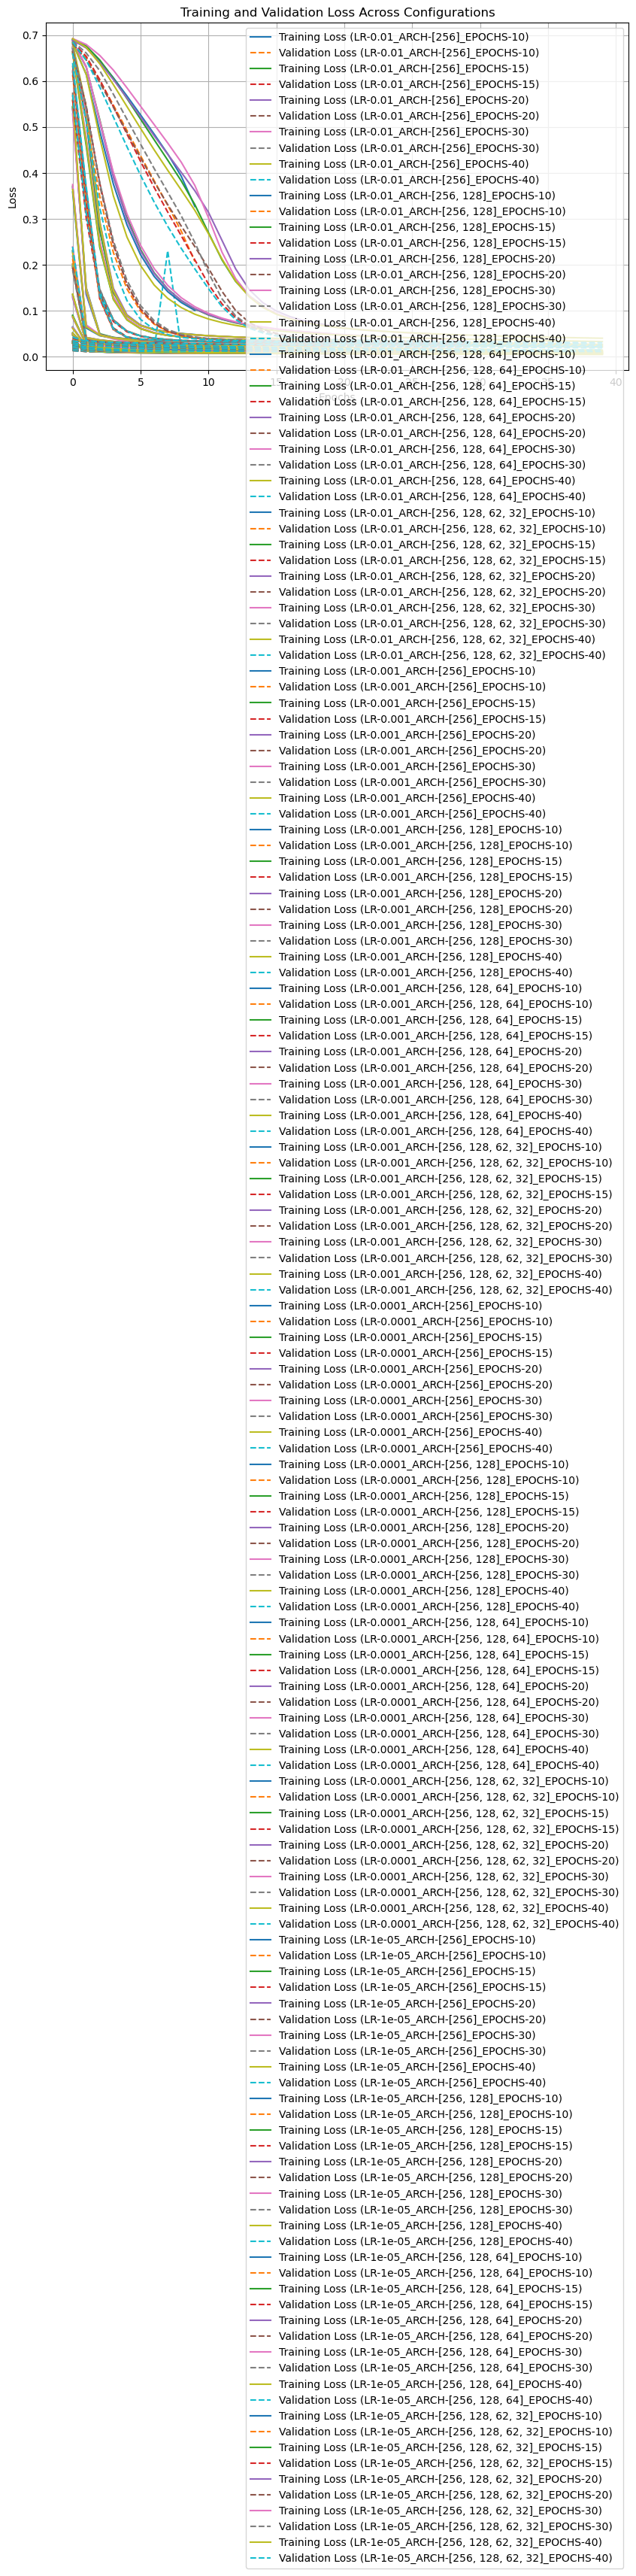


S-min @ F-max and F-max Metrics:
LR-0.01_ARCH-[256]_EPOCHS-10 -> F-max: 0.8340, S-min @ F-max: 3.9186
LR-0.01_ARCH-[256]_EPOCHS-15 -> F-max: 0.8329, S-min @ F-max: 4.0440
LR-0.01_ARCH-[256]_EPOCHS-20 -> F-max: 0.8353, S-min @ F-max: 4.0842
LR-0.01_ARCH-[256]_EPOCHS-30 -> F-max: 0.8379, S-min @ F-max: 3.7612
LR-0.01_ARCH-[256]_EPOCHS-40 -> F-max: 0.8436, S-min @ F-max: 3.9017
LR-0.01_ARCH-[256, 128]_EPOCHS-10 -> F-max: 0.8335, S-min @ F-max: 4.0736
LR-0.01_ARCH-[256, 128]_EPOCHS-15 -> F-max: 0.8416, S-min @ F-max: 3.9376
LR-0.01_ARCH-[256, 128]_EPOCHS-20 -> F-max: 0.8400, S-min @ F-max: 3.8947
LR-0.01_ARCH-[256, 128]_EPOCHS-30 -> F-max: 0.8487, S-min @ F-max: 3.7792
LR-0.01_ARCH-[256, 128]_EPOCHS-40 -> F-max: 0.8492, S-min @ F-max: 3.7367
LR-0.01_ARCH-[256, 128, 64]_EPOCHS-10 -> F-max: 0.8194, S-min @ F-max: 4.3860
LR-0.01_ARCH-[256, 128, 64]_EPOCHS-15 -> F-max: 0.8273, S-min @ F-max: 4.3770
LR-0.01_ARCH-[256, 128, 64]_EPOCHS-20 -> F-max: 0.8296, S-min @ F-max: 4.3765
LR-0.01_ARCH-[256

In [ ]:
training_losses = {}
validation_losses = {}
smin_fmax_metrics = {}  
threshold_range = np.arange(0.1, 1.0, 0.1)  # Example range: [0.01, 0.99]

for lr in learning_rates:
    for arch in architectures:
        for num_epochs in epoch_counts:
            print(f"\nTraining with LR: {lr}, Arch: {arch}, Epochs: {num_epochs}")

            model = FFNN(
                input_dim=data_train_embeddings.shape[1], 
                hidden_dims=arch, 
                output_dim=data_train_labels.shape[1]
            )
            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.BCEWithLogitsLoss()
            train_losses, val_losses = train_model(
                model, data_train_loader, data_val_loader, 
                criterion, optimizer, num_epochs, device
            )
            config_key = f"LR-{lr}_ARCH-{arch}_EPOCHS-{num_epochs}"
            training_losses[config_key] = train_losses
            validation_losses[config_key] = val_losses
            all_preds = []
            all_targets = []
            with torch.no_grad():
                for x_batch, y_batch in data_val_loader:
                    x_batch = x_batch.to(device)
                    outputs = model(x_batch)
                    preds = torch.sigmoid(outputs).cpu().numpy()  
                    all_preds.append(preds)
                    all_targets.append(y_batch.cpu().numpy())

            y_pred_probs = np.vstack(all_preds)
            y_true = np.vstack(all_targets)

            smin, fmax, best_threshold_s, best_threshold_f, s_at_fmax, results_df = threshold_performance_metrics(
                ic_dict, y_true, y_pred_probs, threshold_range=threshold_range, mlb=data_mlb
            )
            smin_fmax_metrics[config_key] = {
                "F-max": fmax,
                "S-min @ F-max": s_at_fmax,
                "Best Threshold (F-max)": best_threshold_f,
                "Best Threshold (S-min)": best_threshold_s
            }
            results_file = f"metrics_lr{lr}_arch{arch}_epochs{num_epochs}.csv"
            results_df.to_csv(results_file, index=False)
            print(f"Saved metrics to: {results_file}")

            print(f"Completed training and evaluation for config: LR={lr}, ARCH={arch}, EPOCHS={num_epochs}")

plt.figure(figsize=(10, 6))
for key in training_losses:
    plt.plot(training_losses[key], label=f'Training Loss ({key})')
    plt.plot(validation_losses[key], label=f'Validation Loss ({key})', linestyle='--')

plt.title('Training and Validation Loss Across Configurations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

print("\nS-min @ F-max and F-max Metrics:")
for config, metrics in smin_fmax_metrics.items():
    print(f"{config} -> F-max: {metrics['F-max']:.4f}, S-min @ F-max: {metrics['S-min @ F-max']:.4f}")

print("Process finished. Loss plot and metric evaluations completed.")


In [ ]:
metrics_df = pd.DataFrame.from_dict(smin_fmax_metrics, orient='index').reset_index()
metrics_df.rename(columns={"index": "Configuration"}, inplace=True)


metrics_df

,Configuration,F-max,S-min @ F-max,Best Threshold (F-max),Best Threshold (S-min)
0,LR-0.01_ARCH-[256]_EPOCHS-10,0.833989,3.918649,0.3,0.3
1,LR-0.01_ARCH-[256]_EPOCHS-15,0.832908,4.043989,0.4,0.3
2,LR-0.01_ARCH-[256]_EPOCHS-20,0.835252,4.084151,0.4,0.2
3,LR-0.01_ARCH-[256]_EPOCHS-30,0.837943,3.761175,0.3,0.3
4,LR-0.01_ARCH-[256]_EPOCHS-40,0.843567,3.901711,0.4,0.3
...,...,...,...,...,...
75,"LR-1e-05_ARCH-[256, 128, 62, 32]_EPOCHS-10",0.083679,44.296791,0.6,0.9
76,"LR-1e-05_ARCH-[256, 128, 62, 32]_EPOCHS-15",0.431669,10.421495,0.7,0.5
77,"LR-1e-05_ARCH-[256, 128, 62, 32]_EPOCHS-20",0.500336,10.185127,0.4,0.3
78,"LR-1e-05_ARCH-[256, 128, 62, 32]_EPOCHS-30",0.521020,9.938704,0.3,0.2


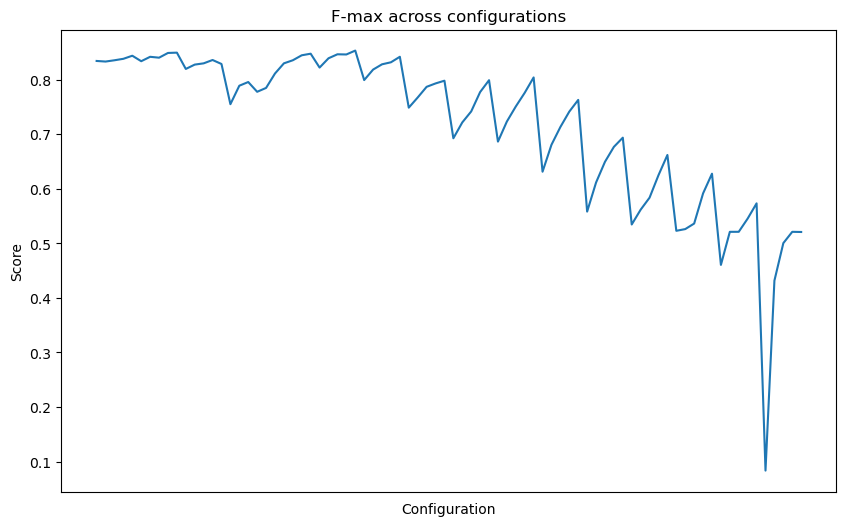

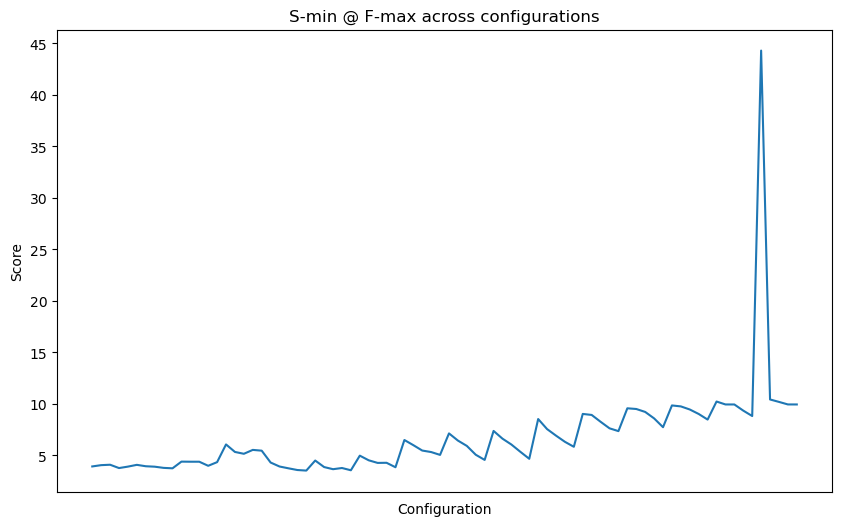

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(metrics_df["Configuration"], metrics_df["F-max"], label="F-max")
plt.title("F-max across configurations")
plt.xlabel("Configuration")
plt.xticks([])
plt.ylabel("Score")
plt.show() 

plt.figure(figsize=(10, 6))
plt.plot(metrics_df["Configuration"], metrics_df["S-min @ F-max"], label="S-min @ F-max")
plt.title("S-min @ F-max across configurations")
plt.xlabel("Configuration")
plt.xticks([])
plt.ylabel("Score")
plt.show() 


In [ ]:
def find_best_config(metrics_df):
    sorted_df = metrics_df.sort_values(by=["F-max", "S-min @ F-max"], ascending=[False, True])
    return sorted_df.iloc[0]

best_config = find_best_config(metrics_df)
best_config

Configuration             LR-0.001_ARCH-[256, 128]_EPOCHS-40
F-max                                               0.852998
S-min @ F-max                                       3.547046
Best Threshold (F-max)                                   0.4
Best Threshold (S-min)                                   0.3
Name: 29, dtype: object

In [ ]:
def find_best_config_with_overfitting(
    metrics_df, training_losses, validation_losses
):
    overfitting_scores = {}
    for config_key in training_losses:
        final_train_loss = training_losses[config_key][-1]  # Last epoch's training loss
        final_val_loss = validation_losses[config_key][-1]  # Last epoch's validation loss
        overfitting_scores[config_key] = final_val_loss - final_train_loss

    metrics_df["Overfitting_Score"] = metrics_df["Configuration"].map(overfitting_scores)
    sorted_df = metrics_df.sort_values(
        by=["F-max", "S-min @ F-max", "Overfitting_Score"], 
        ascending=[False, True, True]
    )
    return sorted_df.iloc[0]

best_config = find_best_config_with_overfitting(metrics_df, training_losses, validation_losses)
print(best_config)


Configuration             LR-0.001_ARCH-[256, 128]_EPOCHS-40
F-max                                               0.852998
S-min @ F-max                                       3.547046
Best Threshold (F-max)                                   0.4
Best Threshold (S-min)                                   0.3
Overfitting_Score                                   0.006041
Name: 29, dtype: object


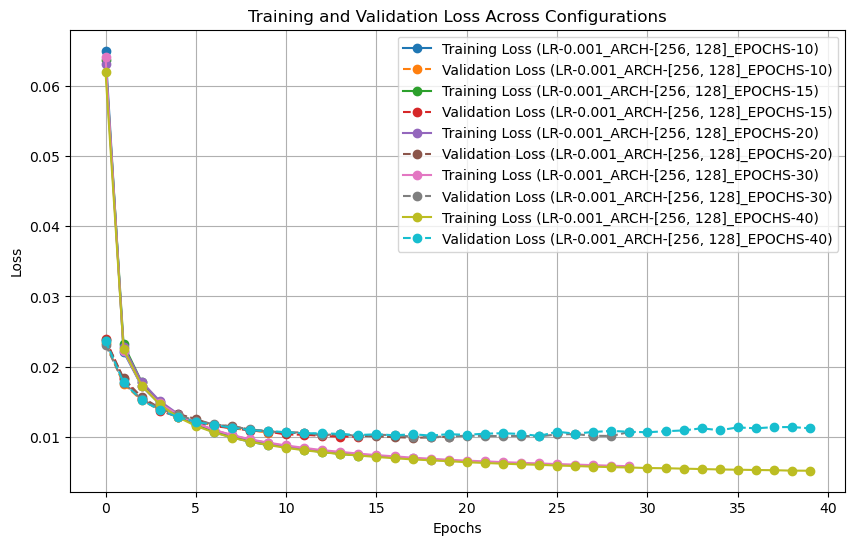

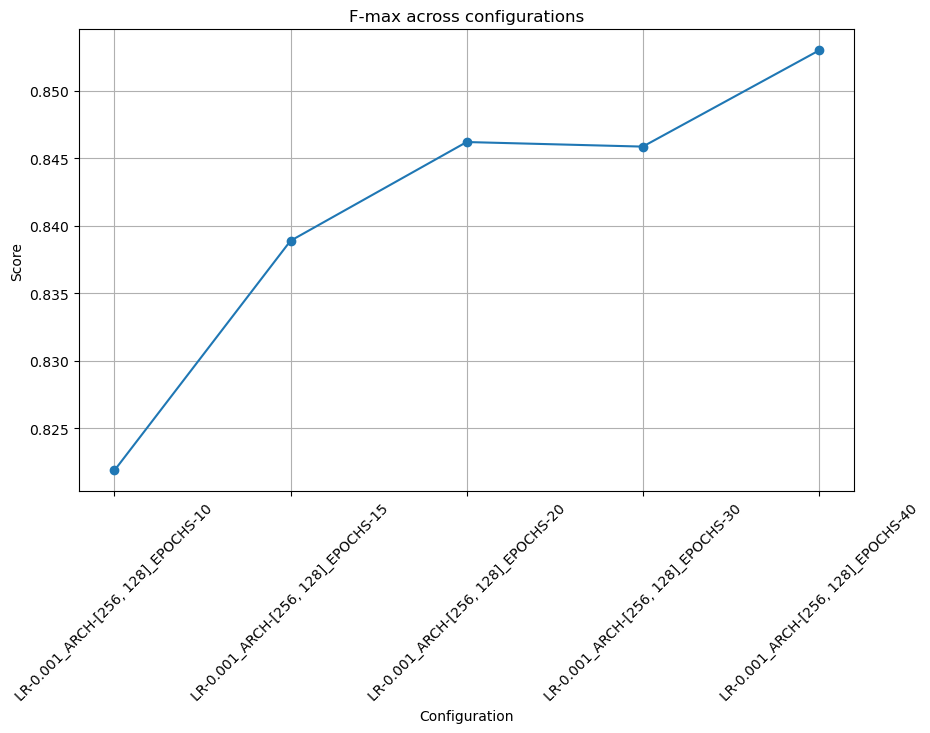

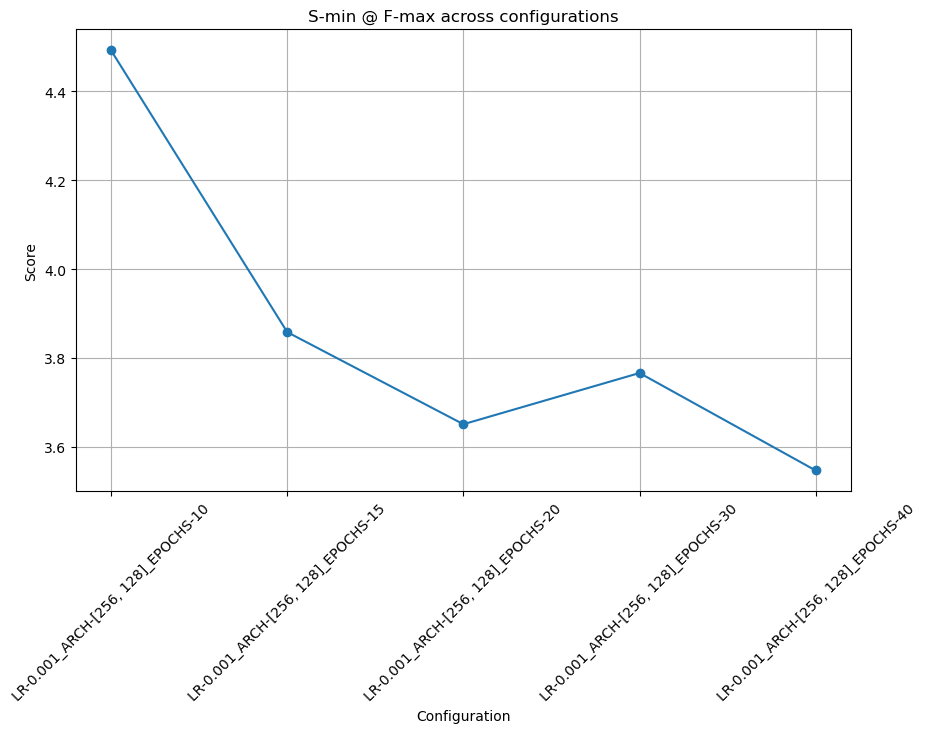

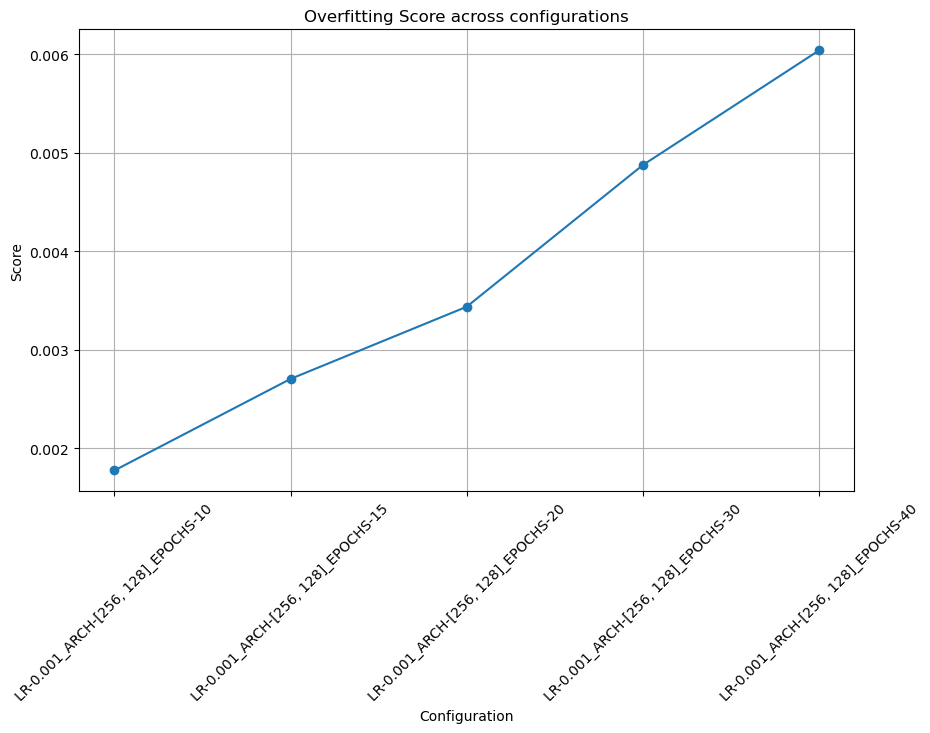

In [ ]:
configs = [key for key in training_losses.keys() if "LR-0.001_ARCH-[256, 128]" in key]
plt.figure(figsize=(10, 6))
for key in configs:
    plt.plot(training_losses[key], marker='o', label=f'Training Loss ({key})')
    plt.plot(validation_losses[key], marker='o', linestyle='--', label=f'Validation Loss ({key})')

plt.title('Training and Validation Loss Across Configurations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()
metrics_df_subset = metrics_df[metrics_df["Configuration"].isin(configs)]

plt.figure(figsize=(10, 6))
plt.plot(metrics_df_subset["Configuration"], metrics_df_subset["F-max"], marker='o', label="F-max")
plt.title("F-max across configurations")
plt.xlabel("Configuration")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(metrics_df_subset["Configuration"], metrics_df_subset["S-min @ F-max"], marker='o', label="S-min @ F-max")
plt.title("S-min @ F-max across configurations")
plt.xlabel("Configuration")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(metrics_df_subset["Configuration"], metrics_df_subset["Overfitting_Score"], marker='o', label="Overfitting Score")
plt.title("Overfitting Score across configurations")
plt.xlabel("Configuration")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.grid(True)
plt.show()


In [ ]:
metrics_df.to_csv(r'BP_architecture_tune/BPO_metrics_df.csv', index=False)

LR-0.001_ARCH-[256, 128]_EPOCHS-20 is chosen. 

In [16]:
CHOSEN_CONFIG = 'LR-0.001_ARCH-[256, 128]_EPOCHS-20'
CHOSEN_CONFIG_LR = 0.001
CHOSEN_CONFIG_ARCH = [256, 128]
CHOSEN_CONFIG_EPOCHS = 20

# Is there an advantage of using another Loss scheme for this architecture? 

In [ ]:
from goatools.obo_parser import GODag
obodag = GODag("go-basic.obo")

def get_level(go_term, ontology):

    try :
        return obodag[go_term].level
    except KeyError:
        return 0

data_train_GO_flat = [item for sublist in data_train_GO_list for item in sublist]
data_train_GO_list_unique = list(set(data_train_GO_flat))
data_train_GO_levels = [get_level(go_term, 'function') for go_term in data_train_GO_list_unique]

def compute_depth_weight(term_depths):
    class_weights = np.array([1 + depth/2 for depth in term_depths]) 
    return class_weights

data_train_GO_weights_depth = compute_depth_weight(data_train_GO_levels)

data_train_GO_weights_depth.shape

go-basic.obo: fmt(1.2) rel(2024-09-08) 44,296 Terms


(1548,)

In [ ]:
def compute_inverse_frequency_weight(labels):
    class_counts = np.sum(labels, axis=0)
    total_samples = labels.shape[0]
    num_classes = labels.shape[1]
    class_weights = total_samples / (num_classes * class_counts)
    return class_weights

if len(data_train_labels.shape) > 1 and data_train_labels.shape[1] > 1:  
    class_weights = compute_inverse_frequency_weight(data_train_labels)
    data_train_GO_weights_inv_freq_ = torch.tensor(class_weights, dtype=torch.float).to(device)

data_train_GO_weights_inv_freq_.shape

torch.Size([1548])

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        else:
            return F_loss


class JaccardLoss(nn.Module):
    def __init__(self, smooth=1):
        super(JaccardLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        intersection = (inputs * targets).sum(dim=1)
        total = (inputs + targets).sum(dim=1)
        union = total - intersection
        Jaccard = (intersection + self.smooth) / (union + self.smooth)
        return 1 - Jaccard.mean()


class HingeLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(HingeLoss, self).__init__()
        self.margin = margin

    def forward(self, inputs, targets):
        targets = 2 * targets - 1  # Convert {0,1} to {-1,1}
        hinge_loss = torch.mean(torch.clamp(self.margin - targets * inputs, min=0))
        return hinge_loss


class AsymmetricLoss(nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05, eps=1e-8):
        super(AsymmetricLoss, self).__init__()
        self.gamma_neg = gamma_neg
        self.gamma_pos = gamma_pos
        self.clip = clip
        self.eps = eps

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.clamp(self.clip, 1.0 - self.clip)

        loss_pos = -targets * torch.log(inputs + self.eps) * (1 - inputs) ** self.gamma_pos
        loss_neg = -(1 - targets) * torch.log(1 - inputs + self.eps) * inputs ** self.gamma_neg
        loss = loss_pos + loss_neg

        return loss.mean()





Training with BCEWithLogitsLoss_balanced, LR: 0.001, Arch: [256, 128], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:28,  1.49s/it]

Epoch [1/20] | Train Loss: 0.0630 | Val Loss: 0.0234


Epoch progress:  10%|█         | 2/20 [00:02<00:25,  1.40s/it]

Epoch [2/20] | Train Loss: 0.0225 | Val Loss: 0.0178


Epoch progress:  15%|█▌        | 3/20 [00:04<00:23,  1.38s/it]

Epoch [3/20] | Train Loss: 0.0175 | Val Loss: 0.0152


Epoch progress:  20%|██        | 4/20 [00:05<00:23,  1.49s/it]

Epoch [4/20] | Train Loss: 0.0147 | Val Loss: 0.0136


Epoch progress:  25%|██▌       | 5/20 [00:07<00:21,  1.43s/it]

Epoch [5/20] | Train Loss: 0.0129 | Val Loss: 0.0128


Epoch progress:  30%|███       | 6/20 [00:08<00:20,  1.45s/it]

Epoch [6/20] | Train Loss: 0.0117 | Val Loss: 0.0122


Epoch progress:  35%|███▌      | 7/20 [00:10<00:19,  1.48s/it]

Epoch [7/20] | Train Loss: 0.0108 | Val Loss: 0.0115


Epoch progress:  40%|████      | 8/20 [00:11<00:17,  1.45s/it]

Epoch [8/20] | Train Loss: 0.0100 | Val Loss: 0.0111


Epoch progress:  45%|████▌     | 9/20 [00:13<00:16,  1.47s/it]

Epoch [9/20] | Train Loss: 0.0095 | Val Loss: 0.0110


Epoch progress:  50%|█████     | 10/20 [00:14<00:14,  1.42s/it]

Epoch [10/20] | Train Loss: 0.0090 | Val Loss: 0.0106


Epoch progress:  55%|█████▌    | 11/20 [00:15<00:13,  1.45s/it]

Epoch [11/20] | Train Loss: 0.0086 | Val Loss: 0.0107


Epoch progress:  60%|██████    | 12/20 [00:17<00:11,  1.41s/it]

Epoch [12/20] | Train Loss: 0.0083 | Val Loss: 0.0105


Epoch progress:  65%|██████▌   | 13/20 [00:18<00:09,  1.39s/it]

Epoch [13/20] | Train Loss: 0.0080 | Val Loss: 0.0104


Epoch progress:  70%|███████   | 14/20 [00:20<00:09,  1.50s/it]

Epoch [14/20] | Train Loss: 0.0077 | Val Loss: 0.0103


Epoch progress:  75%|███████▌  | 15/20 [00:21<00:07,  1.47s/it]

Epoch [15/20] | Train Loss: 0.0075 | Val Loss: 0.0102


Epoch progress:  80%|████████  | 16/20 [00:23<00:06,  1.52s/it]

Epoch [16/20] | Train Loss: 0.0073 | Val Loss: 0.0101


Epoch progress:  85%|████████▌ | 17/20 [00:24<00:04,  1.49s/it]

Epoch [17/20] | Train Loss: 0.0071 | Val Loss: 0.0100


Epoch progress:  90%|█████████ | 18/20 [00:26<00:02,  1.43s/it]

Epoch [18/20] | Train Loss: 0.0070 | Val Loss: 0.0102


Epoch progress:  95%|█████████▌| 19/20 [00:27<00:01,  1.48s/it]

Epoch [19/20] | Train Loss: 0.0068 | Val Loss: 0.0100


Epoch progress: 100%|██████████| 20/20 [00:29<00:00,  1.45s/it]

Epoch [20/20] | Train Loss: 0.0067 | Val Loss: 0.0099
Training completed.



Calculating Smin & Fmax: 100%|██████████| 99/99 [02:06<00:00,  1.28s/it]


F-max @ Best Threshold (0.39): 0.8453705127671137
S-min @ Best Threshold (0.3): 3.6628453842293216
S-min @ F-max Threshold (0.39): 3.786354576769574
Saved metrics to: BPO_metrics_BCEWithLogitsLoss_balanced_lr0.001_arch[256, 128]_epochs20.csv
Completed BCEWithLogitsLoss_balanced | Validation Loss: 0.0099, Fmax: 0.8454, Smin: 3.6628

Training with BCEWithLogitsLoss_depth, LR: 0.001, Arch: [256, 128], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:29,  1.55s/it]

Epoch [1/20] | Train Loss: 0.2048 | Val Loss: 0.0779


Epoch progress:  10%|█         | 2/20 [00:02<00:26,  1.46s/it]

Epoch [2/20] | Train Loss: 0.0763 | Val Loss: 0.0601


Epoch progress:  15%|█▌        | 3/20 [00:04<00:25,  1.50s/it]

Epoch [3/20] | Train Loss: 0.0589 | Val Loss: 0.0510


Epoch progress:  20%|██        | 4/20 [00:06<00:24,  1.51s/it]

Epoch [4/20] | Train Loss: 0.0492 | Val Loss: 0.0460


Epoch progress:  25%|██▌       | 5/20 [00:07<00:23,  1.54s/it]

Epoch [5/20] | Train Loss: 0.0430 | Val Loss: 0.0428


Epoch progress:  30%|███       | 6/20 [00:08<00:20,  1.48s/it]

Epoch [6/20] | Train Loss: 0.0387 | Val Loss: 0.0400


Epoch progress:  35%|███▌      | 7/20 [00:10<00:19,  1.50s/it]

Epoch [7/20] | Train Loss: 0.0355 | Val Loss: 0.0384


Epoch progress:  40%|████      | 8/20 [00:11<00:17,  1.50s/it]

Epoch [8/20] | Train Loss: 0.0329 | Val Loss: 0.0367


Epoch progress:  45%|████▌     | 9/20 [00:13<00:16,  1.46s/it]

Epoch [9/20] | Train Loss: 0.0309 | Val Loss: 0.0358


Epoch progress:  50%|█████     | 10/20 [00:15<00:15,  1.51s/it]

Epoch [10/20] | Train Loss: 0.0294 | Val Loss: 0.0349


Epoch progress:  55%|█████▌    | 11/20 [00:16<00:13,  1.46s/it]

Epoch [11/20] | Train Loss: 0.0281 | Val Loss: 0.0344


Epoch progress:  60%|██████    | 12/20 [00:18<00:12,  1.54s/it]

Epoch [12/20] | Train Loss: 0.0269 | Val Loss: 0.0345


Epoch progress:  65%|██████▌   | 13/20 [00:19<00:10,  1.49s/it]

Epoch [13/20] | Train Loss: 0.0260 | Val Loss: 0.0331


Epoch progress:  70%|███████   | 14/20 [00:21<00:09,  1.53s/it]

Epoch [14/20] | Train Loss: 0.0251 | Val Loss: 0.0332


Epoch progress:  75%|███████▌  | 15/20 [00:22<00:07,  1.48s/it]

Epoch [15/20] | Train Loss: 0.0243 | Val Loss: 0.0329


Epoch progress:  80%|████████  | 16/20 [00:23<00:05,  1.43s/it]

Epoch [16/20] | Train Loss: 0.0237 | Val Loss: 0.0326


Epoch progress:  85%|████████▌ | 17/20 [00:25<00:04,  1.51s/it]

Epoch [17/20] | Train Loss: 0.0230 | Val Loss: 0.0334


Epoch progress:  90%|█████████ | 18/20 [00:26<00:02,  1.46s/it]

Epoch [18/20] | Train Loss: 0.0226 | Val Loss: 0.0328


Epoch progress:  95%|█████████▌| 19/20 [00:28<00:01,  1.42s/it]

Epoch [19/20] | Train Loss: 0.0220 | Val Loss: 0.0325


Epoch progress: 100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


Epoch [20/20] | Train Loss: 0.0216 | Val Loss: 0.0321
Training completed.


Calculating Smin & Fmax: 100%|██████████| 99/99 [02:06<00:00,  1.28s/it]


F-max @ Best Threshold (0.37): 0.8453424032126762
S-min @ Best Threshold (0.29000000000000004): 3.652325864733375
S-min @ F-max Threshold (0.37): 3.749514400138378
Saved metrics to: BPO_metrics_BCEWithLogitsLoss_depth_lr0.001_arch[256, 128]_epochs20.csv
Completed BCEWithLogitsLoss_depth | Validation Loss: 0.0321, Fmax: 0.8453, Smin: 3.6523

Training with BCEWithLogitsLoss_inv_freq, LR: 0.001, Arch: [256, 128], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:33,  1.76s/it]

Epoch [1/20] | Train Loss: 0.0285 | Val Loss: 0.0052


Epoch progress:  10%|█         | 2/20 [00:03<00:28,  1.60s/it]

Epoch [2/20] | Train Loss: 0.0049 | Val Loss: 0.0047


Epoch progress:  15%|█▌        | 3/20 [00:04<00:26,  1.55s/it]

Epoch [3/20] | Train Loss: 0.0043 | Val Loss: 0.0040


Epoch progress:  20%|██        | 4/20 [00:06<00:24,  1.54s/it]

Epoch [4/20] | Train Loss: 0.0036 | Val Loss: 0.0034


Epoch progress:  25%|██▌       | 5/20 [00:07<00:23,  1.58s/it]

Epoch [5/20] | Train Loss: 0.0030 | Val Loss: 0.0029


Epoch progress:  30%|███       | 6/20 [00:09<00:21,  1.53s/it]

Epoch [6/20] | Train Loss: 0.0026 | Val Loss: 0.0025


Epoch progress:  35%|███▌      | 7/20 [00:10<00:19,  1.50s/it]

Epoch [7/20] | Train Loss: 0.0022 | Val Loss: 0.0023


Epoch progress:  40%|████      | 8/20 [00:12<00:17,  1.49s/it]

Epoch [8/20] | Train Loss: 0.0020 | Val Loss: 0.0021


Epoch progress:  45%|████▌     | 9/20 [00:13<00:16,  1.50s/it]

Epoch [9/20] | Train Loss: 0.0018 | Val Loss: 0.0020


Epoch progress:  50%|█████     | 10/20 [00:15<00:15,  1.53s/it]

Epoch [10/20] | Train Loss: 0.0016 | Val Loss: 0.0019


Epoch progress:  55%|█████▌    | 11/20 [00:16<00:13,  1.51s/it]

Epoch [11/20] | Train Loss: 0.0015 | Val Loss: 0.0018


Epoch progress:  60%|██████    | 12/20 [00:18<00:12,  1.53s/it]

Epoch [12/20] | Train Loss: 0.0014 | Val Loss: 0.0018


Epoch progress:  65%|██████▌   | 13/20 [00:19<00:10,  1.54s/it]

Epoch [13/20] | Train Loss: 0.0013 | Val Loss: 0.0017


Epoch progress:  70%|███████   | 14/20 [00:21<00:08,  1.48s/it]

Epoch [14/20] | Train Loss: 0.0013 | Val Loss: 0.0017


Epoch progress:  75%|███████▌  | 15/20 [00:22<00:07,  1.51s/it]

Epoch [15/20] | Train Loss: 0.0012 | Val Loss: 0.0016


Epoch progress:  80%|████████  | 16/20 [00:24<00:05,  1.47s/it]

Epoch [16/20] | Train Loss: 0.0012 | Val Loss: 0.0016


Epoch progress:  85%|████████▌ | 17/20 [00:25<00:04,  1.50s/it]

Epoch [17/20] | Train Loss: 0.0011 | Val Loss: 0.0016


Epoch progress:  90%|█████████ | 18/20 [00:27<00:02,  1.46s/it]

Epoch [18/20] | Train Loss: 0.0011 | Val Loss: 0.0016


Epoch progress:  95%|█████████▌| 19/20 [00:28<00:01,  1.43s/it]

Epoch [19/20] | Train Loss: 0.0010 | Val Loss: 0.0015


Epoch progress: 100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


Epoch [20/20] | Train Loss: 0.0010 | Val Loss: 0.0015
Training completed.


Calculating Smin & Fmax: 100%|██████████| 99/99 [02:08<00:00,  1.30s/it]


F-max @ Best Threshold (0.31): 0.7345251452522588
S-min @ Best Threshold (0.28): 5.307119474502626
S-min @ F-max Threshold (0.31): 5.340575398435165
Saved metrics to: BPO_metrics_BCEWithLogitsLoss_inv_freq_lr0.001_arch[256, 128]_epochs20.csv
Completed BCEWithLogitsLoss_inv_freq | Validation Loss: 0.0015, Fmax: 0.7345, Smin: 5.3071

Training with FocalLoss, LR: 0.001, Arch: [256, 128], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:30,  1.63s/it]

Epoch [1/20] | Train Loss: 0.0043 | Val Loss: 0.0016


Epoch progress:  10%|█         | 2/20 [00:03<00:27,  1.50s/it]

Epoch [2/20] | Train Loss: 0.0015 | Val Loss: 0.0012


Epoch progress:  15%|█▌        | 3/20 [00:04<00:24,  1.46s/it]

Epoch [3/20] | Train Loss: 0.0011 | Val Loss: 0.0010


Epoch progress:  20%|██        | 4/20 [00:06<00:24,  1.56s/it]

Epoch [4/20] | Train Loss: 0.0009 | Val Loss: 0.0009


Epoch progress:  25%|██▌       | 5/20 [00:07<00:22,  1.50s/it]

Epoch [5/20] | Train Loss: 0.0008 | Val Loss: 0.0009


Epoch progress:  30%|███       | 6/20 [00:09<00:21,  1.56s/it]

Epoch [6/20] | Train Loss: 0.0007 | Val Loss: 0.0008


Epoch progress:  35%|███▌      | 7/20 [00:10<00:20,  1.59s/it]

Epoch [7/20] | Train Loss: 0.0007 | Val Loss: 0.0008


Epoch progress:  40%|████      | 8/20 [00:12<00:18,  1.56s/it]

Epoch [8/20] | Train Loss: 0.0006 | Val Loss: 0.0008


Epoch progress:  45%|████▌     | 9/20 [00:13<00:16,  1.54s/it]

Epoch [9/20] | Train Loss: 0.0006 | Val Loss: 0.0008


Epoch progress:  50%|█████     | 10/20 [00:15<00:15,  1.59s/it]

Epoch [10/20] | Train Loss: 0.0006 | Val Loss: 0.0007


Epoch progress:  55%|█████▌    | 11/20 [00:17<00:13,  1.55s/it]

Epoch [11/20] | Train Loss: 0.0005 | Val Loss: 0.0007


Epoch progress:  60%|██████    | 12/20 [00:18<00:12,  1.57s/it]

Epoch [12/20] | Train Loss: 0.0005 | Val Loss: 0.0007


Epoch progress:  65%|██████▌   | 13/20 [00:20<00:10,  1.53s/it]

Epoch [13/20] | Train Loss: 0.0005 | Val Loss: 0.0007


Epoch progress:  70%|███████   | 14/20 [00:21<00:09,  1.57s/it]

Epoch [14/20] | Train Loss: 0.0005 | Val Loss: 0.0007


Epoch progress:  75%|███████▌  | 15/20 [00:23<00:07,  1.59s/it]

Epoch [15/20] | Train Loss: 0.0005 | Val Loss: 0.0007


Epoch progress:  80%|████████  | 16/20 [00:24<00:06,  1.57s/it]

Epoch [16/20] | Train Loss: 0.0005 | Val Loss: 0.0007


Epoch progress:  85%|████████▌ | 17/20 [00:26<00:04,  1.56s/it]

Epoch [17/20] | Train Loss: 0.0004 | Val Loss: 0.0007


Epoch progress:  90%|█████████ | 18/20 [00:28<00:03,  1.57s/it]

Epoch [18/20] | Train Loss: 0.0004 | Val Loss: 0.0007


Epoch progress:  95%|█████████▌| 19/20 [00:29<00:01,  1.57s/it]

Epoch [19/20] | Train Loss: 0.0004 | Val Loss: 0.0007


Epoch progress: 100%|██████████| 20/20 [00:31<00:00,  1.56s/it]


Epoch [20/20] | Train Loss: 0.0004 | Val Loss: 0.0007
Training completed.


Calculating Smin & Fmax: 100%|██████████| 99/99 [02:13<00:00,  1.35s/it]


F-max @ Best Threshold (0.45): 0.8465413329653779
S-min @ Best Threshold (0.42000000000000004): 3.6333793032657495
S-min @ F-max Threshold (0.45): 3.7197542601436324
Saved metrics to: BPO_metrics_FocalLoss_lr0.001_arch[256, 128]_epochs20.csv
Completed FocalLoss | Validation Loss: 0.0007, Fmax: 0.8465, Smin: 3.6334

Training with JaccardLoss, LR: 0.001, Arch: [256, 128], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:31,  1.64s/it]

Epoch [1/20] | Train Loss: 0.7719 | Val Loss: 0.5962


Epoch progress:  10%|█         | 2/20 [00:03<00:27,  1.52s/it]

Epoch [2/20] | Train Loss: 0.5955 | Val Loss: 0.5596


Epoch progress:  15%|█▌        | 3/20 [00:04<00:25,  1.50s/it]

Epoch [3/20] | Train Loss: 0.5748 | Val Loss: 0.5333


Epoch progress:  20%|██        | 4/20 [00:06<00:23,  1.49s/it]

Epoch [4/20] | Train Loss: 0.5366 | Val Loss: 0.5112


Epoch progress:  25%|██▌       | 5/20 [00:07<00:22,  1.50s/it]

Epoch [5/20] | Train Loss: 0.5174 | Val Loss: 0.4988


Epoch progress:  30%|███       | 6/20 [00:09<00:20,  1.50s/it]

Epoch [6/20] | Train Loss: 0.5015 | Val Loss: 0.4941


Epoch progress:  35%|███▌      | 7/20 [00:10<00:19,  1.50s/it]

Epoch [7/20] | Train Loss: 0.4920 | Val Loss: 0.4903


Epoch progress:  40%|████      | 8/20 [00:11<00:17,  1.49s/it]

Epoch [8/20] | Train Loss: 0.4875 | Val Loss: 0.4868


Epoch progress:  45%|████▌     | 9/20 [00:13<00:17,  1.55s/it]

Epoch [9/20] | Train Loss: 0.4846 | Val Loss: 0.4851


Epoch progress:  50%|█████     | 10/20 [00:15<00:14,  1.50s/it]

Epoch [10/20] | Train Loss: 0.4820 | Val Loss: 0.4852


Epoch progress:  55%|█████▌    | 11/20 [00:16<00:14,  1.60s/it]

Epoch [11/20] | Train Loss: 0.4801 | Val Loss: 0.4849


Epoch progress:  60%|██████    | 12/20 [00:19<00:14,  1.84s/it]

Epoch [12/20] | Train Loss: 0.4787 | Val Loss: 0.4839


Epoch progress:  65%|██████▌   | 13/20 [00:21<00:13,  2.00s/it]

Epoch [13/20] | Train Loss: 0.4777 | Val Loss: 0.4834


Epoch progress:  70%|███████   | 14/20 [00:23<00:12,  2.09s/it]

Epoch [14/20] | Train Loss: 0.4770 | Val Loss: 0.4834


Epoch progress:  75%|███████▌  | 15/20 [00:26<00:10,  2.17s/it]

Epoch [15/20] | Train Loss: 0.4760 | Val Loss: 0.4817


Epoch progress:  80%|████████  | 16/20 [00:28<00:09,  2.30s/it]

Epoch [16/20] | Train Loss: 0.4748 | Val Loss: 0.4808


Epoch progress:  85%|████████▌ | 17/20 [00:30<00:06,  2.21s/it]

Epoch [17/20] | Train Loss: 0.4740 | Val Loss: 0.4794


Epoch progress:  90%|█████████ | 18/20 [00:32<00:03,  2.00s/it]

Epoch [18/20] | Train Loss: 0.4734 | Val Loss: 0.4796


Epoch progress:  95%|█████████▌| 19/20 [00:33<00:01,  1.87s/it]

Epoch [19/20] | Train Loss: 0.4729 | Val Loss: 0.4795


Epoch progress: 100%|██████████| 20/20 [00:35<00:00,  1.77s/it]


Epoch [20/20] | Train Loss: 0.4724 | Val Loss: 0.4783
Training completed.


Calculating Smin & Fmax: 100%|██████████| 99/99 [02:04<00:00,  1.26s/it]


F-max @ Best Threshold (0.86): 0.6306211074663993
S-min @ Best Threshold (0.01): 8.371183219021372
S-min @ F-max Threshold (0.86): 8.432092715248974
Saved metrics to: BPO_metrics_JaccardLoss_lr0.001_arch[256, 128]_epochs20.csv
Completed JaccardLoss | Validation Loss: 0.4783, Fmax: 0.6306, Smin: 8.3712

Training with HingeLoss, LR: 0.001, Arch: [256, 128], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:29,  1.57s/it]

Epoch [1/20] | Train Loss: 0.0558 | Val Loss: 0.0156


Epoch progress:  10%|█         | 2/20 [00:03<00:27,  1.52s/it]

Epoch [2/20] | Train Loss: 0.0160 | Val Loss: 0.0132


Epoch progress:  15%|█▌        | 3/20 [00:04<00:28,  1.65s/it]

Epoch [3/20] | Train Loss: 0.0136 | Val Loss: 0.0120


Epoch progress:  20%|██        | 4/20 [00:06<00:24,  1.52s/it]

Epoch [4/20] | Train Loss: 0.0124 | Val Loss: 0.0112


Epoch progress:  25%|██▌       | 5/20 [00:07<00:24,  1.62s/it]

Epoch [5/20] | Train Loss: 0.0115 | Val Loss: 0.0106


Epoch progress:  30%|███       | 6/20 [00:09<00:21,  1.52s/it]

Epoch [6/20] | Train Loss: 0.0106 | Val Loss: 0.0101


Epoch progress:  35%|███▌      | 7/20 [00:10<00:20,  1.54s/it]

Epoch [7/20] | Train Loss: 0.0099 | Val Loss: 0.0098


Epoch progress:  40%|████      | 8/20 [00:12<00:17,  1.49s/it]

Epoch [8/20] | Train Loss: 0.0093 | Val Loss: 0.0094


Epoch progress:  45%|████▌     | 9/20 [00:13<00:17,  1.56s/it]

Epoch [9/20] | Train Loss: 0.0088 | Val Loss: 0.0092


Epoch progress:  50%|█████     | 10/20 [00:15<00:15,  1.56s/it]

Epoch [10/20] | Train Loss: 0.0084 | Val Loss: 0.0091


Epoch progress:  55%|█████▌    | 11/20 [00:17<00:14,  1.61s/it]

Epoch [11/20] | Train Loss: 0.0080 | Val Loss: 0.0087


Epoch progress:  60%|██████    | 12/20 [00:18<00:12,  1.61s/it]

Epoch [12/20] | Train Loss: 0.0076 | Val Loss: 0.0085


Epoch progress:  65%|██████▌   | 13/20 [00:20<00:10,  1.53s/it]

Epoch [13/20] | Train Loss: 0.0073 | Val Loss: 0.0085


Epoch progress:  70%|███████   | 14/20 [00:21<00:09,  1.55s/it]

Epoch [14/20] | Train Loss: 0.0070 | Val Loss: 0.0083


Epoch progress:  75%|███████▌  | 15/20 [00:23<00:07,  1.49s/it]

Epoch [15/20] | Train Loss: 0.0068 | Val Loss: 0.0083


Epoch progress:  80%|████████  | 16/20 [00:25<00:06,  1.61s/it]

Epoch [16/20] | Train Loss: 0.0066 | Val Loss: 0.0082


Epoch progress:  85%|████████▌ | 17/20 [00:26<00:04,  1.52s/it]

Epoch [17/20] | Train Loss: 0.0064 | Val Loss: 0.0081


Epoch progress:  90%|█████████ | 18/20 [00:27<00:03,  1.56s/it]

Epoch [18/20] | Train Loss: 0.0062 | Val Loss: 0.0081


Epoch progress:  95%|█████████▌| 19/20 [00:29<00:01,  1.53s/it]

Epoch [19/20] | Train Loss: 0.0061 | Val Loss: 0.0082


Epoch progress: 100%|██████████| 20/20 [00:30<00:00,  1.55s/it]


Epoch [20/20] | Train Loss: 0.0059 | Val Loss: 0.0080
Training completed.


Calculating Smin & Fmax: 100%|██████████| 99/99 [02:44<00:00,  1.66s/it]


F-max @ Best Threshold (0.38): 0.8362689662030129
S-min @ Best Threshold (0.31): 3.9809436869283297
S-min @ F-max Threshold (0.38): 4.26595898169914
Saved metrics to: BPO_metrics_HingeLoss_lr0.001_arch[256, 128]_epochs20.csv
Completed HingeLoss | Validation Loss: 0.0080, Fmax: 0.8363, Smin: 3.9809

Training with AsymmetricLoss, LR: 0.001, Arch: [256, 128], Epochs: 20
Starting training...


Epoch progress:   5%|▌         | 1/20 [00:01<00:32,  1.69s/it]

Epoch [1/20] | Train Loss: 0.0080 | Val Loss: 0.0040


Epoch progress:  10%|█         | 2/20 [00:03<00:29,  1.62s/it]

Epoch [2/20] | Train Loss: 0.0036 | Val Loss: 0.0030


Epoch progress:  15%|█▌        | 3/20 [00:04<00:25,  1.53s/it]

Epoch [3/20] | Train Loss: 0.0028 | Val Loss: 0.0026


Epoch progress:  20%|██        | 4/20 [00:06<00:23,  1.48s/it]

Epoch [4/20] | Train Loss: 0.0024 | Val Loss: 0.0024


Epoch progress:  25%|██▌       | 5/20 [00:07<00:21,  1.46s/it]

Epoch [5/20] | Train Loss: 0.0021 | Val Loss: 0.0023


Epoch progress:  30%|███       | 6/20 [00:08<00:20,  1.43s/it]

Epoch [6/20] | Train Loss: 0.0020 | Val Loss: 0.0023


Epoch progress:  35%|███▌      | 7/20 [00:10<00:18,  1.42s/it]

Epoch [7/20] | Train Loss: 0.0018 | Val Loss: 0.0023


Epoch progress:  40%|████      | 8/20 [00:11<00:16,  1.41s/it]

Epoch [8/20] | Train Loss: 0.0017 | Val Loss: 0.0023


Epoch progress:  45%|████▌     | 9/20 [00:13<00:15,  1.41s/it]

Epoch [9/20] | Train Loss: 0.0017 | Val Loss: 0.0022


Epoch progress:  50%|█████     | 10/20 [00:14<00:14,  1.47s/it]

Epoch [10/20] | Train Loss: 0.0016 | Val Loss: 0.0022


Epoch progress:  55%|█████▌    | 11/20 [00:16<00:13,  1.46s/it]

Epoch [11/20] | Train Loss: 0.0016 | Val Loss: 0.0022


Epoch progress:  60%|██████    | 12/20 [00:17<00:11,  1.46s/it]

Epoch [12/20] | Train Loss: 0.0015 | Val Loss: 0.0022


Epoch progress:  65%|██████▌   | 13/20 [00:19<00:10,  1.47s/it]

Epoch [13/20] | Train Loss: 0.0015 | Val Loss: 0.0022


Epoch progress:  70%|███████   | 14/20 [00:20<00:08,  1.47s/it]

Epoch [14/20] | Train Loss: 0.0014 | Val Loss: 0.0022


Epoch progress:  75%|███████▌  | 15/20 [00:21<00:07,  1.45s/it]

Epoch [15/20] | Train Loss: 0.0014 | Val Loss: 0.0022


Epoch progress:  80%|████████  | 16/20 [00:23<00:05,  1.44s/it]

Epoch [16/20] | Train Loss: 0.0014 | Val Loss: 0.0022


Epoch progress:  85%|████████▌ | 17/20 [00:24<00:04,  1.43s/it]

Epoch [17/20] | Train Loss: 0.0014 | Val Loss: 0.0022


Epoch progress:  90%|█████████ | 18/20 [00:26<00:02,  1.48s/it]

Epoch [18/20] | Train Loss: 0.0013 | Val Loss: 0.0022


Epoch progress:  95%|█████████▌| 19/20 [00:27<00:01,  1.47s/it]

Epoch [19/20] | Train Loss: 0.0013 | Val Loss: 0.0022


Epoch progress: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


Epoch [20/20] | Train Loss: 0.0013 | Val Loss: 0.0023
Training completed.


Calculating Smin & Fmax: 100%|██████████| 99/99 [02:20<00:00,  1.42s/it]

F-max @ Best Threshold (0.5700000000000001): 0.8541509894291173
S-min @ Best Threshold (0.53): 3.4550185451902786
S-min @ F-max Threshold (0.5700000000000001): 3.5606534681237716
Saved metrics to: BPO_metrics_AsymmetricLoss_lr0.001_arch[256, 128]_epochs20.csv
Completed AsymmetricLoss | Validation Loss: 0.0023, Fmax: 0.8542, Smin: 3.4550


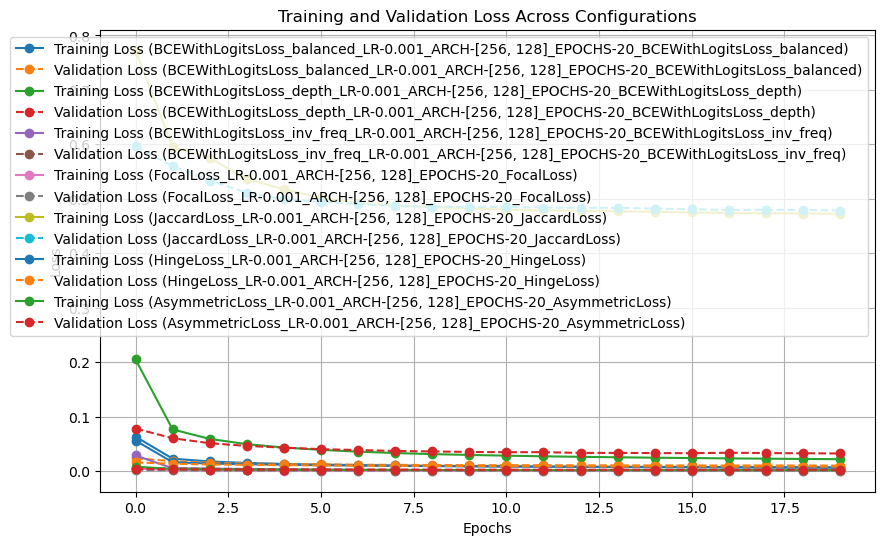


S-min @ F-max and F-max Metrics:
BCEWithLogitsLoss_balanced_LR-0.001_ARCH-[256, 128]_EPOCHS-20_BCEWithLogitsLoss_balanced -> F-max: 0.8454, S-min @ F-max: 3.7864
BCEWithLogitsLoss_depth_LR-0.001_ARCH-[256, 128]_EPOCHS-20_BCEWithLogitsLoss_depth -> F-max: 0.8453, S-min @ F-max: 3.7495
BCEWithLogitsLoss_inv_freq_LR-0.001_ARCH-[256, 128]_EPOCHS-20_BCEWithLogitsLoss_inv_freq -> F-max: 0.7345, S-min @ F-max: 5.3406
FocalLoss_LR-0.001_ARCH-[256, 128]_EPOCHS-20_FocalLoss -> F-max: 0.8465, S-min @ F-max: 3.7198
JaccardLoss_LR-0.001_ARCH-[256, 128]_EPOCHS-20_JaccardLoss -> F-max: 0.6306, S-min @ F-max: 8.4321
HingeLoss_LR-0.001_ARCH-[256, 128]_EPOCHS-20_HingeLoss -> F-max: 0.8363, S-min @ F-max: 4.2660
AsymmetricLoss_LR-0.001_ARCH-[256, 128]_EPOCHS-20_AsymmetricLoss -> F-max: 0.8542, S-min @ F-max: 3.5607
Process finished. Loss plot and metric evaluations completed.


In [ ]:
training_losses = {}
validation_losses = {}
smin_fmax_metrics = {}

threshold_range = np.arange(0.01, 1.0, 0.01)

architectures = [CHOSEN_CONFIG_ARCH]  
learning_rates = [CHOSEN_CONFIG_LR]
epoch_counts = [CHOSEN_CONFIG_EPOCHS]

loss_functions = {
    'BCEWithLogitsLoss_balanced': nn.BCEWithLogitsLoss(),
    'BCEWithLogitsLoss_depth': nn.BCEWithLogitsLoss(
        weight=torch.tensor(data_train_GO_weights_depth, dtype=torch.float).to(device)
    ),
    'BCEWithLogitsLoss_inv_freq': nn.BCEWithLogitsLoss(weight=data_train_GO_weights_inv_freq_),
    'FocalLoss': FocalLoss(),
    'JaccardLoss': JaccardLoss(),
    'HingeLoss': HingeLoss(),
    'AsymmetricLoss': AsymmetricLoss()
}

for loss_name, loss_fn in loss_functions.items():
    for lr in learning_rates:
        for arch in architectures:
            for num_epochs in epoch_counts:
                print(f"\nTraining with {loss_name}, LR: {lr}, Arch: {arch}, Epochs: {num_epochs}")

                model = FFNN(
                    input_dim=data_train_embeddings.shape[1], 
                    hidden_dims=arch, 
                    output_dim=data_train_labels.shape[1]
                )

                optimizer = optim.Adam(model.parameters(), lr=lr)

                train_losses, val_losses = train_model(
                    model, data_train_loader, data_val_loader, 
                    loss_fn, optimizer, num_epochs, device
                )

                config_key = f"{loss_name}_LR-{lr}_ARCH-{arch}_EPOCHS-{num_epochs}_{loss_name}"
                training_losses[config_key] = train_losses
                validation_losses[config_key] = val_losses

                all_preds = []
                all_targets = []
                with torch.no_grad():
                    for x_batch, y_batch in data_val_loader:
                        x_batch = x_batch.to(device)
                        outputs = model(x_batch)
                        preds = torch.sigmoid(outputs).cpu().numpy()  
                        all_preds.append(preds)
                        all_targets.append(y_batch.cpu().numpy())

                y_pred_probs = np.vstack(all_preds)
                y_true = np.vstack(all_targets)

                smin, fmax, best_threshold_s, best_threshold_f, s_at_fmax, results_df = threshold_performance_metrics(
                    ic_dict=ic_dict,
                    y_true=y_true,
                    y_pred_probs=y_pred_probs,
                    threshold_range=threshold_range,
                    n_jobs=1,
                    mlb=data_mlb
                )

                smin_fmax_metrics[config_key] = {
                    "F-max": fmax,
                    "S-min @ F-max": s_at_fmax,
                    "Best Threshold (F-max)": best_threshold_f,
                    "Best Threshold (S-min)": best_threshold_s
                }

                results_file = f"metrics_{loss_name}_lr{lr}_arch{arch}_epochs{num_epochs}.csv"
                results_df.to_csv(results_file, index=False)
                print(f"Saved metrics to: {results_file}")

                print(f"Completed {loss_name} | Validation Loss: {val_losses[-1]:.4f}, "
                      f"Fmax: {fmax:.4f}, Smin: {smin:.4f}")

plt.figure(figsize=(10, 6))
for key in training_losses:
    plt.plot(training_losses[key], marker='o', label=f'Training Loss ({key})')
    plt.plot(validation_losses[key], marker='o', linestyle='--', label=f'Validation Loss ({key})')

plt.title('Training and Validation Loss Across Configurations')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# Print F-max and S-min @ F-max metrics for all configurations
print("\nS-min @ F-max and F-max Metrics:")
for config, metrics in smin_fmax_metrics.items():
    print(f"{config} -> F-max: {metrics['F-max']:.4f}, S-min @ F-max: {metrics['S-min @ F-max']:.4f}")

print("Process finished. Loss plot and metric evaluations completed.")


In [21]:
smin_fmax_metrics

{'BCEWithLogitsLoss_balanced_LR-0.001_ARCH-[256, 128]_EPOCHS-20_BCEWithLogitsLoss_balanced': {'F-max': 0.8453705127671137,
  'S-min @ F-max': 3.786354576769574,
  'Best Threshold (F-max)': 0.39,
  'Best Threshold (S-min)': 0.3},
 'BCEWithLogitsLoss_depth_LR-0.001_ARCH-[256, 128]_EPOCHS-20_BCEWithLogitsLoss_depth': {'F-max': 0.8453424032126762,
  'S-min @ F-max': 3.749514400138378,
  'Best Threshold (F-max)': 0.37,
  'Best Threshold (S-min)': 0.29000000000000004},
 'BCEWithLogitsLoss_inv_freq_LR-0.001_ARCH-[256, 128]_EPOCHS-20_BCEWithLogitsLoss_inv_freq': {'F-max': 0.7345251452522588,
  'S-min @ F-max': 5.340575398435165,
  'Best Threshold (F-max)': 0.31,
  'Best Threshold (S-min)': 0.28},
 'FocalLoss_LR-0.001_ARCH-[256, 128]_EPOCHS-20_FocalLoss': {'F-max': 0.8465413329653779,
  'S-min @ F-max': 3.7197542601436324,
  'Best Threshold (F-max)': 0.45,
  'Best Threshold (S-min)': 0.42000000000000004},
 'JaccardLoss_LR-0.001_ARCH-[256, 128]_EPOCHS-20_JaccardLoss': {'F-max': 0.630621107466399